# Data Source

## 三大法人買賣超

### 三大法人買賣超爬蟲

In [406]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import Select
from selenium.webdriver.chrome.service import Service
import time
import os
import pandas as pd

In [407]:
chromedriver_path = "/Users/susanlin/Desktop/chromedriver-mac-arm64/chromedriver"

service = Service(chromedriver_path)

driver = webdriver.Chrome(service=service)
driver.get("https://www.twse.com.tw/zh/trading/foreign/bfi82u.html")

In [408]:
download_path = "/Users/susanlin/Desktop/test"

In [409]:
start_year = 2008
end_year = 2025    
months = range(1, 13) 

In [410]:
def get_latest_csv(download_path):
    csv_files = [f for f in os.listdir(download_path) if f.endswith(".csv")]
    if not csv_files:
        return None 
    latest_file = max(csv_files, key=lambda f: os.path.getmtime(os.path.join(download_path, f)))
    return os.path.join(download_path, latest_file)

In [411]:
for year in range(start_year, end_year + 1):
    for month in months:
        try:
            select_year = Select(driver.find_element(By.ID, "datePick2"))
            select_year.select_by_value(str(year))

            select_month = Select(driver.find_element(By.XPATH, "(//select[@name='mm'])[3]"))
            select_month.select_by_value(str(month)) 
           
            search_button = driver.find_element(By.XPATH, "//button[@class='search']")
            search_button.click()
            time.sleep(3) 
           
            csv_button = driver.find_element(By.XPATH, "//button[@class='csv']")
            csv_button.click()
            time.sleep(5)  
            
            # Find the latest downloaded CSV file
            original_file = get_latest_csv("/Users/susanlin/Downloads")
            if original_file is None:
                raise FileNotFoundError("CSV file not found")

            
            new_file = os.path.join(download_path, f"TWSE_{year}_{month:02}.csv")  # Rename the file
            os.rename(original_file, new_file)

            print(f"Successfully downloaded data for {year} {month:02}!")

        except Exception as e:
            print(f"Failed to download data for {year} {month:02}: {e}")


driver.quit()
print("All data downloads are complete!")

KeyboardInterrupt: 

### 三大法人資料彙整

In [ ]:
import os
import pandas as pd

download_path = "/Users/susanlin/Desktop/test"
csv_files = [f for f in os.listdir(download_path) if f.startswith("TWSE_") and f.endswith(".csv")]

summary_data = pd.DataFrame(columns=[
    "年份", "月份", "自營商買賣差額", "投信買賣差額", "外資買賣差額"
])

for file in csv_files:
    file_path = os.path.join(download_path, file)

    try:
        df = pd.read_csv(file_path, encoding="big5", skiprows=1)

        parts = file.replace(".csv", "").split("_")
        if len(parts) == 3:
            year = int(parts[1])
            month = int(parts[2])
        else:
            continue

        if year < 2009 or (year == 2009 and month <= 4):
            target_units = ["自營商", "投信", "外資"]
        elif year < 2014 or (year == 2014 and month <= 11):
            target_units = ["自營商", "投信", "外資及陸資"]
        elif year <= 2017:
            target_units = ["自營商(自行買賣)", "自營商(避險)", "投信", "外資及陸資"]
        else:
            target_units = ["自營商(自行買賣)", "自營商(避險)", "投信", 
                            "外資及陸資(不含外資自營商)", "外資自營商"]

        filtered_df = df[df["單位名稱"].isin(target_units)][["單位名稱", "買賣差額"]]

        filtered_df["買賣差額"] = (
            filtered_df["買賣差額"].astype(str).str.replace(",", "").astype(float)
        )

        # 自營商計算方式依年月區分
        if (year < 2014) or (year == 2014 and month <= 11):
            dealer_total = filtered_df.loc[filtered_df["單位名稱"] == "自營商", "買賣差額"].sum()
        else:
            dealer_total = (
                filtered_df.loc[filtered_df["單位名稱"] == "自營商(自行買賣)", "買賣差額"].sum() +
                filtered_df.loc[filtered_df["單位名稱"] == "自營商(避險)", "買賣差額"].sum()
            )

        # 外資計算方式依年份區分
        if year < 2009 or (year == 2009 and month <= 4):
            foreign_total = filtered_df.loc[filtered_df["單位名稱"] == "外資", "買賣差額"].sum()
        elif year <= 2017:
            foreign_total = filtered_df.loc[filtered_df["單位名稱"] == "外資及陸資", "買賣差額"].sum()
        else:
            foreign_total = (
                filtered_df.loc[filtered_df["單位名稱"] == "外資及陸資(不含外資自營商)", "買賣差額"].sum() +
                filtered_df.loc[filtered_df["單位名稱"] == "外資自營商", "買賣差額"].sum()
            )

        row = {
            "年份": year,
            "月份": month,
            "自營商買賣差額": dealer_total,
            "投信買賣差額": filtered_df.loc[filtered_df["單位名稱"] == "投信", "買賣差額"].sum(),
            "外資買賣差額": foreign_total
        }

        summary_data = pd.concat([summary_data, pd.DataFrame([row])], ignore_index=True)
        print(f"Processed: {file}")

    except Exception as e:
        print(f"⚠️ Failed to process {file}: {e}")


summary_output_path = os.path.join(download_path, "summary_data.csv")
summary_data.sort_values(by=["年份", "月份"], inplace=True)
summary_data.to_csv(summary_output_path, index=False, encoding="utf-8-sig")
print(f"📁 Summary saved to: {summary_output_path}")


/var/folders/m3/4kw7w40s6p56xt563fshsjjh0000gn/T/ipykernel_647/2059072370.py:69: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  summary_data = pd.concat([summary_data, pd.DataFrame([row])], ignore_index=True)


✅ Processed: TWSE_2022_02.csv
✅ Processed: TWSE_2014_03.csv
✅ Processed: TWSE_2016_12.csv
✅ Processed: TWSE_2016_06.csv
✅ Processed: TWSE_2018_03.csv
✅ Processed: TWSE_2008_12.csv
✅ Processed: TWSE_2008_06.csv
✅ Processed: TWSE_2020_07.csv
✅ Processed: TWSE_2020_12.csv
✅ Processed: TWSE_2020_06.csv
✅ Processed: TWSE_2008_07.csv
✅ Processed: TWSE_2018_02.csv
✅ Processed: TWSE_2016_07.csv
✅ Processed: TWSE_2014_02.csv
✅ Processed: TWSE_2022_03.csv
✅ Processed: TWSE_2022_01.csv
✅ Processed: TWSE_2013_09.csv
✅ Processed: TWSE_2016_05.csv
✅ Processed: TWSE_2016_11.csv
✅ Processed: TWSE_2008_05.csv
✅ Processed: TWSE_2008_11.csv
✅ Processed: TWSE_2020_10.csv
✅ Processed: TWSE_2020_04.csv
✅ Processed: TWSE_2020_05.csv
✅ Processed: TWSE_2020_11.csv
✅ Processed: TWSE_2008_10.csv
✅ Processed: TWSE_2008_04.csv
✅ Processed: TWSE_2018_01.csv
✅ Processed: TWSE_2016_10.csv
✅ Processed: TWSE_2016_04.csv
✅ Processed: TWSE_2014_01.csv
✅ Processed: TWSE_2013_08.csv
✅ Processed: TWSE_2022_10.csv
✅ Processe

In [ ]:
summary_path = "/Users/susanlin/Desktop/test/summary_data.csv"
df = pd.read_csv(summary_path, encoding="utf-8-sig")
df[-5:]

年份  月份       自營商買賣差額        投信買賣差額        外資買賣差額
196  2024   8 -1.998826e+11  1.231823e+11 -1.347530e+11
197  2024   9 -8.492955e+10  8.126110e+10 -9.506103e+10
198  2024  10 -4.829849e+10  4.041347e+10  3.906549e+10
199  2024  11 -1.167762e+11  8.501633e+10 -2.729447e+11
200  2024  12 -3.253823e+10 -6.916221e+08  4.573943e+10

## GRP index


In [ ]:
import pandas as pd

file_path = "/Users/susanlin/Desktop/Thesis/Data/GPR_1900-202502 monthly.xls"
df = pd.read_excel(file_path)

print("原始欄位：", df.columns.tolist())

df["month"] = pd.to_datetime(df["month"])  # 轉成 datetime 格式
df["Year"] = df["month"].dt.year
df["Month"] = df["month"].dt.month

print(df[["month", "Year", "Month"]].head())

# 只保留 年份、月份、GPRHC_TWN 欄位
result = df[["Year", "Month", "GPRHC_TWN"]].copy()

result[1450:1455]


原始欄位： ['month', 'GPR', 'GPRT', 'GPRA', 'GPRH', 'GPRHT', 'GPRHA', 'SHARE_GPR', 'N10', 'SHARE_GPRH', 'N3H', 'GPRH_NOEW', 'GPR_NOEW', 'GPRH_AND', 'GPR_AND', 'GPRH_BASIC', 'GPR_BASIC', 'SHAREH_CAT_1', 'SHAREH_CAT_2', 'SHAREH_CAT_3', 'SHAREH_CAT_4', 'SHAREH_CAT_5', 'SHAREH_CAT_6', 'SHAREH_CAT_7', 'SHAREH_CAT_8', 'GPRC_ARG', 'GPRC_AUS', 'GPRC_BEL', 'GPRC_BRA', 'GPRC_CAN', 'GPRC_CHE', 'GPRC_CHL', 'GPRC_CHN', 'GPRC_COL', 'GPRC_DEU', 'GPRC_DNK', 'GPRC_EGY', 'GPRC_ESP', 'GPRC_FIN', 'GPRC_FRA', 'GPRC_GBR', 'GPRC_HKG', 'GPRC_HUN', 'GPRC_IDN', 'GPRC_IND', 'GPRC_ISR', 'GPRC_ITA', 'GPRC_JPN', 'GPRC_KOR', 'GPRC_MEX', 'GPRC_MYS', 'GPRC_NLD', 'GPRC_NOR', 'GPRC_PER', 'GPRC_PHL', 'GPRC_POL', 'GPRC_PRT', 'GPRC_RUS', 'GPRC_SAU', 'GPRC_SWE', 'GPRC_THA', 'GPRC_TUN', 'GPRC_TUR', 'GPRC_TWN', 'GPRC_UKR', 'GPRC_USA', 'GPRC_VEN', 'GPRC_VNM', 'GPRC_ZAF', 'GPRHC_ARG', 'GPRHC_AUS', 'GPRHC_BEL', 'GPRHC_BRA', 'GPRHC_CAN', 'GPRHC_CHE', 'GPRHC_CHL', 'GPRHC_CHN', 'GPRHC_COL', 'GPRHC_DEU', 'GPRHC_DNK', 'GPRHC_EGY', 'GPRHC_

Year  Month  GPRHC_TWN
1450  2020     11   0.074582
1451  2020     12   0.030936
1452  2021      1   0.100416
1453  2021      2   0.048788
1454  2021      3   0.089034

## Data Visualization

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
summary_data_path = "/Users/susanlin/Desktop/test/summary_data.csv"           # 三大法人資料
gpr_data_path = "GPRHC_TWN_monthly.csv"          # GPR 指數資料

In [ ]:
df_law = pd.read_csv(summary_data_path, encoding="utf-8-sig")
df_gpr = result

In [ ]:
df_law["年月"] = df_law["年份"].astype(str) + "-" + df_law["月份"].astype(str).str.zfill(2)
df_gpr["年月"] = df_gpr["Year"].astype(str) + "-" + df_gpr["Month"].astype(str).str.zfill(2)


In [ ]:
df_gpr

Year  Month  GPRHC_TWN       年月
0     1900      1   0.000000  1900-01
1     1900      2   0.000000  1900-02
2     1900      3   0.000000  1900-03
3     1900      4   0.000000  1900-04
4     1900      5   0.000000  1900-05
...    ...    ...        ...      ...
1497  2024     10   0.391134  2024-10
1498  2024     11   0.197694  2024-11
1499  2024     12   0.191471  2024-12
1500  2025      1   0.217792  2025-01
1501  2025      2   0.123960  2025-02

[1502 rows x 4 columns]

<Figure size 1400x600 with 0 Axes>

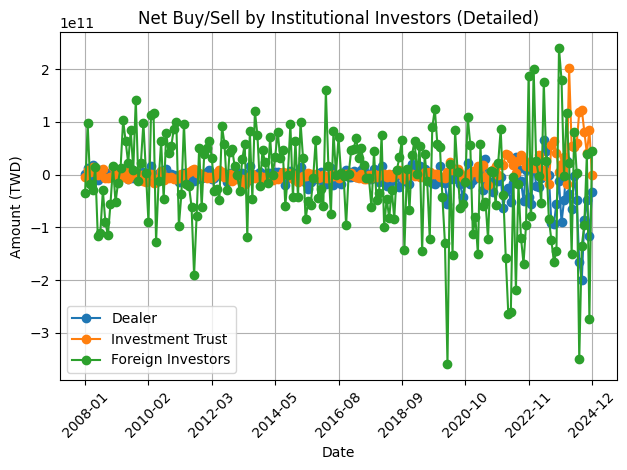

<Figure size 1200x500 with 0 Axes>

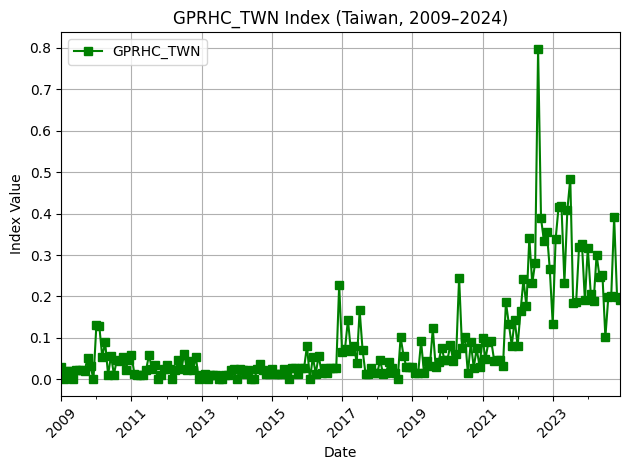

In [ ]:
#個別視覺化分析

# 三大法人買賣差額

df_law = pd.read_csv("/Users/susanlin/Desktop/test/summary_data.csv", encoding="utf-8-sig")

df_law["Date"] = df_law["年份"].astype(str) + "-" + df_law["月份"].astype(str).str.zfill(2)

df_law_plot = df_law.set_index("Date")[[
    "自營商買賣差額",
    "投信買賣差額",
    "外資買賣差額",
]]

df_law_plot.columns = [
    "Dealer",
    "Investment Trust",
    "Foreign Investors"
]

plt.figure(figsize=(14, 6))
df_law_plot.plot(marker="o")
plt.title("Net Buy/Sell by Institutional Investors (Detailed)")
plt.xlabel("Date")
plt.ylabel("Amount (TWD)")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# GPR 
df_gpr["年月"] = pd.to_datetime(df_gpr["年月"])

df_gpr_plot = df_gpr.set_index("年月").loc["2009-01":"2024-12", ["GPRHC_TWN"]]

plt.figure(figsize=(12, 5))
df_gpr_plot.plot(marker="s", color="green")
plt.title("GPRHC_TWN Index (Taiwan, 2009–2024)")
plt.xlabel("Date")
plt.ylabel("Index Value")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


/var/folders/m3/4kw7w40s6p56xt563fshsjjh0000gn/T/ipykernel_647/2658167441.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_gpr_filtered.rename(columns={"Year": "年份", "Month": "月份"}, inplace=True)


<Figure size 1400x600 with 0 Axes>

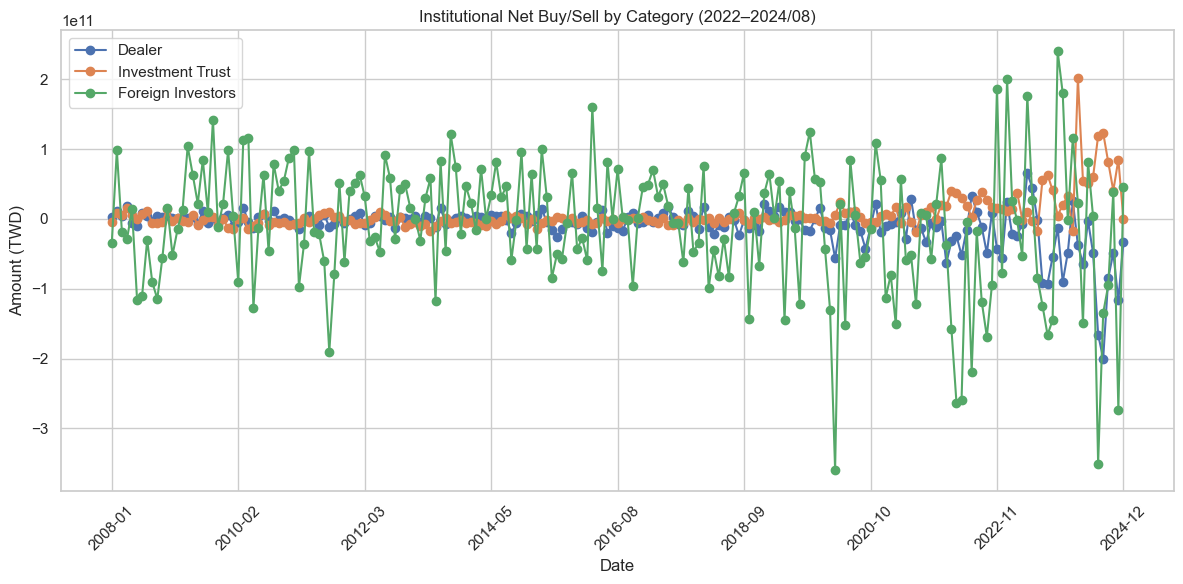

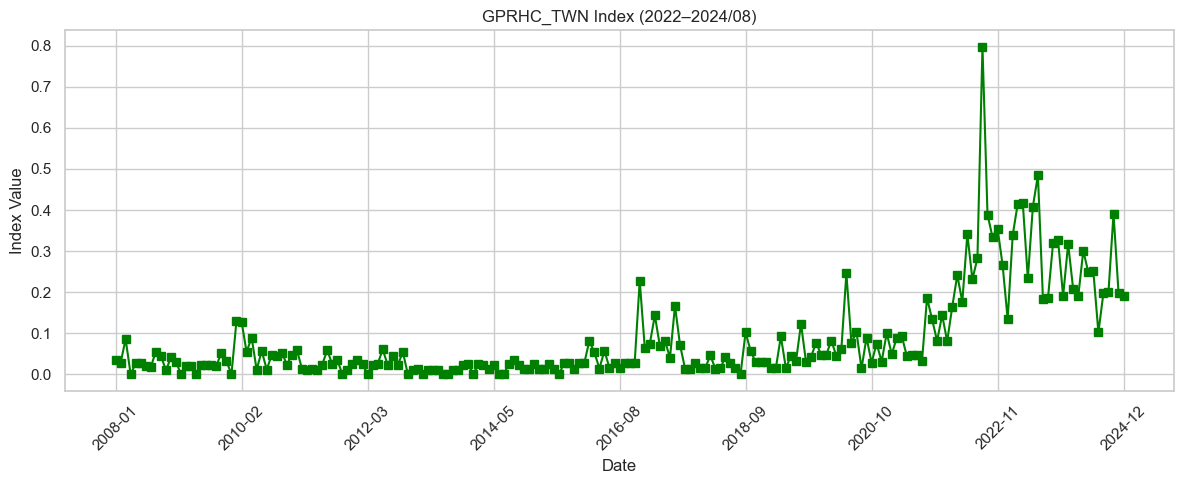

In [ ]:
#   時間序列合併分析

df_law_filtered = df_law[(df_law["年份"] >= 2008) & ((df_law["年份"] < 2025) | ((df_law["年份"] == 2024) & (df_law["月份"] <= 8)))]
df_gpr_filtered = df_gpr[(df_gpr["Year"] >= 2008) & ((df_gpr["Year"] < 2025) | ((df_gpr["Year"] == 2024) & (df_gpr["Month"] <= 8)))]
df_gpr_filtered.rename(columns={"Year": "年份", "Month": "月份"}, inplace=True)

df_merged = pd.merge(df_law_filtered, df_gpr_filtered, on=["年份", "月份"], how="inner")
df_merged["Date"] = df_merged["年份"].astype(str) + "-" + df_merged["月份"].astype(str).str.zfill(2)
df_merged.set_index("Date", inplace=True)

df_merged.rename(columns={
    "自營商買賣差額": "Dealer",
    "投信買賣差額": "Investment Trust",
    "外資買賣差額": "Foreign Investors"
}, inplace=True)

plt.figure(figsize=(14, 6))
df_merged[[
    "Dealer",
    "Investment Trust",
    "Foreign Investors"
]].plot(marker="o")
plt.title("Institutional Net Buy/Sell by Category (2022–2024/08)")
plt.xlabel("Date")
plt.ylabel("Amount (TWD)")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 5))
df_merged["GPRHC_TWN"].plot(color="green", marker="s")
plt.title("GPRHC_TWN Index (2022–2024/08)")
plt.xlabel("Date")
plt.ylabel("Index Value")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
output_path = "/Users/susanlin/Desktop/Thesis/Data/merged_law_gpr_2008_2024.csv"

columns_to_keep = [
    "年份", "月份",
    "Dealer",
    "Investment Trust",
    "Foreign Investors",
    "GPRHC_TWN"
]
df_final = df_merged[columns_to_keep]

# df_merged.reset_index().to_csv(output_path, index=False, encoding="utf-8-sig")

#df_final.drop(columns=["Date"], inplace=True)
df_final.rename(columns={"年份": "Year", "月份": "Month"}, inplace=True)

df_final[:5]

/var/folders/m3/4kw7w40s6p56xt563fshsjjh0000gn/T/ipykernel_647/3359209569.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final.rename(columns={"年份": "Year", "月份": "Month"}, inplace=True)


Year  Month        Dealer  Investment Trust  Foreign Investors  \
Date                                                                      
2008-01  2008      1  2.290434e+09     -4.475578e+09      -3.441877e+10   
2008-02  2008      2  1.208047e+10      8.634891e+09       9.830911e+10   
2008-03  2008      3  4.242235e+09      4.941362e+09      -1.835972e+10   
2008-04  2008      4  1.839216e+10      1.537010e+10      -2.929911e+10   
2008-05  2008      5 -6.164625e+09      4.981936e+09       1.377714e+10   

         GPRHC_TWN  
Date                
2008-01   0.035619  
2008-02   0.027258  
2008-03   0.085859  
2008-04   0.000000  
2008-05   0.026743

## EPU

In [ ]:
import pandas as pd

file_path = "/Users/susanlin/Desktop/Thesis/Data/Global_Policy_Uncertainty_Data.xlsx"
gepu_df = pd.read_excel(file_path)

gepu_df.columns = [col.strip() for col in gepu_df.columns]

gepu_df["Year"] = pd.to_numeric(gepu_df["Year"], errors="coerce")
gepu_df["Month"] = pd.to_numeric(gepu_df["Month"], errors="coerce")

gepu_df_clean = gepu_df.dropna(subset=["Year", "Month", "GEPU_current"])

gepu_df_clean["Year"] = gepu_df_clean["Year"].astype("Int64")
gepu_df_clean["Month"] = gepu_df_clean["Month"].astype("Int64")

gepu_filtered = gepu_df_clean[["Year", "Month", "GEPU_current"]]

gepu_filtered

/var/folders/m3/4kw7w40s6p56xt563fshsjjh0000gn/T/ipykernel_647/485367434.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gepu_df_clean["Year"] = gepu_df_clean["Year"].astype("Int64")
/var/folders/m3/4kw7w40s6p56xt563fshsjjh0000gn/T/ipykernel_647/485367434.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gepu_df_clean["Month"] = gepu_df_clean["Month"].astype("Int64")


Year  Month  GEPU_current
0    1997      1     74.828829
1    1997      2     77.701486
2    1997      3     67.020319
3    1997      4     72.894162
4    1997      5     71.629043
..    ...    ...           ...
332  2024      9    223.007104
333  2024     10    223.640869
334  2024     11    365.206009
335  2024     12    377.073675
336  2025      1    429.830565

[337 rows x 3 columns]

In [ ]:
gepu_filtered = gepu_filtered[(gepu_filtered["Year"] >= 2008) & (gepu_filtered["Year"] < 2025)| ((gepu_filtered["Year"] == 2024) & (gepu_filtered["Month"] <= 8))]
gepu_filtered

Year  Month  GEPU_current
132  2008      1    135.073404
133  2008      2    102.153158
134  2008      3    118.181868
135  2008      4     92.008066
136  2008      5     78.120477
..    ...    ...           ...
331  2024      8    225.378325
332  2024      9    223.007104
333  2024     10    223.640869
334  2024     11    365.206009
335  2024     12    377.073675

[204 rows x 3 columns]

## Merge 

In [ ]:
merged_all = pd.merge(df_final, gepu_filtered, on=["Year", "Month"], how="inner")
merged_all[:5]

Year  Month        Dealer  Investment Trust  Foreign Investors  GPRHC_TWN  \
0  2008      1  2.290434e+09     -4.475578e+09      -3.441877e+10   0.035619   
1  2008      2  1.208047e+10      8.634891e+09       9.830911e+10   0.027258   
2  2008      3  4.242235e+09      4.941362e+09      -1.835972e+10   0.085859   
3  2008      4  1.839216e+10      1.537010e+10      -2.929911e+10   0.000000   
4  2008      5 -6.164625e+09      4.981936e+09       1.377714e+10   0.026743   

   GEPU_current  
0    135.073404  
1    102.153158  
2    118.181868  
3     92.008066  
4     78.120477

In [ ]:
output_path = "/Users/susanlin/Desktop/Thesis/Data/merged_insti_gpr_gepu_2008_2024.csv"
merged_all.to_csv(output_path, index=False, encoding="utf-8-sig")

## EDA & Visualization

In [ ]:
import pandas as pd

file_path = "/Users/susanlin/Desktop/Thesis/Data/merged_insti_gpr_gepu_2008_2024.csv"
df = pd.read_csv(file_path)

df[:5]

Year  Month        Dealer  Investment Trust  Foreign Investors  GPRHC_TWN  \
0  2008      1  2.290434e+09     -4.475578e+09      -3.441877e+10   0.035619   
1  2008      2  1.208047e+10      8.634891e+09       9.830911e+10   0.027258   
2  2008      3  4.242235e+09      4.941362e+09      -1.835972e+10   0.085859   
3  2008      4  1.839216e+10      1.537010e+10      -2.929911e+10   0.000000   
4  2008      5 -6.164625e+09      4.981936e+09       1.377714e+10   0.026743   

   GEPU_current  
0    135.073404  
1    102.153158  
2    118.181868  
3     92.008066  
4     78.120477

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

df["Date"] = pd.to_datetime(df[["Year", "Month"]].assign(DAY=1))

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

#### GPR & GEPU 指數時間趨勢圖

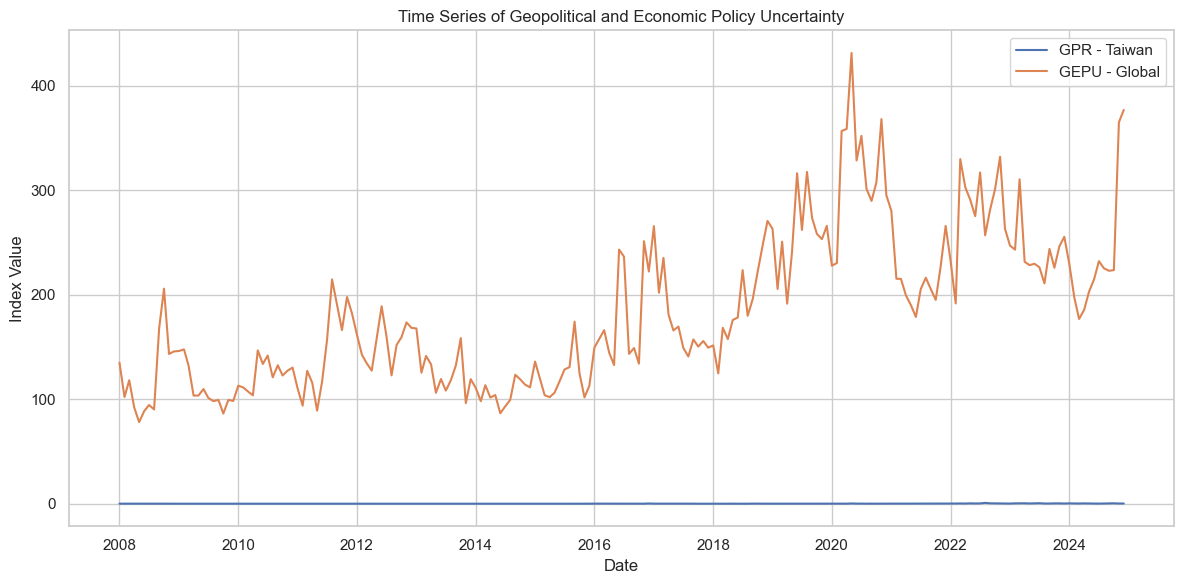

In [ ]:
plt.figure()
sns.lineplot(data=df, x='Date', y='GPRHC_TWN', label='GPR - Taiwan')
sns.lineplot(data=df, x='Date', y='GEPU_current', label='GEPU - Global')
plt.title("Time Series of Geopolitical and Economic Policy Uncertainty")
plt.xlabel("Date")
plt.ylabel("Index Value")
plt.legend()
plt.tight_layout()
plt.show()

對兩個 index 做標準化

#### 外資 vs GPR/GEPU

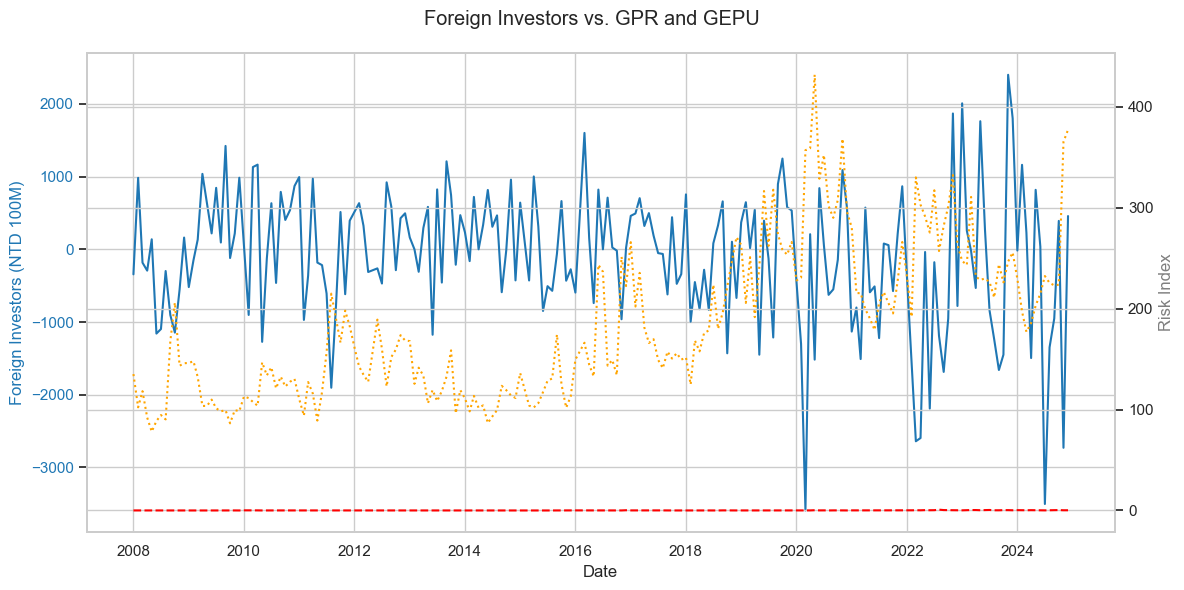

In [ ]:
fig, ax1 = plt.subplots()
ax1.set_xlabel('Date')
ax1.set_ylabel('Foreign Investors (NTD 100M)', color='tab:blue')
ax1.plot(df['Date'], df['Foreign Investors'] / 1e8, color='tab:blue', label='Foreign Investors')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.plot(df['Date'], df['GPRHC_TWN'], color='red', linestyle='--', label='GPR')
ax2.plot(df['Date'], df['GEPU_current'], color='orange', linestyle=':', label='GEPU')
ax2.set_ylabel('Risk Index', color='gray')

fig.suptitle("Foreign Investors vs. GPR and GEPU")
fig.tight_layout()
plt.show()


#### 相關係數矩陣熱圖

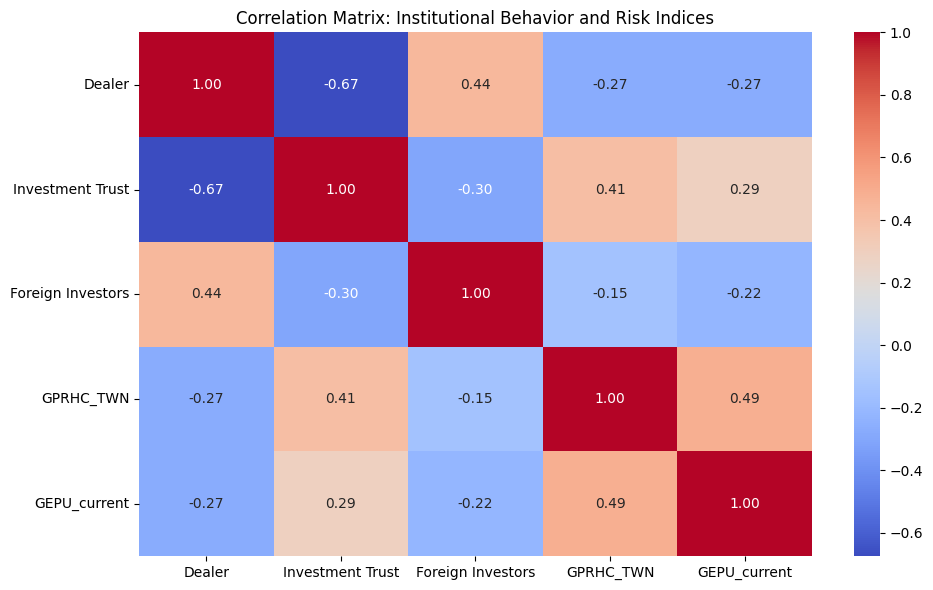

In [515]:
plt.figure(figsize=(10, 6))
selected_cols = [
    'Dealer',
    'Investment Trust', 'Foreign Investors',
    'GPRHC_TWN', 'GEPU_current'
]
corr = df_scaled[selected_cols].corr()
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix: Institutional Behavior and Risk Indices")
plt.tight_layout()
plt.show()


#### 法人行為分布圖

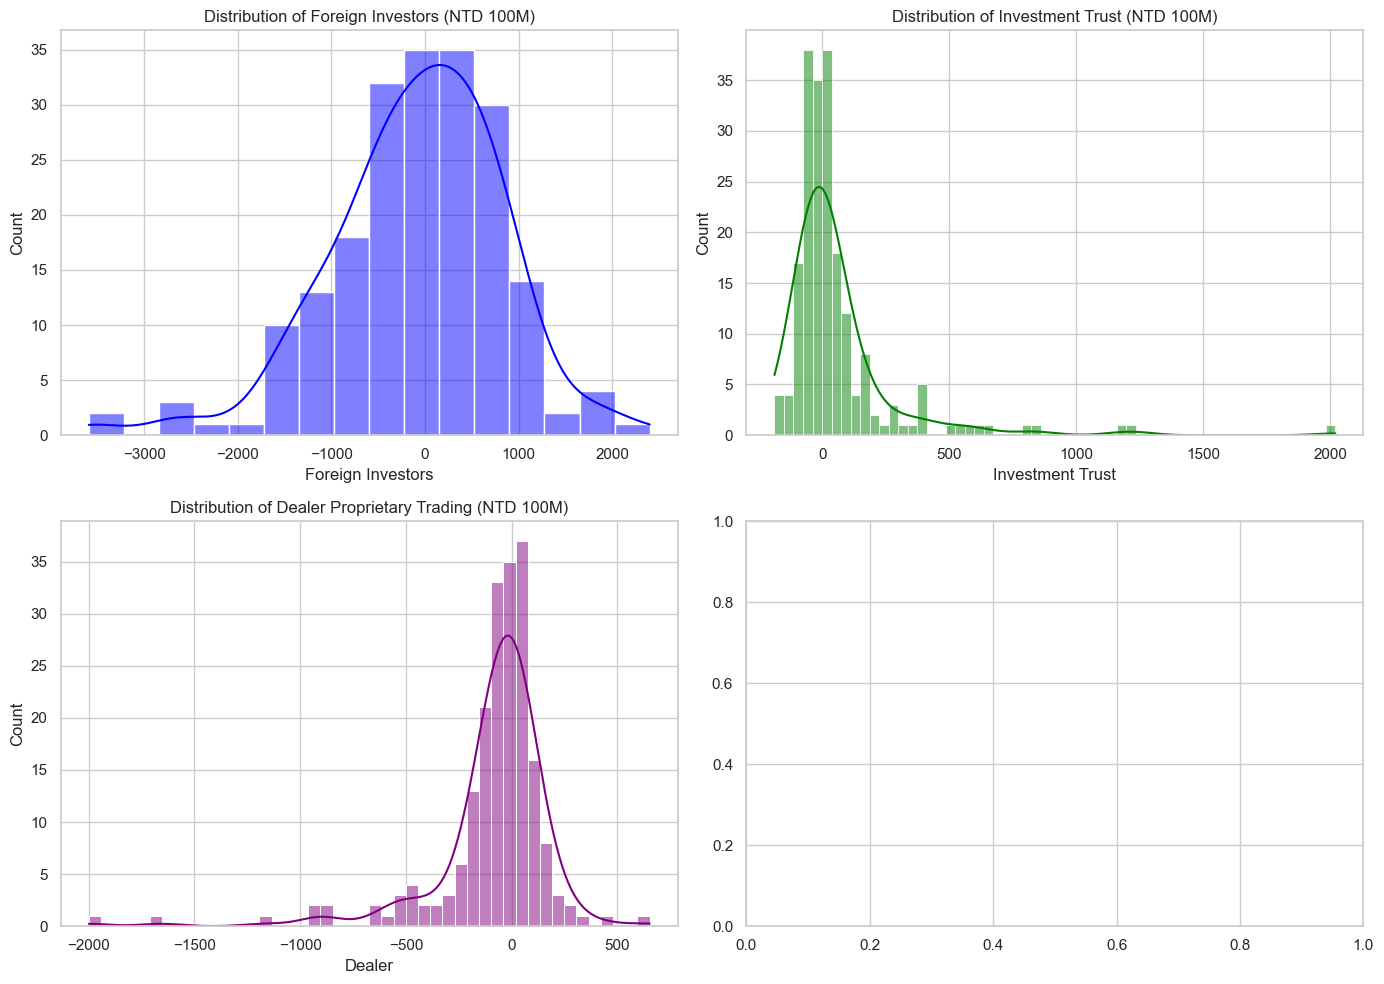

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
sns.histplot(df['Foreign Investors'] / 1e8, kde=True, ax=axes[0, 0], color='blue')
axes[0, 0].set_title("Distribution of Foreign Investors (NTD 100M)")
sns.histplot(df['Investment Trust'] / 1e8, kde=True, ax=axes[0, 1], color='green')
axes[0, 1].set_title("Distribution of Investment Trust (NTD 100M)")
sns.histplot(df['Dealer'] / 1e8, kde=True, ax=axes[1, 0], color='purple')
axes[1, 0].set_title("Distribution of Dealer Proprietary Trading (NTD 100M)")
plt.tight_layout()
plt.show()


#### 散佈圖：風險指數 vs 法人行為

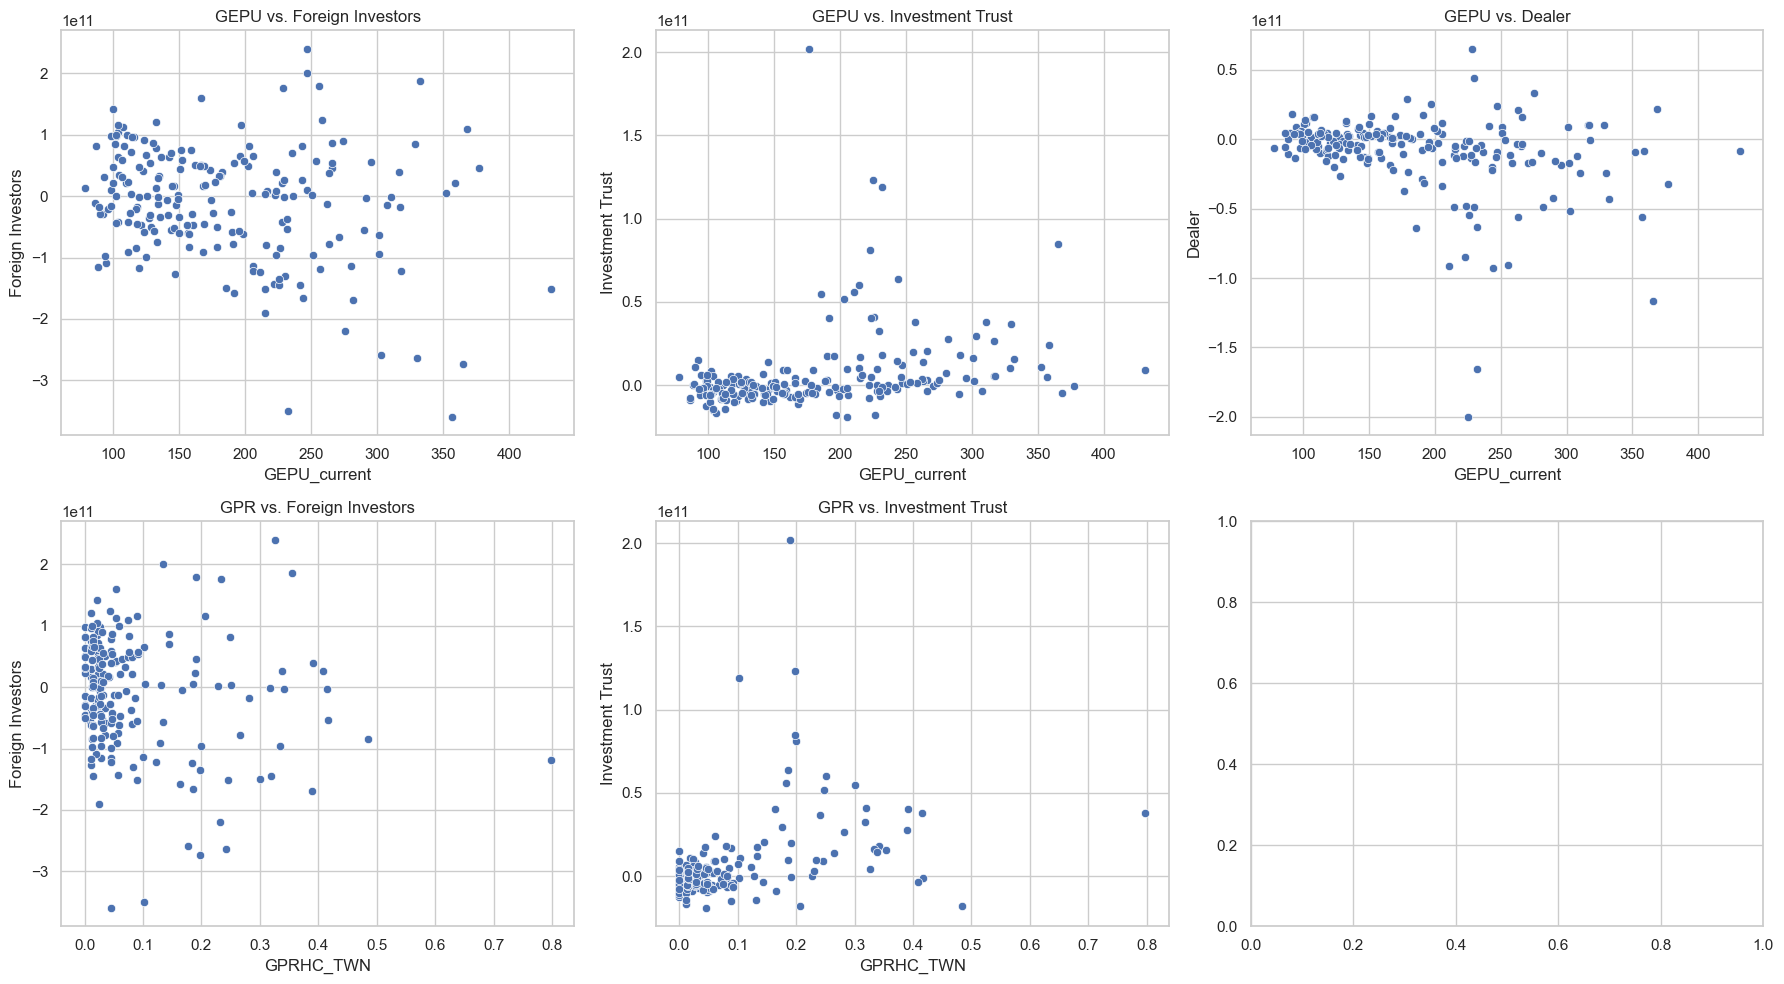

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
sns.scatterplot(data=df, x='GEPU_current', y='Foreign Investors', ax=axes[0, 0])
axes[0, 0].set_title('GEPU vs. Foreign Investors')
sns.scatterplot(data=df, x='GEPU_current', y='Investment Trust', ax=axes[0, 1])
axes[0, 1].set_title('GEPU vs. Investment Trust')
sns.scatterplot(data=df, x='GEPU_current', y='Dealer', ax=axes[0, 2])
axes[0, 2].set_title('GEPU vs. Dealer')
sns.scatterplot(data=df, x='GPRHC_TWN', y='Foreign Investors', ax=axes[1, 0])
axes[1, 0].set_title('GPR vs. Foreign Investors')
sns.scatterplot(data=df, x='GPRHC_TWN', y='Investment Trust', ax=axes[1, 1])
axes[1, 1].set_title('GPR vs. Investment Trust')

plt.tight_layout()
plt.show()


## TAIEX 歷史收盤價、成交量、報酬率

In [ ]:
import yfinance as yf
import pandas as pd

# TAIEX "^TWII"
taiex = yf.download("^TWII", start="2007-12-01", end="2024-12-31", interval="1mo")

taiex["Year"] = taiex.index.year
taiex["Month"] = taiex.index.month

# 每月報酬率（log return）
taiex["Return"] = taiex["Close"].pct_change()

taiex_monthly = taiex[["Year", "Month", "Close", "Volume", "Return"]].reset_index(drop=True)

taiex_monthly[1:6]

[*********************100%***********************]  1 of 1 completed


Price   Year Month        Close     Volume    Return
Ticker                    ^TWII      ^TWII          
1       2008     1  7521.095215  110618000 -0.115814
2       2008     2  8412.719727   66958400  0.118550
3       2008     3  8572.549805  119302600  0.018999
4       2008     4  8919.878906  119824400  0.040516
5       2008     5  8619.040039  110158600 -0.033727

In [ ]:
output_path = "/Users/susanlin/Desktop/Thesis/Data/TAIEX_2008_2024.csv"
taiex_monthly.to_csv(output_path, index=False, encoding="utf-8-sig")

In [ ]:
import pandas as pd

file_path = "/Users/susanlin/Desktop/Thesis/Data/merged_insti_gpr_gepu_2008_2024.csv"
df = pd.read_csv(file_path)

df[:5]

Year  Month        Dealer  Investment Trust  Foreign Investors  GPRHC_TWN  \
0  2008      1  2.290434e+09     -4.475578e+09      -3.441877e+10   0.035619   
1  2008      2  1.208047e+10      8.634891e+09       9.830911e+10   0.027258   
2  2008      3  4.242235e+09      4.941362e+09      -1.835972e+10   0.085859   
3  2008      4  1.839216e+10      1.537010e+10      -2.929911e+10   0.000000   
4  2008      5 -6.164625e+09      4.981936e+09       1.377714e+10   0.026743   

   GEPU_current  
0    135.073404  
1    102.153158  
2    118.181868  
3     92.008066  
4     78.120477

## 匯率資料爬取

In [ ]:
import yfinance as yf
import pandas as pd

fx = yf.download("TWD=X", start="2007-12-01", end="2024-12-31", interval="1mo")
fx = fx.reset_index()
fx["Year"] = fx["Date"].dt.year
fx["Month"] = fx["Date"].dt.month
fx = fx[["Year", "Month", "Close"]].rename(columns={"Close": "USD_TWD_ExchangeRate"})

fx[:5]

[*********************100%***********************]  1 of 1 completed


Price   Year Month USD_TWD_ExchangeRate
Ticker                            TWD=X
0       2007    12            32.430000
1       2008     1            32.200001
2       2008     2            30.910000
3       2008     3            30.415001
4       2008     4            30.475000

In [ ]:
output_path = "/Users/susanlin/Desktop/Thesis/Data/USD_TWD_Monthly.csv"
fx.to_csv(output_path, index=False, encoding="utf-8-sig")

## VIX

In [ ]:
import pandas as pd


vix_df = pd.read_csv('/Users/susanlin/Desktop/Thesis/Data/VIX_History.csv')


vix_df['DATE'] = pd.to_datetime(vix_df['DATE'])

vix_df.set_index('DATE', inplace=True)

monthly_vix = vix_df.resample('M').agg({
    'CLOSE': ['mean', 'last', 'max']
})


monthly_vix.columns = ['VIX_Monthly_Mean', 'VIX_Month_End', 'VIX_Monthly_Max']
monthly_vix.reset_index(inplace=True)


monthly_vix['Year'] = monthly_vix['DATE'].dt.year
monthly_vix['Month'] = monthly_vix['DATE'].dt.month


monthly_vix = monthly_vix[['Year', 'Month', 'VIX_Monthly_Mean', 'VIX_Month_End', 'VIX_Monthly_Max']]


monthly_vix.head()


/var/folders/m3/4kw7w40s6p56xt563fshsjjh0000gn/T/ipykernel_9907/2884527100.py:11: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_vix = vix_df.resample('M').agg({


Year  Month  VIX_Monthly_Mean  VIX_Month_End  VIX_Monthly_Max
0  1990      1         23.347273          25.36            27.25
1  1990      2         23.262632          21.99            24.87
2  1990      3         20.062273          19.73            22.74
3  1990      4         21.403500          19.52            24.16
4  1990      5         18.097727          17.37            20.14

In [ ]:
vix_filtered = monthly_vix[(monthly_vix['Year'] >= 2008) & (monthly_vix['Year'] <= 2024)]
vix_filtered.head()
vix_filtered.to_csv('/Users/susanlin/Desktop/Thesis/Data/VIX_Monthly_2008_2024.csv', index=False, encoding='utf-8-sig')

## Merge

In [ ]:
df_insti = pd.read_csv("/Users/susanlin/Desktop/Thesis/Data/merged_insti_gpr_gepu_2008_2024.csv")
df_taiex = pd.read_csv("/Users/susanlin/Desktop/Thesis/Data/TAIEX_2008_2024.csv")
df_fx = pd.read_csv("/Users/susanlin/Desktop/Thesis/Data/USD_TWD_Monthly.csv")
df_vix = pd.read_csv("/Users/susanlin/Desktop/Thesis/Data/VIX_Monthly_2008_2024.csv")

In [ ]:
for df in [df_insti, df_taiex, df_fx]:
    df.dropna(subset=["Year", "Month"], inplace=True)
    df["Year"] = df["Year"].astype(int)
    df["Month"] = df["Month"].astype(int)
    

In [ ]:
merged_temp = pd.merge(df_insti, df_taiex, on=["Year", "Month"], how="outer")
merged_temp_2 = pd.merge(merged_temp, df_fx, on=["Year", "Month"], how="outer")
merged_all = pd.merge(merged_temp_2, df_vix, on=["Year", "Month"], how="outer")


In [ ]:
# merged_all = merged_all.iloc[1:].reset_index(drop=True) # 去掉 2009/12
merged_all[:5]

Year  Month        Dealer  Investment Trust  Foreign Investors  GPRHC_TWN  \
0  2007     12           NaN               NaN                NaN        NaN   
1  2008      1  2.290434e+09     -4.475578e+09      -3.441877e+10   0.035619   
2  2008      2  1.208047e+10      8.634891e+09       9.830911e+10   0.027258   
3  2008      3  4.242235e+09      4.941362e+09      -1.835972e+10   0.085859   
4  2008      4  1.839216e+10      1.537010e+10      -2.929911e+10   0.000000   

   GEPU_current             Close     Volume    Return USD_TWD_ExchangeRate  \
0           NaN    8506.240234375   81858000       NaN    32.43000030517578   
1    135.073404  7521.09521484375  110618000 -0.115814    32.20000076293945   
2    102.153158   8412.7197265625   66958400  0.118550    30.90999984741211   
3    118.181868   8572.5498046875  119302600  0.018999   30.415000915527344   
4     92.008066     8919.87890625  119824400  0.040516   30.475000381469727   

   VIX_Monthly_Mean  VIX_Month_End  VIX_Monthly_Max  
0               NaN            NaN              NaN  
1         25.816190          26.20            31.01  
2         25.456000          26.54            28.97  
3         27.103500          25.61            32.24  
4         21.562727          20.79            23.82

In [ ]:
output_path = "/Users/susanlin/Desktop/Thesis/Data/merged_all_2008_2024.csv"
merged_all.to_csv(output_path, index=False, encoding="utf-8-sig")

# Regression

In [ ]:
import pandas as pd

In [ ]:
output_path = "/Users/susanlin/Desktop/Thesis/Data/merged_all_2008_2024.csv"
df = pd.read_csv(output_path, encoding="utf-8-sig")
df[:5]

Year  Month        Dealer  Investment Trust  Foreign Investors  GPRHC_TWN  \
0  2007     12           NaN               NaN                NaN        NaN   
1  2008      1  2.290434e+09     -4.475578e+09      -3.441877e+10   0.035619   
2  2008      2  1.208047e+10      8.634891e+09       9.830911e+10   0.027258   
3  2008      3  4.242235e+09      4.941362e+09      -1.835972e+10   0.085859   
4  2008      4  1.839216e+10      1.537010e+10      -2.929911e+10   0.000000   

   GEPU_current        Close     Volume    Return  USD_TWD_ExchangeRate  \
0           NaN  8506.240234   81858000       NaN             32.430000   
1    135.073404  7521.095215  110618000 -0.115814             32.200001   
2    102.153158  8412.719727   66958400  0.118550             30.910000   
3    118.181868  8572.549805  119302600  0.018999             30.415001   
4     92.008066  8919.878906  119824400  0.040516             30.475000   

   VIX_Monthly_Mean  VIX_Month_End  VIX_Monthly_Max  
0               NaN            NaN              NaN  
1         25.816190          26.20            31.01  
2         25.456000          26.54            28.97  
3         27.103500          25.61            32.24  
4         21.562727          20.79            23.82

In [ ]:

import pandas as pd

df["Volume_change"] = df["Volume"].pct_change()
df["ExchangeRate_change"] = df["USD_TWD_ExchangeRate"].pct_change()


df[:5]

Year  Month        Dealer  Investment Trust  Foreign Investors  GPRHC_TWN  \
0  2007     12           NaN               NaN                NaN        NaN   
1  2008      1  2.290434e+09     -4.475578e+09      -3.441877e+10   0.035619   
2  2008      2  1.208047e+10      8.634891e+09       9.830911e+10   0.027258   
3  2008      3  4.242235e+09      4.941362e+09      -1.835972e+10   0.085859   
4  2008      4  1.839216e+10      1.537010e+10      -2.929911e+10   0.000000   

   GEPU_current        Close     Volume    Return  USD_TWD_ExchangeRate  \
0           NaN  8506.240234   81858000       NaN             32.430000   
1    135.073404  7521.095215  110618000 -0.115814             32.200001   
2    102.153158  8412.719727   66958400  0.118550             30.910000   
3    118.181868  8572.549805  119302600  0.018999             30.415001   
4     92.008066  8919.878906  119824400  0.040516             30.475000   

   VIX_Monthly_Mean  VIX_Month_End  VIX_Monthly_Max  Volume_change  \
0               NaN            NaN              NaN            NaN   
1         25.816190          26.20            31.01       0.351340   
2         25.456000          26.54            28.97      -0.394688   
3         27.103500          25.61            32.24       0.781742   
4         21.562727          20.79            23.82       0.004374   

   ExchangeRate_change  
0                  NaN  
1            -0.007092  
2            -0.040062  
3            -0.016014  
4             0.001973

In [ ]:
# 刪掉有 NaN 的 rows
print(f"資料筆數：{df.shape[0]}")
df = df.dropna()
print(f"剩餘資料筆數：{df.shape[0]}")

資料筆數：205
剩餘資料筆數：201


In [ ]:
import statsmodels.api as sm

dependent_vars = ["Foreign Investors", "Investment Trust", "Dealer"]

# 自變數（包含 GPR GEPU）
independent_vars = ["GPRHC_TWN", "GEPU_current", "USD_TWD_ExchangeRate", "Return", "Volume", "VIX_Monthly_Max"]

for target in dependent_vars:
    print(f"\nRegression model for: {target}")
    
    X = df[independent_vars]
    y = df[target]
    
    X_const = sm.add_constant(X)
    model = sm.OLS(y, X_const).fit()
    print(model.summary())



Regression model for: Foreign Investors
                            OLS Regression Results                            
Dep. Variable:      Foreign Investors   R-squared:                       0.517
Model:                            OLS   Adj. R-squared:                  0.502
Method:                 Least Squares   F-statistic:                     34.57
Date:                Tue, 01 Apr 2025   Prob (F-statistic):           3.07e-28
Time:                        20:45:02   Log-Likelihood:                -5287.4
No. Observations:                 201   AIC:                         1.059e+04
Df Residuals:                     194   BIC:                         1.061e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------

### 加入互動項（GPR × Return、GEPU × Return）

In [517]:
import matplotlib.pyplot as plt
import seaborn as sns

df["GPR_Return"] = df["GPRHC_TWN"] * df["Return"]
df["GEPU_Return"] = df["GEPU_current"] * df["Return"]

# Effect Plot: GEPU × Return 對自營商行為的交互效果
# 固定 GEPU 為高低值，畫出不同 GEPU 下 Return 和 Dealer Proprietary Trading 的關係

# 創 GEPU 高低組別
df_scaled["GEPU_group"] = pd.qcut(df_scaled["GEPU_current"], q=2, labels=["Low GEPU", "High GEPU"])

# effect plot：Return vs 自營商，依 GEPU 高低分群
plt.figure(figsize=(8, 5))
sns.lmplot(
    data=df,
    x="Return",
    y="Dealer",
    hue="GEPU_group",
    aspect=1.4,
    height=5,
    markers=["o", "s"],
    palette="Set2"
)
plt.title("Interaction Effect: Return × GEPU on Dealer")
plt.xlabel("Market Return")
plt.ylabel("Dealer")
plt.tight_layout()
plt.show()


KeyError: "['GEPU_group'] not in index"

<Figure size 800x500 with 0 Axes>

在 低 GEPU 時期（政策風險低）：
⟶ 報酬率上升時，自營商主動加碼，呈現正向反應

在 高 GEPU 時期（政策風險高）：
⟶ 報酬上升時，自營商卻出現明顯保守／減碼傾向，幾乎零反應或反向

在全球經濟政策不確定性偏低的情境下，自營商對市場報酬具顯著正向反應，反映出其具有積極交易特性。然而，當 GEPU 指數上升時，反應被顯著削弱甚至反轉 ＝> 高政策風險下自營商採取風險控管策略，反映出交易行為具備風險趨避性與策略調整機制。

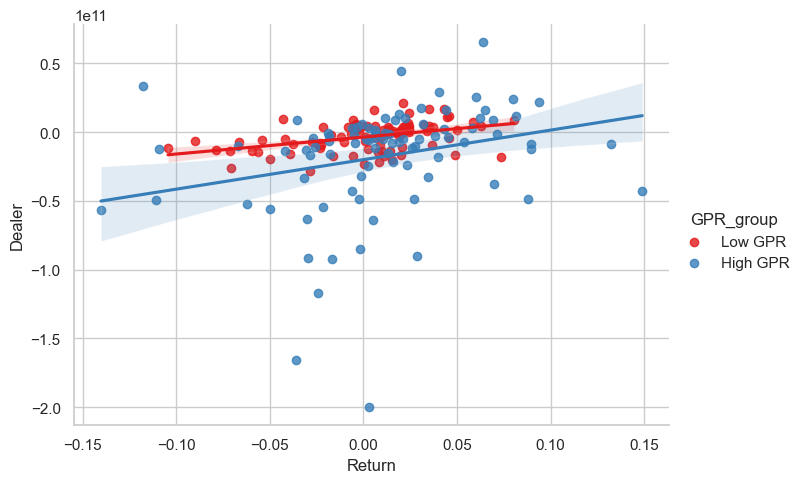

In [ ]:
df_scaled["GPR_group"] = pd.qcut(df["GPRHC_TWN"], q=2, labels=["Low GPR", "High GPR"])
sns.lmplot(
    data=df,
    x="Return",
    y="Dealer",
    hue="GPR_group",
    aspect=1.4,
    height=5,
    palette="Set1"
)


### VIF共線性檢查

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

X = df[["GPRHC_TWN", "GEPU_current", "USD_TWD_ExchangeRate", "Return", "Volume"]]
X = sm.add_constant(X)
vif = pd.DataFrame()
vif["feature"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif

feature         VIF
0                 const  184.841617
1             GPRHC_TWN    1.340260
2          GEPU_current    1.313680
3  USD_TWD_ExchangeRate    1.062132
4                Return    1.019392
5                Volume    1.108700

為避免多重共線性對模型估計造成干擾，採用 VIF 檢驗工具進行共線性檢查，結果顯示所有變數 VIF 值皆小於 1.1

In [ ]:
# # 使用 差分（Δ）避免趨勢問題
# # 法人金額、GPR、GEPU 可能是非平穩序列，對變數做差分處理減少假回歸風險

# df["D_Foreign"] = df["Foreign Investors"].diff()
# df["D_GPR"] = df["GPRHC_TWN"].diff()

### 標準化

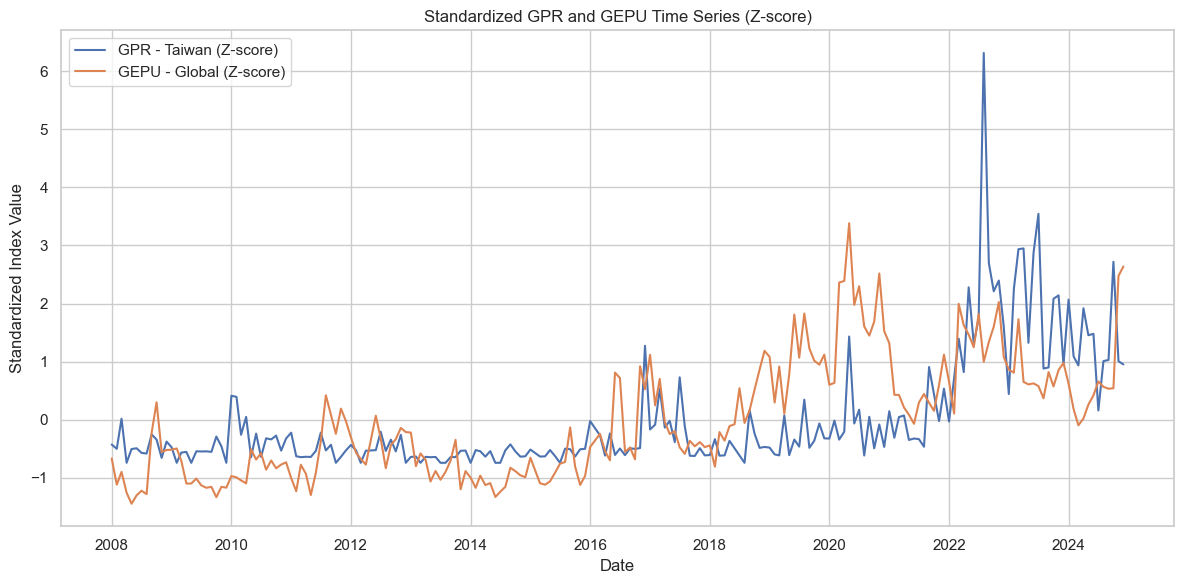

In [ ]:
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd


df["Date"] = pd.to_datetime(df[["Year", "Month"]].assign(DAY=1))

scaler = StandardScaler()
df[["GPR_z", "GEPU_z"]] = scaler.fit_transform(df[["GPRHC_TWN", "GEPU_current"]])

plt.figure(figsize=(12,6))
sns.lineplot(data=df, x='Date', y='GPR_z', label='GPR - Taiwan (Z-score)')
sns.lineplot(data=df, x='Date', y='GEPU_z', label='GEPU - Global (Z-score)')
plt.title("Standardized GPR and GEPU Time Series (Z-score)")
plt.xlabel("Date")
plt.ylabel("Standardized Index Value")
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
df[:5]

Year  Month        Dealer  Investment Trust  Foreign Investors  GPRHC_TWN  \
1  2008      1  2.290434e+09     -4.475578e+09      -3.441877e+10   0.035619   
2  2008      2  1.208047e+10      8.634891e+09       9.830911e+10   0.027258   
3  2008      3  4.242235e+09      4.941362e+09      -1.835972e+10   0.085859   
4  2008      4  1.839216e+10      1.537010e+10      -2.929911e+10   0.000000   
5  2008      5 -6.164625e+09      4.981936e+09       1.377714e+10   0.026743   

   GEPU_current        Close     Volume    Return  USD_TWD_ExchangeRate  \
1    135.073404  7521.095215  110618000 -0.115814             32.200001   
2    102.153158  8412.719727   66958400  0.118550             30.910000   
3    118.181868  8572.549805  119302600  0.018999             30.415001   
4     92.008066  8919.878906  119824400  0.040516             30.475000   
5     78.120477  8619.040039  110158600 -0.033727             30.400000   

   VIX_Monthly_Mean  VIX_Month_End  VIX_Monthly_Max  Volume_change  \
1         25.816190          26.20            31.01       0.351340   
2         25.456000          26.54            28.97      -0.394688   
3         27.103500          25.61            32.24       0.781742   
4         21.562727          20.79            23.82       0.004374   
5         18.303333          17.83            19.73      -0.080666   

   ExchangeRate_change       Date     GPR_z    GEPU_z  
1            -0.007092 2008-01-01 -0.424043 -0.664994  
2            -0.040062 2008-02-01 -0.497960 -1.114448  
3            -0.016014 2008-03-01  0.020112 -0.895611  
4             0.001973 2008-04-01 -0.738937 -1.252957  
5            -0.002461 2008-05-01 -0.502514 -1.442562

In [ ]:
file_path = "/Users/susanlin/Desktop/Thesis/Data/merged_all_2008_2024.csv"
df = pd.read_csv(file_path)

### 加入滯後變數
地緣政治風險可能會延後1-2個月才影響法人行為

In [ ]:
df["GPRHC_TWN_lag1"] = df["GPRHC_TWN"].shift(1)
df["GEPU_current_lag1"] = df["GEPU_current"].shift(1)

df["GPRHC_TWN_lag2"] = df["GPRHC_TWN"].shift(2)
df["GEPU_current_lag2"] = df["GEPU_current"].shift(2)

In [ ]:
df

Year  Month        Dealer  Investment Trust  Foreign Investors  \
0    2007     12           NaN               NaN                NaN   
1    2008      1  2.290434e+09     -4.475578e+09      -3.441877e+10   
2    2008      2  1.208047e+10      8.634891e+09       9.830911e+10   
3    2008      3  4.242235e+09      4.941362e+09      -1.835972e+10   
4    2008      4  1.839216e+10      1.537010e+10      -2.929911e+10   
..    ...    ...           ...               ...                ...   
200  2024      8 -1.998826e+11      1.231823e+11      -1.347530e+11   
201  2024      9 -8.492955e+10      8.126110e+10      -9.506103e+10   
202  2024     10 -4.829849e+10      4.041347e+10       3.906549e+10   
203  2024     11 -1.167762e+11      8.501633e+10      -2.729447e+11   
204  2024     12 -3.253823e+10     -6.916221e+08       4.573943e+10   

     GPRHC_TWN  GEPU_current         Close     Volume    Return  \
0          NaN           NaN   8506.240234   81858000       NaN   
1     0.035619    135.073404   7521.095215  110618000 -0.115814   
2     0.027258    102.153158   8412.719727   66958400  0.118550   
3     0.085859    118.181868   8572.549805  119302600  0.018999   
4     0.000000     92.008066   8919.878906  119824400  0.040516   
..         ...           ...           ...        ...       ...   
200   0.197922    225.378325  22268.089844   89434600  0.003096   
201   0.200100    223.007104  22224.539062   68870900 -0.001956   
202   0.391134    223.640869  22820.429688   61146000  0.026812   
203   0.197694    365.206009  22262.500000   73073600 -0.024449   
204   0.191471    377.073675  23035.099609   67916600  0.034704   

     USD_TWD_ExchangeRate  VIX_Monthly_Mean  VIX_Month_End  VIX_Monthly_Max  \
0               32.430000               NaN            NaN              NaN   
1               32.200001         25.816190          26.20            31.01   
2               30.910000         25.456000          26.54            28.97   
3               30.415001         27.103500          25.61            32.24   
4               30.475000         21.562727          20.79            23.82   
..                    ...               ...            ...              ...   
200             31.996000         19.312273          15.00            38.57   
201             31.575001         17.663333          16.73            22.38   
202             31.865499         19.960870          23.16            23.16   
203             32.438999         16.015238          13.51            21.98   
204             32.759998         15.866190          17.35            27.62   

     Volume_change  ExchangeRate_change  GPRHC_TWN_lag1  GEPU_current_lag1  \
0              NaN                  NaN             NaN                NaN   
1         0.351340            -0.007092             NaN                NaN   
2        -0.394688            -0.040062        0.035619         135.073404   
3         0.781742            -0.016014        0.027258         102.153158   
4         0.004374             0.001973        0.085859         118.181868   
..             ...                  ...             ...                ...   
200      -0.161062            -0.023366        0.101816         232.215679   
201      -0.229930            -0.013158        0.197922         225.378325   
202      -0.112165             0.009200        0.200100         223.007104   
203       0.195068             0.017998        0.391134         223.640869   
204      -0.070573             0.009895        0.197694         365.206009   

     GPRHC_TWN_lag2  GEPU_current_lag2  
0               NaN                NaN  
1               NaN                NaN  
2               NaN                NaN  
3          0.035619         135.073404  
4          0.027258         102.153158  
..              ...                ...  
200        0.251004         214.725089  
201        0.101816         232.215679  
202        0.197922         225.378325  
203        0.200100         223.007104  
204       

### 加入市場狀態虛擬變數（bull/bear dummy）

In [ ]:
df["Market_State"] = df["Return"].apply(lambda x: 1 if x >= 0 else 0)
df["GPR_Bull"] = df["GPRHC_TWN"] * df["Market_State"]
df["GEPU_Bull"] = df["GEPU_current"] * df["Market_State"]


### 加入互動項

In [ ]:
df["GPR_Return"] = df["GPRHC_TWN"] * df["Return"]
df["GEPU_Return"] = df["GEPU_current"] * df["Return"]

In [ ]:
# 刪掉有 NaN 的 rows
print(f"資料筆數：{df.shape[0]}")
df_cleaned = df.dropna()
print(f"剩餘資料筆數：{df_cleaned.shape[0]}")

df = df_cleaned

資料筆數：201
剩餘資料筆數：199


In [ ]:
df.to_csv("/Users/susanlin/Desktop/Thesis/Data/merged_all_2008_2024_regression.csv", index=False, encoding="utf-8-sig")

In [ ]:
models = {
    "Current Only": [
        "GPRHC_TWN", "GEPU_current",
        "USD_TWD_ExchangeRate", "Return", "Volume"
    ],
    "Lag Only": [
        "GPRHC_TWN_lag1", "GEPU_current_lag1", 
        "GPRHC_TWN_lag2", "GEPU_current_lag2",
        "USD_TWD_ExchangeRate", "Return", "Volume"
    ],
    "Current + Lag": [
        "GPRHC_TWN", "GEPU_current",
        "GPRHC_TWN_lag1", "GEPU_current_lag1",
        "USD_TWD_ExchangeRate", "Return", "Volume"
    ],
    "Full: Lag + Market State + Interactions": [
        "GPRHC_TWN_lag1", "GEPU_current_lag1", 
        "GPRHC_TWN_lag2", "GEPU_current_lag2",
        "USD_TWD_ExchangeRate", "Return", "Volume","VIX_Monthly_Max",
        "Market_State", "GPR_Bull", "GEPU_Bull",
        "GPR_Return", "GEPU_Return"
    ]
}


# 三大法人  
targets = [
    "Foreign Investors",
    "Investment Trust",
    "Dealer"
]


for target in targets:
    print(f"\n===================================")
    print(f"      回歸結果：{target}")
    print(f"===================================")
    
    for model_name, var_list in models.items():
        print(f"\n--- Model: {model_name} ---")
        data = df[var_list + [target]].dropna()
        X = sm.add_constant(data[var_list])
        y = data[target]
        model = sm.OLS(y, X).fit()
        print(model.summary())


      回歸結果：Foreign Investors

--- Model: Current Only ---
                            OLS Regression Results                            
Dep. Variable:      Foreign Investors   R-squared:                       0.516
Model:                            OLS   Adj. R-squared:                  0.503
Method:                 Least Squares   F-statistic:                     40.95
Date:                Sun, 06 Apr 2025   Prob (F-statistic):           1.49e-28
Time:                        06:14:00   Log-Likelihood:                -5209.4
No. Observations:                 198   AIC:                         1.043e+04
Df Residuals:                     192   BIC:                         1.045e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------

標準化回歸

In [ ]:
# 要標準化的欄位
features_to_scale = [
    "GPRHC_TWN", "GEPU_current",
    "GPRHC_TWN_lag1", "GEPU_current_lag1",
    "GPRHC_TWN_lag2", "GEPU_current_lag2",
    "USD_TWD_ExchangeRate", "Return", "Volume", "VIX_Monthly_Max",
    "Market_State", "GPR_Bull", "GEPU_Bull",
    "GPR_Return", "GEPU_Return"
]

scaler = StandardScaler()
df_z = df.copy()
df_z[features_to_scale] = scaler.fit_transform(df[features_to_scale])

In [ ]:
models = {
    "Current Only": [
        "GPRHC_TWN", "GEPU_current",
        "USD_TWD_ExchangeRate", "Return", "Volume"
    ],
    "Lag Only": [
        "GPRHC_TWN_lag1", "GEPU_current_lag1", 
        "GPRHC_TWN_lag2", "GEPU_current_lag2",
        "USD_TWD_ExchangeRate", "Return", "Volume"
    ],
    "Current + Lag": [
        "GPRHC_TWN", "GEPU_current",
        "GPRHC_TWN_lag1", "GEPU_current_lag1",
        "USD_TWD_ExchangeRate", "Return", "Volume"
    ],
    "Full: Lag + Market State + Interactions": [
        "GPRHC_TWN_lag1", "GEPU_current_lag1", 
        "GPRHC_TWN_lag2", "GEPU_current_lag2",
        "USD_TWD_ExchangeRate", "Return", "Volume","VIX_Monthly_Max",
        "Market_State", "GPR_Bull", "GEPU_Bull",
        "GPR_Return", "GEPU_Return"
    ]
}


# 三大法人  
targets = [
    "Foreign Investors",
    "Investment Trust",
    "Dealer"
]


for target in targets:
    print(f"\n===================================")
    print(f"      Results：{target}")
    print(f"===================================")
    
    for model_name, var_list in models.items():
        print(f"\n--- Model: {model_name} ---")
        data = df_z[var_list + [target]].dropna()
        X = sm.add_constant(data[var_list])
        y = data[target]
        model = sm.OLS(y, X).fit()
        print(model.summary())


      Results：Foreign Investors

--- Model: Current Only ---
                            OLS Regression Results                            
Dep. Variable:      Foreign Investors   R-squared:                       0.516
Model:                            OLS   Adj. R-squared:                  0.504
Method:                 Least Squares   F-statistic:                     41.16
Date:                Tue, 01 Apr 2025   Prob (F-statistic):           1.05e-28
Time:                        20:45:57   Log-Likelihood:                -5235.2
No. Observations:                 199   AIC:                         1.048e+04
Df Residuals:                     193   BIC:                         1.050e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------

### 簡化模型

In [ ]:
X = df[["GPRHC_TWN_lag1", "GEPU_current_lag1", "USD_TWD_ExchangeRate", "Return", "Volume",
 "Market_State", "GPR_Bull", "GEPU_Bull", "GPR_Return", "GEPU_Return"]]
X = sm.add_constant(X)
vif = pd.DataFrame()
vif["feature"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif

feature         VIF
0                  const  213.851104
1         GPRHC_TWN_lag1    1.858855
2      GEPU_current_lag1    2.701684
3   USD_TWD_ExchangeRate    1.049365
4                 Return   12.712111
5                 Volume    1.098641
6           Market_State   11.264658
7               GPR_Bull    2.675108
8              GEPU_Bull   13.303896
9             GPR_Return    3.147014
10           GEPU_Return   14.007427

In [ ]:

X = df_z[["GPRHC_TWN_lag1", "GEPU_current_lag1", "USD_TWD_ExchangeRate", "Return", "Volume",
 "Market_State", "GPR_Bull", "GEPU_Bull", "GPR_Return", "GEPU_Return"]]
X = sm.add_constant(X)
vif = pd.DataFrame()
vif["feature"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif

feature        VIF
0                  const   1.000000
1         GPRHC_TWN_lag1   1.858855
2      GEPU_current_lag1   2.701684
3   USD_TWD_ExchangeRate   1.049365
4                 Return  12.712111
5                 Volume   1.098641
6           Market_State  11.264658
7               GPR_Bull   2.675108
8              GEPU_Bull  13.303896
9             GPR_Return   3.147014
10           GEPU_Return  14.007427

簡化版模型

In [ ]:

X = df[["GPRHC_TWN_lag1", "GEPU_current_lag1", "USD_TWD_ExchangeRate", "Return", "Volume",
 "GPR_Bull", "GEPU_Bull"]]
X = sm.add_constant(X)
vif = pd.DataFrame()
vif["feature"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif

feature         VIF
0                 const  188.833987
1        GPRHC_TWN_lag1    1.714450
2     GEPU_current_lag1    1.682337
3  USD_TWD_ExchangeRate    1.036630
4                Return    1.858667
5                Volume    1.070279
6              GPR_Bull    1.916455
7             GEPU_Bull    2.891186

In [ ]:
import pandas as pd
import xgboost as xgb
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

selected_vars = [
    "GPRHC_TWN_lag1",
    "GEPU_current_lag1",
    "GPRHC_TWN_lag2",
    "GEPU_current_lag2",
    "USD_TWD_ExchangeRate",
    "Return",
    "Volume",
    "GPR_Bull",
    "GEPU_Bull"
]


target_var = "Foreign Investors"  

X = df_z[selected_vars]
y = df_z[target_var]


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

xgb_model = xgb.XGBRegressor(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.05,
    random_state=42
)
xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)

r2 = r2_score(y_test, y_pred)
print("XGBoost 模型的 R-squared:", r2)

importance = pd.DataFrame({
    "Feature": selected_vars,
    "Importance": xgb_model.feature_importances_
}).sort_values(by="Importance", ascending=False)

print("\n特徵重要性排序:")
print(importance)

XGBoost 模型的 R-squared: 0.36677200521896003

特徵重要性排序:
                Feature  Importance
5                Return    0.448803
0        GPRHC_TWN_lag1    0.134599
3     GEPU_current_lag2    0.091280
7              GPR_Bull    0.079322
4  USD_TWD_ExchangeRate    0.058427
8             GEPU_Bull    0.051794
2        GPRHC_TWN_lag2    0.049762
6                Volume    0.047031
1     GEPU_current_lag1    0.038982


### 模型調整

In [ ]:
df = pd.read_csv("/Users/susanlin/Desktop/Thesis/Data/merged_all_2008_2024_regression.csv", encoding="utf-8-sig")
df[:5]

Year  Month        Dealer  Investment Trust  Foreign Investors  GPRHC_TWN  \
0  2008      3  4.242235e+09      4.941362e+09      -1.835972e+10   0.085859   
1  2008      4  1.839216e+10      1.537010e+10      -2.929911e+10   0.000000   
2  2008      5 -6.164625e+09      4.981936e+09       1.377714e+10   0.026743   
3  2008      6 -1.059040e+10      2.477901e+08      -1.158804e+11   0.028374   
4  2008      7  8.812878e+09      6.402823e+09      -1.096295e+11   0.019361   

   GEPU_current        Close     Volume    Return  ...    GEPU_z  \
0    118.181868  8572.549805  119302600  0.018999  ... -0.895611   
1     92.008066  8919.878906  119824400  0.040516  ... -1.252957   
2     78.120477  8619.040039  110158600 -0.033727  ... -1.442562   
3     88.590384  7523.505371   82064800 -0.127106  ... -1.299618   
4     94.517497  7024.028320   92596000 -0.066389  ... -1.218696   

   GPRHC_TWN_lag1  GEPU_current_lag1  GPRHC_TWN_lag2  GEPU_current_lag2  \
0        0.027258         102.153158        0.035619         135.073404   
1        0.085859         118.181868        0.027258         102.153158   
2        0.000000          92.008066        0.085859         118.181868   
3        0.026743          78.120477        0.000000          92.008066   
4        0.028374          88.590384        0.026743          78.120477   

   Market_State  GPR_Bull   GEPU_Bull  GPR_Return  GEPU_Return  
0             1  0.085859  118.181868    0.001631     2.245293  
1             1  0.000000   92.008066    0.000000     3.727838  
2             0  0.000000    0.000000   -0.000902    -2.634753  
3             0  0.000000    0.000000   -0.003607   -11.260400  
4             0  0.000000    0.000000   -0.001285    -6.274910  

[5 rows x 28 columns]

#### 加控制變數

In [ ]:
df_new = df

##### 景氣對策訊號
https://index.ndc.gov.tw/n/zh_tw/data/eco

In [ ]:
file_path = "/Users/susanlin/Desktop/Thesis/Data/business indicator.csv" 

df = pd.read_csv(file_path)

df.rename(columns={df.columns[0]: "Date", df.columns[1]: "Business_Signal"}, inplace=True)
df["Date"] = pd.to_datetime(df["Date"], format="%Y-%m")


df["Year"] = df["Date"].dt.year
df["Month"] = df["Date"].dt.month

df = df.iloc[1:].reset_index(drop=True)

df["Year"] = df["Year"].astype(int)
df["Month"] = df["Month"].astype(int)
df["Business_Signal"] = df["Business_Signal"].astype(int)

df_bus = df[["Year", "Month", "Business_Signal"]]

df_bus.head()

Year  Month  Business_Signal
0  2008      1               29
1  2008      2               27
2  2008      3               26
3  2008      4               27
4  2008      5               22

In [ ]:
df_new

Year  Month        Dealer  Investment Trust  Foreign Investors  \
0    2007     12           NaN               NaN                NaN   
1    2008      1  2.290434e+09     -4.475578e+09      -3.441877e+10   
2    2008      2  1.208047e+10      8.634891e+09       9.830911e+10   
3    2008      3  4.242235e+09      4.941362e+09      -1.835972e+10   
4    2008      4  1.839216e+10      1.537010e+10      -2.929911e+10   
..    ...    ...           ...               ...                ...   
202  2024     10 -4.829849e+10      4.041347e+10       3.906549e+10   
203  2024     11 -1.167762e+11      8.501633e+10      -2.729447e+11   
204  2024     12 -3.253823e+10     -6.916221e+08       4.573943e+10   
205  2025      1           NaN               NaN                NaN   
206  2025      2           NaN               NaN                NaN   

     GPRHC_TWN  GEPU_current         Close       Volume    Return  ...  \
0          NaN           NaN   8506.240234   81858000.0       NaN  ...   
1     0.035619    135.073404   7521.095215  110618000.0 -0.115814  ...   
2     0.027258    102.153158   8412.719727   66958400.0  0.118550  ...   
3     0.085859    118.181868   8572.549805  119302600.0  0.018999  ...   
4     0.000000     92.008066   8919.878906  119824400.0  0.040516  ...   
..         ...           ...           ...          ...       ...  ...   
202   0.391134    223.640869  22820.429688   61146000.0  0.026812  ...   
203   0.197694    365.206009  22262.500000   73073600.0 -0.024449  ...   
204   0.191471    377.073675  23035.099609   67916600.0  0.034704  ...   
205        NaN           NaN           NaN          NaN       NaN  ...   
206        NaN           NaN           NaN          NaN       NaN  ...   

     VIX_Monthly_Mean  VIX_Month_End  VIX_Monthly_Max  Volume_change  \
0                 NaN            NaN              NaN            NaN   
1           25.816190          26.20            31.01       0.351340   
2           25.456000          26.54            28.97      -0.394688   
3           27.103500          25.61            32.24       0.781742   
4           21.562727          20.79            23.82       0.004374   
..                ...            ...              ...            ...   
202         19.960870          23.16            23.16      -0.112165   
203         16.015238          13.51            21.98       0.195068   
204         15.866190          17.35            27.62      -0.070573   
205               NaN            NaN              NaN            NaN   
206               NaN            NaN              NaN            NaN   

     ExchangeRate_change  GPRHC_TWN_lag1  GEPU_current_lag1  GPRHC_TWN_lag2  \
0                    NaN             NaN                NaN             NaN   
1              -0.007092             NaN                NaN             NaN   
2              -0.040062        0.035619         135.073404             NaN   
3              -0.016014        0.027258         102.153158        0.035619   
4               0.001973        0.085859         118.181868        0.027258   
..                   ...             ...                ...             ...   
202             0.009200        0.200100         223.007104        0.197922   
203             0.017998        0.391134         223.640869        0.200100   
204             0.009895        0.197694         365.206009        0.391134   
205                  NaN             NaN                NaN             NaN   
206                  NaN             NaN                NaN             NaN   

     GEPU_current_lag2  Business_Signal  
0                  NaN              NaN  
1                  NaN             29.0  
2                  NaN             27.0  
3           135.073404             26.0  
4           102.153158             27.0  
..                 ...              ...  
202         225.378325             32.0  
203         223.007104             34.0  
204         223.640869             38.0  
205                NaN       

##### NASDAQ

In [ ]:
import yfinance as yf
import pandas as pd

# NASDAQ (^IXIC) 月資料
nasdaq = yf.download("^IXIC", start="2007-12-01", end="2024-12-31", interval="1mo")

nasdaq["Year"] = nasdaq.index.year
nasdaq["Month"] = nasdaq.index.month

# 每月報酬率
nasdaq["Return"] = nasdaq["Close"].pct_change()

nasdaq_monthly = nasdaq[["Year", "Month", "Close", "Volume", "Return"]].reset_index(drop=True)

nasdaq_monthly.head()

output_path = "/Users/susanlin/Desktop/Thesis/Data/NASDAQ_Monthly_2008_2024.csv"
nasdaq_monthly.to_csv(output_path, index=False, encoding="utf-8-sig")
nasdaq_monthly

[*********************100%***********************]  1 of 1 completed


Price   Year Month         Close        Volume    Return
Ticker                     ^IXIC         ^IXIC          
0       2007    12   2652.280029   37753390000       NaN
1       2008     1   2389.860107   55211960000 -0.098941
2       2008     2   2271.479980   45767570000 -0.049534
3       2008     3   2279.100098   44966440000  0.003355
4       2008     4   2412.800049   42726250000  0.058663
..       ...   ...           ...           ...       ...
200     2024     8  17713.619141  121239310000  0.006490
201     2024     9  18189.169922  110388680000  0.026847
202     2024    10  18095.150391  132373190000 -0.005169
203     2024    11  19218.169922  146515010000  0.062062
204     2024    12  19310.789062  159134440000  0.004819

[205 rows x 5 columns]

In [ ]:
nasdaq_monthly.columns = nasdaq_monthly.columns.droplevel(1)  # 移除 'Ticker'
nasdaq_monthly.rename(columns={
    col: col + "_NAS" for col in nasdaq_monthly.columns if col not in ["Year", "Month"]
}, inplace=True)
df_nasdaq = nasdaq_monthly
df_nasdaq 

Price  Year  Month     Close_NAS    Volume_NAS  Return_NAS
0      2007     12   2652.280029   37753390000         NaN
1      2008      1   2389.860107   55211960000   -0.098941
2      2008      2   2271.479980   45767570000   -0.049534
3      2008      3   2279.100098   44966440000    0.003355
4      2008      4   2412.800049   42726250000    0.058663
..      ...    ...           ...           ...         ...
200    2024      8  17713.619141  121239310000    0.006490
201    2024      9  18189.169922  110388680000    0.026847
202    2024     10  18095.150391  132373190000   -0.005169
203    2024     11  19218.169922  146515010000    0.062062
204    2024     12  19310.789062  159134440000    0.004819

[205 rows x 5 columns]

In [ ]:
df_regression = pd.read_csv("/Users/susanlin/Desktop/Thesis/Data/merged_all_2008_2024_regression.csv", encoding="utf-8-sig")
df_regression[:5]

Year  Month        Dealer  Investment Trust  Foreign Investors  GPRHC_TWN  \
0  2008      3  4.242235e+09      4.941362e+09      -1.835972e+10   0.085859   
1  2008      4  1.839216e+10      1.537010e+10      -2.929911e+10   0.000000   
2  2008      5 -6.164625e+09      4.981936e+09       1.377714e+10   0.026743   
3  2008      6 -1.059040e+10      2.477901e+08      -1.158804e+11   0.028374   
4  2008      7  8.812878e+09      6.402823e+09      -1.096295e+11   0.019361   

   GEPU_current        Close     Volume    Return  ...    GEPU_z  \
0    118.181868  8572.549805  119302600  0.018999  ... -0.895611   
1     92.008066  8919.878906  119824400  0.040516  ... -1.252957   
2     78.120477  8619.040039  110158600 -0.033727  ... -1.442562   
3     88.590384  7523.505371   82064800 -0.127106  ... -1.299618   
4     94.517497  7024.028320   92596000 -0.066389  ... -1.218696   

   GPRHC_TWN_lag1  GEPU_current_lag1  GPRHC_TWN_lag2  GEPU_current_lag2  \
0        0.027258         102.153158        0.035619         135.073404   
1        0.085859         118.181868        0.027258         102.153158   
2        0.000000          92.008066        0.085859         118.181868   
3        0.026743          78.120477        0.000000          92.008066   
4        0.028374          88.590384        0.026743          78.120477   

   Market_State  GPR_Bull   GEPU_Bull  GPR_Return  GEPU_Return  
0             1  0.085859  118.181868    0.001631     2.245293  
1             1  0.000000   92.008066    0.000000     3.727838  
2             0  0.000000    0.000000   -0.000902    -2.634753  
3             0  0.000000    0.000000   -0.003607   -11.260400  
4             0  0.000000    0.000000   -0.001285    -6.274910  

[5 rows x 28 columns]

In [ ]:
df_new = pd.merge(df_new, df_bus, on=["Year", "Month"], how="outer")

In [ ]:
merged = pd.merge(df_regression, df_bus, on=["Year", "Month"], how="outer")
merged_all = pd.merge(merged, df_nasdaq , on=["Year", "Month"], how="outer")
merged_all

Year  Month        Dealer  Investment Trust  Foreign Investors  \
0    2007     12           NaN               NaN                NaN   
1    2008      1           NaN               NaN                NaN   
2    2008      2           NaN               NaN                NaN   
3    2008      3  4.242235e+09      4.941362e+09      -1.835972e+10   
4    2008      4  1.839216e+10      1.537010e+10      -2.929911e+10   
..    ...    ...           ...               ...                ...   
202  2024     10 -4.829849e+10      4.041347e+10       3.906549e+10   
203  2024     11 -1.167762e+11      8.501633e+10      -2.729447e+11   
204  2024     12 -3.253823e+10     -6.916221e+08       4.573943e+10   
205  2025      1           NaN               NaN                NaN   
206  2025      2           NaN               NaN                NaN   

     GPRHC_TWN  GEPU_current         Close       Volume    Return  ...  \
0          NaN           NaN           NaN          NaN       NaN  ...   
1          NaN           NaN           NaN          NaN       NaN  ...   
2          NaN           NaN           NaN          NaN       NaN  ...   
3     0.085859    118.181868   8572.549805  119302600.0  0.018999  ...   
4     0.000000     92.008066   8919.878906  119824400.0  0.040516  ...   
..         ...           ...           ...          ...       ...  ...   
202   0.391134    223.640869  22820.429688   61146000.0  0.026812  ...   
203   0.197694    365.206009  22262.500000   73073600.0 -0.024449  ...   
204   0.191471    377.073675  23035.099609   67916600.0  0.034704  ...   
205        NaN           NaN           NaN          NaN       NaN  ...   
206        NaN           NaN           NaN          NaN       NaN  ...   

     GEPU_current_lag2  Market_State  GPR_Bull   GEPU_Bull  GPR_Return  \
0                  NaN           NaN       NaN         NaN         NaN   
1                  NaN           NaN       NaN         NaN         NaN   
2                  NaN           NaN       NaN         NaN         NaN   
3           135.073404           1.0  0.085859  118.181868    0.001631   
4           102.153158           1.0  0.000000   92.008066    0.000000   
..                 ...           ...       ...         ...         ...   
202         225.378325           1.0  0.391134  223.640869    0.010487   
203         223.007104           0.0  0.000000    0.000000   -0.004833   
204         223.640869           1.0  0.191471  377.073675    0.006645   
205                NaN           NaN       NaN         NaN         NaN   
206                NaN           NaN       NaN         NaN         NaN   

     GEPU_Return Business_Signal     Close_NAS    Volume_NAS  Return_NAS  
0            NaN             NaN   2652.280029  3.775339e+10         NaN  
1            NaN            29.0   2389.860107  5.521196e+10   -0.098941  
2            NaN            27.0   2271.479980  4.576757e+10   -0.049534  
3       2.245293            26.0   2279.100098  4.496644e+10    0.003355  
4       3.727838            27.0   2412.800049  4.272625e+10    0.058663  
..           ...             ...           ...           ...         ...  
202     5.996322            32.0  18095.150391  1.323732e+11   -0.005169  
203    -8.928810            34.0  19218.169922  1.465150e+11    0.062062  
204    13.085995            38.0  19310.789062  1.591344e+11    0.004819  
205          NaN            35.0           NaN           NaN         NaN  
206          NaN            37.0           NaN           NaN         NaN  

[207 rows x 32 columns]

In [ ]:
# 刪掉有 NaN 的 rows
print(f"資料筆數：{df.shape[0]}")
df_cleaned = merged_all.dropna()
print(f"剩餘資料筆數：{df_cleaned.shape[0]}")

df = df_cleaned

資料筆數：199
剩餘資料筆數：199


In [ ]:
df[:5]

Year  Month        Dealer  Investment Trust  Foreign Investors  GPRHC_TWN  \
3  2008      3  4.242235e+09      4.941362e+09      -1.835972e+10   0.085859   
4  2008      4  1.839216e+10      1.537010e+10      -2.929911e+10   0.000000   
5  2008      5 -6.164625e+09      4.981936e+09       1.377714e+10   0.026743   
6  2008      6 -1.059040e+10      2.477901e+08      -1.158804e+11   0.028374   
7  2008      7  8.812878e+09      6.402823e+09      -1.096295e+11   0.019361   

   GEPU_current        Close       Volume    Return  ...  GEPU_current_lag2  \
3    118.181868  8572.549805  119302600.0  0.018999  ...         135.073404   
4     92.008066  8919.878906  119824400.0  0.040516  ...         102.153158   
5     78.120477  8619.040039  110158600.0 -0.033727  ...         118.181868   
6     88.590384  7523.505371   82064800.0 -0.127106  ...          92.008066   
7     94.517497  7024.028320   92596000.0 -0.066389  ...          78.120477   

   Market_State  GPR_Bull   GEPU_Bull  GPR_Return  GEPU_Return  \
3           1.0  0.085859  118.181868    0.001631     2.245293   
4           1.0  0.000000   92.008066    0.000000     3.727838   
5           0.0  0.000000    0.000000   -0.000902    -2.634753   
6           0.0  0.000000    0.000000   -0.003607   -11.260400   
7           0.0  0.000000    0.000000   -0.001285    -6.274910   

  Business_Signal    Close_NAS    Volume_NAS  Return_NAS  
3            26.0  2279.100098  4.496644e+10    0.003355  
4            27.0  2412.800049  4.272625e+10    0.058663  
5            22.0  2522.659912  4.278311e+10    0.045532  
6            20.0  2292.979980  4.596810e+10   -0.091047  
7            16.0  2325.550049  5.067246e+10    0.014204  

[5 rows x 32 columns]

In [ ]:
output_path = "/Users/susanlin/Desktop/Thesis/Data/for regression.csv"
df.to_csv(output_path, index=False, encoding="utf-8-sig")

##### GDP
https://nstatdb.dgbas.gov.tw/dgbasall/webMain.aspx?k=dgmain&mode=8&kw=GDP

In [ ]:
file_path = "/Users/susanlin/Desktop/Thesis/Data/GDP.csv" 
df = pd.read_csv(file_path)

df[:5]

統計期  經濟成長率(%)  國內生產毛額GDP(名目值，百萬元)  國內生產毛額GDP(名目值，百萬美元)  平均每人GDP(名目值，元)  \
0     96年      6.85            13363917               406940          583133   
1  96年第1季      5.64             3164736                96106          138268   
2  96年第2季      7.12             3194285                96447          139481   
3  96年第3季      7.97             3453398               104905          150648   
4  96年第4季      6.58             3551498               109482          154736   

   平均每人GDP(名目值，美元)  
0            17757  
1             4199  
2             4212  
3             4577  
4             4769

In [ ]:
import pandas as pd

monthly_rows = []

for _, row in df.iterrows():
    term = row["統計期"]
    
    if "第" in term:
        year = int(term.split("年")[0]) + 1911  
        season = int(term.split("第")[1][0])
        
        # 對應季的月份
        months = list(range((season - 1) * 3 + 1, season * 3 + 1))
        
        for m in months:
            monthly_rows.append({
                "Year": year,
                "Month": m,
                "GDP_growth": row["經濟成長率(%)"],
                "GDP_NTD": row["國內生產毛額GDP(名目值，百萬元)"],
                "GDP_USD": row["國內生產毛額GDP(名目值，百萬美元)"],
                "GDP_per_capita_NTD": row["平均每人GDP(名目值，元)"],
                "GDP_per_capita_USD": row["平均每人GDP(名目值，美元)"]
            })

df_gdp = pd.DataFrame(monthly_rows)

df_gdp.head()

Year  Month  GDP_growth  GDP_NTD  GDP_USD  GDP_per_capita_NTD  \
0  2007      1        5.64  3164736    96106              138268   
1  2007      2        5.64  3164736    96106              138268   
2  2007      3        5.64  3164736    96106              138268   
3  2007      4        7.12  3194285    96447              139481   
4  2007      5        7.12  3194285    96447              139481   

   GDP_per_capita_USD  
0                4199  
1                4199  
2                4199  
3                4212  
4                4212

##### CPI
https://nstatdb.dgbas.gov.tw/dgbasall/webMain.aspx?k=dgmain&mode=8&kw=CPI

In [ ]:
file_path = "/Users/susanlin/Desktop/Thesis/Data/CPI.csv" 
df_cpi = pd.read_csv(file_path)

df_cpi[:15]

統計期    總指數  Unnamed: 2
0    96年1月  85.24         NaN
1    96年2月  85.56         NaN
2    96年3月  84.56         NaN
3    96年4月  85.54         NaN
4    96年5月  85.71         NaN
5    96年6月  86.24         NaN
6    96年7月  86.04         NaN
7    96年8月  87.18         NaN
8    96年9月  87.99         NaN
9   96年10月  89.86         NaN
10  96年11月  89.33         NaN
11  96年12月  88.26         NaN
12   97年1月  87.75         NaN
13   97年2月  88.87         NaN
14   97年3月  87.91         NaN

In [ ]:
import pandas as pd

df_cpi = df_cpi.drop(columns=[col for col in df_cpi.columns if "Unnamed" in col])

def parse_date(cell):
    try:
        year = int(cell.split("年")[0]) + 1911
        if "月" in cell:
            month = int(cell.split("年")[1].replace("月", ""))
        else:
            month = None
        return pd.Series([year, month])
    except:
        return pd.Series([None, None])

df_cpi[["Year", "Month"]] = df_cpi["統計期"].apply(parse_date)

df_cpi = df_cpi.dropna(subset=["Month"])

df_cpi["Year"] = df_cpi["Year"].astype(int)
df_cpi["Month"] = df_cpi["Month"].astype(int)

df_cpi = df_cpi[["Year", "Month", "總指數"]].rename(columns={"總指數": "CPI"})

df_cpi[:15]

Year  Month    CPI
0   2007      1  85.24
1   2007      2  85.56
2   2007      3  84.56
3   2007      4  85.54
4   2007      5  85.71
5   2007      6  86.24
6   2007      7  86.04
7   2007      8  87.18
8   2007      9  87.99
9   2007     10  89.86
10  2007     11  89.33
11  2007     12  88.26
12  2008      1  87.75
13  2008      2  88.87
14  2008      3  87.91

In [ ]:
df_new = pd.merge(df_new, df_cpi, on=["Year", "Month"], how="outer")

##### 五大銀行存放款平均利率
https://cpx.cbc.gov.tw/Tree/TreeSelect

In [ ]:
file_path = "/Users/susanlin/Desktop/Thesis/Data/五大銀行存放款平均利率.csv" 
df_rate = pd.read_csv(file_path)

df_rate[:5]

期間  一個月期存款牌告利率  一年期存款牌告利率  基準放款利率
0  2008M01        2.09       2.62   4.326
1  2008M02        2.09       2.62   4.342
2  2008M03        2.09       2.62   4.350
3  2008M04        2.13       2.66   4.392
4  2008M05        2.13       2.66   4.392

In [ ]:
import pandas as pd

df_rate["Year"] = df_rate["期間"].str[:4].astype(int)
df_rate["Month"] = df_rate["期間"].str[-2:].astype(int)

df_rate = df_rate.rename(columns={
    "一個月期存款牌告利率": "Deposit_1M",
    "一年期存款牌告利率": "Deposit_1Y",
    "基準放款利率": "Loan_BaseRate"
})

df_rate = df_rate[["Year", "Month", "Deposit_1M", "Deposit_1Y", "Loan_BaseRate"]]

df_rate.head()

Year  Month  Deposit_1M  Deposit_1Y  Loan_BaseRate
0  2008      1        2.09        2.62          4.326
1  2008      2        2.09        2.62          4.342
2  2008      3        2.09        2.62          4.350
3  2008      4        2.13        2.66          4.392
4  2008      5        2.13        2.66          4.392

##### 小型股報酬率
小型股通常散戶參與度較高，表現好時可能表示散戶情緒高漲

In [ ]:
import yfinance as yf
import numpy as np
import pandas as pd

# 使用 00891 為小型股 proxy
tw_smallcap = yf.download("00891.TW", start="2008-01-01", end="2024-12-31", interval="1mo")

tw_smallcap = tw_smallcap.reset_index()
tw_smallcap["Year"] = tw_smallcap["Date"].dt.year
tw_smallcap["Month"] = tw_smallcap["Date"].dt.month
tw_smallcap["Smallcap_Return"] = np.log(tw_smallcap["Close"] / tw_smallcap["Close"].shift(1))

tw_smallcap = tw_smallcap[["Year", "Month", "Smallcap_Return"]]

tw_smallcap 

[*********************100%***********************]  1 of 1 completed


Price   Year Month Smallcap_Return
Ticker                            
0       2021     5             NaN
1       2021     6        0.003221
2       2021     7        0.017846
3       2021     8        0.004412
4       2021     9        0.000391
5       2021    10        0.006369
6       2021    11        0.045914
7       2021    12        0.088647
8       2022     1       -0.083627
9       2022     2       -0.050389
10      2022     3       -0.019686
11      2022     4       -0.124850
12      2022     5        0.052547
13      2022     6       -0.188251
14      2022     7        0.025775
15      2022     8       -0.013664
16      2022     9       -0.165102
17      2022    10       -0.007125
18      2022    11        0.188432
19      2022    12       -0.075319
20      2023     1        0.142119
21      2023     2        0.027550
22      2023     3        0.052739
23      2023     4       -0.075595
24      2023     5        0.076338
25      2023     6        0.034633
26      2023     7       -0.002903
27      2023     8       -0.018336
28      2023     9        0.021264
29      2023    10        0.041853
30      2023    11        0.093703
31      2023    12        0.070896
32      2024     1        0.005476
33      2024     2        0.061196
34      2024     3        0.053499
35      2024     4       -0.047964
36      2024     5        0.040776
37      2024     6        0.116534
38      2024     7       -0.076597
39      2024     8        0.004353
40      2024     9       -0.010406
41      2024    10        0.022747
42      2024    11       -0.067505
43      2024    12        0.096108

In [ ]:
df_main = pd.read_csv("/Users/susanlin/Desktop/Thesis/Data/for regression.csv")

df_merged = df_main.copy()

df_merged = df_merged.merge(df_gdp, on=["Year", "Month"], how="left")
df_merged = df_merged.merge(df_cpi, on=["Year", "Month"], how="left")
df_merged = df_merged.merge(df_rate, on=["Year", "Month"], how="left")

print(f"合併後資料筆數：{df_merged.shape[0]}")
print("缺失值統計：")
df_merged.isnull().sum().sort_values(ascending=False)

df_merged.to_csv("/Users/susanlin/Desktop/Thesis/Data/final_merged_with_macro.csv", index=False, encoding="utf-8-sig")

合併後資料筆數：199
缺失值統計：


In [ ]:
df_new = df_new.merge(df_cpi, on=["Year", "Month"], how="left")
df_new = df_new.merge(df_bus, on=["Year", "Month"], how="left")

##### 資料處理

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

df = pd.read_csv("/Users/susanlin/Desktop/Thesis/Data/final_merged_with_macro.csv")


log_vars = ["Volume", "Close", "Volume_NAS", "Close_NAS", "VIX_Monthly_Max"]
for col in log_vars:
    df[f"log_{col}"] = np.log(df[col] + 1)


df["Return_lag1"] = df["Return"].shift(1)

df["GEPU_x_VIX"] = df["GEPU_current"] * df["VIX_Monthly_Max"]
df["Return_x_Business"] = df["Return"] * df["Business_Signal"]

df["GPR_Return"] = df["GPRHC_TWN"] * df["Return"]
df["GEPU_Return"] = df["GEPU_current"] * df["Return"]


df["Turnover_NTD"] = df["Volume"] * df["Close"]


features_to_scale = [
    "GPRHC_TWN", "GEPU_current", "Return", "Volume", "USD_TWD_ExchangeRate",
    "VIX_Monthly_Max", "Business_Signal",
    "Return_NAS", "Volume_NAS", "Close_NAS",
    "GEPU_x_VIX", "Return_x_Business",
    "GPRHC_TWN_lag1", "GEPU_current_lag1", 
    "GPRHC_TWN_lag2", "GEPU_current_lag2",
    "GPR_Return", "GEPU_Return",
    "Turnover_NTD"
]

scaler = StandardScaler()
df_scaled = df.copy()
df_scaled[[f"{col}_z" for col in features_to_scale]] = scaler.fit_transform(df[features_to_scale])


df_scaled["GDP_growth_z"] = StandardScaler().fit_transform(df_scaled[["GDP_growth"]])
df_scaled["CPI_mom"] = df_scaled["CPI"].pct_change()
df_scaled["log_CPI"] = np.log(df_scaled["CPI"] + 1)

df_scaled["Rate_Spread"] = df_scaled["Loan_BaseRate"] - df_scaled["Deposit_1Y"]
df_scaled["Rate_Spread_z"] = StandardScaler().fit_transform(df_scaled[["Rate_Spread"]])

# 去掉極端值
from scipy.stats.mstats import winsorize
df_scaled["Dealer_winsor"] = winsorize(df_scaled["Dealer"], limits=[0.01, 0.01])
df_scaled["Investment Trust_winsor"] = winsorize(df_scaled["Investment Trust"], limits=[0.01, 0.01])
df_scaled["Foreign Investors_winsor"] = winsorize(df_scaled["Foreign Investors"], limits=[0.01, 0.01])


df_scaled.dropna(inplace=True)
df_scaled.head()


Year  Month        Dealer  Investment Trust  Foreign Investors  GPRHC_TWN  \
1  2008      4  1.839216e+10      1.537010e+10      -2.929911e+10   0.000000   
2  2008      5 -6.164625e+09      4.981936e+09       1.377714e+10   0.026743   
3  2008      6 -1.059040e+10      2.477901e+08      -1.158804e+11   0.028374   
4  2008      7  8.812878e+09      6.402823e+09      -1.096295e+11   0.019361   
5  2008      8  4.689821e+09      1.081642e+10      -2.985458e+10   0.017981   

   GEPU_current        Close       Volume    Return  ...  GEPU_Return_z  \
1     92.008066  8919.878906  119824400.0  0.040516  ...       0.220090   
2     78.120477  8619.040039  110158600.0 -0.033727  ...      -0.357110   
3     88.590384  7523.505371   82064800.0 -0.127106  ...      -1.139611   
4     94.517497  7024.028320   92596000.0 -0.066389  ...      -0.687338   
5     90.215864  7046.078125   78415200.0  0.003139  ...      -0.092399   

   Turnover_NTD_z  GDP_growth_z   CPI_mom   log_CPI  Rate_Spread  \
1        0.587405      0.672319  0.010807  4.498253        1.732   
2        0.374585      0.672319  0.000450  4.498698        1.732   
3       -0.217470      0.672319  0.018335  4.516667        1.726   
4       -0.158662     -1.264458  0.005633  4.522223        1.684   
5       -0.333182     -1.264458  0.002526  4.524719        1.696   

  Rate_Spread_z  Dealer_winsor  Investment Trust_winsor  \
1      0.671436   1.839216e+10             1.537010e+10   
2      0.671436  -6.164625e+09             4.981936e+09   
3      0.638486  -1.059040e+10             2.477901e+08   
4      0.407840   8.812878e+09             6.402823e+09   
5      0.473739   4.689821e+09             1.081642e+10   

   Foreign Investors_winsor  
1             -2.929911e+10  
2              1.377714e+10  
3             -1.158804e+11  
4             -1.096295e+11  
5             -2.985458e+10  

[5 rows x 77 columns]

In [ ]:
df_scaled = df_scaled.merge(df_cpi, on=["Year", "Month"], how="left")
df_scaled["CPI_mom"] = df_scaled["CPI"].pct_change()
df_scaled["log_CPI"] = np.log(df_scaled["CPI"] + 1)

In [ ]:
output_path = "/Users/susanlin/Desktop/Thesis/Data/final_0417.csv"
df_scaled.to_csv(output_path, index=False, encoding="utf-8-sig")

In [ ]:
df_standardized

Year  Month        Dealer  Investment Trust  Foreign Investors  \
0    1985      1           NaN               NaN                NaN   
1    1985      2           NaN               NaN                NaN   
2    1985      3           NaN               NaN                NaN   
3    1985      4           NaN               NaN                NaN   
4    1985      5           NaN               NaN                NaN   
..    ...    ...           ...               ...                ...   
478  2024     11 -1.167762e+11      8.501633e+10      -2.729447e+11   
479  2024     12 -3.253823e+10     -6.916221e+08       4.573943e+10   
480  2025      1           NaN               NaN                NaN   
481  2025      2           NaN               NaN                NaN   
482  2025      3           NaN               NaN                NaN   

     GPRHC_TWN  GEPU_current         Close    Volume_x    Return  ...  \
0          NaN           NaN           NaN         NaN       NaN  ...   
1          NaN           NaN           NaN         NaN       NaN  ...   
2          NaN           NaN           NaN         NaN       NaN  ...   
3          NaN           NaN           NaN         NaN       NaN  ...   
4          NaN           NaN           NaN         NaN       NaN  ...   
..         ...           ...           ...         ...       ...  ...   
478   0.975385      2.440198  22262.500000  73073600.0 -0.024449  ...   
479   0.921203      2.602065  23035.099609  67916600.0  0.034704  ...   
480        NaN           NaN           NaN         NaN       NaN  ...   
481        NaN           NaN           NaN         NaN       NaN  ...   
482        NaN           NaN           NaN         NaN       NaN  ...   

     LogReturn  LogReturn_lag1      Volume  Volume_lag1  \
0          NaN             NaN         NaN          NaN   
1          NaN             NaN         NaN          NaN   
2          NaN             NaN         NaN          NaN   
3          NaN             NaN         NaN          NaN   
4          NaN             NaN         NaN          NaN   
..         ...             ...         ...          ...   
478  -0.007032        0.050092  73073600.0    -0.069989   
479   0.009844       -0.007032  65344200.0     0.344263   
480        NaN             NaN         NaN          NaN   
481        NaN             NaN         NaN          NaN   
482        NaN             NaN         NaN          NaN   

     Business_Signal_pct_change   GPR_GEPU GPR_lag1_GEPU_lag1     usepu_y  \
0                           NaN        NaN                NaN         NaN   
1                           NaN        NaN                NaN         NaN   
2                           NaN        NaN                NaN         NaN   
3                           NaN        NaN                NaN         NaN   
4                           NaN        NaN                NaN         NaN   
..                          ...        ...                ...         ...   
478                    0.062500  72.198880          87.473613  225.049031   
479                    0.117647  72.198616          72.198880  218.845481   
480                         NaN        NaN                NaN         NaN   
481                         NaN        NaN                NaN         NaN   
482                         NaN        NaN                NaN         NaN   

     GPRHC_USA_y       usepu  
0            NaN  103.748803  
1            NaN   78.313193  
2            NaN  100.761475  
3            NaN   84.778863  
4            NaN   98.053653  
..           ...         ...  
478     3.344316  225.049031  
479     4.055701  218.845481  
480          NaN  236.787068  
481          NaN  329.305146  
482          NaN  446.027858  

[483 rows x 109 columns]

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import statsmodels.api as sm

df = df_scaled

targets = ["Foreign Investors", "Investment Trust", "Dealer"]

# 解釋變數
features = [
    "GPRHC_TWN_z", "GEPU_current_z", "Return_z", "Volume_z", "USD_TWD_ExchangeRate_z",
    "VIX_Monthly_Max_z", "Business_Signal_z",
    "Return_NAS_z", "Volume_NAS_z", "Close_NAS_z",
    "GEPU_x_VIX_z", "Return_x_Business_z",
    "GDP_growth_z", "log_CPI", "Rate_Spread_z",
    "GPRHC_TWN_lag1_z", "GEPU_current_lag1_z", 
    "GPRHC_TWN_lag2_z", "GEPU_current_lag2_z",
    "GPR_Return_z", "GEPU_Return_z",
]


results = []

for target in targets:
    print(f"\n🔍 回歸分析：{target}")

    data = df[features + [target]].dropna()
    X = data[features]
    y = data[target]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # ================= OLS =================
    X_train_const = sm.add_constant(X_train)
    X_test_const = sm.add_constant(X_test)
    ols = sm.OLS(y_train, X_train_const).fit()
    r2_ols = r2_score(y_test, ols.predict(X_test_const))

    # ================= Ridge =================
    ridge = Ridge(alpha=1.0)
    ridge.fit(X_train, y_train)
    r2_ridge = ridge.score(X_test, y_test)

    # ================= Lasso =================
    lasso = Lasso(alpha=0.01)
    lasso.fit(X_train, y_train)
    r2_lasso = lasso.score(X_test, y_test)

    # ================= Random Forest =================
    rf = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42)
    rf.fit(X_train, y_train)
    r2_rf = rf.score(X_test, y_test)

    # ================= XGBoost =================
    xgb = XGBRegressor(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=42)
    xgb.fit(X_train, y_train)
    r2_xgb = xgb.score(X_test, y_test)
    
    results.append({
        "Target": target,
        "OLS R2": round(r2_ols, 4),
        "Ridge R2": round(r2_ridge, 4),
        "Lasso R2": round(r2_lasso, 4),
        "RandomForest R2": round(r2_rf, 4),
        "XGBoost R2": round(r2_xgb, 4),
    })

result_df = pd.DataFrame(results)
print("\n📊 模型 R-squared 比較：")
result_df



🔍 回歸分析：Foreign Investors


KeyError: "['GDP_growth_z', 'Rate_Spread_z', 'GPRHC_TWN_lag1_z', 'GEPU_current_lag1_z', 'GPRHC_TWN_lag2_z', 'GEPU_current_lag2_z', 'GPR_Return_z', 'GEPU_Return_z'] not in index"

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor


targets = ["Foreign Investors", "Investment Trust", "Dealer"]


all_features = [
    "GPRHC_TWN_z", "GEPU_current_z", "Volume_z", "USD_TWD_ExchangeRate_z",
    "VIX_Monthly_Max_z", "Business_Signal_z", 
    "Volume_NAS_z",
    "GEPU_x_VIX_z",
    "GDP_growth_z", "Rate_Spread_z",
    "GPRHC_TWN_lag1_z", "GEPU_current_lag1_z", 
    "GPRHC_TWN_lag2_z", "GEPU_current_lag2_z",
    "Turnover_NTD", "Return_lag1",
    "GPR_GEPU", "GPR_lag1_GEPU_lag1"
]


models = {
    "OLS": LinearRegression(),
    "Ridge": Ridge(alpha=1.0),
    "Lasso": Lasso(alpha=0.01),
    "RandomForest": RandomForestRegressor(n_estimators=100, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=100, random_state=42, verbosity=0),
    "GradientBoost": GradientBoostingRegressor(n_estimators=100, random_state=42)
}

results = []
top_feature_dict = {}


for target in targets:
    df_sub = df_scaled[all_features + [target]].dropna()
    X = df_sub[all_features]
    y = df_sub[target]

    # 資料切分
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # 用 Random Forest 抽前 10 大
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)
    top_features_series = pd.Series(rf.feature_importances_, index=X_train.columns).nlargest(5)
    top_features = top_features_series.index.tolist()
    top_feature_dict[target] = top_features_series

    for model_name, model in models.items():
        model.fit(X_train[top_features], y_train)
        y_pred = model.predict(X_test[top_features])
        r2 = r2_score(y_test, y_pred)

        results.append({
            "Target": target,
            "Model": model_name,
            "R2": round(r2, 4)
        })


results_df = pd.DataFrame(results)
pivot_df = results_df.pivot_table(index="Target", columns="Model", values="R2")

plt.figure(figsize=(10, 5))
sns.heatmap(pivot_df, annot=True, cmap="YlGnBu", fmt=".3f")
plt.title("Model Comparison (R-squared) by Institutional Investor")
plt.tight_layout()
plt.show()


for target in targets:
    plt.figure(figsize=(8, 5))
    top_feature_dict[target].sort_values().plot(kind='barh')
    plt.title(f"Top 10 Features for {target}")
    plt.xlabel("Feature Importance (Random Forest)")
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()


In [ ]:
df_scaled["GPR_GEPU"] = df_scaled["GPRHC_TWN"] * df_scaled["GEPU_current"]
df_scaled["GPR_lag1_GEPU_lag1"] = df_scaled["GPRHC_TWN_lag1"] * df_scaled["GEPU_current_lag1"]

In [ ]:
data

Price          Close       Date  Year Month   Market
Ticker         ^TWII                                
0        8756.509766 2000-01-04  2000     1  Neutral
1        8849.830078 2000-01-05  2000     1  Neutral
2        8921.989258 2000-01-06  2000     1  Neutral
3        8849.830078 2000-01-07  2000     1  Neutral
4        9102.557617 2000-01-10  2000     1  Neutral
...              ...        ...   ...   ...      ...
6130    23220.130859 2024-12-25  2024    12  Neutral
6131    23246.939453 2024-12-26  2024    12  Neutral
6132    23275.679688 2024-12-27  2024    12  Neutral
6133    23190.199219 2024-12-30  2024    12  Neutral
6134    23035.099609 2024-12-31  2024    12  Neutral

[6135 rows x 5 columns]

In [ ]:

data.columns = data.columns.droplevel(1) 
data = data.rename(columns={"Close": "Close"})  


In [ ]:
data

Price         Close       Date  Year  Month   Market
0       8756.509766 2000-01-04  2000      1  Neutral
1       8849.830078 2000-01-05  2000      1  Neutral
2       8921.989258 2000-01-06  2000      1  Neutral
3       8849.830078 2000-01-07  2000      1  Neutral
4       9102.557617 2000-01-10  2000      1  Neutral
...             ...        ...   ...    ...      ...
6130   23220.130859 2024-12-25  2024     12  Neutral
6131   23246.939453 2024-12-26  2024     12  Neutral
6132   23275.679688 2024-12-27  2024     12  Neutral
6133   23190.199219 2024-12-30  2024     12  Neutral
6134   23035.099609 2024-12-31  2024     12  Neutral

[6135 rows x 5 columns]

# [New!] 無 market condition

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=2.05114e-26): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.606e+23, tolerance: 1.352e+20
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.83605e-26): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-pack

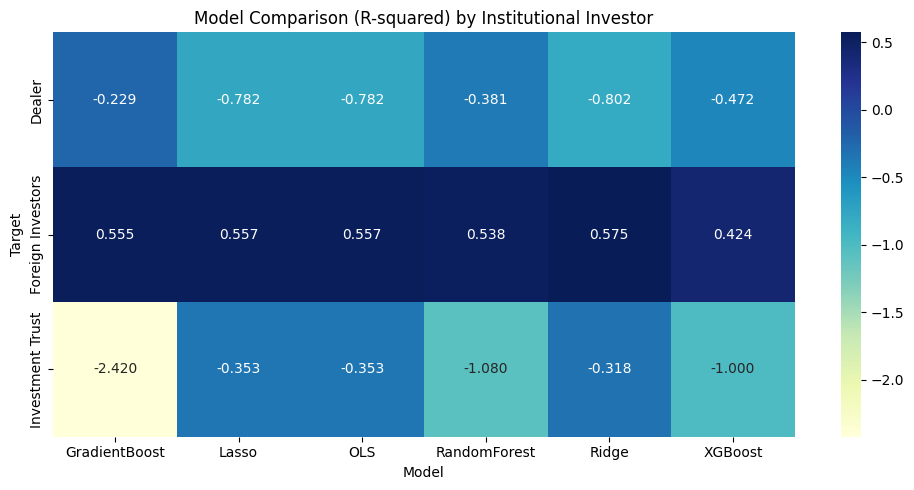

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
import seaborn as sns
import matplotlib.pyplot as plt

targets = ["Foreign Investors", "Investment Trust", "Dealer"]

all_features = [
    "GPRHC_TWN_z", "GEPU_current_z", "Return_z", "Volume_z", "USD_TWD_ExchangeRate_z",
    "VIX_Monthly_Max_z", "Business_Signal_z", 
    "Return_NAS_z", "Volume_NAS_z", "Close_NAS_z",
    "GEPU_x_VIX_z", "Return_x_Business_z",
    "GDP_growth_z", "log_CPI", "Rate_Spread_z",
    "GPRHC_TWN_lag1_z", "GEPU_current_lag1_z", 
    "GPRHC_TWN_lag2_z", "GEPU_current_lag2_z",
    "GPR_Return_z", "GEPU_Return_z",
    "Turnover_NTD", "Return_lag1",
    "GPR_GEPU", "GPR_lag1_GEPU_lag1"
]

models = {
    "OLS": LinearRegression(),
    "Ridge": Ridge(alpha=1.0),
    "Lasso": Lasso(alpha=0.01),
    "RandomForest": RandomForestRegressor(n_estimators=100, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=100, random_state=42, verbosity=0),
    "GradientBoost": GradientBoostingRegressor(n_estimators=100, random_state=42)
}

results = []

for target in targets:
    df_sub = df_scaled[all_features + [target]].dropna()
    X = df_sub[all_features]
    y = df_sub[target]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # 用 RF 選出前10重要變數
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)
    top_features = pd.Series(rf.feature_importances_, index=X_train.columns).nlargest(10).index.tolist()

    for model_name, model in models.items():
        model.fit(X_train[top_features], y_train)
        y_pred = model.predict(X_test[top_features])
        r2 = r2_score(y_test, y_pred)

        results.append({
            "Target": target,
            "Model": model_name,
            "R2": round(r2, 4)
        })

results_df = pd.DataFrame(results)
pivot_df = results_df.pivot_table(index="Target", columns="Model", values="R2")

plt.figure(figsize=(10, 5))
sns.heatmap(pivot_df, annot=True, cmap="YlGnBu", fmt=".3f")
plt.title("Model Comparison (R-squared) by Institutional Investor")
plt.tight_layout()
plt.show()


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.51639e-25): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.964e+23, tolerance: 1.352e+20
  model = cd_fast.enet_coordinate_descent(


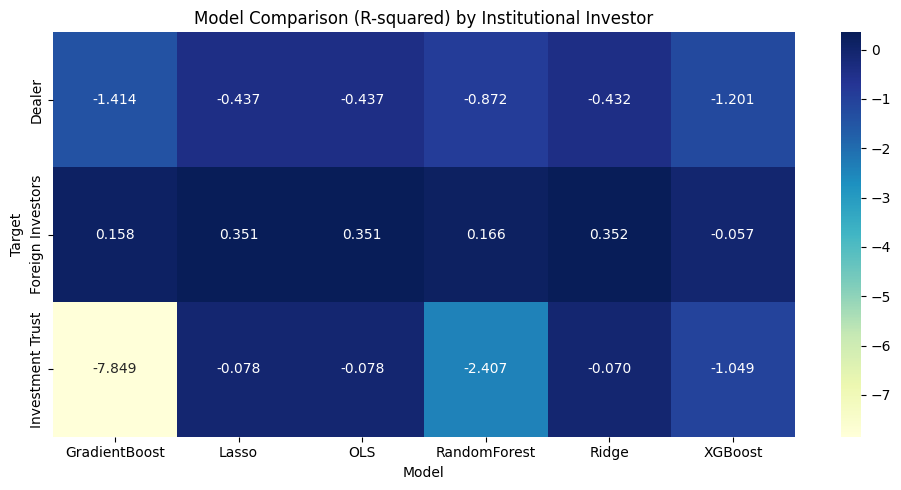

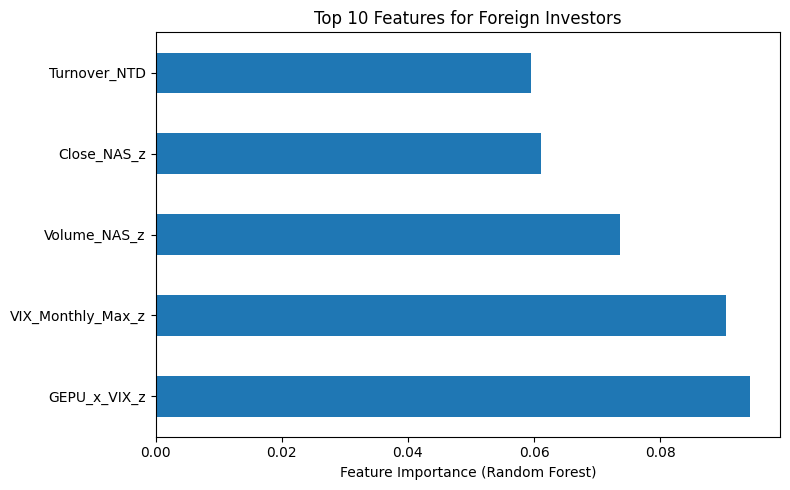

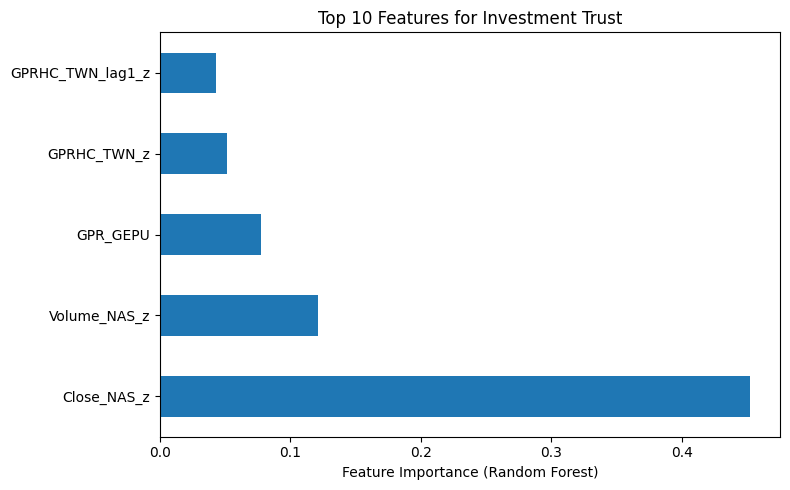

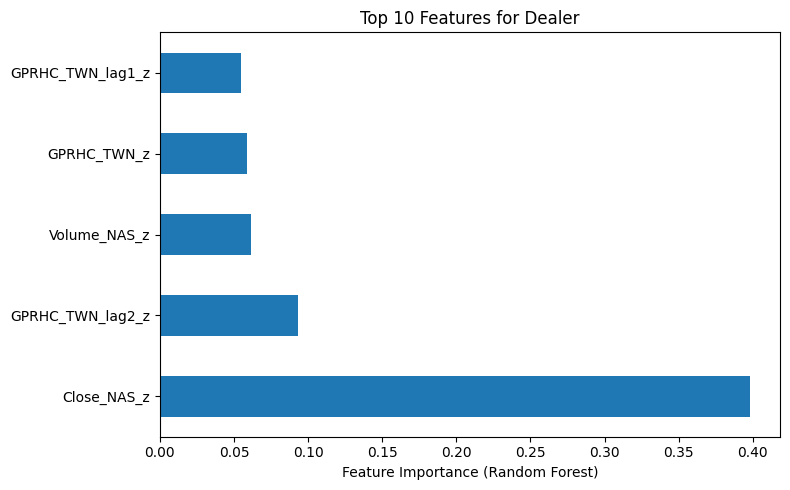

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor


targets = ["Foreign Investors", "Investment Trust", "Dealer"]


all_features = [
    "GPRHC_TWN_z", "GEPU_current_z", "Volume_z", "USD_TWD_ExchangeRate_z",
    "VIX_Monthly_Max_z", "Business_Signal_z", 
    "Volume_NAS_z", "Close_NAS_z",
    "GEPU_x_VIX_z",
    "GDP_growth_z", "Rate_Spread_z",
    "GPRHC_TWN_lag1_z", "GEPU_current_lag1_z", 
    "GPRHC_TWN_lag2_z", "GEPU_current_lag2_z",
    "Turnover_NTD", "Return_lag1",
    "GPR_GEPU", "GPR_lag1_GEPU_lag1"
]


models = {
    "OLS": LinearRegression(),
    "Ridge": Ridge(alpha=1.0),
    "Lasso": Lasso(alpha=0.01),
    "RandomForest": RandomForestRegressor(n_estimators=100, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=100, random_state=42, verbosity=0),
    "GradientBoost": GradientBoostingRegressor(n_estimators=100, random_state=42)
}

results = []
top_feature_dict = {}

for target in targets:
    df_sub = df_scaled[all_features + [target]].dropna()
    X = df_sub[all_features]
    y = df_sub[target]


    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # 特徵選擇：用 Random Forest 抽前 10 大
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)
    top_features_series = pd.Series(rf.feature_importances_, index=X_train.columns).nlargest(5)
    top_features = top_features_series.index.tolist()
    top_feature_dict[target] = top_features_series


    for model_name, model in models.items():
        model.fit(X_train[top_features], y_train)
        y_pred = model.predict(X_test[top_features])
        r2 = r2_score(y_test, y_pred)

        results.append({
            "Target": target,
            "Model": model_name,
            "R2": round(r2, 4)
        })


results_df = pd.DataFrame(results)
pivot_df = results_df.pivot_table(index="Target", columns="Model", values="R2")

plt.figure(figsize=(10, 5))
sns.heatmap(pivot_df, annot=True, cmap="YlGnBu", fmt=".3f")
plt.title("Model Comparison (R-squared) by Institutional Investor")
plt.tight_layout()
plt.show()


for target in targets:
    plt.figure(figsize=(8, 5))
    top_feature_dict[target].sort_values().plot(kind='barh')
    plt.title(f"Top 10 Features for {target}")
    plt.xlabel("Feature Importance (Random Forest)")
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()


In [ ]:
import shap
import xgboost as xgb
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

target = "Foreign Investors"
features = [
    "GPRHC_TWN_z", "GEPU_current_z", "Volume_z", "USD_TWD_ExchangeRate_z",
    "VIX_Monthly_Max_z", "Business_Signal_z", 
    "Return_NAS_z", "Volume_NAS_z", "Close_NAS_z",
    "GEPU_x_VIX_z", "Return_x_Business_z",
    "GDP_growth_z", "log_CPI", "Rate_Spread_z",
    "GPRHC_TWN_lag1_z", "GEPU_current_lag1_z", 
    "GPRHC_TWN_lag2_z", "GEPU_current_lag2_z",
    "GPR_Return_z", "GEPU_Return_z",
    "Turnover_NTD"
]

df = df_scaled.dropna(subset=features + [target])
X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


model = xgb.XGBRegressor(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=42)
model.fit(X_train, y_train)


explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_test)


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
import pandas as pd
import xgboost as xgb
import shap
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

# === Step 1: 資料準備 ===
df = pd.read_csv("/Users/susanlin/Desktop/Thesis/Data/final_0406.csv")

target = "Foreign Investors"
features = [
    "GPRHC_TWN_z", "GEPU_current_z", "Return_z", "Volume_z", "USD_TWD_ExchangeRate_z",
    "VIX_Monthly_Max_z", "Business_Signal_z", 
    "Return_NAS_z", "Volume_NAS_z", "Close_NAS_z",
    "GEPU_x_VIX_z", "Return_x_Business_z",
    "GDP_growth_z", "log_CPI", "Rate_Spread_z",
    "GPRHC_TWN_lag1_z", "GEPU_current_lag1_z", 
    "GPRHC_TWN_lag2_z", "GEPU_current_lag2_z",
    "GPR_Return_z", "GEPU_Return_z",
    "Turnover_NTD"
]

df = df.dropna(subset=features + [target])
X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

xgb_model = xgb.XGBRegressor(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train)

explainer = shap.Explainer(xgb_model, X_train)
shap_values = explainer(X_train)

shap_importance = pd.DataFrame({
    "Feature": X_train.columns,
    "Importance": np.abs(shap_values.values).mean(axis=0)
}).sort_values(by="Importance", ascending=False)

top10_features = shap_importance["Feature"].head(10).tolist()
print("🔝 Top 10 Features by SHAP:\n", top10_features)


models = {
    "OLS": LinearRegression(),
    "Ridge": Ridge(alpha=1.0),
    "Lasso": Lasso(alpha=0.01),
    "RandomForest": RandomForestRegressor(n_estimators=100, random_state=42),
    "XGBoost": xgb.XGBRegressor(n_estimators=100, random_state=42)
}

results = []
for name, model in models.items():
    model.fit(X_train[top10_features], y_train)
    y_pred = model.predict(X_test[top10_features])
    r2 = r2_score(y_test, y_pred)
    results.append({"Model": name, "R2": round(r2, 4)})

results_df = pd.DataFrame(results)
print("\n📊 R-squared Comparison:")
print(results_df)


🔝 Top 10 Features by SHAP:
 ['Return_z', 'Volume_NAS_z', 'Return_NAS_z', 'GEPU_Return_z', 'Return_x_Business_z', 'GEPU_current_z', 'Turnover_NTD', 'GPRHC_TWN_lag1_z', 'VIX_Monthly_Max_z', 'GPR_Return_z']


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=2.39642e-25): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.608e+23, tolerance: 1.352e+20
  model = cd_fast.enet_coordinate_descent(



📊 R-squared Comparison:
          Model      R2
0           OLS  0.5672
1         Ridge  0.5829
2         Lasso  0.5672
3  RandomForest  0.5254
4       XGBoost  0.3994


/var/folders/m3/4kw7w40s6p56xt563fshsjjh0000gn/T/ipykernel_647/1382831455.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(


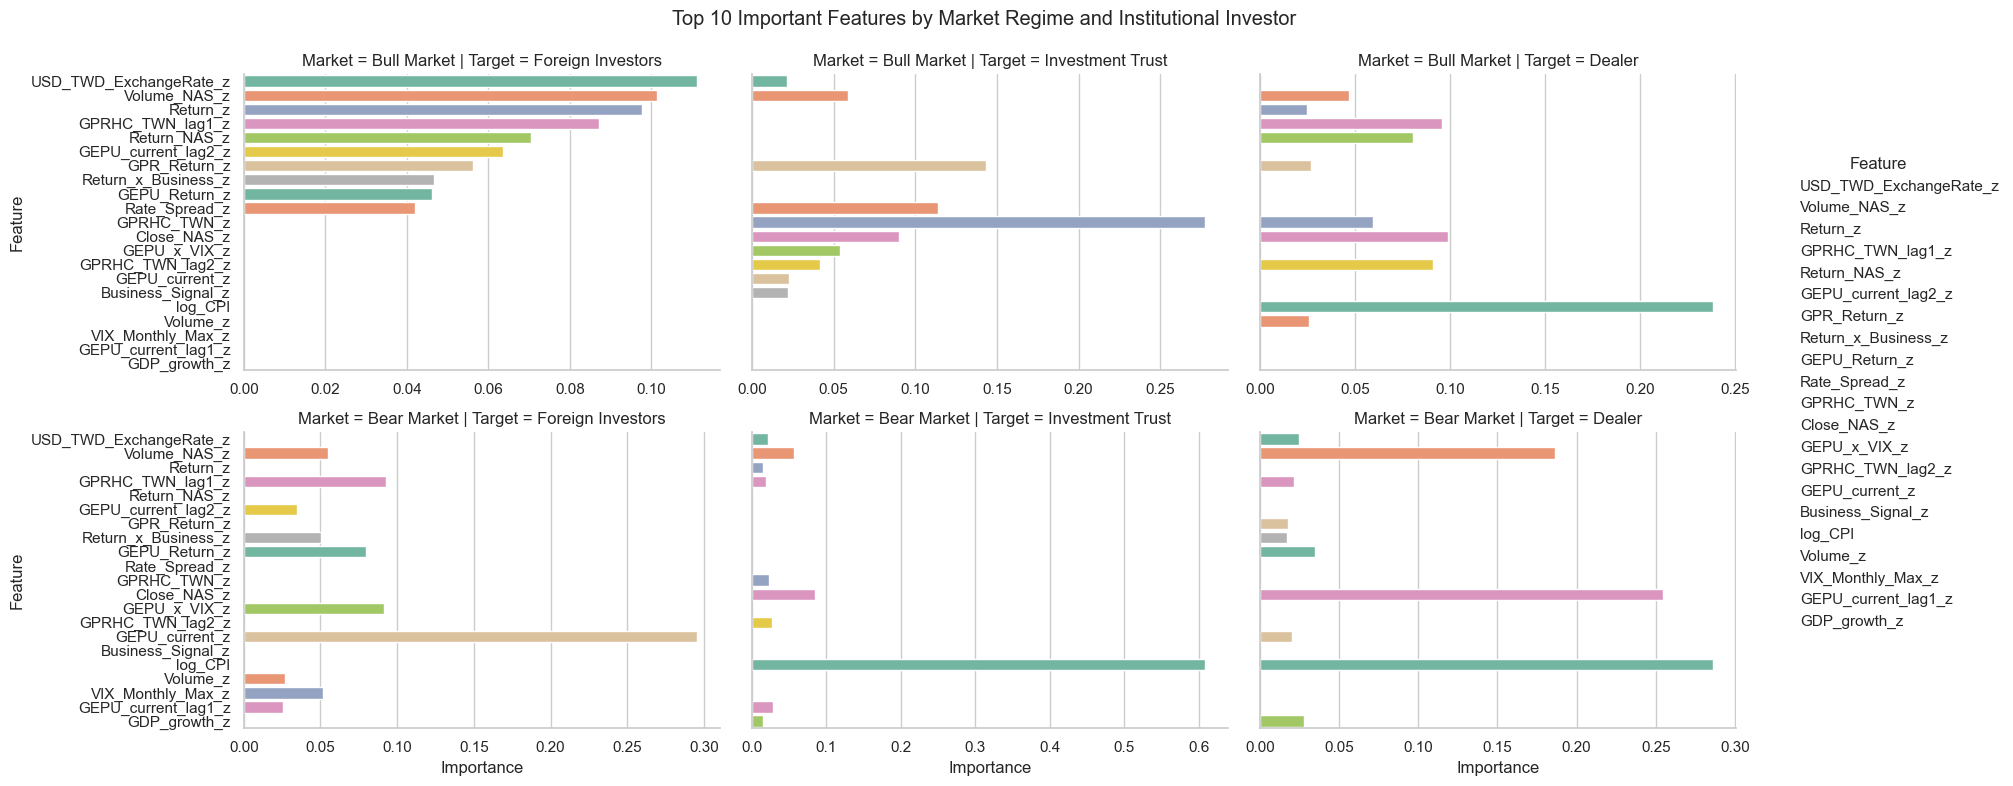

In [ ]:
importance_records = []

for market_state, label in market_states.items():
    df_market = df_scaled[df_scaled["Market_State"] == market_state]

    for target in targets:
        df_sub = df_market[all_features + [target]].dropna()
        X = df_sub[all_features]
        y = df_sub[target]

        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42
        )

        rf = RandomForestRegressor(n_estimators=100, random_state=42)
        rf.fit(X_train, y_train)
        importances = pd.Series(rf.feature_importances_, index=X_train.columns)
        top10 = importances.nlargest(10)

        for feature, score in top10.items():
            importance_records.append({
                "Market": label,
                "Target": target,
                "Feature": feature,
                "Importance": score
            })

importance_df = pd.DataFrame(importance_records)

# Top 變數重要性
g = sns.catplot(
    data=importance_df,
    x="Importance", y="Feature",
    col="Target", row="Market",
    kind="bar", height=4, aspect=1.5,
    palette="Set2", sharex=False
)
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle("Top 10 Important Features by Market Regime and Institutional Investor")
plt.show()


## Notes

去掉 VIX

- GEPU => 工具變數 (inf US stock => TW stock) (第一階段 Regression: 交成項 Ex. EPU X VIX)
- [OK] Lag return OK!
- Lag 匯率？？？？？？ Lag 其他變數？ Lag NASDAQ（參考文獻）
- 去掉 Close_NAS_z,  "Turnover_NTD"
- Macro 變數？？？？
- [OK] GPR X EPU OK!

- Y: 買賣超＆return (時間序列 Ex. VAR) / 三大法人加總 & return
- Lag1 買賣超

- (Bear Bull data) 

---------------------------------------------------------------------------------------------

## History

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# 讀取資料
df = pd.read_csv("/Users/susanlin/Desktop/Thesis/Data/for regression.csv")


log_vars = ["Volume", "Close", "Volume_NAS", "Close_NAS", "VIX_Monthly_Max"]
for col in log_vars:
    df[f"log_{col}"] = np.log(df[col] + 1)
    
# df["Foreign_ratio"] = df["Foreign Investors"] / df["Volume"]
# df["Dealer_ratio"] = df["Dealer"] / df["Volume"]
# df["Trust_ratio"] = df["Investment Trust"] / df["Volume"]


df["Return_lag1"] = df["Return"].shift(1)
# df["Foreign_ratio_lag1"] = df["Foreign_ratio"].shift(1)
# df["Dealer_ratio_lag1"] = df["Dealer_ratio"].shift(1)
# df["Trust_ratio_lag1"] = df["Trust_ratio"].shift(1)

df["GEPU_x_VIX"] = df["GEPU_current"] * df["VIX_Monthly_Max"]
df["Return_x_Business"] = df["Return"] * df["Business_Signal"]


features_to_scale = [
    "GPRHC_TWN", "GEPU_current", "Return", "Volume", "USD_TWD_ExchangeRate",
    "VIX_Monthly_Max", "Business_Signal",
    "Foreign_ratio",
    "Return_NAS", "Volume_NAS", "Close_NAS",
    "GEPU_x_VIX", "Return_x_Business"
]

scaler = StandardScaler()
df_scaled = df.copy()
df_scaled[[f"{col}_z" for col in features_to_scale]] = scaler.fit_transform(df[features_to_scale])

df_scaled.dropna(inplace=True)


In [ ]:
output_path = "/Users/susanlin/Desktop/Thesis/Data/final.csv"
df_scaled.to_csv(output_path, index=False, encoding="utf-8-sig")

In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split


import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score



# 三大法人的目標變數
targets = ["Foreign Investors", "Investment Trust", "Dealer"]

# 自變數（標準化與滯後 + 滯後的 dependent 變數本身）
base_features = [
    "GPRHC_TWN_z", "GEPU_current_z", "Return_z", "Volume_z", "USD_TWD_ExchangeRate_z",
    "VIX_Monthly_Max_z", "Business_Signal_z", "Foreign_ratio_z",
    "Return_NAS_z", "Volume_NAS_z", "Close_NAS_z", "GEPU_x_VIX_z", "Return_x_Business_z"
]

# 加入三大法人滯後變數
lagged_vars = [
    "Foreign_ratio_lag1", "Dealer_ratio_lag1", "Trust_ratio_lag1",
    "Return_lag1"
]

# 組合所有解釋變數
independent_vars = base_features + lagged_vars

# 執行迴歸對每個法人
for target in targets:
    print(f"\n==============================")
    print(f"    回歸結果：{target}")
    print(f"==============================")

    # 處理缺失值
    data = df_scaled[independent_vars + [target]].dropna()

    X = data[independent_vars]
    y = data[target]

    # 分割資料
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # 加入常數項
    X_train_const = sm.add_constant(X_train)
    X_test_const = sm.add_constant(X_test)

    # 建立模型
    model = sm.OLS(y_train, X_train_const).fit()

    # 預測與評估
    y_pred = model.predict(X_test_const)
    r2 = r2_score(y_test, y_pred)

    # 顯示結果
    print(f"\nR-squared (測試集): {r2:.4f}")
    print(model.summary())


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor

# === 三大法人 ===
targets = ["Foreign Investors", "Investment Trust", "Dealer"]

# === 所有解釋變數（請根據你的實際欄位命名確認）===
all_features = [
    "GPRHC_TWN_z", "GEPU_current_z", "Volume_z", "USD_TWD_ExchangeRate_z",
    "VIX_Monthly_Max_z", "Business_Signal_z", 
    "Volume_NAS_z", "Close_NAS_z",
    "GEPU_x_VIX_z",
    "GDP_growth_z", "Rate_Spread_z",
    "GPRHC_TWN_lag1_z", "GEPU_current_lag1_z", 
    "GPRHC_TWN_lag2_z", "GEPU_current_lag2_z",
    "Turnover_NTD", "Return_lag1",
    "GPR_GEPU", "GPR_lag1_GEPU_lag1"
]

# 最新模型！

In [ ]:
df = pd.read_csv("/Users/susanlin/Desktop/Thesis/Data/final_merged_with_macro.csv")
df.columns

Index(['Year', 'Month', 'Dealer', 'Investment Trust', 'Foreign Investors',
       'GPRHC_TWN', 'GEPU_current', 'Close', 'Volume', 'Return',
       'USD_TWD_ExchangeRate', 'VIX_Monthly_Mean', 'VIX_Month_End',
       'VIX_Monthly_Max', 'Volume_change', 'ExchangeRate_change', 'Date',
       'GPR_z', 'GEPU_z', 'GPRHC_TWN_lag1', 'GEPU_current_lag1',
       'GPRHC_TWN_lag2', 'GEPU_current_lag2', 'Market_State', 'GPR_Bull',
       'GEPU_Bull', 'GPR_Return', 'GEPU_Return', 'Business_Signal',
       'Close_NAS', 'Volume_NAS', 'Return_NAS', 'GDP_growth', 'GDP_NTD',
       'GDP_USD', 'GDP_per_capita_NTD', 'GDP_per_capita_USD', 'CPI',
       'Deposit_1M', 'Deposit_1Y', 'Loan_BaseRate'],
      dtype='object')

In [ ]:
# path = "/Users/susanlin/Desktop/Thesis/Data/final_0417.csv"
# df_scaled = pd.read_csv(path, encoding="utf-8-sig")
# df_scaled

Year  Month        Dealer  Investment Trust  Foreign Investors  \
0    2008      6 -1.059040e+10      2.477901e+08      -1.158804e+11   
1    2008      7  8.812878e+09      6.402823e+09      -1.096295e+11   
2    2008      8  4.689821e+09      1.081642e+10      -2.985458e+10   
3    2008      9 -2.423884e+09     -6.073563e+09      -9.049392e+10   
4    2008     10  3.775552e+09     -5.796489e+09      -1.145809e+11   
..    ...    ...           ...               ...                ...   
188  2024      8 -1.998826e+11      1.231823e+11      -1.347530e+11   
189  2024      9 -8.492955e+10      8.126110e+10      -9.506103e+10   
190  2024     10 -4.829849e+10      4.041347e+10       3.906549e+10   
191  2024     11 -1.167762e+11      8.501633e+10      -2.729447e+11   
192  2024     12 -3.253823e+10     -6.916221e+08       4.573943e+10   

     GPRHC_TWN  GEPU_current         Close    Volume_x    Return  ...  \
0     0.028374     88.590384   7523.505371  82064800.0 -0.127106  ...   
1     0.019361     94.517497   7024.028320  92596000.0 -0.066389  ...   
2     0.017981     90.215864   7046.078125  78415200.0  0.003139  ...   
3     0.055315    167.725195   5719.254395  80402400.0 -0.188307  ...   
4     0.045208    205.896827   4870.637695  66392400.0 -0.148379  ...   
..         ...           ...           ...         ...       ...  ...   
188   0.197922    225.378325  22268.089844  89434600.0  0.003096  ...   
189   0.200100    223.007104  22224.539062  68870900.0 -0.001956  ...   
190   0.391134    223.640869  22820.429688  61146000.0  0.026812  ...   
191   0.197694    365.206009  22262.500000  73073600.0 -0.024449  ...   
192   0.191471    377.073675  23035.099609  67916600.0  0.034704  ...   

     US_Fed_Funds_Rate  Taiwan_Discount_Rate  Interest_Rate_Spread  \
0                 2.00                 3.500                -1.500   
1                 2.01                 3.625                -1.615   
2                 2.00                 3.625                -1.625   
3                 1.81                 3.625                -1.815   
4                 0.97                 3.500                -2.530   
..                 ...                   ...                   ...   
188               5.33                 2.000                 3.330   
189               5.13                 2.000                 3.130   
190               4.83                 2.000                 2.830   
191               4.64                 2.000                 2.640   
192               4.48                 2.000                 2.480   

       Volume_y   Dealer_lag1  Investment Trust_lag1 Foreign Investors_lag1  \
0    82064800.0 -6.164625e+09           4.981936e+09           1.377714e+10   
1    92596000.0 -1.059040e+10           2.477901e+08          -1.158804e+11   
2    78415200.0  8.812878e+09           6.402823e+09          -1.096295e+11   
3    80402400.0  4.689821e+09           1.081642e+10          -2.985458e+10   
4    66392400.0 -2.423884e+09          -6.073563e+09          -9.049392e+10   
..          ...           ...                    ...                    ...   
188  89434600.0 -1.656214e+11           1.191416e+11          -3.502553e+11   
189  68870900.0 -1.998826e+11           1.231823e+11          -1.347530e+11   
190  61146000.0 -8.492955e+10           8.126110e+10          -9.506103e+10   
191  73073600.0 -4.829849e+10           4.041347e+10           3.906549e+10   
192  65344200.0 -1.167762e+11           8.501633e+10          -2.729447e+11   

        CPI   CPI_mom   log_CPI  
0     90.53       NaN  4.516667  
1     91.04  0.005633  4.522223  
2     91.27  0.002526  4.524719  
3     90.72 -0.006026  4.518740  
4     92.00  0.014109  4.532599  
..      ...       ...       ...  
188  108.34  0.003892  4.694462  
189  108.46  0.001108  4.695559  
190  108.73  0.002489  4.698023  
191  108.84  0.001012  4.699025  
192  108.82 -0.000184  4.698843  

[193 rows x 92 columns]

In [ ]:
# # path = "/Users/susanlin/Desktop/Thesis/Data/final.csv"
# df_scaled = pd.read_csv(path, encoding="utf-8-sig")
# df_scaled.head()
# GPR = 台灣 GPR
# GEPU = Global EPU

Year  Month        Dealer  Investment Trust  Foreign Investors  GPRHC_TWN  \
0  2008      4  1.839216e+10      1.537010e+10      -2.929911e+10   0.000000   
1  2008      5 -6.164625e+09      4.981936e+09       1.377714e+10   0.026743   
2  2008      6 -1.059040e+10      2.477901e+08      -1.158804e+11   0.028374   
3  2008      7  8.812878e+09      6.402823e+09      -1.096295e+11   0.019361   
4  2008      8  4.689821e+09      1.081642e+10      -2.985458e+10   0.017981   

   GEPU_current        Close       Volume    Return  ...  Volume_z  \
0     92.008066  8919.878906  119824400.0  0.040516  ...  1.927944   
1     78.120477  8619.040039  110158600.0 -0.033727  ...  1.597138   
2     88.590384  7523.505371   82064800.0 -0.127106  ...  0.635643   
3     94.517497  7024.028320   92596000.0 -0.066389  ...  0.996068   
4     90.215864  7046.078125   78415200.0  0.003139  ...  0.510738   

   USD_TWD_ExchangeRate_z  VIX_Monthly_Max_z  Business_Signal_z  \
0                0.040422          -0.088543           0.400416   
1                0.009067          -0.432913          -0.206922   
2               -0.016853          -0.063284          -0.449858   
3                0.111492           0.308871          -0.935728   
4                0.506559          -0.116329          -0.692793   

   Foreign_ratio_z  Return_NAS_z Volume_NAS_z  Close_NAS_z  GEPU_x_VIX_z  \
0        -0.101851      0.874316    -0.586593    -0.985156     -0.714841   
1         0.130985      0.626566    -0.584756    -0.962008     -0.895314   
2        -0.837400     -1.950267    -0.481817    -1.010403     -0.730058   
3        -0.693694      0.035504    -0.329773    -1.003540     -0.574447   
4        -0.187662      0.108011    -0.691418    -0.994697     -0.734950   

   Return_x_Business_z  
0             0.815866  
1            -0.823144  
2            -2.430197  
3            -1.109028  
4            -0.110296  

[5 rows x 59 columns]

In [ ]:
df_scaled = df_scaled.merge(df_cpi, on=["Year", "Month"], how="left")

In [ ]:
df_new.head()

# GPR = 台灣 GPR
# GEPU = Global EPU

Year  Month  Dealer  Investment Trust  Foreign Investors  GPRHC_TWN  \
0  2007      1     NaN               NaN                NaN        NaN   
1  2007      2     NaN               NaN                NaN        NaN   
2  2007      3     NaN               NaN                NaN        NaN   
3  2007      4     NaN               NaN                NaN        NaN   
4  2007      5     NaN               NaN                NaN        NaN   

   GEPU_current  Close  Volume  Return  ...  VIX_Month_End  VIX_Monthly_Max  \
0           NaN    NaN     NaN     NaN  ...            NaN              NaN   
1           NaN    NaN     NaN     NaN  ...            NaN              NaN   
2           NaN    NaN     NaN     NaN  ...            NaN              NaN   
3           NaN    NaN     NaN     NaN  ...            NaN              NaN   
4           NaN    NaN     NaN     NaN  ...            NaN              NaN   

   Volume_change  ExchangeRate_change  GPRHC_TWN_lag1  GEPU_current_lag1  \
0            NaN                  NaN             NaN                NaN   
1            NaN                  NaN             NaN                NaN   
2            NaN                  NaN             NaN                NaN   
3            NaN                  NaN             NaN                NaN   
4            NaN                  NaN             NaN                NaN   

   GPRHC_TWN_lag2  GEPU_current_lag2  Business_Signal    CPI  
0             NaN                NaN              NaN  85.24  
1             NaN                NaN              NaN  85.56  
2             NaN                NaN              NaN  84.56  
3             NaN                NaN              NaN  85.54  
4             NaN                NaN              NaN  85.71  

[5 rows x 22 columns]

In [ ]:
df_scaled = df_new

In [ ]:
df_scaled["Volume_lag1"] = df_scaled["Volume"].shift(1)

In [ ]:
import numpy as np
df_scaled["log_CPI"] = np.log(df_scaled["CPI"] + 1)

In [ ]:
df_scaled.columns

Index(['Year', 'Month', 'Dealer', 'Investment Trust', 'Foreign Investors',
       'GPRHC_TWN', 'GEPU_current', 'Close', 'Volume', 'Return',
       'USD_TWD_ExchangeRate', 'VIX_Monthly_Mean', 'VIX_Month_End',
       'VIX_Monthly_Max', 'Volume_change', 'ExchangeRate_change',
       'GPRHC_TWN_lag1', 'GEPU_current_lag1', 'GPRHC_TWN_lag2',
       'GEPU_current_lag2', 'Business_Signal', 'CPI', 'Volume_lag1',
       'log_CPI'],
      dtype='object')

In [ ]:
columns_to_drop = ["GPR_Bull", "Deposit_1M", "Deposit_1Y","GDP_per_capita_USD","Loan_BaseRate"]
df_scaled = df_scaled.drop(columns=columns_to_drop)


In [ ]:
taiex_daily = yf.download("^TWII", start="2007-12-01", end="2024-12-31", interval="1d")

taiex_daily["Year"] = taiex_daily.index.year
taiex_daily["Month"] = taiex_daily.index.month

# 每月平均價格
monthly_avg = taiex_daily.groupby(["Year", "Month"])["Close"].mean().reset_index()
monthly_avg = monthly_avg.sort_values(["Year", "Month"])

# 報酬率
monthly_avg["LogReturn"] = np.log(monthly_avg["Close"] / monthly_avg["Close"].shift(1))

monthly_avg = monthly_avg[["Year", "Month", "LogReturn"]]
monthly_avg.head()

monthly_avg.columns = monthly_avg.columns.droplevel(1)  

monthly_avg.head()

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Price  Year  Month  LogReturn
0      2007     12        NaN
1      2008      1  -0.047613
2      2008      2   0.009650
3      2008      3   0.053557
4      2008      4   0.050641

In [ ]:
df_scaled = pd.merge(df_scaled, monthly_avg, on=["Year", "Month"], how="outer")
df_scaled[:10]

Year  Month  Dealer  Investment Trust  Foreign Investors  GPRHC_TWN  \
0  2007      1     NaN               NaN                NaN        NaN   
1  2007      2     NaN               NaN                NaN        NaN   
2  2007      3     NaN               NaN                NaN        NaN   
3  2007      4     NaN               NaN                NaN        NaN   
4  2007      5     NaN               NaN                NaN        NaN   
5  2007      6     NaN               NaN                NaN        NaN   
6  2007      7     NaN               NaN                NaN        NaN   
7  2007      8     NaN               NaN                NaN        NaN   
8  2007      9     NaN               NaN                NaN        NaN   
9  2007     10     NaN               NaN                NaN        NaN   

   GEPU_current  Close  Volume  Return  ...  ExchangeRate_change  \
0           NaN    NaN     NaN     NaN  ...                  NaN   
1           NaN    NaN     NaN     NaN  ...                  NaN   
2           NaN    NaN     NaN     NaN  ...                  NaN   
3           NaN    NaN     NaN     NaN  ...                  NaN   
4           NaN    NaN     NaN     NaN  ...                  NaN   
5           NaN    NaN     NaN     NaN  ...                  NaN   
6           NaN    NaN     NaN     NaN  ...                  NaN   
7           NaN    NaN     NaN     NaN  ...                  NaN   
8           NaN    NaN     NaN     NaN  ...                  NaN   
9           NaN    NaN     NaN     NaN  ...                  NaN   

   GPRHC_TWN_lag1  GEPU_current_lag1  GPRHC_TWN_lag2  GEPU_current_lag2  \
0             NaN                NaN             NaN                NaN   
1             NaN                NaN             NaN                NaN   
2             NaN                NaN             NaN                NaN   
3             NaN                NaN             NaN                NaN   
4             NaN                NaN             NaN                NaN   
5             NaN                NaN             NaN                NaN   
6             NaN                NaN             NaN                NaN   
7             NaN                NaN             NaN                NaN   
8             NaN                NaN             NaN                NaN   
9             NaN                NaN             NaN                NaN   

   Business_Signal    CPI  Volume_lag1   log_CPI  LogReturn  
0              NaN  85.24          NaN  4.457134        NaN  
1              NaN  85.56          NaN  4.460838        NaN  
2              NaN  84.56          NaN  4.449218        NaN  
3              NaN  85.54          NaN  4.460607        NaN  
4              NaN  85.71          NaN  4.462569        NaN  
5              NaN  86.24          NaN  4.468663        NaN  
6              NaN  86.04          NaN  4.466368        NaN  
7              NaN  87.18          NaN  4.479380        NaN  
8              NaN  87.99          NaN  4.488524        NaN  
9              NaN  89.86          NaN  4.509320        NaN  

[10 rows x 25 columns]

In [ ]:
df_scaled["LogReturn_lag1"] = df_scaled["LogReturn"].shift(1)
df_scaled[:20]

Year  Month        Dealer  Investment Trust  Foreign Investors  GPRHC_TWN  \
0   2007      1           NaN               NaN                NaN        NaN   
1   2007      2           NaN               NaN                NaN        NaN   
2   2007      3           NaN               NaN                NaN        NaN   
3   2007      4           NaN               NaN                NaN        NaN   
4   2007      5           NaN               NaN                NaN        NaN   
5   2007      6           NaN               NaN                NaN        NaN   
6   2007      7           NaN               NaN                NaN        NaN   
7   2007      8           NaN               NaN                NaN        NaN   
8   2007      9           NaN               NaN                NaN        NaN   
9   2007     10           NaN               NaN                NaN        NaN   
10  2007     11           NaN               NaN                NaN        NaN   
11  2007     12           NaN               NaN                NaN        NaN   
12  2008      1  2.290434e+09     -4.475578e+09      -3.441877e+10   0.035619   
13  2008      2  1.208047e+10      8.634891e+09       9.830911e+10   0.027258   
14  2008      3  4.242235e+09      4.941362e+09      -1.835972e+10   0.085859   
15  2008      4  1.839216e+10      1.537010e+10      -2.929911e+10   0.000000   
16  2008      5 -6.164625e+09      4.981936e+09       1.377714e+10   0.026743   
17  2008      6 -1.059040e+10      2.477901e+08      -1.158804e+11   0.028374   
18  2008      7  8.812878e+09      6.402823e+09      -1.096295e+11   0.019361   
19  2008      8  4.689821e+09      1.081642e+10      -2.985458e+10   0.017981   

    GEPU_current        Close       Volume    Return  ...  GPRHC_TWN_lag1  \
0            NaN          NaN          NaN       NaN  ...             NaN   
1            NaN          NaN          NaN       NaN  ...             NaN   
2            NaN          NaN          NaN       NaN  ...             NaN   
3            NaN          NaN          NaN       NaN  ...             NaN   
4            NaN          NaN          NaN       NaN  ...             NaN   
5            NaN          NaN          NaN       NaN  ...             NaN   
6            NaN          NaN          NaN       NaN  ...             NaN   
7            NaN          NaN          NaN       NaN  ...             NaN   
8            NaN          NaN          NaN       NaN  ...             NaN   
9            NaN          NaN          NaN       NaN  ...             NaN   
10           NaN          NaN          NaN       NaN  ...             NaN   
11           NaN  8506.240234   81858000.0       NaN  ...             NaN   
12    135.073404  7521.095215  110618000.0 -0.115814  ...             NaN   
13    102.153158  8412.719727   66958400.0  0.118550  ...        0.035619   
14    118.181868  8572.549805  119302600.0  0.018999  ...        0.027258   
15     92.008066  8919.878906  119824400.0  0.040516  ...        0.085859   
16     78.120477  8619.040039  110158600.0 -0.033727  ...        0.000000   
17     88.590384  7523.505371   82064800.0 -0.127106  ...        0.026743   
18     94.517497  7024.028320   92596000.0 -0.066389  ...        0.028374   
19     90.215864  7046.078125   78415200.0  0.003139  ...        0.019361   

    GEPU_current_lag1  GPRHC_TWN_lag2  GEPU_current_lag2  Business_Signal  \
0                 NaN             NaN                NaN              NaN   
1                 NaN             NaN                NaN              NaN   
2                 NaN             NaN                NaN              NaN   
3                 NaN             NaN                NaN              NaN   
4                 NaN             NaN                NaN              NaN   
5                 NaN             NaN                NaN              NaN   
6                 NaN             NaN                NaN              NaN   
7                 NaN             NaN                NaN            

In [ ]:
df_scaled["Business_Signal_pct_change"] = df_scaled["Business_Signal"].pct_change()
df_scaled[:10]

Year  Month  Dealer  Investment Trust  Foreign Investors  GPRHC_TWN  \
0  2007      1     NaN               NaN                NaN        NaN   
1  2007      2     NaN               NaN                NaN        NaN   
2  2007      3     NaN               NaN                NaN        NaN   
3  2007      4     NaN               NaN                NaN        NaN   
4  2007      5     NaN               NaN                NaN        NaN   
5  2007      6     NaN               NaN                NaN        NaN   
6  2007      7     NaN               NaN                NaN        NaN   
7  2007      8     NaN               NaN                NaN        NaN   
8  2007      9     NaN               NaN                NaN        NaN   
9  2007     10     NaN               NaN                NaN        NaN   

   GEPU_current  Close  Volume  Return  ...  GEPU_current_lag1  \
0           NaN    NaN     NaN     NaN  ...                NaN   
1           NaN    NaN     NaN     NaN  ...                NaN   
2           NaN    NaN     NaN     NaN  ...                NaN   
3           NaN    NaN     NaN     NaN  ...                NaN   
4           NaN    NaN     NaN     NaN  ...                NaN   
5           NaN    NaN     NaN     NaN  ...                NaN   
6           NaN    NaN     NaN     NaN  ...                NaN   
7           NaN    NaN     NaN     NaN  ...                NaN   
8           NaN    NaN     NaN     NaN  ...                NaN   
9           NaN    NaN     NaN     NaN  ...                NaN   

   GPRHC_TWN_lag2  GEPU_current_lag2  Business_Signal    CPI  Volume_lag1  \
0             NaN                NaN              NaN  85.24          NaN   
1             NaN                NaN              NaN  85.56          NaN   
2             NaN                NaN              NaN  84.56          NaN   
3             NaN                NaN              NaN  85.54          NaN   
4             NaN                NaN              NaN  85.71          NaN   
5             NaN                NaN              NaN  86.24          NaN   
6             NaN                NaN              NaN  86.04          NaN   
7             NaN                NaN              NaN  87.18          NaN   
8             NaN                NaN              NaN  87.99          NaN   
9             NaN                NaN              NaN  89.86          NaN   

    log_CPI  LogReturn  LogReturn_lag1  Business_Signal_pct_change  
0  4.457134        NaN             NaN                         NaN  
1  4.460838        NaN             NaN                         NaN  
2  4.449218        NaN             NaN                         NaN  
3  4.460607        NaN             NaN                         NaN  
4  4.462569        NaN             NaN                         NaN  
5  4.468663        NaN             NaN                         NaN  
6  4.466368        NaN             NaN                         NaN  
7  4.479380        NaN             NaN                         NaN  
8  4.488524        NaN             NaN                         NaN  
9  4.509320        NaN             NaN                         NaN  

[10 rows x 27 columns]

In [ ]:
df_scaled.columns

Index(['Year', 'Month', 'Dealer', 'Investment Trust', 'Foreign Investors',
       'GPRHC_TWN', 'GEPU_current', 'Close', 'Volume', 'Return',
       'USD_TWD_ExchangeRate', 'VIX_Monthly_Mean', 'VIX_Month_End',
       'VIX_Monthly_Max', 'Volume_change', 'ExchangeRate_change',
       'GPRHC_TWN_lag1', 'GEPU_current_lag1', 'GPRHC_TWN_lag2',
       'GEPU_current_lag2', 'Business_Signal', 'CPI', 'Volume_lag1', 'log_CPI',
       'LogReturn', 'LogReturn_lag1', 'Business_Signal_pct_change'],
      dtype='object')

In [ ]:
print(f"資料筆數：{df_scaled.shape[0]}")
df_scaled = df_scaled.dropna()
print(f"剩餘資料筆數：{df_scaled.shape[0]}")
df_scaled

資料筆數：1503
剩餘資料筆數：193


Year  Month        Dealer  Investment Trust  Foreign Investors  \
1301  2008      6 -1.059040e+10      2.477901e+08      -1.158804e+11   
1302  2008      7  8.812878e+09      6.402823e+09      -1.096295e+11   
1303  2008      8  4.689821e+09      1.081642e+10      -2.985458e+10   
1304  2008      9 -2.423884e+09     -6.073563e+09      -9.049392e+10   
1305  2008     10  3.775552e+09     -5.796489e+09      -1.145809e+11   
...    ...    ...           ...               ...                ...   
1495  2024      8 -1.998826e+11      1.231823e+11      -1.347530e+11   
1496  2024      9 -8.492955e+10      8.126110e+10      -9.506103e+10   
1497  2024     10 -4.829849e+10      4.041347e+10       3.906549e+10   
1498  2024     11 -1.167762e+11      8.501633e+10      -2.729447e+11   
1499  2024     12 -3.253823e+10     -6.916221e+08       4.573943e+10   

      GPRHC_TWN  GEPU_current         Close    Volume_x    Return  ...  \
1301   0.028374     88.590384   7523.505371  82064800.0 -0.127106  ...   
1302   0.019361     94.517497   7024.028320  92596000.0 -0.066389  ...   
1303   0.017981     90.215864   7046.078125  78415200.0  0.003139  ...   
1304   0.055315    167.725195   5719.254395  80402400.0 -0.188307  ...   
1305   0.045208    205.896827   4870.637695  66392400.0 -0.148379  ...   
...         ...           ...           ...         ...       ...  ...   
1495   0.197922    225.378325  22268.089844  89434600.0  0.003096  ...   
1496   0.200100    223.007104  22224.539062  68870900.0 -0.001956  ...   
1497   0.391134    223.640869  22820.429688  61146000.0  0.026812  ...   
1498   0.197694    365.206009  22262.500000  73073600.0 -0.024449  ...   
1499   0.191471    377.073675  23035.099609  67916600.0  0.034704  ...   

      GPRHC_USA_lag2  twwui_lag1  twwui_lag2  LogReturn  LogReturn_lag1  \
1301        2.292959    2.192904    2.292959  -0.085505        0.003623   
1302        2.192904    2.459094    2.192904  -0.137704       -0.085505   
1303        2.459094    2.778316    2.459094  -0.007969       -0.137704   
1304        2.778316    2.535287    2.778316  -0.130862       -0.007969   
1305        2.535287    2.655112    2.535287  -0.207148       -0.130862   
...              ...         ...         ...        ...             ...   
1495        3.129183    2.545393    3.129183  -0.061579        0.034602   
1496        2.545393    3.744021    2.545393   0.001778       -0.061579   
1497        3.744021    3.401701    3.744021   0.050092        0.001778   
1498        3.401701    3.259452    3.401701  -0.007032        0.050092   
1499        3.259452    3.344316    3.259452   0.009844       -0.007032   

          Volume  Volume_lag1  Business_Signal_pct_change   GPR_GEPU  \
1301  82064800.0  110158600.0                   -0.090909   2.513678   
1302  92596000.0   82064800.0                   -0.200000   1.829961   
1303  78415200.0   92596000.0                    0.125000   1.622150   
1304  80402400.0   78415200.0                   -0.333333   9.277692   
1305  66392400.0   80402400.0                    0.000000   9.308174   
...          ...          ...                         ...        ...   
1495  89434600.0  106604500.0                    0.114286  44.607290   
1496  68870900.0   89434600.0                   -0.128205  44.623733   
1497  61146000.0   68870900.0                   -0.058824  87.473613   
1498  73073600.0   61146000.0                    0.062500  72.198880   
1499  65344200.0   73073600.0                    0.117647  72.198616   

      GPR_lag1_GEPU_lag1  
1301            2.089155  
1302            2.513678  
1303            1.829961  
1304            1.622150  
1305            9.277692  
...                  ...  
1495           23.643205  
1496           44.607290  
1497           44.623733  
1498           87.473613  
1499           72.198880  

[193 rows x 106 columns]

In [ ]:
print(f"資料筆數：{df_standardized.shape[0]}")
df_standardized = df_standardized.dropna()
print(f"剩餘資料筆數：{df_standardized.shape[0]}")
df_standardized

資料筆數：1503
剩餘資料筆數：193


Year  Month        Dealer  Investment Trust  Foreign Investors  \
1301  2008      6 -1.059040e+10      2.477901e+08      -1.158804e+11   
1302  2008      7  8.812878e+09      6.402823e+09      -1.096295e+11   
1303  2008      8  4.689821e+09      1.081642e+10      -2.985458e+10   
1304  2008      9 -2.423884e+09     -6.073563e+09      -9.049392e+10   
1305  2008     10  3.775552e+09     -5.796489e+09      -1.145809e+11   
...    ...    ...           ...               ...                ...   
1495  2024      8 -1.998826e+11      1.231823e+11      -1.347530e+11   
1496  2024      9 -8.492955e+10      8.126110e+10      -9.506103e+10   
1497  2024     10 -4.829849e+10      4.041347e+10       3.906549e+10   
1498  2024     11 -1.167762e+11      8.501633e+10      -2.729447e+11   
1499  2024     12 -3.253823e+10     -6.916221e+08       4.573943e+10   

      GPRHC_TWN  GEPU_current         Close    Volume_x    Return  ...  \
1301  -0.498892     -1.332659   7523.505371  82064800.0 -0.127106  ...   
1302  -0.577369     -1.251817   7024.028320  92596000.0 -0.066389  ...   
1303  -0.589388     -1.310488   7046.078125  78415200.0  0.003139  ...   
1304  -0.264317     -0.253311   5719.254395  80402400.0 -0.188307  ...   
1305  -0.352319      0.267325   4870.637695  66392400.0 -0.148379  ...   
...         ...           ...           ...         ...       ...  ...   
1495   0.977372      0.533040  22268.089844  89434600.0  0.003096  ...   
1496   0.996338      0.500698  22224.539062  68870900.0 -0.001956  ...   
1497   2.659687      0.509342  22820.429688  61146000.0  0.026812  ...   
1498   0.975385      2.440198  22262.500000  73073600.0 -0.024449  ...   
1499   0.921203      2.602065  23035.099609  67916600.0  0.034704  ...   

      twwui_lag2  LogReturn  LogReturn_lag1      Volume  Volume_lag1  \
1301   -0.717829  -0.085505       -0.033893  82064800.0     1.632245   
1302   -0.863837  -0.137704       -2.008877  92596000.0     0.656532   
1303   -0.475393  -0.007969       -3.165539  78415200.0     1.022286   
1304   -0.009560  -0.130862       -0.290758  80402400.0     0.529780   
1305   -0.364206  -0.207148       -3.013927  66392400.0     0.598796   
...          ...        ...             ...         ...          ...   
1495    0.502452  -0.061579        0.652572  89434600.0     1.508809   
1496   -0.349459   0.001778       -1.478693  68870900.0     0.912489   
1497    1.399670   0.050092       -0.074787  61146000.0     0.198301   
1498    0.900130  -0.007032        0.995811  73073600.0    -0.069989   
1499    0.692551   0.009844       -0.270007  65344200.0     0.344263   

      Business_Signal_pct_change   GPR_GEPU  GPR_lag1_GEPU_lag1     usepu_y  \
1301                   -0.835983   2.513678            2.089155   89.136883   
1302                   -1.738936   1.829961            2.513678  115.102724   
1303                    0.951111   1.622150            1.829961   81.163078   
1304                   -2.842545   9.277692            1.622150  238.171874   
1305                   -0.083522   9.308174            9.277692  241.772278   
...                          ...        ...                 ...         ...   
1495                    0.862428  44.607290           23.643205  138.366425   
1496                   -1.144685  44.623733           44.607290  127.399121   
1497                   -0.570409  87.473613           44.623733  109.290889   
1498                    0.433794  72.198880           87.473613  225.049031   
1499                    0.890250  72.198616           72.198880  218.845481   

      GPRHC_USA_y  
1301     2.459094  
1302     2.778316  
1303     2.535287  
1304     2.655112  
1305     1.835443  
...           ...  
1495     3.744021  
1496     3.401701  
1497     3.259452  
1498     3.344316  
1499     4.055701  

[193 rows x 108 columns]

In [ ]:
df_scaled["usepu_lag1"] = df_scaled["usepu"].shift(1)
df_scaled["usepu_lag2"] = df_scaled["usepu"].shift(2)

df_scaled["GPRHC_USA_lag1"] = df_scaled["GPRHC_USA"].shift(1)
df_scaled["GPRHC_USA_lag2"] = df_scaled["GPRHC_USA"].shift(2)

df_scaled["twwui_lag1"] = df_scaled["GPRHC_USA"].shift(1)
df_scaled["twwui_lag2"] = df_scaled["GPRHC_USA"].shift(2)

In [ ]:
df_scaled.columns

Index(['Year', 'Month', 'Dealer', 'Investment Trust', 'Foreign Investors',
       'GPRHC_TWN', 'GEPU_current', 'Close', 'Volume', 'Return',
       'USD_TWD_ExchangeRate', 'VIX_Monthly_Mean', 'VIX_Month_End',
       'VIX_Monthly_Max', 'GPRHC_TWN_lag1', 'GEPU_current_lag1',
       'GPRHC_TWN_lag2', 'GEPU_current_lag2', 'Business_Signal', 'Volume_lag1',
       'CPI', 'log_CPI', 'LogReturn', 'LogReturn_lag1',
       'Business_Signal_pct_change', 'usepu', 'GPRHC_USA', 'twwui',
       'usepu_lag1', 'usepu_lag2', 'GPRHC_USA_lag1', 'GPRHC_USA_lag2',
       'twwui_lag1', 'twwui_lag2'],
      dtype='object')

In [ ]:
# df_scaled.drop(columns=["GPR_lag1_usepu_lag1","usGPR_lag1_usepu_lag1","GPR_lag1_twwui_lag1"], inplace=True)
df_scaled

Year  Month        Dealer  Investment Trust  Foreign Investors  \
0     1900      1           NaN               NaN                NaN   
1     1900      2           NaN               NaN                NaN   
2     1900      3           NaN               NaN                NaN   
3     1900      4           NaN               NaN                NaN   
4     1900      5           NaN               NaN                NaN   
...    ...    ...           ...               ...                ...   
1498  2024     11 -1.167762e+11      8.501633e+10      -2.729447e+11   
1499  2024     12 -3.253823e+10     -6.916221e+08       4.573943e+10   
1500  2025      1           NaN               NaN                NaN   
1501  2025      2           NaN               NaN                NaN   
1502  2025      3           NaN               NaN                NaN   

      GPRHC_TWN  GEPU_current         Close      Volume    Return  ...  \
0           NaN           NaN           NaN         NaN       NaN  ...   
1           NaN           NaN           NaN         NaN       NaN  ...   
2           NaN           NaN           NaN         NaN       NaN  ...   
3           NaN           NaN           NaN         NaN       NaN  ...   
4           NaN           NaN           NaN         NaN       NaN  ...   
...         ...           ...           ...         ...       ...  ...   
1498   0.197694    365.206009  22262.500000  73073600.0 -0.024449  ...   
1499   0.191471    377.073675  23035.099609  67916600.0  0.034704  ...   
1500        NaN           NaN           NaN         NaN       NaN  ...   
1501        NaN           NaN           NaN         NaN       NaN  ...   
1502        NaN           NaN           NaN         NaN       NaN  ...   

      Business_Signal_pct_change       usepu  GPRHC_USA     twwui  usepu_lag1  \
0                            NaN         NaN   2.718799       NaN         NaN   
1                            NaN         NaN   2.732469       NaN         NaN   
2                            NaN         NaN   2.151507       NaN         NaN   
3                            NaN         NaN   1.776175       NaN         NaN   
4                            NaN         NaN   1.970109       NaN         NaN   
...                          ...         ...        ...       ...         ...   
1498                    0.062500  225.049031   3.344316  0.209088  109.290889   
1499                    0.117647  218.845481   4.055701  0.203901  225.049031   
1500                   -0.078947  236.787068   3.367398  0.202211  218.845481   
1501                    0.057143  329.305146   3.187533  0.123701  236.787068   
1502                         NaN  446.027858        NaN  0.123701  329.305146   

      usepu_lag2  GPRHC_USA_lag1  GPRHC_USA_lag2  twwui_lag1  twwui_lag2  
0            NaN             NaN             NaN         NaN         NaN  
1            NaN        2.718799             NaN    2.718799         NaN  
2            NaN        2.732469        2.718799    2.732469    2.718799  
3            NaN        2.151507        2.732469    2.151507    2.732469  
4            NaN        1.776175        2.151507    1.776175    2.151507  
...          ...             ...             ...         ...         ...  
1498  127.399121        3.259452        3.401701    3.259452    3.401701  
1499  109.290889        3.344316        3.259452    3.344316    3.259452  
1500  225.049031        4.055701        3.344316    4.055701    3.344316  
1501  218.845481        3.367398        4.055701    3.367398    4.055701  
1502  236.787068        3.187533        3.367398    3.187533    3.367398  

[1503 rows x 34 columns]

In [ ]:
# df_scaled["GPR_lag1_usepu_lag1"] = df_scaled["GPRHC_TWN_lag1"] * df_scaled["usepu_lag1"]
# df_scaled["usGPR_lag1_usepu_lag1"] = df_scaled["GPRHC_USA_lag1"] * df_scaled["usepu_lag1"]
# df_scaled["GPR_lag1_twwui_lag1"] = df_scaled["GPRHC_TWN_lag1"] * df_scaled["twwui_lag1"]

# df_scaled["GPR_lag1_GEPU_lag1"] = df_scaled["GPRHC_TWN_lag1"] * df_scaled["GEPU_current_lag1"]

/var/folders/m3/4kw7w40s6p56xt563fshsjjh0000gn/T/ipykernel_677/1569180683.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_scaled["GPR_lag1_usepu_lag1"] = df_scaled["GPRHC_TWN_lag1"] * df_scaled["usepu_lag1"]
/var/folders/m3/4kw7w40s6p56xt563fshsjjh0000gn/T/ipykernel_677/1569180683.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_scaled["usGPR_lag1_usepu_lag1"] = df_scaled["GPRHC_USA_lag1"] * df_scaled["usepu_lag1"]
/var/folders/m3/4kw7w40s6p56xt563fshsjjh0000gn/T/ipykernel_677/1569180683.py:3: 

### 1. 台灣 GPR + Global EPU  , w/ 美國 VIX

In [ ]:
# import statsmodels.api as sm
# models = {
#     "Lag": [
#         "GPRHC_TWN_lag1", "GEPU_current_lag1",
#         "GPRHC_TWN_lag2", "GEPU_current_lag2",
#         "LogReturn_lag1", "Volume_lag1",
#         "GPR_lag1_GEPU_lag1",
#         "Business_Signal_pct_change"
#     ],
#     "Full: Lag + Interactions": [
#         "GPRHC_TWN_lag1", "GEPU_current_lag1",
#         "GPRHC_TWN_lag2", "GEPU_current_lag2",
#         "LogReturn_lag1", "Volume_lag1",
#         "GPR_lag1_GEPU_lag1",
#         "VIX_Monthly_Max",
#         "Business_Signal_pct_change"
#     ]
# }


# # 三大法人  
# targets = [
#     "Foreign Investors",
#     "Investment Trust",
#     "Dealer"
# ]


# for target in targets:
#     print(f"\n===================================")
#     print(f"      回歸結果：{target}")
#     print(f"===================================")
    
#     for model_name, var_list in models.items():
#         print(f"\n--- Model: {model_name} ---")
#         data = df_scaled[var_list + [target]].dropna()
#         X = sm.add_constant(data[var_list])
#         y = data[target]
#         model = sm.OLS(y, X).fit()
#         print(model.summary())


      回歸結果：Foreign Investors

--- Model: Lag ---
                            OLS Regression Results                            
Dep. Variable:      Foreign Investors   R-squared:                       0.077
Model:                            OLS   Adj. R-squared:                  0.038
Method:                 Least Squares   F-statistic:                     1.952
Date:                Thu, 17 Apr 2025   Prob (F-statistic):             0.0547
Time:                        10:21:09   Log-Likelihood:                -5193.1
No. Observations:                 195   AIC:                         1.040e+04
Df Residuals:                     186   BIC:                         1.043e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

X = df_scaled[[
        "GPRHC_TWN_lag1", "GEPU_current_lag1",
        "GPRHC_TWN_lag2", "GEPU_current_lag2",
        "LogReturn_lag1", "Volume_lag1",
        "VIX_Monthly_Max",
        "Business_Signal_pct_change",
        "sp500LogReturn","hsiLogReturn","nikkeiLogReturn","USD_TWD_ExchangeRate", "Gold_Monthly_AvgPrice", "Interest_Rate_Spread","log_CPI"
    ]]
        
X = sm.add_constant(X)
vif = pd.DataFrame()
vif["feature"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif

KeyError: "['sp500LogReturn', 'hsiLogReturn', 'nikkeiLogReturn', 'Gold_Monthly_AvgPrice', 'Interest_Rate_Spread'] not in index"


========== Foreign Investors ==========

▶️ Model Spec: Full
                            OLS Regression Results                            
Dep. Variable:      Foreign Investors   R-squared:                       0.470
Model:                            OLS   Adj. R-squared:                  0.414
Method:                 Least Squares   F-statistic:                     8.458
Date:                Wed, 16 Apr 2025   Prob (F-statistic):           6.12e-16
Time:                        09:34:28   Log-Likelihood:                -5035.1
No. Observations:                 191   AIC:                         1.011e+04
Df Residuals:                     172   BIC:                         1.017e+04
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.928e+23, tolerance: 1.451e+20
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=5.4503e-25): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T



========== Investment Trust ==========

▶️ Model Spec: Full
                            OLS Regression Results                            
Dep. Variable:       Investment Trust   R-squared:                       0.494
Model:                            OLS   Adj. R-squared:                  0.441
Method:                 Least Squares   F-statistic:                     9.314
Date:                Wed, 16 Apr 2025   Prob (F-statistic):           1.67e-17
Time:                        09:34:28   Log-Likelihood:                -4776.3
No. Observations:                 191   AIC:                             9591.
Df Residuals:                     172   BIC:                             9652.
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.306e+22, tolerance: 7.393e+18
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=5.4503e-25): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T



========== Dealer ==========

▶️ Model Spec: Full
                            OLS Regression Results                            
Dep. Variable:                 Dealer   R-squared:                       0.514
Model:                            OLS   Adj. R-squared:                  0.464
Method:                 Least Squares   F-statistic:                     10.13
Date:                Wed, 16 Apr 2025   Prob (F-statistic):           6.17e-19
Time:                        09:34:29   Log-Likelihood:                -4803.3
No. Observations:                 191   AIC:                             9645.
Df Residuals:                     172   BIC:                             9706.
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.403e+22, tolerance: 1.498e+19
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=5.4503e-25): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


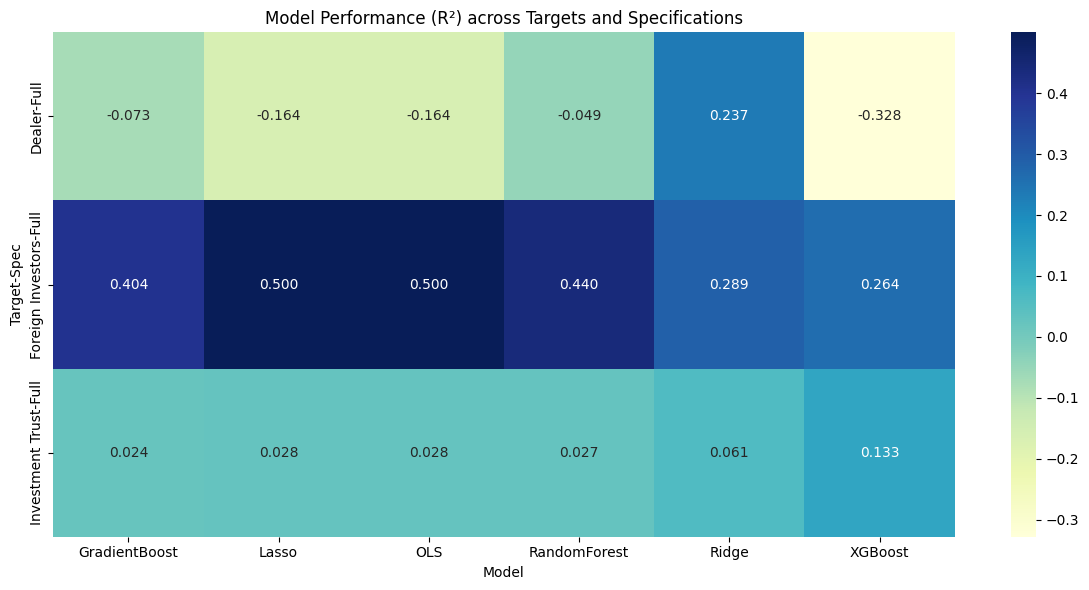

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import Lasso, Ridge, LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns


models_config = {
    "Full": [
        "GPRHC_TWN_lag1", "GEPU_current_lag1",
        "GPRHC_TWN_lag2", "GEPU_current_lag2",
        "LogReturn_lag1", "Volume_lag1",
        "VIX_Monthly_Max",
        "GPR_lag1_GEPU_lag1",
        "Business_Signal_pct_change",
        "sp500LogReturn","hsiLogReturn","nikkeiLogReturn","USD_TWD_ExchangeRate", "Gold_Monthly_AvgPrice", "Interest_Rate_Spread",
        "Dealer_lag1", "Investment Trust_lag1", "Foreign Investors_lag1"
    ],    
}



targets = ["Foreign Investors", "Investment Trust", "Dealer"]


ml_models = {
    "OLS": LinearRegression(),
    "Lasso": Lasso(alpha=0.01),
    "Ridge": Ridge(alpha=1.0),
    "RandomForest": RandomForestRegressor(n_estimators=100, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=100, random_state=42, verbosity=0),
    "GradientBoost": GradientBoostingRegressor(n_estimators=100, random_state=42)
}

results = []


for target in targets:
    print(f"\n========== {target} ==========")
    
    for model_name, feature_list in models_config.items():
        print(f"\n Model Spec: {model_name}")
        
        data = df_scaled[feature_list + [target]].dropna()
        X = data[feature_list]
        y = data[target]

        # OLS 
        X_sm = sm.add_constant(X)
        model_sm = sm.OLS(y, X_sm).fit()
        print(model_sm.summary())

        # 資料切分
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.1, random_state=42
        )

        for algo_name, algo_model in ml_models.items():
            algo_model.fit(X_train, y_train)
            y_pred = algo_model.predict(X_test)
            r2 = r2_score(y_test, y_pred)

            results.append({
                "Target": target,
                "Spec": model_name,
                "Model": algo_name,
                "R2": round(r2, 4)
            })


results_df = pd.DataFrame(results)
pivot = results_df.pivot_table(index=["Target", "Spec"], columns="Model", values="R2")

plt.figure(figsize=(12, 6))
sns.heatmap(pivot, annot=True, fmt=".3f", cmap="YlGnBu")
plt.title("Model Performance (R²) across Targets and Specifications")
plt.tight_layout()
plt.show()


In [ ]:
df_scaled.columns

Index(['Year', 'Month', 'Dealer', 'Investment Trust', 'Foreign Investors',
       'GPRHC_TWN', 'GEPU_current', 'Close', 'Volume', 'Return',
       'USD_TWD_ExchangeRate', 'VIX_Monthly_Mean', 'VIX_Month_End',
       'VIX_Monthly_Max', 'Volume_change', 'ExchangeRate_change', 'Date',
       'GPR_z', 'GEPU_z', 'GPRHC_TWN_lag1', 'GEPU_current_lag1',
       'GPRHC_TWN_lag2', 'GEPU_current_lag2', 'Market_State', 'GPR_Bull',
       'GEPU_Bull', 'GPR_Return', 'GEPU_Return', 'Business_Signal',
       'Close_NAS', 'Volume_NAS', 'Return_NAS', 'log_Volume', 'log_Close',
       'log_Volume_NAS', 'log_Close_NAS', 'log_VIX_Monthly_Max',
       'Foreign_ratio', 'Dealer_ratio', 'Trust_ratio', 'Return_lag1',
       'Foreign_ratio_lag1', 'Dealer_ratio_lag1', 'Trust_ratio_lag1',
       'GEPU_x_VIX', 'Return_x_Business', 'GPRHC_TWN_z', 'GEPU_current_z',
       'Return_z', 'Volume_z', 'USD_TWD_ExchangeRate_z', 'VIX_Monthly_Max_z',
       'Business_Signal_z', 'Foreign_ratio_z', 'Return_NAS_z', 'Volume_NAS_z',

#### 加上控制變數


三大法人對於匯率、利差、標普500指數報酬率、香港恆生指數報酬率、日經225指數報酬率、金價及前一期台灣加權股價指數有著較高的關注度
https://ndltd.ncl.edu.tw/cgi-bin/gs32/gsweb.cgi/login?o=dnclcdr&s=id%3D%22112NTHU5304018%22.&searchmode=basic


##### S&P 500 return

In [ ]:
sp500 = yf.download('^GSPC', start="2007-12-01", end='2025-04-30', interval='1d')

sp500["Year"] = sp500.index.year
sp500["Month"] = sp500.index.month

monthly_avg = sp500.groupby(["Year", "Month"])["Close"].mean().reset_index()
monthly_avg = monthly_avg.sort_values(["Year", "Month"])

monthly_avg["sp500LogReturn"] = np.log(monthly_avg["Close"] / monthly_avg["Close"].shift(1))

sp500LogReturn = monthly_avg[["Year", "Month", "sp500LogReturn"]]

sp500LogReturn.head()
sp500LogReturn.columns = sp500LogReturn.columns.droplevel(1) 

sp500LogReturn.head()

[*********************100%***********************]  1 of 1 completed


Price  Year  Month  sp500LogReturn
0      2007     12             NaN
1      2008      1       -0.070330
2      2008      2       -0.017480
3      2008      3       -0.028394
4      2008      4        0.039840

In [ ]:
df_scaled = pd.merge(df_scaled, sp500LogReturn, on=["Year", "Month"], how="outer")

##### 香港恆生 return

In [ ]:
hsi = yf.download('^HSI', start="2007-12-01", end='2025-04-30', interval='1d')

hsi["Year"] = hsi.index.year
hsi["Month"] = hsi.index.month

monthly_avg = hsi.groupby(["Year", "Month"])["Close"].mean().reset_index()
monthly_avg = monthly_avg.sort_values(["Year", "Month"])

monthly_avg["hsiLogReturn"] = np.log(monthly_avg["Close"] / monthly_avg["Close"].shift(1))


hsiLogReturn = monthly_avg[["Year", "Month", "hsiLogReturn"]]

hsiLogReturn.columns = hsiLogReturn.columns.droplevel(1) 

hsiLogReturn.head()

[*********************100%***********************]  1 of 1 completed


Price  Year  Month  hsiLogReturn
0      2007     12           NaN
1      2008      1     -0.099278
2      2008      2     -0.063122
3      2008      3     -0.055479
4      2008      4      0.086419

In [ ]:
df_scaled = pd.merge(df_scaled, hsiLogReturn, on=["Year", "Month"], how="outer")

##### 日經225 return

In [ ]:
nikkei = yf.download('^N225', start="2007-12-01", end='2025-04-30', interval='1d')

nikkei["Year"] = nikkei.index.year
nikkei["Month"] = nikkei.index.month

monthly_avg = nikkei.groupby(["Year", "Month"])["Close"].mean().reset_index()
monthly_avg = monthly_avg.sort_values(["Year", "Month"])

monthly_avg["nikkeiLogReturn"] = np.log(monthly_avg["Close"] / monthly_avg["Close"].shift(1))


nikkeiLogReturn = monthly_avg[["Year", "Month", "nikkeiLogReturn"]]
nikkeiLogReturn.columns = nikkeiLogReturn.columns.droplevel(1) 
nikkeiLogReturn.head()

[*********************100%***********************]  1 of 1 completed


Price  Year  Month  nikkeiLogReturn
0      2007     12              NaN
1      2008      1        -0.124065
2      2008      2        -0.013451
3      2008      3        -0.072298
4      2008      4         0.058164

In [ ]:
df_scaled = pd.merge(df_scaled, nikkeiLogReturn, on=["Year", "Month"], how="outer")

##### 匯率

##### 金價

In [ ]:
# 黃金期貨日資料
gold = yf.download('GC=F', start="2007-12-01", end='2025-04-30', interval='1d')

gold["Year"] = gold.index.year
gold["Month"] = gold.index.month

gold_monthly = gold.groupby(["Year", "Month"])["Close"].mean().reset_index()
gold_monthly = gold_monthly.sort_values(["Year", "Month"])
gold_monthly.rename(columns={"Close": "Gold_Monthly_AvgPrice"}, inplace=True)

gold_monthly.columns = gold_monthly.columns.droplevel(1) 

gold_monthly

[*********************100%***********************]  1 of 1 completed


Price  Year  Month  Gold_Monthly_AvgPrice
0      2007     12             807.959998
1      2008      1             891.357134
2      2008      2             925.110001
3      2008      3             962.930002
4      2008      4             909.663638
..      ...    ...                    ...
204    2024     12            2643.580950
205    2025      1            2722.947626
206    2025      2            2897.115800
207    2025      3            2986.409528
208    2025      4            3124.958313

[209 rows x 3 columns]

In [ ]:
df_scaled = pd.merge(df_scaled, gold_monthly, on=["Year", "Month"], how="outer")

##### 台美利差

In [ ]:
# Fed Fund Rate
import pandas_datareader.data as web

start = "2007-12-01"
end = '2025-04-30'

us_rate = web.DataReader('FEDFUNDS', 'fred', start, end)

us_rate = us_rate.reset_index()

us_rate['Year'] = us_rate['DATE'].dt.year
us_rate['Month'] = us_rate['DATE'].dt.month

us_rate_monthly = us_rate.groupby(['Year', 'Month'])['FEDFUNDS'].mean().reset_index()
us_rate_monthly.rename(columns={'FEDFUNDS': 'US_Fed_Funds_Rate'}, inplace=True)

us_rate_monthly.head()

Year  Month  US_Fed_Funds_Rate
0  2007     12               4.24
1  2008      1               3.94
2  2008      2               2.98
3  2008      3               2.61
4  2008      4               2.28

In [ ]:
# TW重貼現率
# https://www.cbc.gov.tw/tw/lp-370-1-2-20.html

tw_discount_rate_data = {
    "Effective_Date": [
        "2007-12-21", "2008-03-28", "2008-06-27", "2008-09-26", "2008-10-09",
        "2008-10-30", "2008-11-10", "2008-12-12", "2009-01-08", "2009-02-19",
        "2010-06-25", "2010-10-01", "2010-12-31", "2011-04-01", "2011-07-01",
        "2015-09-25", "2015-12-18", "2016-03-25", "2016-07-01", "2020-03-20",
        "2022-03-18", "2022-06-17", "2022-09-23", "2022-12-16", "2023-03-24",
        "2024-03-22"
    ],
    "Rate": [
        3.375, 3.5, 3.625, 3.5, 3.25,
        3.0, 2.75, 2.0, 1.5, 1.25,
        1.375, 1.5, 1.625, 1.75, 1.875,
        1.75, 1.625, 1.5, 1.375, 1.125,
        1.375, 1.5, 1.625, 1.75, 1.875,
        2.0
    ]
}

tw_rate_df = pd.DataFrame(tw_discount_rate_data)
tw_rate_df["Effective_Date"] = pd.to_datetime(tw_rate_df["Effective_Date"])

date_range = pd.date_range(start="2007-12-31", end="2025-04-30", freq="MS")
df_monthly = pd.DataFrame({"DATE": date_range})

df_monthly["Taiwan_Discount_Rate"] = df_monthly["DATE"].apply(
    lambda x: tw_rate_df[tw_rate_df["Effective_Date"] <= x]["Rate"].iloc[-1]
)

df_monthly["Year"] = df_monthly["DATE"].dt.year
df_monthly["Month"] = df_monthly["DATE"].dt.month

df_rate_month = df_monthly[["Year", "Month", "Taiwan_Discount_Rate"]].copy()

df_rate_month.head()

Year  Month  Taiwan_Discount_Rate
0  2008      1                 3.375
1  2008      2                 3.375
2  2008      3                 3.375
3  2008      4                 3.500
4  2008      5                 3.500

In [ ]:
# 台美利差
interest_rate_df = pd.merge(us_rate_monthly, df_rate_month, on=["Year", "Month"], how="left")

interest_rate_df["Interest_Rate_Spread"] = interest_rate_df["US_Fed_Funds_Rate"] - interest_rate_df["Taiwan_Discount_Rate"]

interest_rate_df.head()


Year  Month  US_Fed_Funds_Rate  Taiwan_Discount_Rate  Interest_Rate_Spread
0  2007     12               4.24                   NaN                   NaN
1  2008      1               3.94                 3.375                 0.565
2  2008      2               2.98                 3.375                -0.395
3  2008      3               2.61                 3.375                -0.765
4  2008      4               2.28                 3.500                -1.220

In [ ]:
df_scaled = pd.merge(df_scaled, interest_rate_df, on=["Year", "Month"], how="outer")

##### 台股月交易量

In [ ]:
taiex_daily = yf.download("^TWII", start="2007-12-01", end="2024-12-31", interval="1d")
taiex_daily["Year"] = taiex_daily.index.year
taiex_daily["Month"] = taiex_daily.index.month

monthly_volume = taiex_daily.groupby(["Year", "Month"])["Volume"].sum().reset_index()

monthly_volume.columns = monthly_volume.columns.droplevel(1) 

monthly_volume

[*********************100%***********************]  1 of 1 completed


Price  Year  Month     Volume
0      2007     12   81858000
1      2008      1  110618000
2      2008      2   66958400
3      2008      3  119302600
4      2008      4  119824400
..      ...    ...        ...
200    2024      8   89434600
201    2024      9   68870900
202    2024     10   61146000
203    2024     11   73073600
204    2024     12   65344200

[205 rows x 3 columns]

In [ ]:
df_scaled = pd.merge(df_scaled, monthly_volume, on=["Year", "Month"], how="outer")
df_scaled

Year  Month        Dealer  Investment Trust  Foreign Investors  \
0     1900      1           NaN               NaN                NaN   
1     1900      2           NaN               NaN                NaN   
2     1900      3           NaN               NaN                NaN   
3     1900      4           NaN               NaN                NaN   
4     1900      5           NaN               NaN                NaN   
...    ...    ...           ...               ...                ...   
1498  2024     11 -1.167762e+11      8.501633e+10      -2.729447e+11   
1499  2024     12 -3.253823e+10     -6.916221e+08       4.573943e+10   
1500  2025      1           NaN               NaN                NaN   
1501  2025      2           NaN               NaN                NaN   
1502  2025      3           NaN               NaN                NaN   

      GPRHC_TWN  GEPU_current         Close    Volume_x    Return  ...  \
0           NaN           NaN           NaN         NaN       NaN  ...   
1           NaN           NaN           NaN         NaN       NaN  ...   
2           NaN           NaN           NaN         NaN       NaN  ...   
3           NaN           NaN           NaN         NaN       NaN  ...   
4           NaN           NaN           NaN         NaN       NaN  ...   
...         ...           ...           ...         ...       ...  ...   
1498   0.197694    365.206009  22262.500000  73073600.0 -0.024449  ...   
1499   0.191471    377.073675  23035.099609  67916600.0  0.034704  ...   
1500        NaN           NaN           NaN         NaN       NaN  ...   
1501        NaN           NaN           NaN         NaN       NaN  ...   
1502        NaN           NaN           NaN         NaN       NaN  ...   

         twwui  usepu_lag1  usepu_lag2  GPRHC_USA_lag1  GPRHC_USA_lag2  \
0          NaN         NaN         NaN             NaN             NaN   
1          NaN         NaN         NaN        2.718799             NaN   
2          NaN         NaN         NaN        2.732469        2.718799   
3          NaN         NaN         NaN        2.151507        2.732469   
4          NaN         NaN         NaN        1.776175        2.151507   
...        ...         ...         ...             ...             ...   
1498  0.209088  109.290889  127.399121        3.259452        3.401701   
1499  0.203901  225.049031  109.290889        3.344316        3.259452   
1500  0.202211  218.845481  225.049031        4.055701        3.344316   
1501  0.123701  236.787068  218.845481        3.367398        4.055701   
1502  0.123701  329.305146  236.787068        3.187533        3.367398   

      twwui_lag1 twwui_lag2  LogReturn  LogReturn_lag1      Volume  
0            NaN        NaN        NaN             NaN         NaN  
1       2.718799        NaN        NaN             NaN         NaN  
2       2.732469   2.718799        NaN             NaN         NaN  
3       2.151507   2.732469        NaN             NaN         NaN  
4       1.776175   2.151507        NaN             NaN         NaN  
...          ...        ...        ...             ...         ...  
1498    3.259452   3.401701  -0.007032        0.050092  73073600.0  
1499    3.344316   3.259452   0.009844       -0.007032  65344200.0  
1500    4.055701   3.344316        NaN        0.009844         NaN  
1501    3.367398   4.055701        NaN             NaN         NaN  
1502    3.187533   3.367398        NaN             NaN         NaN  

[1503 rows x 102 columns]

##### 前一期法人行為

In [ ]:
df_scaled["Dealer_lag1"] = df_scaled["Dealer"].shift(1)
df_scaled["Investment Trust_lag1"] = df_scaled["Investment Trust"].shift(1)
df_scaled["Foreign Investors_lag1"] = df_scaled["Foreign Investors"].shift(1)

##### Try

In [ ]:
print(df_scaled.columns)

Index(['Year', 'Month', 'Dealer', 'Investment Trust', 'Foreign Investors',
       'GPRHC_TWN', 'GEPU_current', 'Close', 'Volume', 'Return',
       'USD_TWD_ExchangeRate', 'VIX_Monthly_Mean', 'VIX_Month_End',
       'VIX_Monthly_Max', 'Volume_change', 'ExchangeRate_change',
       'GPRHC_TWN_lag1', 'GEPU_current_lag1', 'GPRHC_TWN_lag2',
       'GEPU_current_lag2', 'Business_Signal', 'CPI', 'Volume_lag1', 'log_CPI',
       'LogReturn', 'LogReturn_lag1', 'Business_Signal_pct_change', 'usepu',
       'GPRHC_USA', 'twwui', 'sp500LogReturn', 'hsiLogReturn',
       'nikkeiLogReturn', 'Gold_Monthly_AvgPrice', 'US_Fed_Funds_Rate',
       'Taiwan_Discount_Rate', 'Interest_Rate_Spread', 'Dealer_lag1',
       'Investment Trust_lag1', 'Foreign Investors_lag1'],
      dtype='object')


In [ ]:
print(f"資料筆數：{df_scaled.shape[0]}")
df_scaled = df_scaled.dropna()
print(f"剩餘資料筆數：{df_scaled.shape[0]}")
df_scaled

資料筆數：193
剩餘資料筆數：193


Year  Month        Dealer  Investment Trust  Foreign Investors  \
1298  2008      3  4.242235e+09      4.941362e+09      -1.835972e+10   
1299  2008      4  1.839216e+10      1.537010e+10      -2.929911e+10   
1300  2008      5 -6.164625e+09      4.981936e+09       1.377714e+10   
1301  2008      6 -1.059040e+10      2.477901e+08      -1.158804e+11   
1302  2008      7  8.812878e+09      6.402823e+09      -1.096295e+11   
...    ...    ...           ...               ...                ...   
1495  2024      8 -1.998826e+11      1.231823e+11      -1.347530e+11   
1496  2024      9 -8.492955e+10      8.126110e+10      -9.506103e+10   
1497  2024     10 -4.829849e+10      4.041347e+10       3.906549e+10   
1498  2024     11 -1.167762e+11      8.501633e+10      -2.729447e+11   
1499  2024     12 -3.253823e+10     -6.916221e+08       4.573943e+10   

      GPRHC_TWN  GEPU_current         Close       Volume    Return  ...  \
1298   0.085859    118.181868   8572.549805  119302600.0  0.018999  ...   
1299   0.000000     92.008066   8919.878906  119824400.0  0.040516  ...   
1300   0.026743     78.120477   8619.040039  110158600.0 -0.033727  ...   
1301   0.028374     88.590384   7523.505371   82064800.0 -0.127106  ...   
1302   0.019361     94.517497   7024.028320   92596000.0 -0.066389  ...   
...         ...           ...           ...          ...       ...  ...   
1495   0.197922    225.378325  22268.089844   89434600.0  0.003096  ...   
1496   0.200100    223.007104  22224.539062   68870900.0 -0.001956  ...   
1497   0.391134    223.640869  22820.429688   61146000.0  0.026812  ...   
1498   0.197694    365.206009  22262.500000   73073600.0 -0.024449  ...   
1499   0.191471    377.073675  23035.099609   67916600.0  0.034704  ...   

      Investment Trust_lag1  Foreign Investors_lag1  usepu_lag1  usepu_lag2  \
1298           8.634891e+09            9.830911e+10  108.314737  177.042207   
1299           4.941362e+09           -1.835972e+10  114.474576  108.314737   
1300           1.537010e+10           -2.929911e+10   98.197699  114.474576   
1301           4.981936e+09            1.377714e+10   88.673434   98.197699   
1302           2.477901e+08           -1.158804e+11   89.136883   88.673434   
...                     ...                     ...         ...         ...   
1495           1.191416e+11           -3.502553e+11  144.936799  144.178424   
1496           1.231823e+11           -1.347530e+11  138.366425  144.936799   
1497           8.126110e+10           -9.506103e+10  127.399121  138.366425   
1498           4.041347e+10            3.906549e+10  109.290889  127.399121   
1499           8.501633e+10           -2.729447e+11  225.049031  109.290889   

      GPRHC_USA_lag1  GPRHC_USA_lag2  twwui_lag1  twwui_lag2   GPR_GEPU  \
1298        2.698528        2.689225    2.698528    2.689225  10.146980   
1299        2.318193        2.698528    2.318193    2.698528   0.000000   
1300        2.292959        2.318193    2.292959    2.318193   2.089155   
1301        2.192904        2.292959    2.192904    2.292959   2.513678   
1302        2.459094        2.192904    2.459094    2.192904   1.829961   
...              ...             ...         ...         ...        ...   
1495        2.545393        3.129183    2.545393    3.129183  44.607290   
1496        3.744021        2.545393    3.744021    2.545393  44.623733   
1497        3.401701        3.744021    3.401701    3.744021  87.473613   
1498        3.259452        3.401701    3.259452    3.401701  72.198880   
1499        3.344316        3.259452    3.344316    3.259452  72.198616   

      GPR_lag1_GEPU_lag1  
1298            2.784476  
1299           10.146980  
1300            0.000000  
1301            2.089155  
1302            2.513678  
...                  ...  
1495           23.643205  
1496           44.607290  
1497           44.623733  
1498           87.473613  
1499           72.198880  

[193 rows x 48 columns]

In [ ]:
output_path = "/Users/susanlin/Desktop/Thesis/Data/final_0417.csv"
df_scaled.to_csv(output_path, index=False, encoding="utf-8-sig")

In [508]:
df_scaled

Year  Month        Dealer  Investment Trust  Foreign Investors  \
1298  2008      3  4.242235e+09      4.941362e+09      -1.835972e+10   
1299  2008      4  1.839216e+10      1.537010e+10      -2.929911e+10   
1300  2008      5 -6.164625e+09      4.981936e+09       1.377714e+10   
1301  2008      6 -1.059040e+10      2.477901e+08      -1.158804e+11   
1302  2008      7  8.812878e+09      6.402823e+09      -1.096295e+11   
...    ...    ...           ...               ...                ...   
1495  2024      8 -1.998826e+11      1.231823e+11      -1.347530e+11   
1496  2024      9 -8.492955e+10      8.126110e+10      -9.506103e+10   
1497  2024     10 -4.829849e+10      4.041347e+10       3.906549e+10   
1498  2024     11 -1.167762e+11      8.501633e+10      -2.729447e+11   
1499  2024     12 -3.253823e+10     -6.916221e+08       4.573943e+10   

      GPRHC_TWN  GEPU_current         Close       Volume    Return  ...  \
1298   0.085859    118.181868   8572.549805  119302600.0  0.018999  ...   
1299   0.000000     92.008066   8919.878906  119824400.0  0.040516  ...   
1300   0.026743     78.120477   8619.040039  110158600.0 -0.033727  ...   
1301   0.028374     88.590384   7523.505371   82064800.0 -0.127106  ...   
1302   0.019361     94.517497   7024.028320   92596000.0 -0.066389  ...   
...         ...           ...           ...          ...       ...  ...   
1495   0.197922    225.378325  22268.089844   89434600.0  0.003096  ...   
1496   0.200100    223.007104  22224.539062   68870900.0 -0.001956  ...   
1497   0.391134    223.640869  22820.429688   61146000.0  0.026812  ...   
1498   0.197694    365.206009  22262.500000   73073600.0 -0.024449  ...   
1499   0.191471    377.073675  23035.099609   67916600.0  0.034704  ...   

      usepu_lag1  usepu_lag2  GPRHC_USA_lag1  GPRHC_USA_lag2  twwui_lag1  \
1298  108.314737  177.042207        2.698528        2.689225    2.698528   
1299  114.474576  108.314737        2.318193        2.698528    2.318193   
1300   98.197699  114.474576        2.292959        2.318193    2.292959   
1301   88.673434   98.197699        2.192904        2.292959    2.192904   
1302   89.136883   88.673434        2.459094        2.192904    2.459094   
...          ...         ...             ...             ...         ...   
1495  144.936799  144.178424        2.545393        3.129183    2.545393   
1496  138.366425  144.936799        3.744021        2.545393    3.744021   
1497  127.399121  138.366425        3.401701        3.744021    3.401701   
1498  109.290889  127.399121        3.259452        3.401701    3.259452   
1499  225.049031  109.290889        3.344316        3.259452    3.344316   

      twwui_lag2   GPR_GEPU  GPR_lag1_GEPU_lag1  Investment Trust_lag2  \
1298    2.689225  10.146980            2.784476                    NaN   
1299    2.698528   0.000000           10.146980                    NaN   
1300    2.318193   2.089155            0.000000           4.941362e+09   
1301    2.292959   2.513678            2.089155           1.537010e+10   
1302    2.192904   1.829961            2.513678           4.981936e+09   
...          ...        ...                 ...                    ...   
1495    3.129183  44.607290           23.643205           6.010338e+10   
1496    2.545393  44.623733           44.607290           1.191416e+11   
1497    3.744021  87.473613           44.623733           1.231823e+11   
1498    3.401701  72.198880           87.473613           8.126110e+10   
1499    3.259452  72.198616           72.198880           4.041347e+10   

       Dealer_lag2  
1298           NaN  
1299           NaN  
1300  4.242235e+09  
1301  1.839216e+10  
1302 -6.164625e+09  
...            ...  
1495 -4.861691e+10  
1496 -1.656214e+11  
1497 -1.998826e+11  
1498 -8.492955e+10  
1499 -4.829849e+10  

[193 rows x 50 columns]

###### 標準化

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/seaborn/categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Library/Frameworks/Python.framew

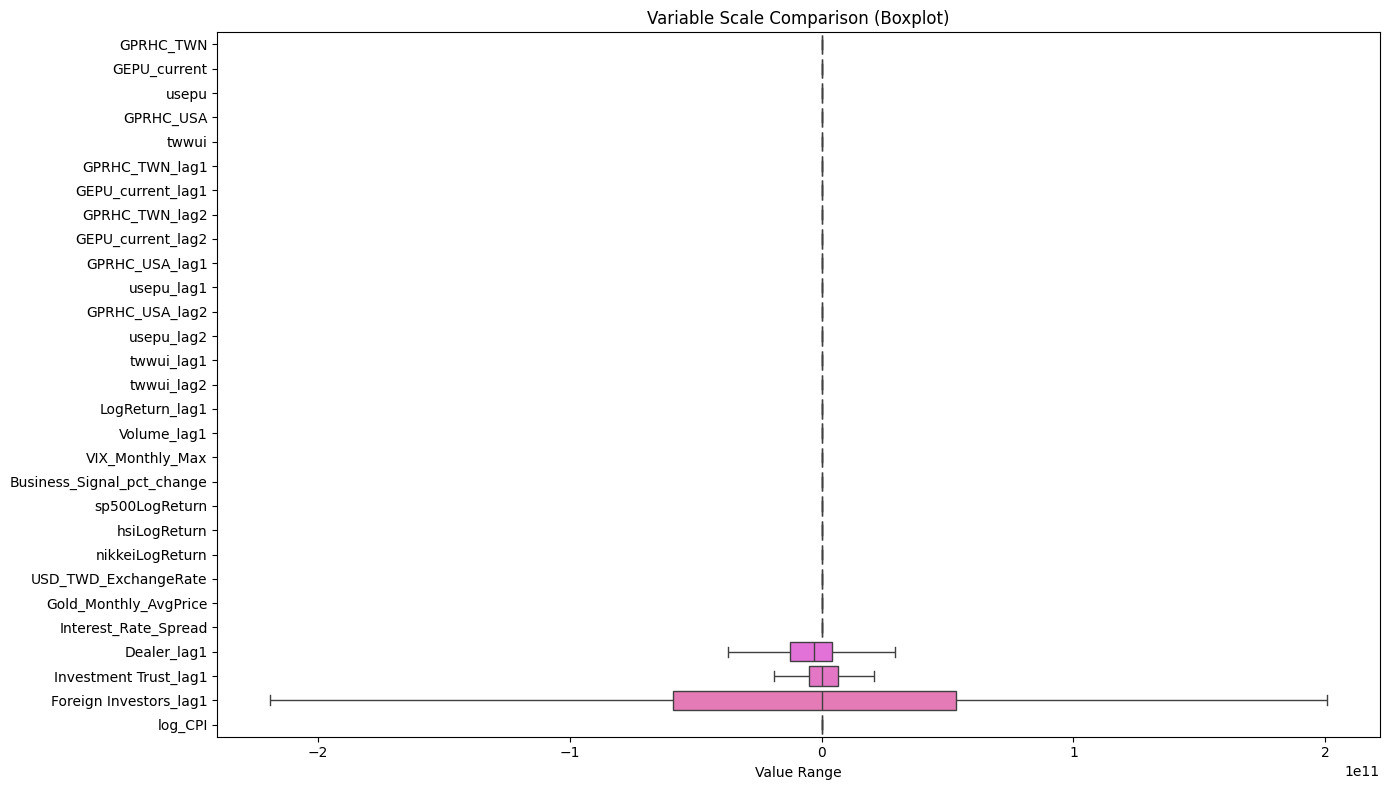

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

features = [
    "GPRHC_TWN", "GEPU_current",
    "usepu",
    "GPRHC_USA",
    "twwui",
    "GPRHC_TWN_lag1", "GEPU_current_lag1",
    "GPRHC_TWN_lag2", "GEPU_current_lag2",
    "GPRHC_USA_lag1", "usepu_lag1",
    "GPRHC_USA_lag2", "usepu_lag2",
    "twwui_lag1",
    "twwui_lag2",
    "LogReturn_lag1", "Volume_lag1",
    "VIX_Monthly_Max",
    "Business_Signal_pct_change",
    "sp500LogReturn", "hsiLogReturn", "nikkeiLogReturn",
    "USD_TWD_ExchangeRate", "Gold_Monthly_AvgPrice", "Interest_Rate_Spread",
    "Dealer_lag1", "Investment Trust_lag1", "Foreign Investors_lag1",
    "log_CPI"
]


plt.figure(figsize=(14, 8))
sns.boxplot(data=df_scaled[features], orient="h", showfliers=False)
plt.title("Variable Scale Comparison (Boxplot)")
plt.xlabel("Value Range")
plt.tight_layout()
plt.show()


In [510]:
df_scaled["USD_TWD_ExchangeRate_lag1"] = df["USD_TWD_ExchangeRate"].shift(1)

In [511]:
from sklearn.preprocessing import StandardScaler

standardize_cols = [
    "GPRHC_TWN", "GEPU_current",
    "usepu",
    "GPRHC_USA",
    "twwui",
    "GPR_GEPU", 
    "GPRHC_TWN_lag1", "GEPU_current_lag1",
    "GPRHC_TWN_lag2", "GEPU_current_lag2",
    "GPRHC_USA_lag1", "usepu_lag1",
    "GPRHC_USA_lag2", "usepu_lag2",
    "twwui_lag1",
    "twwui_lag2",
    "Volume_lag1",
    "VIX_Monthly_Max",
    "USD_TWD_ExchangeRate_lag1", "Gold_Monthly_AvgPrice", "Interest_Rate_Spread",
    "Dealer_lag1", "Investment Trust_lag1", "Foreign Investors_lag1",
    "log_CPI"
]

scaler = StandardScaler()
df_standardized = df_scaled.copy()
df_standardized[standardize_cols] = scaler.fit_transform(df_standardized[standardize_cols])

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/extmath.py:1050: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/extmath.py:1055: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/extmath.py:1075: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/seaborn/categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Library/Frameworks/Python.framew

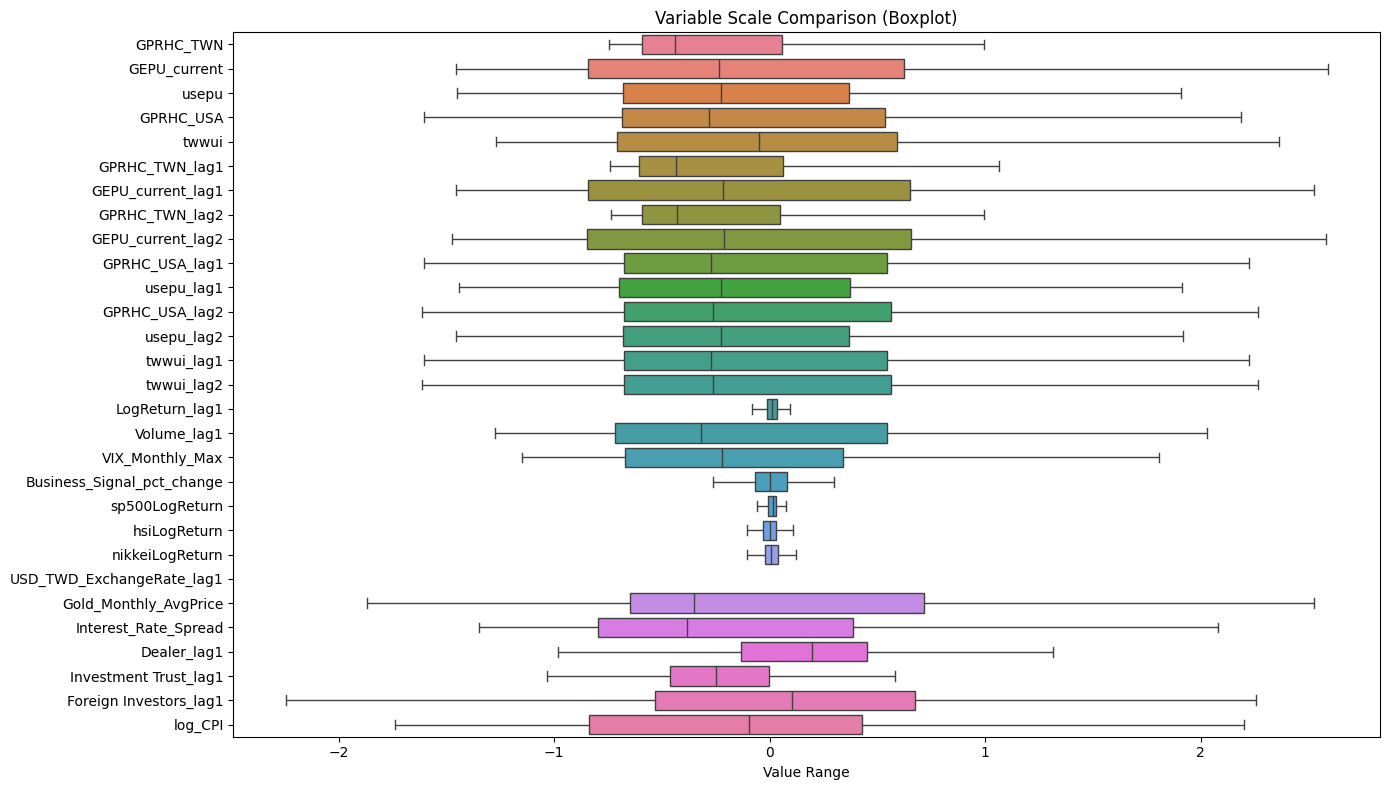

In [512]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

features = [
    "GPRHC_TWN", "GEPU_current",
    "usepu",
    "GPRHC_USA",
    "twwui",
    "GPRHC_TWN_lag1", "GEPU_current_lag1",
    "GPRHC_TWN_lag2", "GEPU_current_lag2",
    "GPRHC_USA_lag1", "usepu_lag1",
    "GPRHC_USA_lag2", "usepu_lag2",
    "twwui_lag1",
    "twwui_lag2",
    "LogReturn_lag1", "Volume_lag1",
    "VIX_Monthly_Max",
    "Business_Signal_pct_change",
    "sp500LogReturn", "hsiLogReturn", "nikkeiLogReturn",
    "USD_TWD_ExchangeRate_lag1", "Gold_Monthly_AvgPrice", "Interest_Rate_Spread",
    "Dealer_lag1", "Investment Trust_lag1", "Foreign Investors_lag1",
    "log_CPI"
]

plt.figure(figsize=(14, 8))
sns.boxplot(data=df_standardized[features], orient="h", showfliers=False)
plt.title("Variable Scale Comparison (Boxplot)")
plt.xlabel("Value Range")
plt.tight_layout()
plt.show()


###### EDA

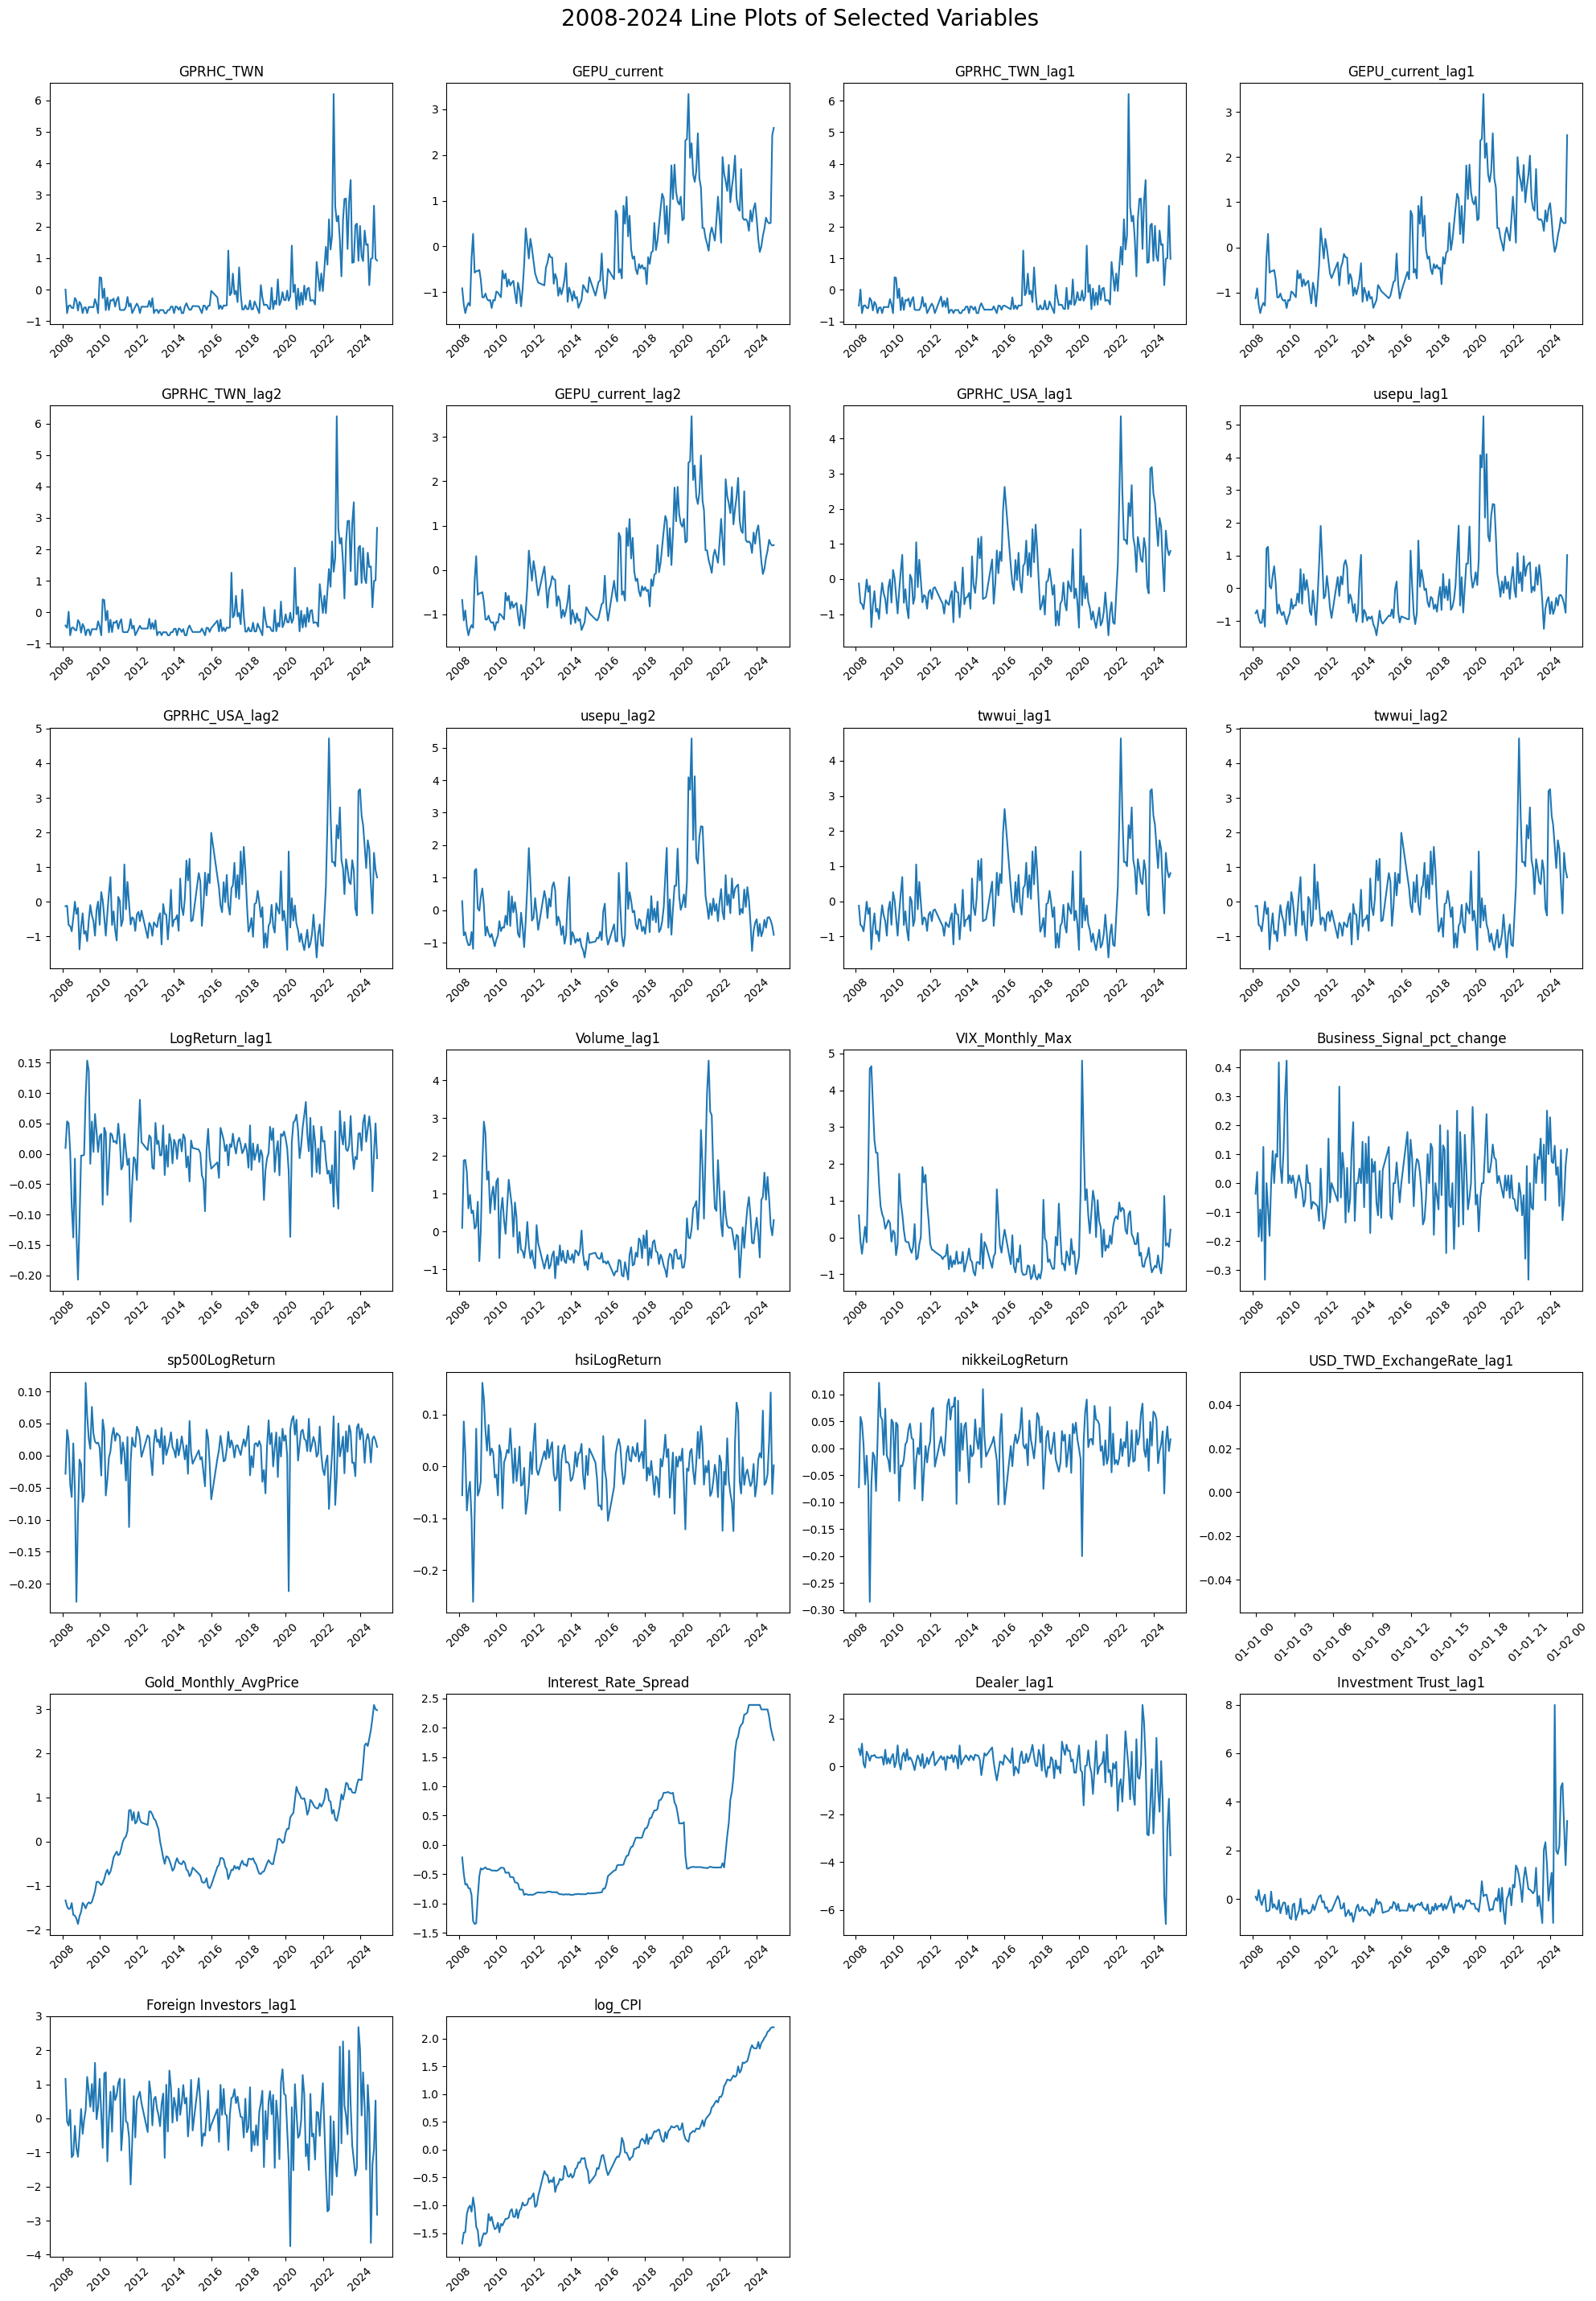

In [513]:
features = [
    "GPRHC_TWN", "GEPU_current",
    "GPRHC_TWN_lag1", "GEPU_current_lag1",
    "GPRHC_TWN_lag2", "GEPU_current_lag2",
    "GPRHC_USA_lag1", "usepu_lag1",
    "GPRHC_USA_lag2", "usepu_lag2",
    "twwui_lag1", "twwui_lag2",
    "LogReturn_lag1", "Volume_lag1",
    "VIX_Monthly_Max",
    "Business_Signal_pct_change",
    "sp500LogReturn", "hsiLogReturn", "nikkeiLogReturn",
    "USD_TWD_ExchangeRate_lag1", "Gold_Monthly_AvgPrice", "Interest_Rate_Spread",
    "Dealer_lag1", "Investment Trust_lag1", "Foreign Investors_lag1",
    "log_CPI"
]


df_standardized["Date"] = pd.to_datetime(df_standardized["Year"].astype(str) + "-" + df_standardized["Month"].astype(str).str.zfill(2))
df_plot = df_standardized.set_index("Date")[features]


num_vars = len(features)
cols = 4
rows = (num_vars + cols - 1) // cols

plt.figure(figsize=(20, 4 * rows))

for i, feature in enumerate(features, 1):
    plt.subplot(rows, cols, i)
    plt.plot(df_plot.index, df_plot[feature])
    plt.title(feature)
    plt.xticks(rotation=45)

plt.tight_layout()
plt.suptitle("2008-2024 Line Plots of Selected Variables", fontsize=20, y=1.02)
plt.show()


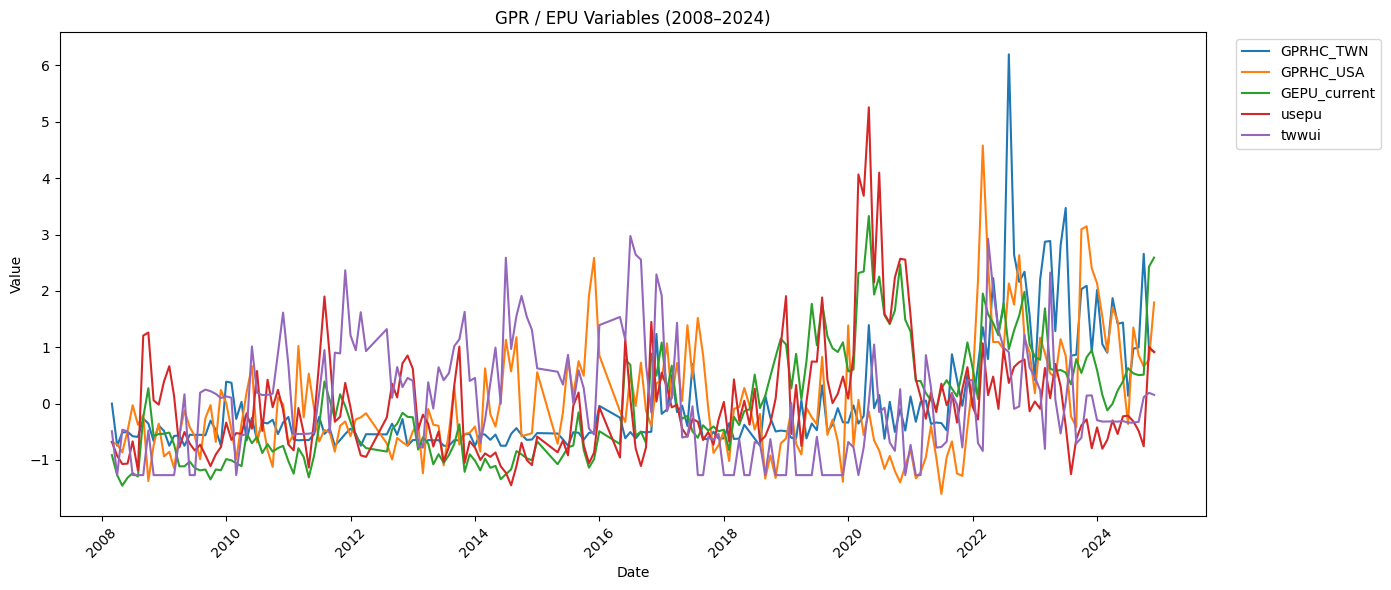

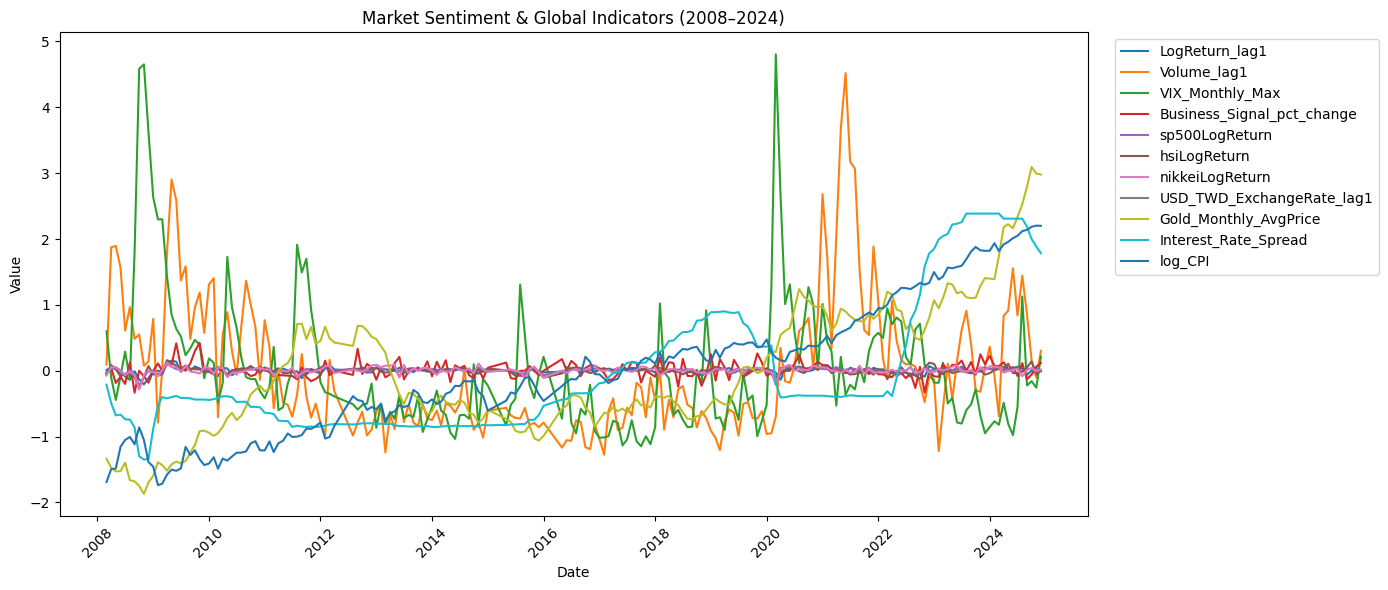

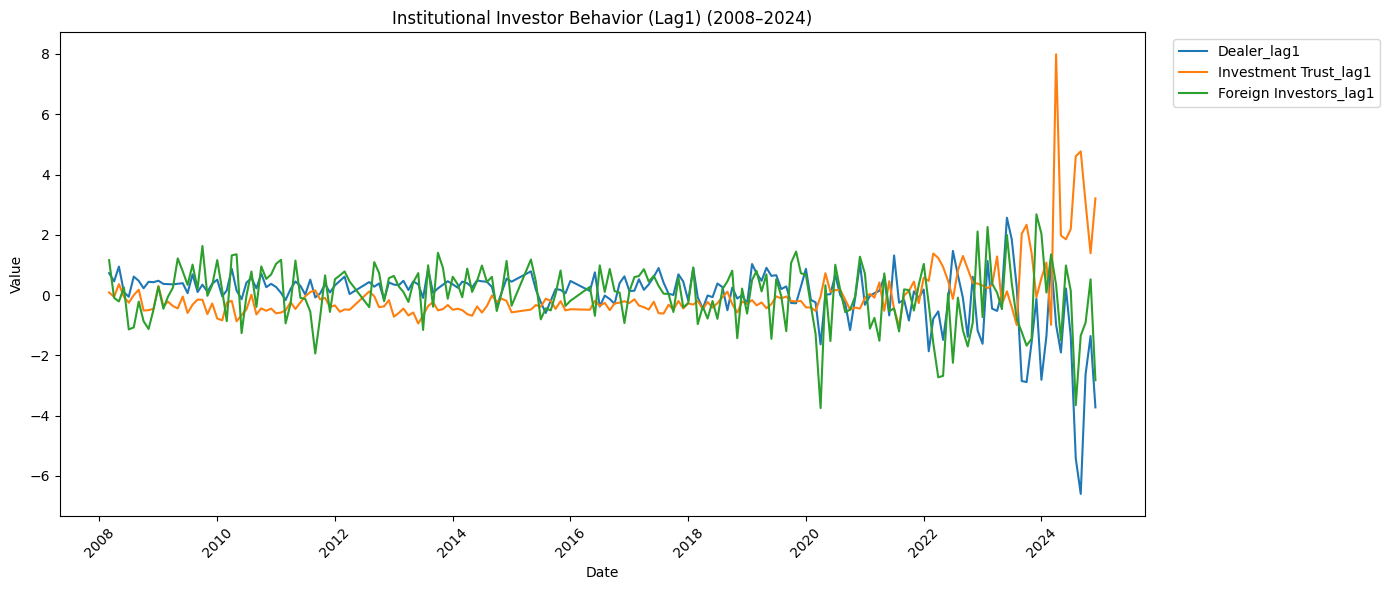

In [514]:
import matplotlib.pyplot as plt
import pandas as pd

gpr_epu_vars = [
    "GPRHC_TWN", 
    "GPRHC_USA", 
    "GEPU_current",
    "usepu",
    "twwui"
]

market_sentiment_vars = [
    "LogReturn_lag1", "Volume_lag1", "VIX_Monthly_Max", "Business_Signal_pct_change",
    "sp500LogReturn", "hsiLogReturn", "nikkeiLogReturn",
    "USD_TWD_ExchangeRate_lag1", "Gold_Monthly_AvgPrice", "Interest_Rate_Spread",
    "log_CPI"
]

institutional_behavior_vars = [
    "Dealer_lag1", "Investment Trust_lag1", "Foreign Investors_lag1"
]

df_standardized["Date"] = pd.to_datetime(df_standardized["Year"].astype(str) + "-" + df_standardized["Month"].astype(str).str.zfill(2))
df_plot = df_standardized.set_index("Date")

def plot_group_in_one_chart(features, title):
    plt.figure(figsize=(14, 6))
    for feature in features:
        plt.plot(df_plot.index, df_plot[feature], label=feature)
    plt.title(title)
    plt.xlabel("Date")
    plt.ylabel("Value")
    plt.xticks(rotation=45)
    plt.legend(loc="upper left", bbox_to_anchor=(1.02, 1.0))
    plt.tight_layout()
    plt.show()

plot_group_in_one_chart(gpr_epu_vars, "GPR / EPU Variables (2008–2024)")
plot_group_in_one_chart(market_sentiment_vars, "Market Sentiment & Global Indicators (2008–2024)")
plot_group_in_one_chart(institutional_behavior_vars, "Institutional Investor Behavior (Lag1) (2008–2024)")


In [ ]:
# import statsmodels.api as sm
# models = {
#     "Current": [
#         "GPRHC_TWN", "GEPU_current",
#         "LogReturn_lag1", "Volume_lag1",
#         "GPR_GEPU",
#         "Business_Signal_pct_change",
#         "sp500LogReturn","hsiLogReturn","nikkeiLogReturn", "USD_TWD_ExchangeRate","Gold_Monthly_AvgPrice", "Interest_Rate_Spread"
#     ],
#     "Lag": [
#         "GPRHC_TWN_lag1", "GEPU_current_lag1",
#         "GPRHC_TWN_lag2", "GEPU_current_lag2",
#         "LogReturn_lag1", "Volume_lag1",
#         "VIX_Monthly_Max",
#         "Business_Signal_pct_change",
#         "sp500LogReturn","hsiLogReturn","nikkeiLogReturn","USD_TWD_ExchangeRate", "Gold_Monthly_AvgPrice", "Interest_Rate_Spread"
#     ],
#     "cross": [
#         "GPRHC_TWN_lag1", "GEPU_current_lag1",
#         "GPRHC_TWN_lag2", "GEPU_current_lag2",
#         "LogReturn_lag1", "Volume_lag1",
#         "VIX_Monthly_Max",
#         "GPR_lag1_GEPU_lag1",
#         "Business_Signal_pct_change",
#         "sp500LogReturn","hsiLogReturn","nikkeiLogReturn","USD_TWD_ExchangeRate", "Gold_Monthly_AvgPrice", "Interest_Rate_Spread"
#     ],    
#     "Full": [
#         "GPRHC_TWN_lag1", "GEPU_current_lag1",
#         "GPRHC_TWN_lag2", "GEPU_current_lag2",
#         "LogReturn_lag1", "Volume_lag1",
#         "VIX_Monthly_Max",
#         "GPR_lag1_GEPU_lag1",
#         "Business_Signal_pct_change",
#         "sp500LogReturn","hsiLogReturn","nikkeiLogReturn","USD_TWD_ExchangeRate", "Gold_Monthly_AvgPrice", "Interest_Rate_Spread",
#         "Dealer_lag1", "Investment Trust_lag1", "Foreign Investors_lag1"
#     ],
#     "Try": [
#         "GPRHC_TWN_lag1", "GEPU_current_lag1",
#         "GPRHC_TWN_lag2", "GEPU_current_lag2",
#         "LogReturn_lag1", "Volume_lag1",
#         "VIX_Monthly_Max",
#         "Business_Signal_pct_change",
#         "sp500LogReturn","hsiLogReturn","nikkeiLogReturn","USD_TWD_ExchangeRate", "Gold_Monthly_AvgPrice", "Interest_Rate_Spread",
#         "Dealer_lag1", "Investment Trust_lag1", "Foreign Investors_lag1",
#         "log_CPI"
#     ],       
    
# }

# # 三大法人  
# targets = [
#     "Foreign Investors",
#     "Investment Trust",
#     "Dealer"
# ]


# for target in targets:
#     print(f"\n===================================")
#     print(f"      回歸結果：{target}")
#     print(f"===================================")
    
#     for model_name, var_list in models.items():
#         print(f"\n--- Model: {model_name} ---")
#         data = df_scaled[var_list + [target]].dropna()
#         X = sm.add_constant(data[var_list])
#         y = data[target]
#         model = sm.OLS(y, X).fit()
#         print(model.summary())

In [ ]:
import statsmodels.api as sm
models = {
    "Current": [
        "GPRHC_TWN", "GEPU_current",
        "LogReturn_lag1", "Volume_lag1",
        "GPR_GEPU",
        "Business_Signal_pct_change",
        "sp500LogReturn","hsiLogReturn","nikkeiLogReturn", "USD_TWD_ExchangeRate","Gold_Monthly_AvgPrice", "Interest_Rate_Spread"
    ],
    "Lag": [
        "GPRHC_TWN_lag1", "GEPU_current_lag1",
        "GPRHC_TWN_lag2", "GEPU_current_lag2",
        "LogReturn_lag1", "Volume_lag1",
        "VIX_Monthly_Max",
        "Business_Signal_pct_change",
        "sp500LogReturn","hsiLogReturn","nikkeiLogReturn","USD_TWD_ExchangeRate", "Gold_Monthly_AvgPrice", "Interest_Rate_Spread"
    ],
    "cross": [
        "GPRHC_TWN_lag1", "GEPU_current_lag1",
        "GPRHC_TWN_lag2", "GEPU_current_lag2",
        "LogReturn_lag1", "Volume_lag1",
        "VIX_Monthly_Max",
        "GPR_lag1_GEPU_lag1",
        "Business_Signal_pct_change",
        "sp500LogReturn","hsiLogReturn","nikkeiLogReturn","USD_TWD_ExchangeRate", "Gold_Monthly_AvgPrice", "Interest_Rate_Spread"
    ],    
    "Full": [
        "GPRHC_TWN_lag1", "GEPU_current_lag1",
        "GPRHC_TWN_lag2", "GEPU_current_lag2",
        "LogReturn_lag1", "Volume_lag1",
        "VIX_Monthly_Max",
        "GPR_lag1_GEPU_lag1",
        "Business_Signal_pct_change",
        "sp500LogReturn","hsiLogReturn","nikkeiLogReturn","USD_TWD_ExchangeRate", "Gold_Monthly_AvgPrice", "Interest_Rate_Spread",
        "Dealer_lag1", "Investment Trust_lag1", "Foreign Investors_lag1"
    ],
    "Try": [
        "GPRHC_TWN_lag1", "GEPU_current_lag1",
        "GPRHC_TWN_lag2", "GEPU_current_lag2",
        "LogReturn_lag1", "Volume_lag1",
        "VIX_Monthly_Max",
        "Business_Signal_pct_change",
        "sp500LogReturn","hsiLogReturn","nikkeiLogReturn","USD_TWD_ExchangeRate", "Gold_Monthly_AvgPrice", "Interest_Rate_Spread",
        "Dealer_lag1", "Investment Trust_lag1", "Foreign Investors_lag1",
        "log_CPI"
    ],       
    
}

# 三大法人  
targets = [
    "Foreign Investors",
    "Investment Trust",
    "Dealer"
]


for target in targets:
    print(f"\n===================================")
    print(f"      回歸結果：{target}")
    print(f"===================================")
    
    for model_name, var_list in models.items():
        print(f"\n--- Model: {model_name} ---")
        data = df_scaled[var_list + [target]].dropna()
        X = sm.add_constant(data[var_list])
        y = data[target]
        model = sm.OLS(y, X).fit()
        print(model.summary())


      回歸結果：Foreign Investors

--- Model: Current ---
                            OLS Regression Results                            
Dep. Variable:      Foreign Investors   R-squared:                       0.399
Model:                            OLS   Adj. R-squared:                  0.359
Method:                 Least Squares   F-statistic:                     9.970
Date:                Thu, 17 Apr 2025   Prob (F-statistic):           7.69e-15
Time:                        11:33:10   Log-Likelihood:                -5098.6
No. Observations:                 193   AIC:                         1.022e+04
Df Residuals:                     180   BIC:                         1.027e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

X = df_scaled[[ "GPRHC_TWN_lag1", "GEPU_current_lag1",
        "GPRHC_TWN_lag2", "GEPU_current_lag2",
        "LogReturn_lag1", "Volume_lag1",
        "VIX_Monthly_Max",
        "Business_Signal_pct_change",
        "sp500LogReturn","hsiLogReturn","nikkeiLogReturn","USD_TWD_ExchangeRate", "Gold_Monthly_AvgPrice", "Interest_Rate_Spread",
        "Dealer_lag1", "Investment Trust_lag1", "Foreign Investors_lag1",
        "log_CPI"]
       ]
X = sm.add_constant(X)
vif = pd.DataFrame()
vif["feature"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif

feature           VIF
0                        const  54475.815707
1               GPRHC_TWN_lag1      2.897488
2            GEPU_current_lag1      5.417643
3               GPRHC_TWN_lag2      2.929425
4            GEPU_current_lag2      5.125615
5               LogReturn_lag1      2.124917
6                  Volume_lag1      1.450903
7              VIX_Monthly_Max      2.912258
8   Business_Signal_pct_change      1.221742
9               sp500LogReturn      4.077589
10                hsiLogReturn      1.914902
11             nikkeiLogReturn      2.820241
12        USD_TWD_ExchangeRate      1.341324
13       Gold_Monthly_AvgPrice      3.675449
14        Interest_Rate_Spread      4.760586
15                 Dealer_lag1      2.425114
16       Investment Trust_lag1      2.496237
17      Foreign Investors_lag1      1.971324
18                     log_CPI      7.700539

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=5.23821e-25): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.693e+23, tolerance: 1.235e+20
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=5.23821e-25): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-pack

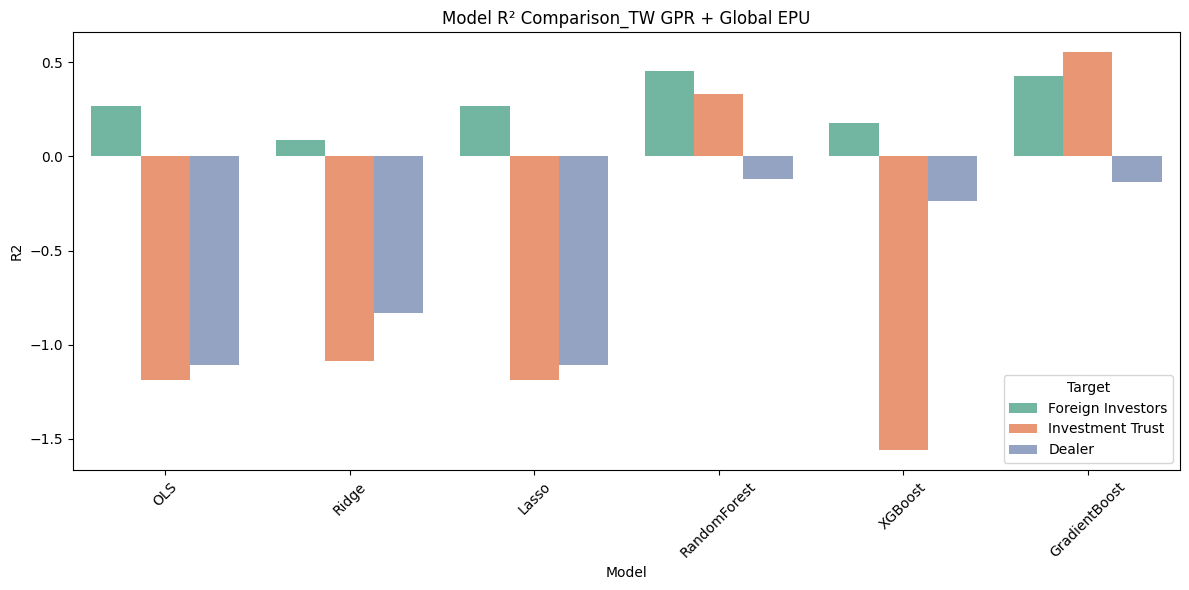

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
import seaborn as sns
import matplotlib.pyplot as plt

features_try = [
    "GPRHC_TWN_lag1", "GEPU_current_lag1",
    "GPRHC_TWN_lag2", "GEPU_current_lag2",
    "LogReturn_lag1", "Volume_lag1",
    "VIX_Monthly_Max",
    "Business_Signal_pct_change",
    "sp500LogReturn", "hsiLogReturn", "nikkeiLogReturn",
    "USD_TWD_ExchangeRate", "Gold_Monthly_AvgPrice", "Interest_Rate_Spread",
    "Dealer_lag1", "Investment Trust_lag1", "Foreign Investors_lag1",
    "log_CPI"
]


targets = ["Foreign Investors", "Investment Trust", "Dealer"]

models = {
    "OLS": LinearRegression(),
    "Ridge": Ridge(alpha=1.0),
    "Lasso": Lasso(alpha=0.01),
    "RandomForest": RandomForestRegressor(n_estimators=100, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=100, random_state=42, verbosity=0),
    "GradientBoost": GradientBoostingRegressor(n_estimators=100, random_state=42)
}

df = df_scaled

all_results = []

for target in targets:
    df_model = df[features_try + [target]].dropna()
    X = df_model[features_try]
    y = df_model[target]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        r2 = r2_score(y_test, y_pred)

        all_results.append({
            "Target": target,
            "Model": name,
            "R2": round(r2, 4)
        })
results_df = pd.DataFrame(all_results)

plt.figure(figsize=(12, 6))
sns.barplot(data=results_df, x="Model", y="R2", hue="Target", palette="Set2")
plt.title("Model R² Comparison_TW GPR + Global EPU")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
import statsmodels.api as sm
models = {
    "Try": [
        "GPRHC_TWN_lag1", "GEPU_current_lag1",
        "GPRHC_TWN_lag2", "GEPU_current_lag2",
        "LogReturn_lag1", "Volume_lag1",
        "VIX_Monthly_Max",
        "Business_Signal_pct_change",
        "sp500LogReturn","hsiLogReturn","nikkeiLogReturn","USD_TWD_ExchangeRate", "Gold_Monthly_AvgPrice", "Interest_Rate_Spread",
        "Dealer_lag1", "Investment Trust_lag1", "Foreign Investors_lag1",
        "log_CPI"
    ],       
    
}

# 三大法人  
targets = [
    "Foreign Investors",
    "Investment Trust",
    "Dealer"
]


for target in targets:
    print(f"\n===================================")
    print(f"      回歸結果：{target}")
    print(f"===================================")
    
    for model_name, var_list in models.items():
        print(f"\n--- Model: {model_name} ---")
        data = df_scaled[var_list + [target]].dropna()
        X = sm.add_constant(data[var_list])
        y = data[target]
        model = sm.OLS(y, X).fit()
        print(model.summary())


      回歸結果：Foreign Investors

--- Model: Try ---
                            OLS Regression Results                            
Dep. Variable:      Foreign Investors   R-squared:                       0.445
Model:                            OLS   Adj. R-squared:                  0.388
Method:                 Least Squares   F-statistic:                     7.762
Date:                Thu, 17 Apr 2025   Prob (F-statistic):           1.13e-14
Time:                        11:08:49   Log-Likelihood:                -5090.9
No. Observations:                 193   AIC:                         1.022e+04
Df Residuals:                     174   BIC:                         1.028e+04
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------

### 2. 台灣 GPR + US EPU  , w/ 美國 VIX

https://www.policyuncertainty.com/us_monthly.html

In [ ]:
import pandas as pd

file_path = "/Users/susanlin/Desktop/Thesis/Data/US_Policy_Uncertainty_Data.xlsx"
usepu_df = pd.read_excel(file_path)

usepu_df.columns = [col.strip() for col in usepu_df.columns]

usepu_df["Year"] = pd.to_numeric(usepu_df["Year"], errors="coerce")
usepu_df["Month"] = pd.to_numeric(usepu_df["Month"], errors="coerce")

usepu_df_clean = usepu_df.dropna(subset=["Year", "Month", "News_Based_Policy_Uncert_Index"])

usepu_df_clean["Year"] = usepu_df_clean["Year"].astype("Int64")
usepu_df_clean["Month"] = usepu_df_clean["Month"].astype("Int64")

usepu_filtered = usepu_df_clean[["Year", "Month", "News_Based_Policy_Uncert_Index"]]

usepu_filtered = usepu_filtered.rename(columns={"News_Based_Policy_Uncert_Index": "usepu"})

/var/folders/m3/4kw7w40s6p56xt563fshsjjh0000gn/T/ipykernel_10684/3983412812.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usepu_df_clean["Year"] = usepu_df_clean["Year"].astype("Int64")
/var/folders/m3/4kw7w40s6p56xt563fshsjjh0000gn/T/ipykernel_10684/3983412812.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usepu_df_clean["Month"] = usepu_df_clean["Month"].astype("Int64")


In [ ]:
df_scaled = pd.merge(df_scaled, usepu_filtered, on=["Year", "Month"], how="outer")

In [ ]:
# import statsmodels.api as sm
# models = {
#     "Lag": [
#         "GPRHC_TWN_lag1", "usepu_lag1",
#         "GPRHC_TWN_lag2", "usepu_lag2",
#         "LogReturn_lag1", "Volume_lag1",
#         "GPR_lag1_usepu_lag1",
#         "Business_Signal_pct_change"
#     ],
#     "Full: Lag + Interactions": [
#         "GPRHC_TWN_lag1", "usepu_lag1",
#         "GPRHC_TWN_lag2", "usepu_lag2",
#         "LogReturn_lag1", "Volume_lag1",
#         "GPR_lag1_usepu_lag1",
#         "VIX_Monthly_Max",
#         "Business_Signal_pct_change"
#     ]
# }



# # 三大法人  
# targets = [
#     "Foreign Investors",
#     "Investment Trust",
#     "Dealer"
# ]


# for target in targets:
#     print(f"\n===================================")
#     print(f"      回歸結果：{target}")
#     print(f"===================================")
    
#     for model_name, var_list in models.items():
#         print(f"\n--- Model: {model_name} ---")
#         data = df_scaled[var_list + [target]].dropna()
#         X = sm.add_constant(data[var_list])
#         y = data[target]
#         model = sm.OLS(y, X).fit()
#         print(model.summary())

In [ ]:
import statsmodels.api as sm
models = {
    "Try": [
        "GPRHC_TWN_lag1", "usepu_lag1",
        "GPRHC_TWN_lag2", "usepu_lag2",
        "LogReturn_lag1", "Volume_lag1",
        "VIX_Monthly_Max",
        "Business_Signal_pct_change",
        "sp500LogReturn","hsiLogReturn","nikkeiLogReturn","USD_TWD_ExchangeRate", "Gold_Monthly_AvgPrice", "Interest_Rate_Spread",
        "Dealer_lag1", "Investment Trust_lag1", "Foreign Investors_lag1",
        "log_CPI"
    ],       
    
}

# 三大法人  
targets = [
    "Foreign Investors",
    "Investment Trust",
    "Dealer"
]


for target in targets:
    print(f"\n===================================")
    print(f"      回歸結果：{target}")
    print(f"===================================")
    
    for model_name, var_list in models.items():
        print(f"\n--- Model: {model_name} ---")
        data = df_scaled[var_list + [target]].dropna()
        X = sm.add_constant(data[var_list])
        y = data[target]
        model = sm.OLS(y, X).fit()
        print(model.summary())


      回歸結果：Foreign Investors

--- Model: Try ---
                            OLS Regression Results                            
Dep. Variable:      Foreign Investors   R-squared:                       0.448
Model:                            OLS   Adj. R-squared:                  0.391
Method:                 Least Squares   F-statistic:                     7.834
Date:                Thu, 17 Apr 2025   Prob (F-statistic):           8.23e-15
Time:                        10:38:05   Log-Likelihood:                -5091.3
No. Observations:                 193   AIC:                         1.022e+04
Df Residuals:                     174   BIC:                         1.028e+04
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=5.31006e-25): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.707e+23, tolerance: 1.235e+20
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=5.31006e-25): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-pack

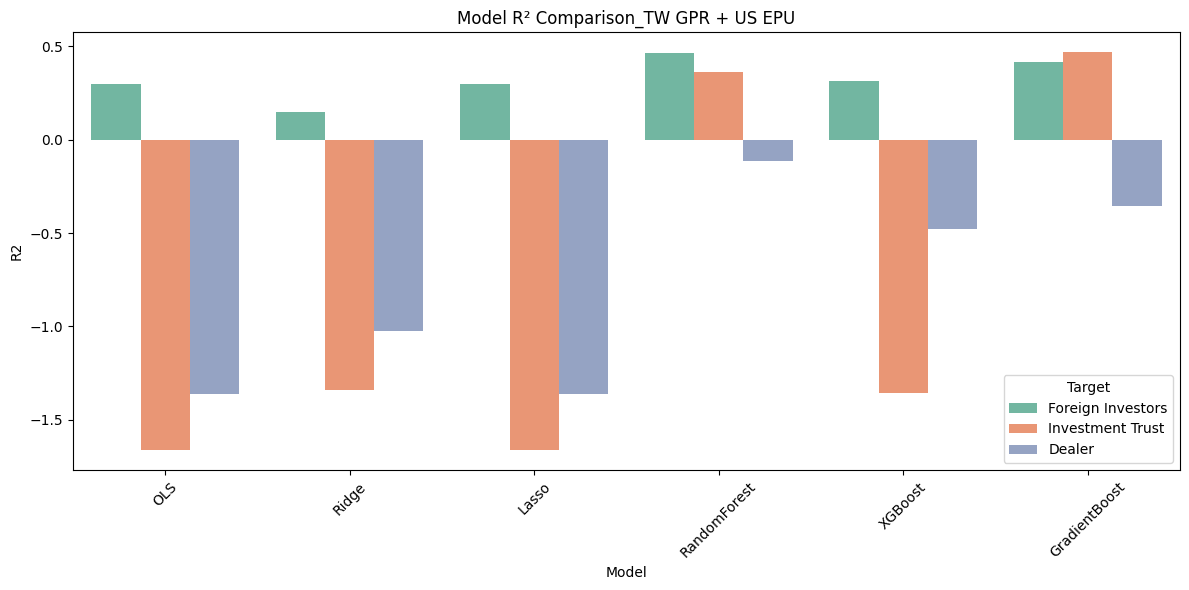

In [ ]:
features_try = [
    "GPRHC_TWN_lag1", "usepu_lag1",
    "GPRHC_TWN_lag2", "usepu_lag2",
    "LogReturn_lag1", "Volume_lag1",
    "VIX_Monthly_Max",
    "Business_Signal_pct_change",
    "sp500LogReturn", "hsiLogReturn", "nikkeiLogReturn",
    "USD_TWD_ExchangeRate", "Gold_Monthly_AvgPrice", "Interest_Rate_Spread",
    "Dealer_lag1", "Investment Trust_lag1", "Foreign Investors_lag1",
    "log_CPI"
]

targets = ["Foreign Investors", "Investment Trust", "Dealer"]

models = {
    "OLS": LinearRegression(),
    "Ridge": Ridge(alpha=1.0),
    "Lasso": Lasso(alpha=0.01),
    "RandomForest": RandomForestRegressor(n_estimators=100, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=100, random_state=42, verbosity=0),
    "GradientBoost": GradientBoostingRegressor(n_estimators=100, random_state=42)
}

df = df_scaled

all_results = []

for target in targets:
    df_model = df[features_try + [target]].dropna()
    X = df_model[features_try]
    y = df_model[target]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        r2 = r2_score(y_test, y_pred)

        all_results.append({
            "Target": target,
            "Model": name,
            "R2": round(r2, 4)
        })
results_df = pd.DataFrame(all_results)

plt.figure(figsize=(12, 6))
sns.barplot(data=results_df, x="Model", y="R2", hue="Target", palette="Set2")
plt.title("Model R² Comparison_TW GPR + US EPU")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### 3. 美國 GPR + 美國 EPU  , w/ 美國 VIX

參考文獻：https://ndltd.ncl.edu.tw/cgi-bin/gs32/gsweb.cgi/login?o=dnclcdr&s=id=%22109CCU00324026%22.&searchmode=basic#XXX

用美國 VIX, EPU

In [ ]:
file_path = "/Users/susanlin/Desktop/Thesis/Data/GPR_1900-202502 monthly.xls"
df = pd.read_excel(file_path)

df["month"] = pd.to_datetime(df["month"])  # 轉成 datetime 格式
df["Year"] = df["month"].dt.year
df["Month"] = df["month"].dt.month

result = df[["Year", "Month", "GPRHC_USA"]].copy()

result[1450:1455]

Year  Month  GPRHC_USA
1450  2020     11   1.819809
1451  2020     12   2.026295
1452  2021      1   2.223497
1453  2021      2   1.870223
1454  2021      3   1.943909

In [ ]:
df_usgpr = result
df_usgpr["年月"] = df_usgpr["Year"].astype(str) + "-" + df_usgpr["Month"].astype(str).str.zfill(2)
df_usgpr = df_usgpr.drop(columns=["年月"])
df_usgpr 

Year  Month  GPRHC_USA
0     1900      1   2.718799
1     1900      2   2.732469
2     1900      3   2.151507
3     1900      4   1.776175
4     1900      5   1.970109
...    ...    ...        ...
1497  2024     10   3.259452
1498  2024     11   3.344316
1499  2024     12   4.055701
1500  2025      1   3.367398
1501  2025      2   3.187533

[1502 rows x 3 columns]

In [ ]:
df_scaled = pd.merge(df_scaled, df_usgpr, on=["Year", "Month"], how="outer")
df_scaled


Year  Month        Dealer  Investment Trust  Foreign Investors  \
0     1900      1           NaN               NaN                NaN   
1     1900      2           NaN               NaN                NaN   
2     1900      3           NaN               NaN                NaN   
3     1900      4           NaN               NaN                NaN   
4     1900      5           NaN               NaN                NaN   
...    ...    ...           ...               ...                ...   
1498  2024     11 -1.167762e+11      8.501633e+10      -2.729447e+11   
1499  2024     12 -3.253823e+10     -6.916221e+08       4.573943e+10   
1500  2025      1           NaN               NaN                NaN   
1501  2025      2           NaN               NaN                NaN   
1502  2025      3           NaN               NaN                NaN   

      GPRHC_TWN  GEPU_current         Close      Volume    Return  ...  \
0           NaN           NaN           NaN         NaN       NaN  ...   
1           NaN           NaN           NaN         NaN       NaN  ...   
2           NaN           NaN           NaN         NaN       NaN  ...   
3           NaN           NaN           NaN         NaN       NaN  ...   
4           NaN           NaN           NaN         NaN       NaN  ...   
...         ...           ...           ...         ...       ...  ...   
1498   0.197694    365.206009  22262.500000  73073600.0 -0.024449  ...   
1499   0.191471    377.073675  23035.099609  67916600.0  0.034704  ...   
1500        NaN           NaN           NaN         NaN       NaN  ...   
1501        NaN           NaN           NaN         NaN       NaN  ...   
1502        NaN           NaN           NaN         NaN       NaN  ...   

      GEPU_current_lag2  Business_Signal     CPI  Volume_lag1   log_CPI  \
0                   NaN              NaN     NaN          NaN       NaN   
1                   NaN              NaN     NaN          NaN       NaN   
2                   NaN              NaN     NaN          NaN       NaN   
3                   NaN              NaN     NaN          NaN       NaN   
4                   NaN              NaN     NaN          NaN       NaN   
...                 ...              ...     ...          ...       ...   
1498         223.007104             34.0  108.84   61146000.0  4.699025   
1499         223.640869             38.0  108.82   73073600.0  4.698843   
1500                NaN             35.0  109.43   67916600.0  4.704382   
1501                NaN             37.0  108.96          NaN  4.700117   
1502                NaN              NaN     NaN          NaN       NaN   

      LogReturn  LogReturn_lag1  Business_Signal_pct_change       usepu  \
0           NaN             NaN                         NaN         NaN   
1           NaN             NaN                         NaN         NaN   
2           NaN             NaN                         NaN         NaN   
3           NaN             NaN                         NaN         NaN   
4           NaN             NaN                         NaN         NaN   
...         ...             ...                         ...         ...   
1498  -0.007032        0.050092                    0.062500  225.049031   
1499   0.009844       -0.007032                    0.117647  218.845481   
1500        NaN        0.009844                   -0.078947  236.787068   
1501        NaN             NaN                    0.057143  329.305146   
1502        NaN             NaN                         NaN  446.027858   

      GPRHC_USA  
0      2.718799  
1      2.732469  
2      2.151507  
3      1.776175  
4      1.970109  
...         ...  
1498   3.344316  
1499   4.055701  
1500   3.367398  
1501   3.187533  
1502        NaN  

[1503 rows x 29 columns]

In [ ]:
# import statsmodels.api as sm
# models = {
#     "Lag": [
#         "GPRHC_USA_lag1", "usepu_lag1",
#         "GPRHC_USA_lag2", "usepu_lag2",
#         "LogReturn_lag1", "Volume_lag1",
#         "usGPR_lag1_usepu_lag1",
#         "Business_Signal_pct_change"
#     ],
#     "Full: Lag + Interactions": [
#         "GPRHC_USA_lag1", "usepu_lag1",
#         "GPRHC_USA_lag2", "usepu_lag2",
#         "LogReturn_lag1", "Volume_lag1",
#         "usGPR_lag1_usepu_lag1",
#         "VIX_Monthly_Max",
#         "Business_Signal_pct_change"
#     ]
# }


# # 三大法人  
# targets = [
#     "Foreign Investors",
#     "Investment Trust",
#     "Dealer"
# ]


# for target in targets:
#     print(f"\n===================================")
#     print(f"      回歸結果：{target}")
#     print(f"===================================")
    
#     for model_name, var_list in models.items():
#         print(f"\n--- Model: {model_name} ---")
#         data = df_scaled[var_list + [target]].dropna()
#         X = sm.add_constant(data[var_list])
#         y = data[target]
#         model = sm.OLS(y, X).fit()
#         print(model.summary())

In [ ]:
import statsmodels.api as sm
models = {
    "Try": [
        "GPRHC_USA_lag1", "usepu_lag1",
        "GPRHC_USA_lag2", "usepu_lag2",
        "LogReturn_lag1", "Volume_lag1",
        "VIX_Monthly_Max",
        "Business_Signal_pct_change",
        "sp500LogReturn","hsiLogReturn","nikkeiLogReturn","USD_TWD_ExchangeRate", "Gold_Monthly_AvgPrice", "Interest_Rate_Spread",
        "Dealer_lag1", "Investment Trust_lag1", "Foreign Investors_lag1",
        "log_CPI"
    ],       
    
}

# 三大法人  
targets = [
    "Foreign Investors",
    "Investment Trust",
    "Dealer"
]


for target in targets:
    print(f"\n===================================")
    print(f"      回歸結果：{target}")
    print(f"===================================")
    
    for model_name, var_list in models.items():
        print(f"\n--- Model: {model_name} ---")
        data = df_scaled[var_list + [target]].dropna()
        X = sm.add_constant(data[var_list])
        y = data[target]
        model = sm.OLS(y, X).fit()
        print(model.summary())


      回歸結果：Foreign Investors

--- Model: Try ---
                            OLS Regression Results                            
Dep. Variable:      Foreign Investors   R-squared:                       0.449
Model:                            OLS   Adj. R-squared:                  0.392
Method:                 Least Squares   F-statistic:                     7.879
Date:                Thu, 17 Apr 2025   Prob (F-statistic):           6.77e-15
Time:                        10:38:20   Log-Likelihood:                -5091.1
No. Observations:                 193   AIC:                         1.022e+04
Df Residuals:                     174   BIC:                         1.028e+04
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=6.49547e-25): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.476e+23, tolerance: 1.342e+20
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=6.49547e-25): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-pack

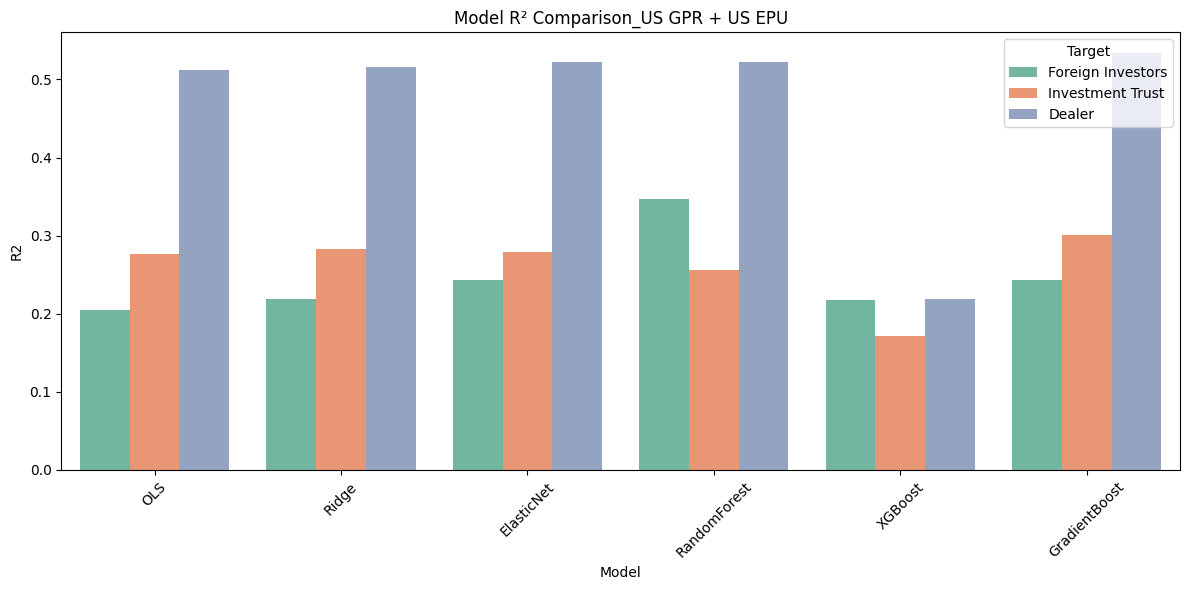

In [ ]:
features_try = [
    "GPRHC_USA_lag1", "usepu_lag1",
    "GPRHC_USA_lag2", "usepu_lag2",
    "LogReturn_lag1", "Volume_lag1",
    "VIX_Monthly_Max",
    "Business_Signal_pct_change",
    "sp500LogReturn", "hsiLogReturn", "nikkeiLogReturn",
    "USD_TWD_ExchangeRate", "Gold_Monthly_AvgPrice", "Interest_Rate_Spread",
    "Dealer_lag1", "Investment Trust_lag1", "Foreign Investors_lag1",
    "log_CPI"
]

targets = ["Foreign Investors", "Investment Trust", "Dealer"]

models = {
    "OLS": LinearRegression(),
    "Ridge": Ridge(alpha=1.0),
    "ElasticNet": ElasticNet(),
    "RandomForest": RandomForestRegressor(n_estimators=100, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=100, random_state=42, verbosity=0),
    "GradientBoost": GradientBoostingRegressor(n_estimators=100, random_state=42)
}

df = df_scaled

all_results = []

for target in targets:
    df_model = df[features_try + [target]].dropna()
    X = df_model[features_try]
    y = df_model[target]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        r2 = r2_score(y_test, y_pred)

        all_results.append({
            "Target": target,
            "Model": name,
            "R2": round(r2, 4)
        })
results_df = pd.DataFrame(all_results)

plt.figure(figsize=(12, 6))
sns.barplot(data=results_df, x="Model", y="R2", hue="Target", palette="Set2")
plt.title("Model R² Comparison_US GPR + US EPU")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### 4. 台灣 GPR + 台灣 WUI  , w/ 美國 VIX
資料來源：https://fred.stlouisfed.org/series/WUITWN

In [ ]:
import pandas as pd

wui_df = pd.read_excel("/Users/susanlin/Desktop/Thesis/Data/WUI_M_dataset_2025_03.xlsx", sheet_name="T1")
wui_df ["date"] = pd.to_datetime(wui_df["date"])

wui_df ["Year"] = wui_df ["date"].dt.year
wui_df ["Month"] = wui_df ["date"].dt.month

wui_df  = wui_df .drop(columns=["date"])

twwui = wui_df[["Year", "Month", "TWN"]].copy()

twwui = twwui.rename(columns={
    "Year": "Year",
    "Month": "Month",
    "TWN": "twwui"
})
twwui.head()

Year  Month     twwui
0  2008      1  0.225887
1  2008      2  0.215726
2  2008      3  0.111445
3  2008      4  0.000000
4  2008      5  0.115367

In [ ]:
df_scaled = df_scaled.merge(twwui, how="left", on=["Year", "Month"])
df_scaled

Year  Month        Dealer  Investment Trust  Foreign Investors  \
0     1900      1           NaN               NaN                NaN   
1     1900      2           NaN               NaN                NaN   
2     1900      3           NaN               NaN                NaN   
3     1900      4           NaN               NaN                NaN   
4     1900      5           NaN               NaN                NaN   
...    ...    ...           ...               ...                ...   
1498  2024     11 -1.167762e+11      8.501633e+10      -2.729447e+11   
1499  2024     12 -3.253823e+10     -6.916221e+08       4.573943e+10   
1500  2025      1           NaN               NaN                NaN   
1501  2025      2           NaN               NaN                NaN   
1502  2025      3           NaN               NaN                NaN   

      GPRHC_TWN  GEPU_current         Close      Volume    Return  ...  \
0           NaN           NaN           NaN         NaN       NaN  ...   
1           NaN           NaN           NaN         NaN       NaN  ...   
2           NaN           NaN           NaN         NaN       NaN  ...   
3           NaN           NaN           NaN         NaN       NaN  ...   
4           NaN           NaN           NaN         NaN       NaN  ...   
...         ...           ...           ...         ...       ...  ...   
1498   0.197694    365.206009  22262.500000  73073600.0 -0.024449  ...   
1499   0.191471    377.073675  23035.099609  67916600.0  0.034704  ...   
1500        NaN           NaN           NaN         NaN       NaN  ...   
1501        NaN           NaN           NaN         NaN       NaN  ...   
1502        NaN           NaN           NaN         NaN       NaN  ...   

      Business_Signal     CPI  Volume_lag1   log_CPI  LogReturn  \
0                 NaN     NaN          NaN       NaN        NaN   
1                 NaN     NaN          NaN       NaN        NaN   
2                 NaN     NaN          NaN       NaN        NaN   
3                 NaN     NaN          NaN       NaN        NaN   
4                 NaN     NaN          NaN       NaN        NaN   
...               ...     ...          ...       ...        ...   
1498             34.0  108.84   61146000.0  4.699025  -0.007032   
1499             38.0  108.82   73073600.0  4.698843   0.009844   
1500             35.0  109.43   67916600.0  4.704382        NaN   
1501             37.0  108.96          NaN  4.700117        NaN   
1502              NaN     NaN          NaN       NaN        NaN   

      LogReturn_lag1  Business_Signal_pct_change       usepu  GPRHC_USA  \
0                NaN                         NaN         NaN   2.718799   
1                NaN                         NaN         NaN   2.732469   
2                NaN                         NaN         NaN   2.151507   
3                NaN                         NaN         NaN   1.776175   
4                NaN                         NaN         NaN   1.970109   
...              ...                         ...         ...        ...   
1498        0.050092                    0.062500  225.049031   3.344316   
1499       -0.007032                    0.117647  218.845481   4.055701   
1500        0.009844                   -0.078947  236.787068   3.367398   
1501             NaN                    0.057143  329.305146   3.187533   
1502             NaN                         NaN  446.027858        NaN   

         twwui  
0          NaN  
1          NaN  
2          NaN  
3          NaN  
4          NaN  
...        ...  
1498  0.209088  
1499  0.203901  
1500  0.202211  
1501  0.123701  
1502  0.123701  

[1503 rows x 30 columns]

In [ ]:
# import statsmodels.api as sm
# models = {
#     "Lag": [
#         "GPRHC_TWN_lag1", "twwui_lag1",
#         "GPRHC_TWN_lag2", "twwui_lag2",
#         "LogReturn_lag1", "Volume_lag1",
#         "GPR_lag1_twwui_lag1",
#         "Business_Signal_pct_change"
#     ],
#     "Full: Lag + Interactions": [
#         "GPRHC_TWN_lag1", "twwui_lag1",
#         "GPRHC_TWN_lag2", "twwui_lag2",
#         "LogReturn_lag1", "Volume_lag1",
#         "GPR_lag1_twwui_lag1",
#         "VIX_Monthly_Max",
#         "Business_Signal_pct_change"
#     ]
# }

# # 三大法人  
# targets = [
#     "Foreign Investors",
#     "Investment Trust",
#     "Dealer"
# ]


# for target in targets:
#     print(f"\n===================================")
#     print(f"      回歸結果：{target}")
#     print(f"===================================")
    
#     for model_name, var_list in models.items():
#         print(f"\n--- Model: {model_name} ---")
#         data = df_scaled[var_list + [target]].dropna()
#         X = sm.add_constant(data[var_list])
#         y = data[target]
#         model = sm.OLS(y, X).fit()
#         print(model.summary())

In [ ]:
import statsmodels.api as sm
models = {
    "Try": [
        "GPRHC_TWN_lag1", "twwui_lag1",
        "GPRHC_TWN_lag2", "twwui_lag2",
        "LogReturn_lag1", "Volume_lag1",
        "VIX_Monthly_Max",
        "Business_Signal_pct_change",
        "sp500LogReturn","hsiLogReturn","nikkeiLogReturn","USD_TWD_ExchangeRate", "Gold_Monthly_AvgPrice", "Interest_Rate_Spread",
        "Dealer_lag1", "Investment Trust_lag1", "Foreign Investors_lag1",
        "log_CPI"
    ],       
    
}

# 三大法人  
targets = [
    "Foreign Investors",
    "Investment Trust",
    "Dealer"
]


for target in targets:
    print(f"\n===================================")
    print(f"      回歸結果：{target}")
    print(f"===================================")
    
    for model_name, var_list in models.items():
        print(f"\n--- Model: {model_name} ---")
        data = df_scaled[var_list + [target]].dropna()
        X = sm.add_constant(data[var_list])
        y = data[target]
        model = sm.OLS(y, X).fit()
        print(model.summary())


      回歸結果：Foreign Investors

--- Model: Try ---
                            OLS Regression Results                            
Dep. Variable:      Foreign Investors   R-squared:                       0.490
Model:                            OLS   Adj. R-squared:                  0.437
Method:                 Least Squares   F-statistic:                     9.188
Date:                Wed, 16 Apr 2025   Prob (F-statistic):           2.81e-17
Time:                        10:51:02   Log-Likelihood:                -5031.3
No. Observations:                 191   AIC:                         1.010e+04
Df Residuals:                     172   BIC:                         1.016e+04
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=6.54094e-25): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.329e+23, tolerance: 1.342e+20
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=6.54094e-25): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-pack

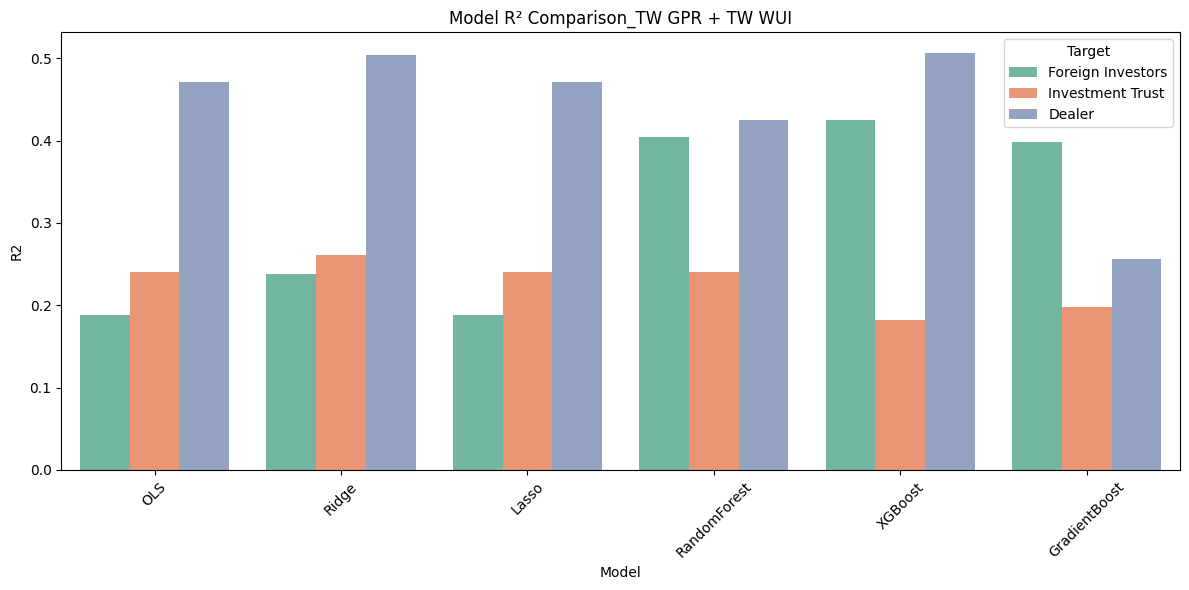

In [ ]:
features_try = [
    "GPRHC_TWN_lag1", "twwui_lag1",
    "GPRHC_TWN_lag2", "twwui_lag2",
    "LogReturn_lag1", "Volume_lag1",
    "VIX_Monthly_Max",
    "Business_Signal_pct_change",
    "sp500LogReturn", "hsiLogReturn", "nikkeiLogReturn",
    "USD_TWD_ExchangeRate", "Gold_Monthly_AvgPrice", "Interest_Rate_Spread",
    "Dealer_lag1", "Investment Trust_lag1", "Foreign Investors_lag1",
    "log_CPI"
]

targets = ["Foreign Investors", "Investment Trust", "Dealer"]

models = {
    "OLS": LinearRegression(),
    "Ridge": Ridge(alpha=1.0),
    "Lasso": Lasso(alpha=0.01),
    "RandomForest": RandomForestRegressor(n_estimators=100, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=100, random_state=42, verbosity=0),
    "GradientBoost": GradientBoostingRegressor(n_estimators=100, random_state=42)
}

df = df_scaled

all_results = []

for target in targets:
    df_model = df[features_try + [target]].dropna()
    X = df_model[features_try]
    y = df_model[target]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        r2 = r2_score(y_test, y_pred)

        all_results.append({
            "Target": target,
            "Model": name,
            "R2": round(r2, 4)
        })
results_df = pd.DataFrame(all_results)

plt.figure(figsize=(12, 6))
sns.barplot(data=results_df, x="Model", y="R2", hue="Target", palette="Set2")
plt.title("Model R² Comparison_TW GPR + TW WUI")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### 5.ALL

In [ ]:
import statsmodels.api as sm
models = {
    "Try": [
        "GPRHC_TWN_lag1", "GEPU_current_lag1",
        "GPRHC_TWN_lag2", "GEPU_current_lag2",
        "usepu_lag1",
        "usepu_lag2",
        "GPRHC_USA_lag1",
        "GPRHC_USA_lag2",        
        "twwui_lag1",
        "twwui_lag2",
        "LogReturn_lag1", "Volume_lag1",
        "VIX_Monthly_Max",
        "Business_Signal_pct_change",
        "sp500LogReturn","hsiLogReturn","nikkeiLogReturn","USD_TWD_ExchangeRate", "Gold_Monthly_AvgPrice", "Interest_Rate_Spread",
        "Dealer_lag1", "Investment Trust_lag1", "Foreign Investors_lag1",
        "log_CPI"
    ],       
    
}


# 三大法人  
targets = [
    "Foreign Investors",
    "Investment Trust",
    "Dealer"
]


for target in targets:
    print(f"\n===================================")
    print(f"      回歸結果：{target}")
    print(f"===================================")
    
    for model_name, var_list in models.items():
        print(f"\n--- Model: {model_name} ---")
        data = df_scaled[var_list + [target]].dropna()
        X = sm.add_constant(data[var_list])
        y = data[target]
        model = sm.OLS(y, X).fit()
        print(model.summary())


      回歸結果：Foreign Investors

--- Model: Try ---
                            OLS Regression Results                            
Dep. Variable:      Foreign Investors   R-squared:                       0.495
Model:                            OLS   Adj. R-squared:                  0.429
Method:                 Least Squares   F-statistic:                     7.479
Date:                Wed, 16 Apr 2025   Prob (F-statistic):           1.11e-15
Time:                        12:56:38   Log-Likelihood:                -5030.4
No. Observations:                 191   AIC:                         1.011e+04
Df Residuals:                     168   BIC:                         1.018e+04
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

X = df_scaled[[ 
        "GPRHC_TWN_lag1", "GEPU_current_lag1",
        "GPRHC_TWN_lag2", "GEPU_current_lag2",
        "usepu_lag1",
        "usepu_lag2",
        "GPRHC_USA_lag1",
        "GPRHC_USA_lag2",        
        "twwui_lag1",
        "twwui_lag2",
        "LogReturn_lag1", "Volume_lag1",
        "VIX_Monthly_Max",
        "Business_Signal_pct_change",
        "sp500LogReturn","hsiLogReturn","nikkeiLogReturn","USD_TWD_ExchangeRate", "Gold_Monthly_AvgPrice", "Interest_Rate_Spread",
        "Dealer_lag1", "Investment Trust_lag1", "Foreign Investors_lag1",
        "log_CPI"
               ]
       ]
X = sm.add_constant(X)
vif = pd.DataFrame()
vif["feature"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


feature           VIF
0                        const  0.000000e+00
1                    GPRHC_TWN  3.407438e+00
2               GPRHC_TWN_lag1  3.692288e+00
3            GEPU_current_lag1  1.342945e+01
4               GPRHC_TWN_lag2  3.400487e+00
5            GEPU_current_lag2  1.334533e+01
6                   usepu_lag1  6.696512e+00
7                   usepu_lag2  6.543256e+00
8               GPRHC_USA_lag1  1.238955e+13
9               GPRHC_USA_lag2  1.524061e+13
10                  twwui_lag1  9.070694e+12
11                  twwui_lag2  5.566872e+12
12              LogReturn_lag1  2.193677e+00
13                 Volume_lag1  1.668385e+00
14             VIX_Monthly_Max  2.734790e+00
15  Business_Signal_pct_change  1.285663e+00
16              sp500LogReturn  3.369773e+00
17                hsiLogReturn  1.612501e+00
18             nikkeiLogReturn  2.333251e+00
19        USD_TWD_ExchangeRate  1.368769e+00
20       Gold_Monthly_AvgPrice  3.737667e+00
21        Interest_Rate_Spread  5.044325e+00
22                 Dealer_lag1  2.589946e+00
23       Investment Trust_lag1  2.884992e+00
24      Foreign Investors_lag1  2.186298e+00
25                     log_CPI  9.398553e+00

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=6.50123e-25): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.281e+23, tolerance: 1.342e+20
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.406e+23, tolerance: 1.342e+

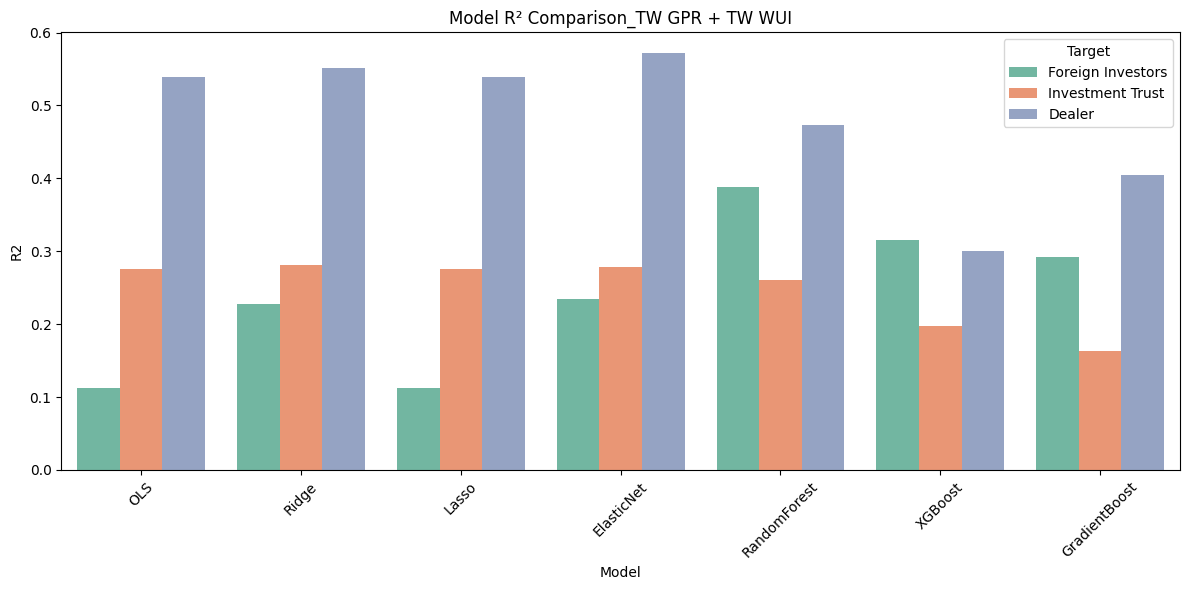

In [ ]:
features_try = [
        "GPRHC_TWN_lag1", "GEPU_current_lag1",
        "GPRHC_TWN_lag2", "GEPU_current_lag2",
        "usepu_lag1",
        "usepu_lag2",
        "GPRHC_USA_lag1",
        "GPRHC_USA_lag2",        
        "twwui_lag1",
        "twwui_lag2",
        "LogReturn_lag1", "Volume_lag1",
        "VIX_Monthly_Max",
        "Business_Signal_pct_change",
        "sp500LogReturn","hsiLogReturn","nikkeiLogReturn","USD_TWD_ExchangeRate", "Gold_Monthly_AvgPrice", "Interest_Rate_Spread",
        "Dealer_lag1", "Investment Trust_lag1", "Foreign Investors_lag1",
        "log_CPI"
]

targets = ["Foreign Investors", "Investment Trust", "Dealer"]

models = {
    "OLS": LinearRegression(),
    "Ridge": Ridge(alpha=1.0),
    "Lasso": Lasso(alpha=0.01),
    "ElasticNet": ElasticNet(),
    "RandomForest": RandomForestRegressor(n_estimators=100, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=100, random_state=42, verbosity=0),
    "GradientBoost": GradientBoostingRegressor(n_estimators=100, random_state=42)
}

df = df_scaled

all_results = []

for target in targets:
    df_model = df[features_try + [target]].dropna()
    X = df_model[features_try]
    y = df_model[target]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        r2 = r2_score(y_test, y_pred)

        all_results.append({
            "Target": target,
            "Model": name,
            "R2": round(r2, 4)
        })
results_df = pd.DataFrame(all_results)

plt.figure(figsize=(12, 6))
sns.barplot(data=results_df, x="Model", y="R2", hue="Target", palette="Set2")
plt.title("Model R² Comparison_TW GPR + TW WUI")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
import statsmodels.api as sm
models = {
    "Try": [
        "GPRHC_TWN_lag1", "GEPU_current_lag1",
        "GPRHC_TWN_lag2", "GEPU_current_lag2",
        "usepu_lag1",
        "usepu_lag2",
        "LogReturn_lag1", "Volume_lag1",
        "VIX_Monthly_Max",
        "Business_Signal_pct_change",
        "sp500LogReturn","hsiLogReturn","nikkeiLogReturn","USD_TWD_ExchangeRate", "Gold_Monthly_AvgPrice", "Interest_Rate_Spread",
        "Dealer_lag1", "Investment Trust_lag1", "Foreign Investors_lag1",
        "log_CPI"
    ],       
    
}

# 三大法人  
targets = [
    "Foreign Investors",
    "Investment Trust",
    "Dealer"
]


for target in targets:
    print(f"\n===================================")
    print(f"      回歸結果：{target}")
    print(f"===================================")
    
    for model_name, var_list in models.items():
        print(f"\n--- Model: {model_name} ---")
        data = df_scaled[var_list + [target]].dropna()
        X = sm.add_constant(data[var_list])
        y = data[target]
        model = sm.OLS(y, X).fit()
        print(model.summary())


      回歸結果：Foreign Investors

--- Model: Try ---
                            OLS Regression Results                            
Dep. Variable:      Foreign Investors   R-squared:                       0.487
Model:                            OLS   Adj. R-squared:                  0.426
Method:                 Least Squares   F-statistic:                     8.057
Date:                Wed, 16 Apr 2025   Prob (F-statistic):           4.46e-16
Time:                        13:21:09   Log-Likelihood:                -5032.0
No. Observations:                 191   AIC:                         1.011e+04
Df Residuals:                     170   BIC:                         1.017e+04
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

X = df_scaled[[
        "GPRHC_TWN_lag1", "GEPU_current_lag1",
        "GPRHC_TWN_lag2", 
        "usepu_lag1",
        "usepu_lag2",
        "LogReturn_lag1", "Volume_lag1",
        "VIX_Monthly_Max",
        "Business_Signal_pct_change",
        "sp500LogReturn","hsiLogReturn","nikkeiLogReturn","USD_TWD_ExchangeRate", "Gold_Monthly_AvgPrice", "Interest_Rate_Spread",
        "Dealer_lag1", "Investment Trust_lag1", "Foreign Investors_lag1",
        "log_CPI"

    ]]
        
X = sm.add_constant(X)
vif = pd.DataFrame()
vif["feature"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


feature       VIF
0                        const  0.000000
1               GPRHC_TWN_lag1  2.898964
2            GEPU_current_lag1  9.005055
3               GPRHC_TWN_lag2  3.003384
4                   usepu_lag1  5.712371
5                   usepu_lag2  2.470663
6               LogReturn_lag1  2.147625
7                  Volume_lag1  1.443252
8              VIX_Monthly_Max  3.123067
9   Business_Signal_pct_change  1.229668
10              sp500LogReturn  4.169404
11                hsiLogReturn  1.913035
12             nikkeiLogReturn  2.835909
13        USD_TWD_ExchangeRate  1.341225
14       Gold_Monthly_AvgPrice  3.914147
15        Interest_Rate_Spread  4.931193
16                 Dealer_lag1  2.497089
17       Investment Trust_lag1  2.495590
18      Foreign Investors_lag1  1.967939
19                     log_CPI  8.586171

# 用標準化 data

In [ ]:
df_standardized = df_standardized.dropna()

### 1. 台灣 GPR + Global EPU  , w/ 美國 VIX

In [ ]:
import statsmodels.api as sm
models = {
    "Current": [
        "GPRHC_TWN", "GEPU_current",
        "LogReturn_lag1", "Volume_lag1",
        "VIX_Monthly_Max",
        "Business_Signal_pct_change",
        "sp500LogReturn","hsiLogReturn","nikkeiLogReturn","USD_TWD_ExchangeRate", "Gold_Monthly_AvgPrice", "Interest_Rate_Spread",
        "Dealer_lag1", "Investment Trust_lag1", "Foreign Investors_lag1",
        "log_CPI"
    ],
    "Lag": [
        "GPRHC_TWN_lag1", "GEPU_current_lag1",
        "GPRHC_TWN_lag2", "GEPU_current_lag2",
        "LogReturn_lag1", "Volume_lag1",
        "VIX_Monthly_Max",
        "Business_Signal_pct_change",
        "sp500LogReturn","hsiLogReturn","nikkeiLogReturn","USD_TWD_ExchangeRate", "Gold_Monthly_AvgPrice", "Interest_Rate_Spread",
        "Dealer_lag1", "Investment Trust_lag1", "Foreign Investors_lag1",
        "log_CPI"
    ],       
}

# 三大法人  
targets = [
    "Foreign Investors",
    "Investment Trust",
    "Dealer"
]


for target in targets:
    print(f"\n===================================")
    print(f"      回歸結果：{target}")
    print(f"===================================")
    
    for model_name, var_list in models.items():
        print(f"\n--- Model: {model_name} ---")
        data = df_standardized[var_list + [target]].dropna()
        X = sm.add_constant(data[var_list])
        y = data[target]
        model = sm.OLS(y, X).fit()
        print(model.summary())


      回歸結果：Foreign Investors

--- Model: Current ---
                            OLS Regression Results                            
Dep. Variable:      Foreign Investors   R-squared:                       0.437
Model:                            OLS   Adj. R-squared:                  0.386
Method:                 Least Squares   F-statistic:                     8.548
Date:                Thu, 17 Apr 2025   Prob (F-statistic):           3.99e-15
Time:                        12:29:47   Log-Likelihood:                -5092.3
No. Observations:                 193   AIC:                         1.022e+04
Df Residuals:                     176   BIC:                         1.027e+04
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

X = df_standardized[[ 
        "GPRHC_TWN", "GEPU_current",
        "LogReturn_lag1", "Volume_lag1",
        "VIX_Monthly_Max",
        "Business_Signal_pct_change",
        "sp500LogReturn","hsiLogReturn","nikkeiLogReturn","USD_TWD_ExchangeRate", "Gold_Monthly_AvgPrice", "Interest_Rate_Spread",
        "Dealer_lag1", "Investment Trust_lag1", "Foreign Investors_lag1",
        "log_CPI"
               ]
       ]
X = sm.add_constant(X)
vif = pd.DataFrame()
vif["feature"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif

feature           VIF
0                        const  53030.168247
1                    GPRHC_TWN      2.421075
2                 GEPU_current      2.932370
3               LogReturn_lag1      2.059592
4                  Volume_lag1      1.482922
5              VIX_Monthly_Max      2.928925
6   Business_Signal_pct_change      1.190059
7               sp500LogReturn      4.006026
8                 hsiLogReturn      1.908285
9              nikkeiLogReturn      2.807863
10        USD_TWD_ExchangeRate      1.331443
11       Gold_Monthly_AvgPrice      3.640117
12        Interest_Rate_Spread      4.209015
13                 Dealer_lag1      2.500055
14       Investment Trust_lag1      2.582721
15      Foreign Investors_lag1      2.016786
16                     log_CPI      7.454698

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

X = df_standardized[[ 
        "GPRHC_TWN_lag1", "GEPU_current_lag1",
        "GPRHC_TWN_lag2", "GEPU_current_lag2",
        "LogReturn_lag1", "Volume_lag1",
        "VIX_Monthly_Max",
        "Business_Signal_pct_change",
        "sp500LogReturn","hsiLogReturn","nikkeiLogReturn","USD_TWD_ExchangeRate", "Gold_Monthly_AvgPrice", "Interest_Rate_Spread",
        "Dealer_lag1", "Investment Trust_lag1", "Foreign Investors_lag1",
        "log_CPI"
               ]
       ]
X = sm.add_constant(X)
vif = pd.DataFrame()
vif["feature"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif

feature           VIF
0                        const  54777.796456
1               GPRHC_TWN_lag1      2.897488
2            GEPU_current_lag1      5.417643
3               GPRHC_TWN_lag2      2.929425
4            GEPU_current_lag2      5.125615
5               LogReturn_lag1      2.124917
6                  Volume_lag1      1.450903
7              VIX_Monthly_Max      2.912258
8   Business_Signal_pct_change      1.221742
9               sp500LogReturn      4.077589
10                hsiLogReturn      1.914902
11             nikkeiLogReturn      2.820241
12        USD_TWD_ExchangeRate      1.341324
13       Gold_Monthly_AvgPrice      3.675449
14        Interest_Rate_Spread      4.760586
15                 Dealer_lag1      2.425114
16       Investment Trust_lag1      2.496237
17      Foreign Investors_lag1      1.971324
18                     log_CPI      7.700540

In [ ]:
# features_try = [
#         "GPRHC_TWN", "GEPU_current",
#         "LogReturn_lag1", "Volume_lag1",
#         "VIX_Monthly_Max",
#         "Business_Signal_pct_change",
#         "sp500LogReturn","hsiLogReturn","nikkeiLogReturn","USD_TWD_ExchangeRate", "Gold_Monthly_AvgPrice", "Interest_Rate_Spread",
#         "Dealer_lag1", "Investment Trust_lag1", "Foreign Investors_lag1",
#         "log_CPI"
# ]

# targets = ["Foreign Investors", "Investment Trust", "Dealer"]

# models = {
#     "OLS": LinearRegression(),
#     "Ridge": Ridge(alpha=1.0),
#     "Lasso": Lasso(alpha=0.01),
#     "RandomForest": RandomForestRegressor(n_estimators=100, random_state=42),
#     "XGBoost": XGBRegressor(n_estimators=100, random_state=42, verbosity=0),
#     "GradientBoost": GradientBoostingRegressor(n_estimators=100, random_state=42)
# }

# df = df_standardized

# all_results = []

# for target in targets:
#     df_model = df[features_try + [target]].dropna()
#     X = df_model[features_try]
#     y = df_model[target]

#     X_train, X_test, y_train, y_test = train_test_split(
#         X, y, test_size=0.2, random_state=42
#     )

#     for name, model in models.items():
#         model.fit(X_train, y_train)
#         y_pred = model.predict(X_test)
#         r2 = r2_score(y_test, y_pred)

#         all_results.append({
#             "Target": target,
#             "Model": name,
#             "R2": round(r2, 4)
#         })
# results_df = pd.DataFrame(all_results)

# plt.figure(figsize=(12, 6))
# sns.barplot(data=results_df, x="Model", y="R2", hue="Target", palette="Set2")
# plt.title("Model R² Comparison_Current TW GPR + TW WUI")
# plt.xticks(rotation=45)
# plt.tight_layout()
# plt.show()

In [ ]:
# features_try = [
#     "GPRHC_TWN", "GEPU_current",
#     "LogReturn_lag1", "Volume_lag1",
#     "VIX_Monthly_Max",
#     "Business_Signal_pct_change",
#     "sp500LogReturn", "hsiLogReturn", "nikkeiLogReturn",
#     "USD_TWD_ExchangeRate", "Gold_Monthly_AvgPrice", "Interest_Rate_Spread",
#     "Dealer_lag1", "Investment Trust_lag1", "Foreign Investors_lag1",
#     "log_CPI"
# ]

# targets = ["Foreign Investors", "Investment Trust", "Dealer"]

# models = {
#     "OLS": LinearRegression(),
#     "Ridge": Ridge(alpha=1.0),
#     "Lasso": Lasso(alpha=0.01),
#     "RandomForest": RandomForestRegressor(n_estimators=100, random_state=42),
#     "XGBoost": XGBRegressor(n_estimators=100, random_state=42, verbosity=0),
#     "GradientBoost": GradientBoostingRegressor(n_estimators=100, random_state=42)
# }

# all_results = []

# for target in targets:
#     for name, model in models.items():
#         # 隨機森林用沒有標準化過的 data
#         if name == "RandomForest":
#             df_model = df_scaled[features_try + [target]].dropna()
#         else:
#             df_model = df_standardized[features_try + [target]].dropna()

#         X = df_model[features_try]
#         y = df_model[target]

#         X_train, X_test, y_train, y_test = train_test_split(
#             X, y, test_size=0.2, random_state=42
#         )

#         model.fit(X_train, y_train)
#         y_pred = model.predict(X_test)
#         r2 = r2_score(y_test, y_pred)

#         all_results.append({
#             "Target": target,
#             "Model": name,
#             "R2": round(r2, 4)
#         })

# results_df = pd.DataFrame(all_results)

# plt.figure(figsize=(12, 6))
# sns.barplot(data=results_df, x="Model", y="R2", hue="Target", palette="Set2")
# plt.title("Model R² Comparison (Standardized vs Scaled)")
# plt.xticks(rotation=45)
# plt.tight_layout()
# plt.show()


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_su

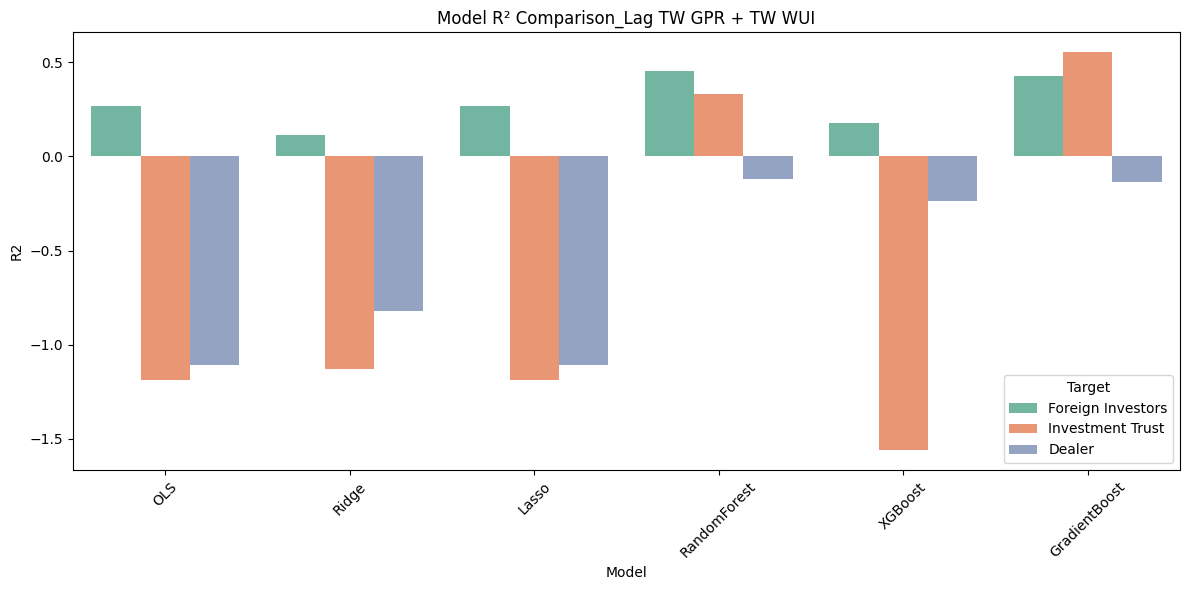

In [ ]:
features_try = [
        "GPRHC_TWN_lag1", "GEPU_current_lag1",
        "GPRHC_TWN_lag2", "GEPU_current_lag2",
        "LogReturn_lag1", "Volume_lag1",
        "VIX_Monthly_Max",
        "Business_Signal_pct_change",
        "sp500LogReturn","hsiLogReturn","nikkeiLogReturn","USD_TWD_ExchangeRate", "Gold_Monthly_AvgPrice", "Interest_Rate_Spread",
        "Dealer_lag1", "Investment Trust_lag1", "Foreign Investors_lag1",
        "log_CPI"
]

targets = ["Foreign Investors", "Investment Trust", "Dealer"]

models = {
    "OLS": LinearRegression(),
    "Ridge": Ridge(alpha=1.0),
    "Lasso": Lasso(alpha=0.01),
    "RandomForest": RandomForestRegressor(n_estimators=100, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=100, random_state=42, verbosity=0),
    "GradientBoost": GradientBoostingRegressor(n_estimators=100, random_state=42)
}

df = df_standardized

all_results = []

for target in targets:
    df_model = df[features_try + [target]].dropna()
    X = df_model[features_try]
    y = df_model[target]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        r2 = r2_score(y_test, y_pred)

        all_results.append({
            "Target": target,
            "Model": name,
            "R2": round(r2, 4)
        })
results_df = pd.DataFrame(all_results)

plt.figure(figsize=(12, 6))
sns.barplot(data=results_df, x="Model", y="R2", hue="Target", palette="Set2")
plt.title("Model R² Comparison_Lag TW GPR + TW WUI")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### 2. 台灣 GPR + US EPU  , w/ 美國 VIX

In [ ]:
import statsmodels.api as sm
models = {
    "Current": [
        "GPRHC_TWN", "usepu",
        "LogReturn_lag1", "Volume_lag1",
        "VIX_Monthly_Max",
        "Business_Signal_pct_change",
        "sp500LogReturn","hsiLogReturn","nikkeiLogReturn","USD_TWD_ExchangeRate", "Gold_Monthly_AvgPrice", "Interest_Rate_Spread",
        "Dealer_lag1", "Investment Trust_lag1", "Foreign Investors_lag1",
        "log_CPI"
    ],
    "Lag": [
        "GPRHC_TWN_lag1", "usepu_lag1",
        "GPRHC_TWN_lag2", "usepu_lag2",
        "LogReturn_lag1", "Volume_lag1",
        "VIX_Monthly_Max",
        "Business_Signal_pct_change",
        "sp500LogReturn","hsiLogReturn","nikkeiLogReturn","USD_TWD_ExchangeRate", "Gold_Monthly_AvgPrice", "Interest_Rate_Spread",
        "Dealer_lag1", "Investment Trust_lag1", "Foreign Investors_lag1",
        "log_CPI"
    ],       
}

# 三大法人  
targets = [
    "Foreign Investors",
    "Investment Trust",
    "Dealer"
]


for target in targets:
    print(f"\n===================================")
    print(f"      回歸結果：{target}")
    print(f"===================================")
    
    for model_name, var_list in models.items():
        print(f"\n--- Model: {model_name} ---")
        data = df_standardized[var_list + [target]].dropna()
        X = sm.add_constant(data[var_list])
        y = data[target]
        model = sm.OLS(y, X).fit()
        print(model.summary())


      回歸結果：Foreign Investors

--- Model: Current ---
                            OLS Regression Results                            
Dep. Variable:      Foreign Investors   R-squared:                       0.437
Model:                            OLS   Adj. R-squared:                  0.386
Method:                 Least Squares   F-statistic:                     8.530
Date:                Thu, 17 Apr 2025   Prob (F-statistic):           4.29e-15
Time:                        12:30:54   Log-Likelihood:                -5092.4
No. Observations:                 193   AIC:                         1.022e+04
Df Residuals:                     176   BIC:                         1.027e+04
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

X = df_standardized[[ 
        "GPRHC_TWN", "usepu",
        "LogReturn_lag1", "Volume_lag1",
        "VIX_Monthly_Max",
        "Business_Signal_pct_change",
        "sp500LogReturn","hsiLogReturn","nikkeiLogReturn","USD_TWD_ExchangeRate", "Gold_Monthly_AvgPrice", "Interest_Rate_Spread",
        "Dealer_lag1", "Investment Trust_lag1", "Foreign Investors_lag1",
        "log_CPI"
               ]
       ]
X = sm.add_constant(X)
vif = pd.DataFrame()
vif["feature"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif

feature           VIF
0                        const  43731.198508
1                    GPRHC_TWN      2.422424
2                        usepu      1.828357
3               LogReturn_lag1      2.043970
4                  Volume_lag1      1.475995
5              VIX_Monthly_Max      3.030587
6   Business_Signal_pct_change      1.192242
7               sp500LogReturn      3.963229
8                 hsiLogReturn      1.908392
9              nikkeiLogReturn      2.808832
10        USD_TWD_ExchangeRate      1.331454
11       Gold_Monthly_AvgPrice      3.763396
12        Interest_Rate_Spread      4.236652
13                 Dealer_lag1      2.540170
14       Investment Trust_lag1      2.533979
15      Foreign Investors_lag1      1.982926
16                     log_CPI      6.175548

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

X = df_standardized[[ 
        "GPRHC_TWN_lag1", "usepu_lag1",
        "GPRHC_TWN_lag2", "usepu_lag2",
        "LogReturn_lag1", "Volume_lag1",
        "VIX_Monthly_Max",
        "Business_Signal_pct_change",
        "sp500LogReturn","hsiLogReturn","nikkeiLogReturn","USD_TWD_ExchangeRate", "Gold_Monthly_AvgPrice", "Interest_Rate_Spread",
        "Dealer_lag1", "Investment Trust_lag1", "Foreign Investors_lag1",
        "log_CPI"
               ]
       ]
X = sm.add_constant(X)
vif = pd.DataFrame()
vif["feature"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif

feature           VIF
0                        const  44281.212361
1               GPRHC_TWN_lag1      2.898654
2                   usepu_lag1      2.489479
3               GPRHC_TWN_lag2      2.959255
4                   usepu_lag2      2.299089
5               LogReturn_lag1      2.147504
6                  Volume_lag1      1.433039
7              VIX_Monthly_Max      3.121717
8   Business_Signal_pct_change      1.223344
9               sp500LogReturn      4.165104
10                hsiLogReturn      1.887046
11             nikkeiLogReturn      2.835202
12        USD_TWD_ExchangeRate      1.341194
13       Gold_Monthly_AvgPrice      3.829991
14        Interest_Rate_Spread      4.850508
15                 Dealer_lag1      2.472623
16       Investment Trust_lag1      2.454816
17      Foreign Investors_lag1      1.966689
18                     log_CPI      6.225431

### 3. 美國 GPR + 美國 EPU  , w/ 美國 VIX

In [ ]:
import statsmodels.api as sm
models = {
    "Current": [
        "GPRHC_USA", "usepu",
        "LogReturn_lag1", "Volume_lag1",
        "VIX_Monthly_Max",
        "Business_Signal_pct_change",
        "sp500LogReturn","hsiLogReturn","nikkeiLogReturn","USD_TWD_ExchangeRate", "Gold_Monthly_AvgPrice", "Interest_Rate_Spread",
        "Dealer_lag1", "Investment Trust_lag1", "Foreign Investors_lag1",
        "log_CPI"
    ],
    "Lag": [
        "GPRHC_USA_lag1", "usepu_lag1",
        "GPRHC_USA_lag2", "usepu_lag2",
        "LogReturn_lag1", "Volume_lag1",
        "VIX_Monthly_Max",
        "Business_Signal_pct_change",
        "sp500LogReturn","hsiLogReturn","nikkeiLogReturn","USD_TWD_ExchangeRate", "Gold_Monthly_AvgPrice", "Interest_Rate_Spread",
        "Dealer_lag1", "Investment Trust_lag1", "Foreign Investors_lag1",
        "log_CPI"
    ],       
}

# 三大法人  
targets = [
    "Foreign Investors",
    "Investment Trust",
    "Dealer"
]


for target in targets:
    print(f"\n===================================")
    print(f"      回歸結果：{target}")
    print(f"===================================")
    
    for model_name, var_list in models.items():
        print(f"\n--- Model: {model_name} ---")
        data = df_standardized[var_list + [target]].dropna()
        X = sm.add_constant(data[var_list])
        y = data[target]
        model = sm.OLS(y, X).fit()
        print(model.summary())


      回歸結果：Foreign Investors

--- Model: Current ---
                            OLS Regression Results                            
Dep. Variable:      Foreign Investors   R-squared:                       0.437
Model:                            OLS   Adj. R-squared:                  0.386
Method:                 Least Squares   F-statistic:                     8.530
Date:                Thu, 17 Apr 2025   Prob (F-statistic):           4.29e-15
Time:                        11:35:46   Log-Likelihood:                -5092.4
No. Observations:                 193   AIC:                         1.022e+04
Df Residuals:                     176   BIC:                         1.027e+04
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

X = df_standardized[[ 
        "GPRHC_USA", "usepu",
        "LogReturn_lag1", "Volume_lag1",
        "VIX_Monthly_Max",
        "Business_Signal_pct_change",
        "sp500LogReturn","hsiLogReturn","nikkeiLogReturn","USD_TWD_ExchangeRate", "Gold_Monthly_AvgPrice", "Interest_Rate_Spread",
        "Dealer_lag1", "Investment Trust_lag1", "Foreign Investors_lag1",
        "log_CPI"
               ]
       ]
X = sm.add_constant(X)
vif = pd.DataFrame()
vif["feature"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif

feature           VIF
0                        const  43712.368152
1                    GPRHC_USA      1.547070
2                        usepu      1.911111
3               LogReturn_lag1      2.013526
4                  Volume_lag1      1.539025
5              VIX_Monthly_Max      2.984361
6   Business_Signal_pct_change      1.198163
7               sp500LogReturn      3.960458
8                 hsiLogReturn      1.905647
9              nikkeiLogReturn      2.738227
10        USD_TWD_ExchangeRate      1.354367
11       Gold_Monthly_AvgPrice      3.719885
12        Interest_Rate_Spread      3.906480
13                 Dealer_lag1      2.389406
14       Investment Trust_lag1      2.475429
15      Foreign Investors_lag1      1.976111
16                     log_CPI      6.240301

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

X = df_standardized[[ 
        "GPRHC_USA_lag1", "usepu_lag1",
        "GPRHC_USA_lag2", "usepu_lag2",
        "LogReturn_lag1", "Volume_lag1",
        "VIX_Monthly_Max",
        "Business_Signal_pct_change",
        "sp500LogReturn","hsiLogReturn","nikkeiLogReturn","USD_TWD_ExchangeRate", "Gold_Monthly_AvgPrice", "Interest_Rate_Spread",
        "Dealer_lag1", "Investment Trust_lag1", "Foreign Investors_lag1",
        "log_CPI"
               ]
       ]
X = sm.add_constant(X)
vif = pd.DataFrame()
vif["feature"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif

feature           VIF
0                        const  45299.733184
1               GPRHC_USA_lag1      2.106964
2                   usepu_lag1      2.480231
3               GPRHC_USA_lag2      2.255505
4                   usepu_lag2      2.292533
5               LogReturn_lag1      2.088259
6                  Volume_lag1      1.429801
7              VIX_Monthly_Max      3.101342
8   Business_Signal_pct_change      1.212376
9               sp500LogReturn      4.223640
10                hsiLogReturn      1.879025
11             nikkeiLogReturn      2.822814
12        USD_TWD_ExchangeRate      1.375226
13       Gold_Monthly_AvgPrice      3.689996
14        Interest_Rate_Spread      3.971783
15                 Dealer_lag1      2.387582
16       Investment Trust_lag1      2.462539
17      Foreign Investors_lag1      2.025411
18                     log_CPI      6.368692

### 4. 台灣 GPR + 台灣 WUI  , w/ 美國 VIX

In [ ]:
import statsmodels.api as sm
models = {
    "Current": [
        "GPRHC_TWN", "twwui",
        "LogReturn_lag1", "Volume_lag1",
        "VIX_Monthly_Max",
        "Business_Signal_pct_change",
        "sp500LogReturn","hsiLogReturn","nikkeiLogReturn","USD_TWD_ExchangeRate", "Gold_Monthly_AvgPrice", "Interest_Rate_Spread",
        "Dealer_lag1", "Investment Trust_lag1", "Foreign Investors_lag1",
        "log_CPI"
    ],
    "Lag": [
        "GPRHC_TWN_lag1", "twwui_lag1",
        "GPRHC_TWN_lag2", "twwui_lag2",
        "LogReturn_lag1", "Volume_lag1",
        "VIX_Monthly_Max",
        "Business_Signal_pct_change",
        "sp500LogReturn","hsiLogReturn","nikkeiLogReturn","USD_TWD_ExchangeRate", "Gold_Monthly_AvgPrice", "Interest_Rate_Spread",
        "Dealer_lag1", "Investment Trust_lag1", "Foreign Investors_lag1",
        "log_CPI"
    ],       
}

# 三大法人  
targets = [
    "Foreign Investors",
    "Investment Trust",
    "Dealer"
]


for target in targets:
    print(f"\n===================================")
    print(f"      回歸結果：{target}")
    print(f"===================================")
    
    for model_name, var_list in models.items():
        print(f"\n--- Model: {model_name} ---")
        data = df_standardized[var_list + [target]].dropna()
        X = sm.add_constant(data[var_list])
        y = data[target]
        model = sm.OLS(y, X).fit()
        print(model.summary())


      回歸結果：Foreign Investors

--- Model: Current ---
                            OLS Regression Results                            
Dep. Variable:      Foreign Investors   R-squared:                       0.448
Model:                            OLS   Adj. R-squared:                  0.398
Method:                 Least Squares   F-statistic:                     8.944
Date:                Thu, 17 Apr 2025   Prob (F-statistic):           8.10e-16
Time:                        12:33:06   Log-Likelihood:                -5090.4
No. Observations:                 193   AIC:                         1.021e+04
Df Residuals:                     176   BIC:                         1.027e+04
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

X = df_standardized[[ 
        "GPRHC_TWN", "twwui",
        "LogReturn_lag1", "Volume_lag1",
        "VIX_Monthly_Max",
        "Business_Signal_pct_change",
        "sp500LogReturn","hsiLogReturn","nikkeiLogReturn","USD_TWD_ExchangeRate", "Gold_Monthly_AvgPrice", "Interest_Rate_Spread",
        "Dealer_lag1", "Investment Trust_lag1", "Foreign Investors_lag1",
        "log_CPI"
               ]
       ]
X = sm.add_constant(X)
vif = pd.DataFrame()
vif["feature"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif

feature           VIF
0                        const  42990.008146
1                    GPRHC_TWN      2.731088
2                        twwui      1.413953
3               LogReturn_lag1      2.006922
4                  Volume_lag1      1.419118
5              VIX_Monthly_Max      2.247710
6   Business_Signal_pct_change      1.196914
7               sp500LogReturn      3.899740
8                 hsiLogReturn      1.923659
9              nikkeiLogReturn      2.822081
10        USD_TWD_ExchangeRate      1.337969
11       Gold_Monthly_AvgPrice      3.599776
12        Interest_Rate_Spread      5.045277
13                 Dealer_lag1      2.474423
14       Investment Trust_lag1      2.518700
15      Foreign Investors_lag1      1.922126
16                     log_CPI      6.047421

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

X = df_standardized[[ 
        "GPRHC_TWN_lag1", "twwui_lag1",
        "GPRHC_TWN_lag2", "twwui_lag2",
        "LogReturn_lag1", "Volume_lag1",
        "VIX_Monthly_Max",
        "Business_Signal_pct_change",
        "sp500LogReturn","hsiLogReturn","nikkeiLogReturn","USD_TWD_ExchangeRate", "Gold_Monthly_AvgPrice", "Interest_Rate_Spread",
        "Dealer_lag1", "Investment Trust_lag1", "Foreign Investors_lag1",
        "log_CPI"
               ]
       ]
X = sm.add_constant(X)
vif = pd.DataFrame()
vif["feature"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif

feature           VIF
0                        const  43350.473069
1               GPRHC_TWN_lag1      3.284228
2                   twwui_lag1      2.268818
3               GPRHC_TWN_lag2      3.239892
4                   twwui_lag2      2.513568
5               LogReturn_lag1      2.001983
6                  Volume_lag1      1.429924
7              VIX_Monthly_Max      2.206898
8   Business_Signal_pct_change      1.221221
9               sp500LogReturn      4.053407
10                hsiLogReturn      1.885921
11             nikkeiLogReturn      2.799870
12        USD_TWD_ExchangeRate      1.377542
13       Gold_Monthly_AvgPrice      3.696979
14        Interest_Rate_Spread      4.831719
15                 Dealer_lag1      2.427056
16       Investment Trust_lag1      2.433369
17      Foreign Investors_lag1      1.993726
18                     log_CPI      6.096368

## 輸出全部結果

In [ ]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor


targets = ["Foreign Investors", "Investment Trust", "Dealer"]


model_sets = {
    "TW GPR + Global EPU": {
        "Current": [
            "GPRHC_TWN", "GEPU_current", "LogReturn_lag1", "Volume_lag1",
            "VIX_Monthly_Max", "Business_Signal_pct_change", "sp500LogReturn",
            "hsiLogReturn", "nikkeiLogReturn", "USD_TWD_ExchangeRate",
            "Gold_Monthly_AvgPrice", "Interest_Rate_Spread",
            "Dealer_lag1", "Investment Trust_lag1", "Foreign Investors_lag1",
            "log_CPI"
        ],
        "Lag": [
            "GPRHC_TWN_lag1", "GEPU_current_lag1", "GPRHC_TWN_lag2", "GEPU_current_lag2",
            "LogReturn_lag1", "Volume_lag1", "VIX_Monthly_Max", "Business_Signal_pct_change",
            "sp500LogReturn", "hsiLogReturn", "nikkeiLogReturn", "USD_TWD_ExchangeRate",
            "Gold_Monthly_AvgPrice", "Interest_Rate_Spread",
            "Dealer_lag1", "Investment Trust_lag1", "Foreign Investors_lag1",
            "log_CPI"
        ]
    },
    "TW GPR + US EPU": {
        "Current": [
            "GPRHC_TWN", "usepu", "LogReturn_lag1", "Volume_lag1",
            "VIX_Monthly_Max", "Business_Signal_pct_change", "sp500LogReturn",
            "hsiLogReturn", "nikkeiLogReturn", "USD_TWD_ExchangeRate",
            "Gold_Monthly_AvgPrice", "Interest_Rate_Spread",
            "Dealer_lag1", "Investment Trust_lag1", "Foreign Investors_lag1",
            "log_CPI"
        ],
        "Lag": [
            "GPRHC_TWN_lag1", "usepu_lag1", "GPRHC_TWN_lag2", "usepu_lag2",
            "LogReturn_lag1", "Volume_lag1", "VIX_Monthly_Max", "Business_Signal_pct_change",
            "sp500LogReturn", "hsiLogReturn", "nikkeiLogReturn", "USD_TWD_ExchangeRate",
            "Gold_Monthly_AvgPrice", "Interest_Rate_Spread",
            "Dealer_lag1", "Investment Trust_lag1", "Foreign Investors_lag1",
            "log_CPI"
        ]
    },
    "US GPR + US EPU": {
        "Current": [
            "GPRHC_USA", "usepu", "LogReturn_lag1", "Volume_lag1",
            "VIX_Monthly_Max", "Business_Signal_pct_change", "sp500LogReturn",
            "hsiLogReturn", "nikkeiLogReturn", "USD_TWD_ExchangeRate",
            "Gold_Monthly_AvgPrice", "Interest_Rate_Spread",
            "Dealer_lag1", "Investment Trust_lag1", "Foreign Investors_lag1",
            "log_CPI"
        ],
        "Lag": [
            "GPRHC_USA_lag1", "usepu_lag1", "GPRHC_USA_lag2", "usepu_lag2",
            "LogReturn_lag1", "Volume_lag1", "VIX_Monthly_Max", "Business_Signal_pct_change",
            "sp500LogReturn", "hsiLogReturn", "nikkeiLogReturn", "USD_TWD_ExchangeRate",
            "Gold_Monthly_AvgPrice", "Interest_Rate_Spread",
            "Dealer_lag1", "Investment Trust_lag1", "Foreign Investors_lag1",
            "log_CPI"
        ]
    },
    "TW GPR + TW WUI": {
        "Current": [
            "GPRHC_TWN", "twwui", "LogReturn_lag1", "Volume_lag1",
            "VIX_Monthly_Max", "Business_Signal_pct_change", "sp500LogReturn",
            "hsiLogReturn", "nikkeiLogReturn", "USD_TWD_ExchangeRate",
            "Gold_Monthly_AvgPrice", "Interest_Rate_Spread",
            "Dealer_lag1", "Investment Trust_lag1", "Foreign Investors_lag1",
            "log_CPI"
        ],
        "Lag": [
            "GPRHC_TWN_lag1", "twwui_lag1", "GPRHC_TWN_lag2", "twwui_lag2",
            "LogReturn_lag1", "Volume_lag1", "VIX_Monthly_Max", "Business_Signal_pct_change",
            "sp500LogReturn", "hsiLogReturn", "nikkeiLogReturn", "USD_TWD_ExchangeRate",
            "Gold_Monthly_AvgPrice", "Interest_Rate_Spread",
            "Dealer_lag1", "Investment Trust_lag1", "Foreign Investors_lag1",
            "log_CPI"
        ]
    }
}

with open("regression_vif_results.txt", "w", encoding="utf-8") as f:
    f.write("三大法人OLS\n\n")

    for label, model_dict in model_sets.items():
        f.write(f"\n==============================\n")
        f.write(f"模型組合：{label}\n")
        f.write(f"==============================\n")

        for target in targets:
            f.write(f"\n-------- 目標變數：{target} --------\n")

            for model_name, var_list in model_dict.items():
                f.write(f"\n--- Model: {model_name} ---\n")

                try:
                    data = df_standardized[var_list + [target]].dropna()
                    X = sm.add_constant(data[var_list])
                    y = data[target]
                    model = sm.OLS(y, X).fit()
                    f.write(model.summary().as_text())
                    f.write("\n")

                    vif_df = pd.DataFrame()
                    vif_df["feature"] = X.columns
                    vif_df["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

                    f.write("\nVIF:\n")
                    f.write(vif_df.to_string(index=False))
                    f.write("\n" + "-"*60 + "\n")
                except Exception as e:
                    f.write(f"錯誤：{str(e)}\n")

print("done! regression_vif_results.txt")


done! regression_vif_results.txt


In [ ]:
data_path = "/Users/susanlin/Desktop/Thesis/Data/final_0417.csv"
df = pd.read_csv(data_path, encoding="utf-8-sig")

In [ ]:
df["USD_TWD_ExchangeRate_lag1"] = df["USD_TWD_ExchangeRate"].shift(1)

In [ ]:
df["Dealer_lag2"] = df["Dealer"].shift(2)
df["Investment Trust_lag2"] = df["Investment Trust"].shift(2)
df["Foreign Investors_lag2"] = df["Foreign Investors"].shift(2)

In [ ]:
output_path = "/Users/susanlin/Desktop/Thesis/Data/final_0418_未標準化.csv"
df.to_csv(output_path, index=False, encoding="utf-8-sig")

In [34]:
data_path = "/Users/susanlin/Desktop/Thesis/Data/final_0418_未標準化.csv"
df = pd.read_csv(data_path, encoding="utf-8-sig")

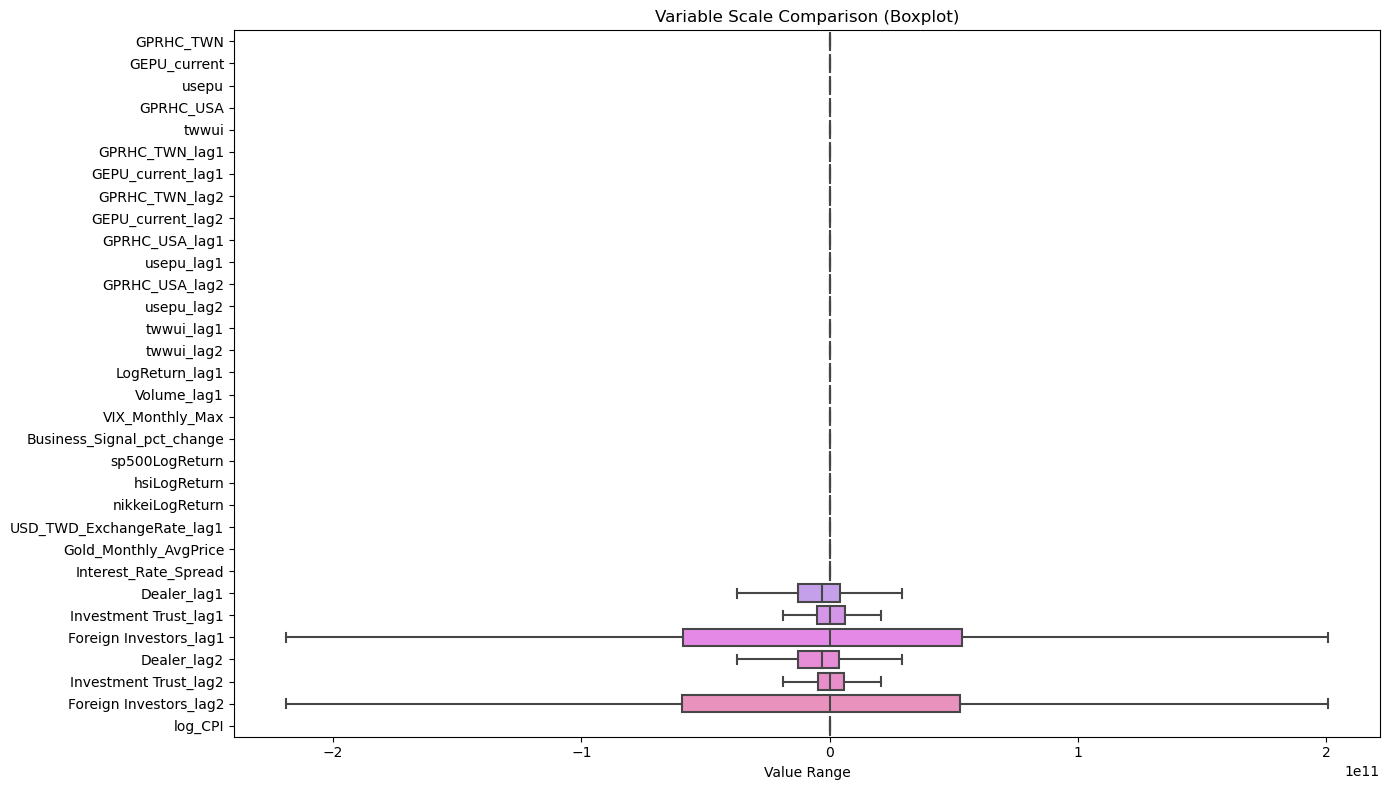

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

features = [
    "GPRHC_TWN", "GEPU_current",
    "usepu",
    "GPRHC_USA",
    "twwui",
    "GPRHC_TWN_lag1", "GEPU_current_lag1",
    "GPRHC_TWN_lag2", "GEPU_current_lag2",
    "GPRHC_USA_lag1", "usepu_lag1",
    "GPRHC_USA_lag2", "usepu_lag2",
    "twwui_lag1",
    "twwui_lag2",
    "LogReturn_lag1", "Volume_lag1",
    "VIX_Monthly_Max",
    "Business_Signal_pct_change",
    "sp500LogReturn", "hsiLogReturn", "nikkeiLogReturn",
    "USD_TWD_ExchangeRate_lag1", "Gold_Monthly_AvgPrice", "Interest_Rate_Spread",
    "Dealer_lag1", "Investment Trust_lag1", "Foreign Investors_lag1",
    "Dealer_lag2", "Investment Trust_lag2", "Foreign Investors_lag2",    
    "log_CPI"
]


plt.figure(figsize=(14, 8))
sns.boxplot(data=df[features], orient="h", showfliers=False)
plt.title("Variable Scale Comparison (Boxplot)")
plt.xlabel("Value Range")
plt.tight_layout()
plt.show()


In [38]:
# 把 lag2 也標準化
from sklearn.preprocessing import StandardScaler

standardize_cols = [
    "GPRHC_TWN", "GEPU_current",
    "usepu",
    "GPRHC_USA",
    "twwui",
    "GPR_GEPU", 
    "GPRHC_TWN_lag1", "GEPU_current_lag1",
    "GPRHC_TWN_lag2", "GEPU_current_lag2",
    "GPRHC_USA_lag1", "usepu_lag1",
    "GPRHC_USA_lag2", "usepu_lag2",
    "twwui_lag1",
    "twwui_lag2",
    "Volume_lag1",
    "VIX_Monthly_Max",
    "USD_TWD_ExchangeRate_lag1", "Gold_Monthly_AvgPrice", "Interest_Rate_Spread",
    "Dealer_lag1", "Investment Trust_lag1", "Foreign Investors_lag1",
    "Dealer_lag2", "Investment Trust_lag2", "Foreign Investors_lag2",
    "log_CPI"
]

scaler = StandardScaler()
df_standardized = df.copy()
df_standardized[standardize_cols] = scaler.fit_transform(df_standardized[standardize_cols])

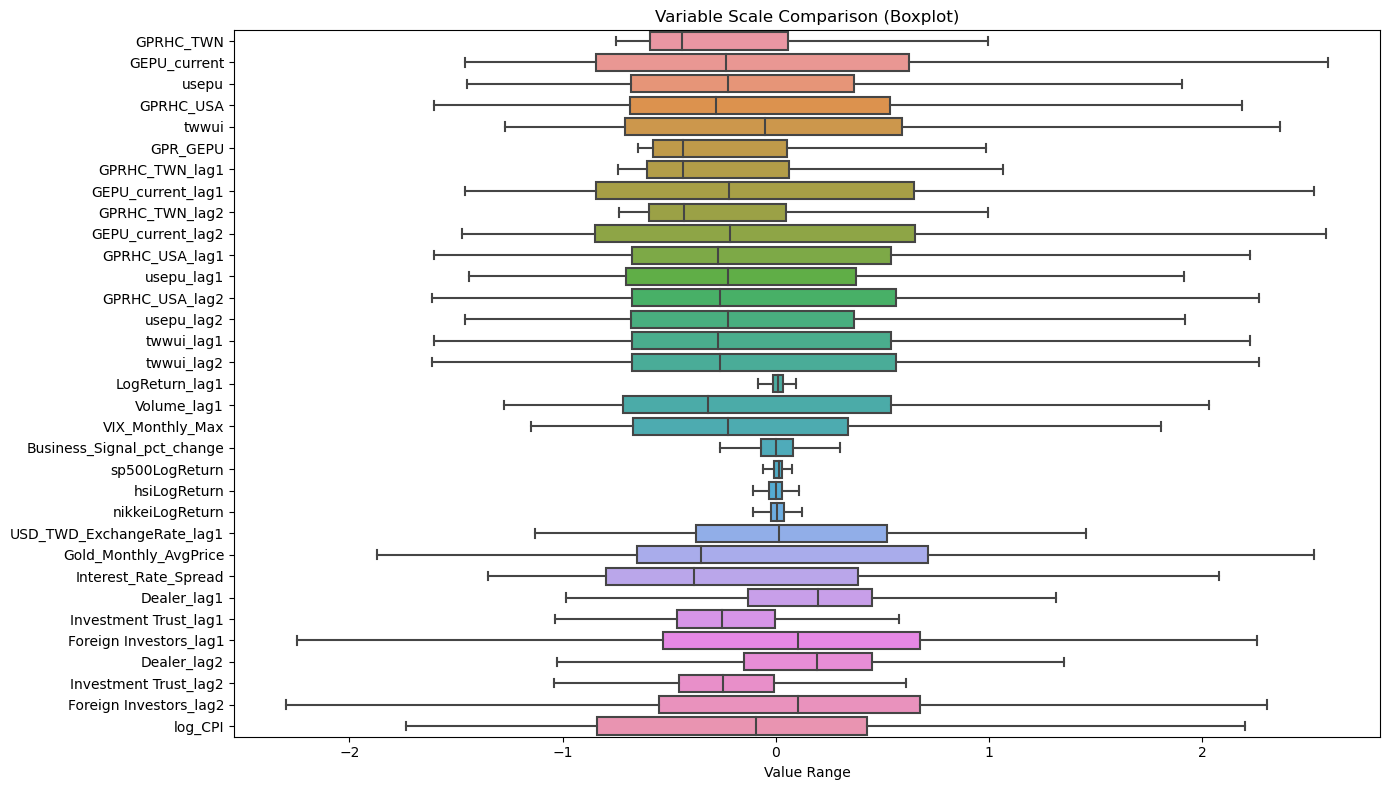

In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

features = [
    "GPRHC_TWN", "GEPU_current",
    "usepu",
    "GPRHC_USA",
    "twwui",
    "GPR_GEPU", 
    "GPRHC_TWN_lag1", "GEPU_current_lag1",
    "GPRHC_TWN_lag2", "GEPU_current_lag2",
    "GPRHC_USA_lag1", "usepu_lag1",
    "GPRHC_USA_lag2", "usepu_lag2",
    "twwui_lag1",
    "twwui_lag2",
    "LogReturn_lag1", "Volume_lag1",
    "VIX_Monthly_Max",
    "Business_Signal_pct_change",
    "sp500LogReturn", "hsiLogReturn", "nikkeiLogReturn",
    "USD_TWD_ExchangeRate_lag1", "Gold_Monthly_AvgPrice", "Interest_Rate_Spread",
    "Dealer_lag1", "Investment Trust_lag1", "Foreign Investors_lag1",
    "Dealer_lag2", "Investment Trust_lag2", "Foreign Investors_lag2",
    "log_CPI"
]


plt.figure(figsize=(14, 8))
sns.boxplot(data=df_standardized[features], orient="h", showfliers=False)
plt.title("Variable Scale Comparison (Boxplot)")
plt.xlabel("Value Range")
plt.tight_layout()
plt.show()

In [40]:
output_path = "/Users/susanlin/Desktop/Thesis/Data/final_0418_standardized.csv"
df_standardized.to_csv(output_path, index=False, encoding="utf-8-sig")

# V02

#### new LogReturn

In [1]:
import pandas as pd
import numpy as np
import yfinance as yf

data_path = "/Users/susanlin/Desktop/Thesis/Data/final_0418_未標準化.csv"
df = pd.read_csv(data_path, encoding="utf-8-sig")

taiex = yf.download("^TWII", start="2007-12-01", end="2024-12-31", interval="1d")

# 每月最後一日收盤價
monthly_close = taiex["Close"].resample("M").last()

# log return (滯後一期)
log_return = np.log(monthly_close / monthly_close.shift(1)).reset_index()
log_return.columns = ["Date", "LogReturn_lag1"]
log_return["Year"] = log_return["Date"].dt.year
log_return["Month"] = log_return["Date"].dt.month

if "LogReturn_lag1" in df.columns:
    df = df.drop(columns=["LogReturn_lag1"])

df = df.merge(log_return[["Year", "Month", "LogReturn_lag1"]], on=["Year", "Month"], how="left")
df

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Year  Month        Dealer  Investment Trust  Foreign Investors  \
0    2008      3  4.242235e+09      4.941362e+09      -1.835972e+10   
1    2008      4  1.839216e+10      1.537010e+10      -2.929911e+10   
2    2008      5 -6.164625e+09      4.981936e+09       1.377714e+10   
3    2008      6 -1.059040e+10      2.477901e+08      -1.158804e+11   
4    2008      7  8.812878e+09      6.402823e+09      -1.096295e+11   
..    ...    ...           ...               ...                ...   
188  2024      8 -1.998826e+11      1.231823e+11      -1.347530e+11   
189  2024      9 -8.492955e+10      8.126110e+10      -9.506103e+10   
190  2024     10 -4.829849e+10      4.041347e+10       3.906549e+10   
191  2024     11 -1.167762e+11      8.501633e+10      -2.729447e+11   
192  2024     12 -3.253823e+10     -6.916221e+08       4.573943e+10   

     GPRHC_TWN  GEPU_current         Close       Volume    Return  ...  \
0     0.085859    118.181868   8572.549805  119302600.0  0.018999  ...   
1     0.000000     92.008066   8919.878906  119824400.0  0.040516  ...   
2     0.026743     78.120477   8619.040039  110158600.0 -0.033727  ...   
3     0.028374     88.590384   7523.505371   82064800.0 -0.127106  ...   
4     0.019361     94.517497   7024.028320   92596000.0 -0.066389  ...   
..         ...           ...           ...          ...       ...  ...   
188   0.197922    225.378325  22268.089844   89434600.0  0.003096  ...   
189   0.200100    223.007104  22224.539062   68870900.0 -0.001956  ...   
190   0.391134    223.640869  22820.429688   61146000.0  0.026812  ...   
191   0.197694    365.206009  22262.500000   73073600.0 -0.024449  ...   
192   0.191471    377.073675  23035.099609   67916600.0  0.034704  ...   

     GPRHC_USA_lag2  twwui_lag1  twwui_lag2   GPR_GEPU  GPR_lag1_GEPU_lag1  \
0          2.689225    2.698528    2.689225  10.146980            2.784476   
1          2.698528    2.318193    2.698528   0.000000           10.146980   
2          2.318193    2.292959    2.318193   2.089155            0.000000   
3          2.292959    2.192904    2.292959   2.513678            2.089155   
4          2.192904    2.459094    2.192904   1.829961            2.513678   
..              ...         ...         ...        ...                 ...   
188        3.129183    2.545393    3.129183  44.607290           23.643205   
189        2.545393    3.744021    2.545393  44.623733           44.607290   
190        3.744021    3.401701    3.744021  87.473613           44.623733   
191        3.401701    3.259452    3.401701  72.198880           87.473613   
192        3.259452    3.344316    3.259452  72.198616           72.198880   

     USD_TWD_ExchangeRate_lag1   Dealer_lag2  Investment Trust_lag2  \
0                          NaN           NaN                    NaN   
1                    30.415001           NaN                    NaN   
2                    30.475000  4.242235e+09           4.941362e+09   
3                    30.400000  1.839216e+10           1.537010e+10   
4                    30.337999 -6.164625e+09           4.981936e+09   
..                         ...           ...                    ...   
188                  32.761501 -4.861691e+10           6.010338e+10   
189                  31.996000 -1.656214e+11           1.191416e+11   
190                  31.575001 -1.998826e+11           1.231823e+11   
191                  31.865499 -8.492955e+10           8.126110e+10   
192                  32.438999 -4.829849e+10           4.041347e+10   

     Foreign Investors_lag2  LogReturn_lag1  
0                       NaN        0.018820  
1                       NaN        0.039717  
2             -1.835972e+10       -0.034309  
3             -2.929911e+10       -0.135942  
4              1.377714e+10       -0.068695  
..                      ...             ...  
188            3.554393e+09        0.003092  
189           -3.502553e+11       -0.001958  
190           -1.347530e+11        0.026459  
191          

#### new S&P Return

In [2]:
data_path = "/Users/susanlin/Desktop/Thesis/Data/final_0418_未標準化.csv"
df = pd.read_csv(data_path, encoding="utf-8-sig")

# S&P 500 日資料
sp500 = yf.download('^GSPC', start="2007-12-01", end='2025-04-30', interval='1d')

# 每月最後一日收盤價
monthly_close = sp500["Close"].resample("M").last()

# log return
log_return = np.log(monthly_close / monthly_close.shift(1)).reset_index()
log_return.columns = ["Date", "sp500LogReturn"]
log_return["Year"] = log_return["Date"].dt.year
log_return["Month"] = log_return["Date"].dt.month

if "sp500LogReturn" in df.columns:
    df = df.drop(columns=["sp500LogReturn"])

df = df.merge(log_return[["Year", "Month", "sp500LogReturn"]], on=["Year", "Month"], how="left")

df.head()

[*********************100%***********************]  1 of 1 completed


Year  Month        Dealer  Investment Trust  Foreign Investors  GPRHC_TWN  \
0  2008      3  4.242235e+09      4.941362e+09      -1.835972e+10   0.085859   
1  2008      4  1.839216e+10      1.537010e+10      -2.929911e+10   0.000000   
2  2008      5 -6.164625e+09      4.981936e+09       1.377714e+10   0.026743   
3  2008      6 -1.059040e+10      2.477901e+08      -1.158804e+11   0.028374   
4  2008      7  8.812878e+09      6.402823e+09      -1.096295e+11   0.019361   

   GEPU_current        Close       Volume    Return  ...  GPRHC_USA_lag2  \
0    118.181868  8572.549805  119302600.0  0.018999  ...        2.689225   
1     92.008066  8919.878906  119824400.0  0.040516  ...        2.698528   
2     78.120477  8619.040039  110158600.0 -0.033727  ...        2.318193   
3     88.590384  7523.505371   82064800.0 -0.127106  ...        2.292959   
4     94.517497  7024.028320   92596000.0 -0.066389  ...        2.192904   

   twwui_lag1  twwui_lag2   GPR_GEPU  GPR_lag1_GEPU_lag1  \
0    2.698528    2.689225  10.146980            2.784476   
1    2.318193    2.698528   0.000000           10.146980   
2    2.292959    2.318193   2.089155            0.000000   
3    2.192904    2.292959   2.513678            2.089155   
4    2.459094    2.192904   1.829961            2.513678   

   USD_TWD_ExchangeRate_lag1   Dealer_lag2  Investment Trust_lag2  \
0                        NaN           NaN                    NaN   
1                  30.415001           NaN                    NaN   
2                  30.475000  4.242235e+09           4.941362e+09   
3                  30.400000  1.839216e+10           1.537010e+10   
4                  30.337999 -6.164625e+09           4.981936e+09   

   Foreign Investors_lag2  sp500LogReturn  
0                     NaN       -0.005977  
1                     NaN        0.046451  
2           -1.835972e+10        0.010618  
3           -2.929911e+10       -0.089884  
4            1.377714e+10       -0.009908  

[5 rows x 52 columns]

#### new HSI return

In [3]:
# HSI 恆生指數日資料
hsi = yf.download('^HSI', start="2007-12-01", end='2025-04-30', interval='1d')

# 每月最後一日收盤價
monthly_close = hsi["Close"].resample("M").last()

# log return
log_return = np.log(monthly_close / monthly_close.shift(1)).reset_index()
log_return.columns = ["Date", "hsiLogReturn"]
log_return["Year"] = log_return["Date"].dt.year
log_return["Month"] = log_return["Date"].dt.month

if "hsiLogReturn" in df.columns:
    df = df.drop(columns=["hsiLogReturn"])

df = df.merge(log_return[["Year", "Month", "hsiLogReturn"]], on=["Year", "Month"], how="left")

df.head()

[*********************100%***********************]  1 of 1 completed


Year  Month        Dealer  Investment Trust  Foreign Investors  GPRHC_TWN  \
0  2008      3  4.242235e+09      4.941362e+09      -1.835972e+10   0.085859   
1  2008      4  1.839216e+10      1.537010e+10      -2.929911e+10   0.000000   
2  2008      5 -6.164625e+09      4.981936e+09       1.377714e+10   0.026743   
3  2008      6 -1.059040e+10      2.477901e+08      -1.158804e+11   0.028374   
4  2008      7  8.812878e+09      6.402823e+09      -1.096295e+11   0.019361   

   GEPU_current        Close       Volume    Return  ...  twwui_lag1  \
0    118.181868  8572.549805  119302600.0  0.018999  ...    2.698528   
1     92.008066  8919.878906  119824400.0  0.040516  ...    2.318193   
2     78.120477  8619.040039  110158600.0 -0.033727  ...    2.292959   
3     88.590384  7523.505371   82064800.0 -0.127106  ...    2.192904   
4     94.517497  7024.028320   92596000.0 -0.066389  ...    2.459094   

   twwui_lag2   GPR_GEPU  GPR_lag1_GEPU_lag1  USD_TWD_ExchangeRate_lag1  \
0    2.689225  10.146980            2.784476                        NaN   
1    2.698528   0.000000           10.146980                  30.415001   
2    2.318193   2.089155            0.000000                  30.475000   
3    2.292959   2.513678            2.089155                  30.400000   
4    2.192904   1.829961            2.513678                  30.337999   

    Dealer_lag2  Investment Trust_lag2  Foreign Investors_lag2  \
0           NaN                    NaN                     NaN   
1           NaN                    NaN                     NaN   
2  4.242235e+09           4.941362e+09           -1.835972e+10   
3  1.839216e+10           1.537010e+10           -2.929911e+10   
4 -6.164625e+09           4.981936e+09            1.377714e+10   

   sp500LogReturn  hsiLogReturn  
0       -0.005977     -0.062863  
1        0.046451      0.119726  
2        0.010618     -0.048618  
3       -0.089884     -0.104355  
4       -0.009908      0.028065  

[5 rows x 52 columns]

#### new nikkei return

In [4]:
# Nikkei (^N225) 日資料
nikkei = yf.download('^N225', start="2007-12-01", end='2025-04-30', interval='1d')

# 每月最後一日收盤價
monthly_close = nikkei["Close"].resample("M").last()

# log return
log_return = np.log(monthly_close / monthly_close.shift(1)).reset_index()
log_return.columns = ["Date", "nikkeiLogReturn"]
log_return["Year"] = log_return["Date"].dt.year
log_return["Month"] = log_return["Date"].dt.month

if "nikkeiLogReturn" in df.columns:
    df = df.drop(columns=["nikkeiLogReturn"])

df = df.merge(log_return[["Year", "Month", "nikkeiLogReturn"]], on=["Year", "Month"], how="left")

df.head()

[*********************100%***********************]  1 of 1 completed


Year  Month        Dealer  Investment Trust  Foreign Investors  GPRHC_TWN  \
0  2008      3  4.242235e+09      4.941362e+09      -1.835972e+10   0.085859   
1  2008      4  1.839216e+10      1.537010e+10      -2.929911e+10   0.000000   
2  2008      5 -6.164625e+09      4.981936e+09       1.377714e+10   0.026743   
3  2008      6 -1.059040e+10      2.477901e+08      -1.158804e+11   0.028374   
4  2008      7  8.812878e+09      6.402823e+09      -1.096295e+11   0.019361   

   GEPU_current        Close       Volume    Return  ...  twwui_lag2  \
0    118.181868  8572.549805  119302600.0  0.018999  ...    2.689225   
1     92.008066  8919.878906  119824400.0  0.040516  ...    2.698528   
2     78.120477  8619.040039  110158600.0 -0.033727  ...    2.318193   
3     88.590384  7523.505371   82064800.0 -0.127106  ...    2.292959   
4     94.517497  7024.028320   92596000.0 -0.066389  ...    2.192904   

    GPR_GEPU  GPR_lag1_GEPU_lag1  USD_TWD_ExchangeRate_lag1   Dealer_lag2  \
0  10.146980            2.784476                        NaN           NaN   
1   0.000000           10.146980                  30.415001           NaN   
2   2.089155            0.000000                  30.475000  4.242235e+09   
3   2.513678            2.089155                  30.400000  1.839216e+10   
4   1.829961            2.513678                  30.337999 -6.164625e+09   

   Investment Trust_lag2  Foreign Investors_lag2  sp500LogReturn  \
0                    NaN                     NaN       -0.005977   
1                    NaN                     NaN        0.046451   
2           4.941362e+09           -1.835972e+10        0.010618   
3           1.537010e+10           -2.929911e+10       -0.089884   
4           4.981936e+09            1.377714e+10       -0.009908   

   hsiLogReturn  nikkeiLogReturn  
0     -0.062863        -0.082522  
1      0.119726         0.100515  
2     -0.048618         0.034666  
3     -0.104355        -0.061642  
4      0.028065        -0.007787  

[5 rows x 52 columns]

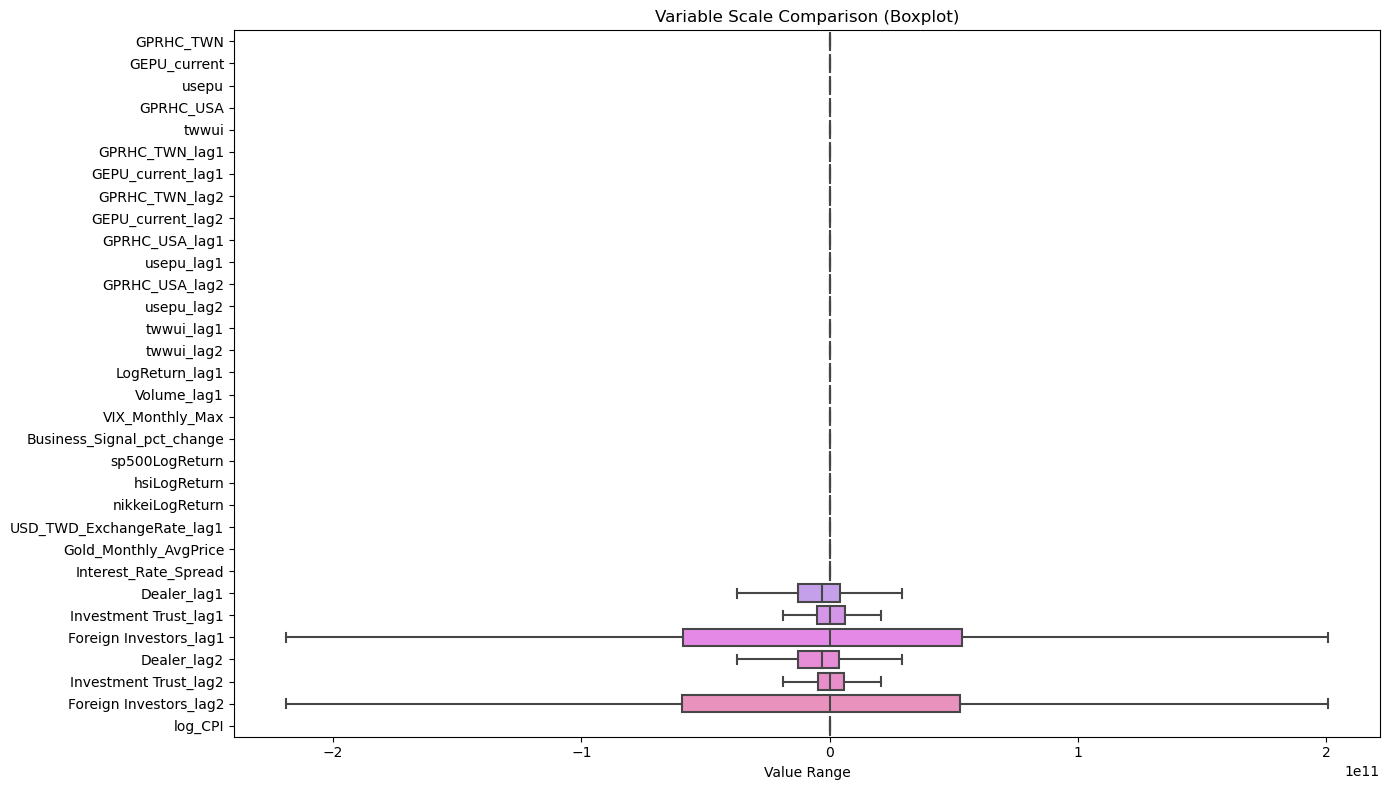

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

features = [
    "GPRHC_TWN", "GEPU_current",
    "usepu",
    "GPRHC_USA",
    "twwui",
    "GPRHC_TWN_lag1", "GEPU_current_lag1",
    "GPRHC_TWN_lag2", "GEPU_current_lag2",
    "GPRHC_USA_lag1", "usepu_lag1",
    "GPRHC_USA_lag2", "usepu_lag2",
    "twwui_lag1",
    "twwui_lag2",
    "LogReturn_lag1", "Volume_lag1",
    "VIX_Monthly_Max",
    "Business_Signal_pct_change",
    "sp500LogReturn", "hsiLogReturn", "nikkeiLogReturn",
    "USD_TWD_ExchangeRate_lag1", "Gold_Monthly_AvgPrice", "Interest_Rate_Spread",
    "Dealer_lag1", "Investment Trust_lag1", "Foreign Investors_lag1",
    "Dealer_lag2", "Investment Trust_lag2", "Foreign Investors_lag2",    
    "log_CPI"
]


plt.figure(figsize=(14, 8))
sns.boxplot(data=df[features], orient="h", showfliers=False)
plt.title("Variable Scale Comparison (Boxplot)")
plt.xlabel("Value Range")
plt.tight_layout()
plt.show()

In [6]:
output_path = "/Users/susanlin/Desktop/Thesis/Data/final_0704.csv"
df.to_csv(output_path, index=False, encoding="utf-8-sig")

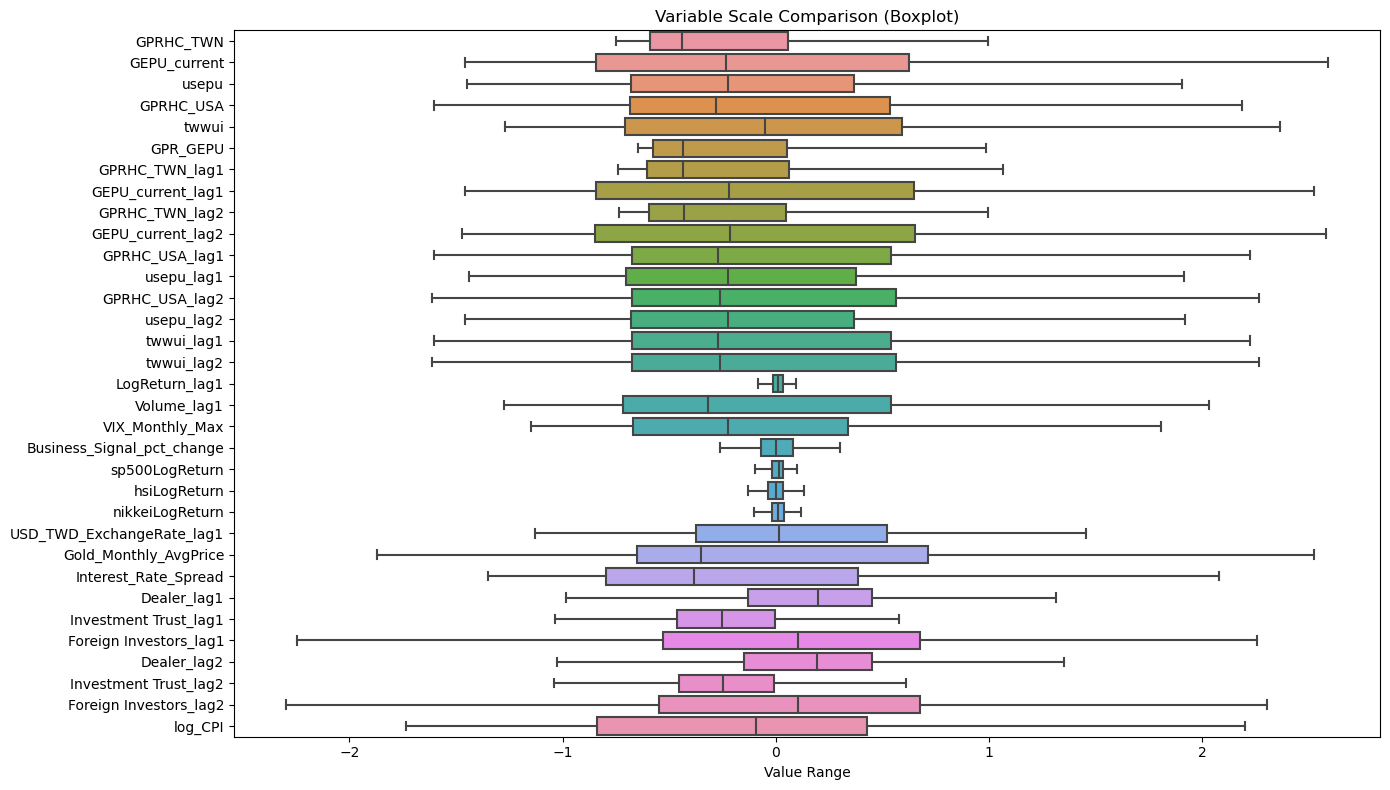

In [126]:
# 把 lag2 也標準化
from sklearn.preprocessing import StandardScaler

standardize_cols = [
    "GPRHC_TWN", "GEPU_current",
    "usepu",
    "GPRHC_USA",
    "twwui",
    "GPR_GEPU", 
    "GPRHC_TWN_lag1", "GEPU_current_lag1",
    "GPRHC_TWN_lag2", "GEPU_current_lag2",
    "GPRHC_USA_lag1", "usepu_lag1",
    "GPRHC_USA_lag2", "usepu_lag2",
    "twwui_lag1",
    "twwui_lag2",
    "Volume_lag1",
    "VIX_Monthly_Max",
    "USD_TWD_ExchangeRate_lag1", "Gold_Monthly_AvgPrice", "Interest_Rate_Spread",
    "Dealer_lag1", "Investment Trust_lag1", "Foreign Investors_lag1",
    "Dealer_lag2", "Investment Trust_lag2", "Foreign Investors_lag2",
    "log_CPI"
]

scaler = StandardScaler()
df_standardized = df.copy()
df_standardized[standardize_cols] = scaler.fit_transform(df_standardized[standardize_cols])

features = [
    "GPRHC_TWN", "GEPU_current",
    "usepu",
    "GPRHC_USA",
    "twwui",
    "GPR_GEPU", 
    "GPRHC_TWN_lag1", "GEPU_current_lag1",
    "GPRHC_TWN_lag2", "GEPU_current_lag2",
    "GPRHC_USA_lag1", "usepu_lag1",
    "GPRHC_USA_lag2", "usepu_lag2",
    "twwui_lag1",
    "twwui_lag2",
    "LogReturn_lag1", "Volume_lag1",
    "VIX_Monthly_Max",
    "Business_Signal_pct_change",
    "sp500LogReturn", "hsiLogReturn", "nikkeiLogReturn",
    "USD_TWD_ExchangeRate_lag1", "Gold_Monthly_AvgPrice", "Interest_Rate_Spread",
    "Dealer_lag1", "Investment Trust_lag1", "Foreign Investors_lag1",
    "Dealer_lag2", "Investment Trust_lag2", "Foreign Investors_lag2",
    "log_CPI"
]


plt.figure(figsize=(14, 8))
sns.boxplot(data=df_standardized[features], orient="h", showfliers=False)
plt.title("Variable Scale Comparison (Boxplot)")
plt.xlabel("Value Range")
plt.tight_layout()
plt.show()

In [127]:
output_path = "/Users/susanlin/Desktop/Thesis/Data/final_0418_standardized.csv"
df_standardized.to_csv(output_path, index=False, encoding="utf-8-sig")

### Winsorize

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats.mstats import winsorize
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

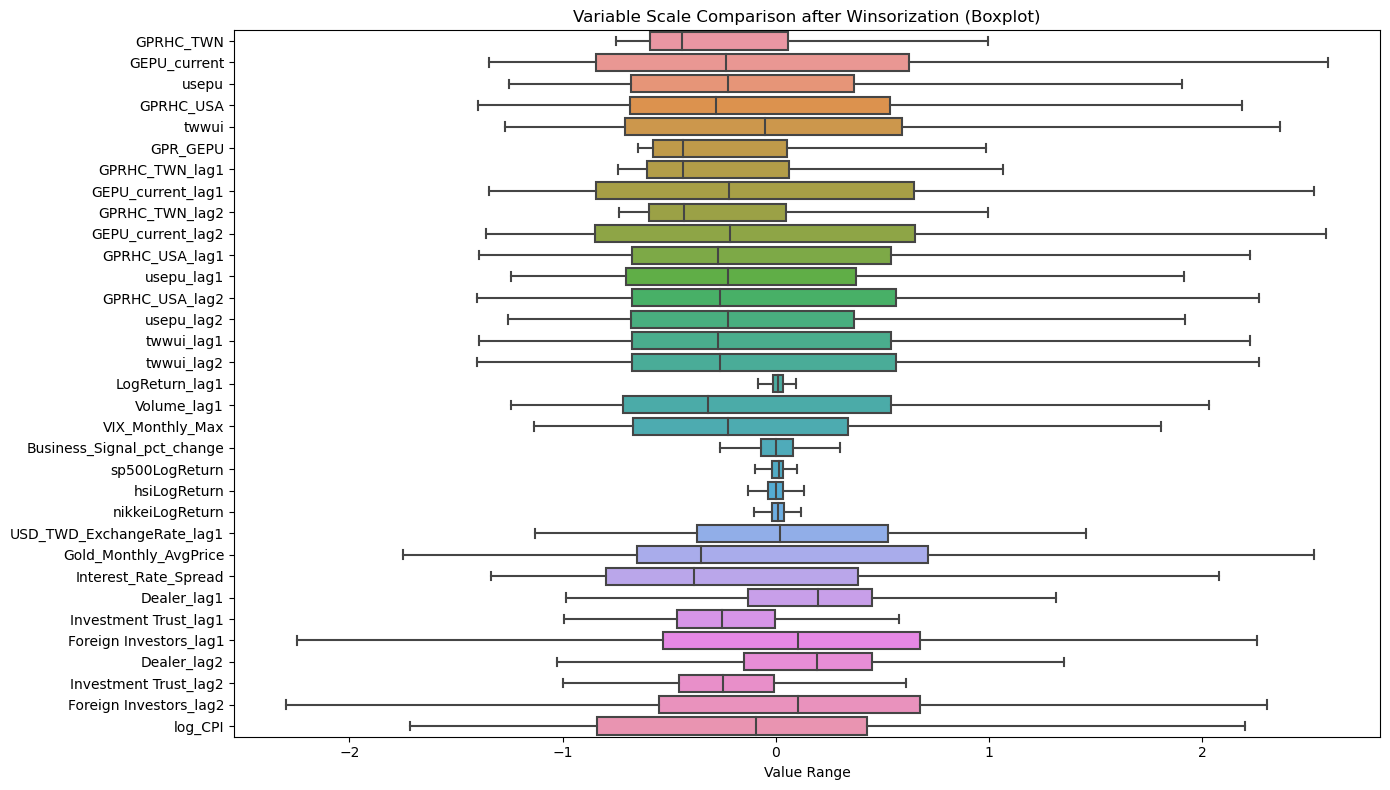

In [129]:
input_path = "/Users/susanlin/Desktop/Thesis/Data/final_0418_standardized.csv"
df = pd.read_csv(input_path)

cols_to_keep = ['Year', 'Month', 'Dealer', 'Investment Trust', 'Foreign Investors']

features = [
    "GPRHC_TWN", "GEPU_current", "usepu", "GPRHC_USA", "twwui", "GPR_GEPU", 
    "GPRHC_TWN_lag1", "GEPU_current_lag1", "GPRHC_TWN_lag2", "GEPU_current_lag2",
    "GPRHC_USA_lag1", "usepu_lag1", "GPRHC_USA_lag2", "usepu_lag2",
    "twwui_lag1", "twwui_lag2", "LogReturn_lag1", "Volume_lag1", "VIX_Monthly_Max",
    "Business_Signal_pct_change", "sp500LogReturn", "hsiLogReturn", "nikkeiLogReturn",
    "USD_TWD_ExchangeRate_lag1", "Gold_Monthly_AvgPrice", "Interest_Rate_Spread",
    "Dealer_lag1", "Investment Trust_lag1", "Foreign Investors_lag1",
    "Dealer_lag2", "Investment Trust_lag2", "Foreign Investors_lag2", "log_CPI" 
]

df_winsorized = df.copy()       
for col in features:
    df_winsorized[col] = winsorize(df[col], limits=[0.01, 0.01])

plt.figure(figsize=(14, 8))
sns.boxplot(data=df_winsorized[features], orient="h", showfliers=False)
plt.title("Variable Scale Comparison after Winsorization (Boxplot)")
plt.xlabel("Value Range")
plt.tight_layout()
plt.show()

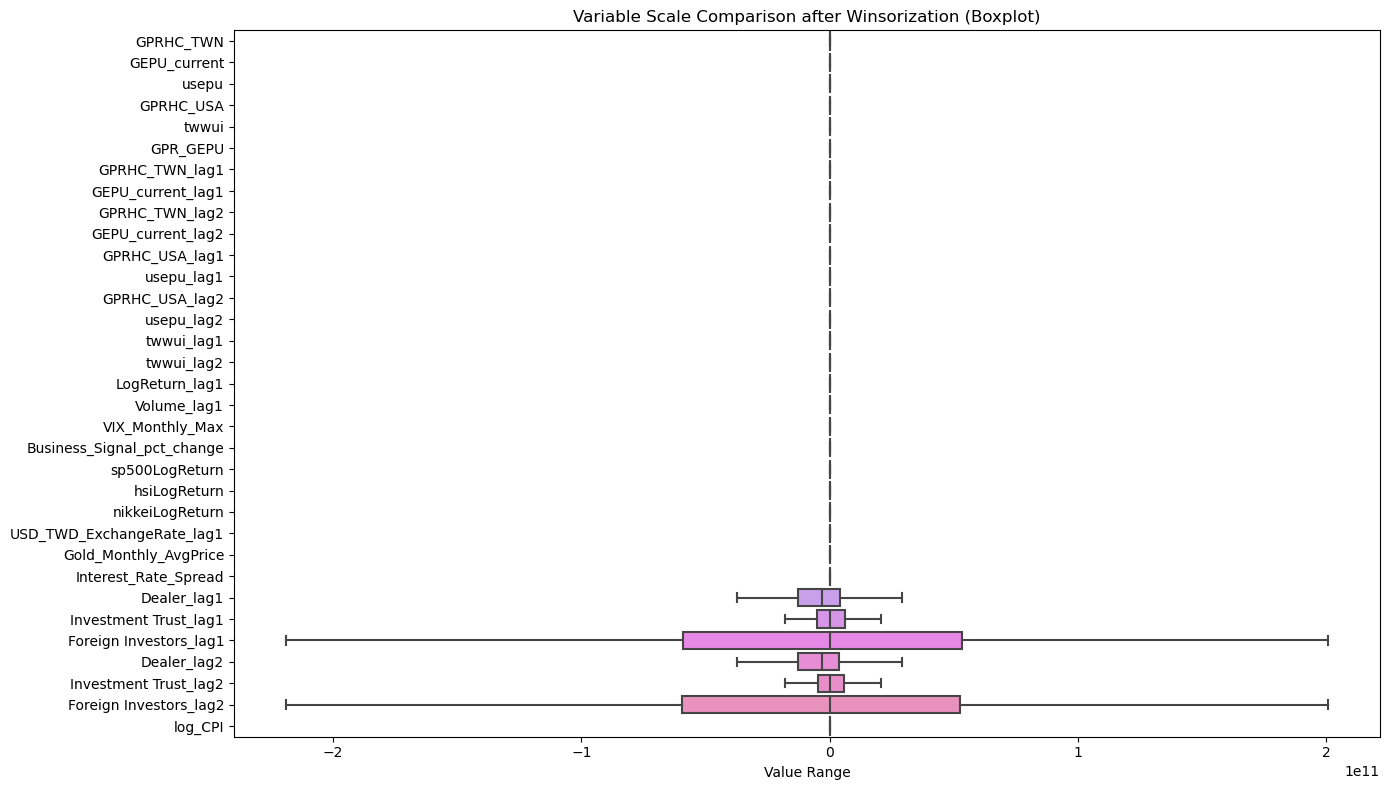

In [8]:
input_path = "/Users/susanlin/Desktop/Thesis/Data/final_0704.csv"
df = pd.read_csv(input_path)

cols_to_keep = ['Year', 'Month', 'Dealer', 'Investment Trust', 'Foreign Investors']

features = [
    "GPRHC_TWN", "GEPU_current", "usepu", "GPRHC_USA", "twwui", "GPR_GEPU", 
    "GPRHC_TWN_lag1", "GEPU_current_lag1", "GPRHC_TWN_lag2", "GEPU_current_lag2",
    "GPRHC_USA_lag1", "usepu_lag1", "GPRHC_USA_lag2", "usepu_lag2",
    "twwui_lag1", "twwui_lag2", "LogReturn_lag1", "Volume_lag1", "VIX_Monthly_Max",
    "Business_Signal_pct_change", "sp500LogReturn", "hsiLogReturn", "nikkeiLogReturn",
    "USD_TWD_ExchangeRate_lag1", "Gold_Monthly_AvgPrice", "Interest_Rate_Spread",
    "Dealer_lag1", "Investment Trust_lag1", "Foreign Investors_lag1",
    "Dealer_lag2", "Investment Trust_lag2", "Foreign Investors_lag2", "log_CPI" 
]

df_winsorized = df.copy()       
for col in features:
    df_winsorized[col] = winsorize(df[col], limits=[0.01, 0.01])

plt.figure(figsize=(14, 8))
sns.boxplot(data=df_winsorized[features], orient="h", showfliers=False)
plt.title("Variable Scale Comparison after Winsorization (Boxplot)")
plt.xlabel("Value Range")
plt.tight_layout()
plt.show()

#### ! New Data

In [10]:
# 刪掉有 NaN 的 rows
print(f"資料筆數：{df_winsorized.shape[0]}")
df_wins = df_winsorized.dropna()
print(f"剩餘資料筆數：{df_winsorized.shape[0]}")
df_wins.to_csv("/Users/susanlin/Desktop/Thesis/Data/final_0526_standardize_winsorize.csv", index=False, encoding="utf-8-sig")

資料筆數：193
剩餘資料筆數：193


In [11]:
df_wins

Year  Month        Dealer  Investment Trust  Foreign Investors  \
2    2008      5 -6.164625e+09      4.981936e+09       1.377714e+10   
3    2008      6 -1.059040e+10      2.477901e+08      -1.158804e+11   
4    2008      7  8.812878e+09      6.402823e+09      -1.096295e+11   
5    2008      8  4.689821e+09      1.081642e+10      -2.985458e+10   
6    2008      9 -2.423884e+09     -6.073563e+09      -9.049392e+10   
..    ...    ...           ...               ...                ...   
188  2024      8 -1.998826e+11      1.231823e+11      -1.347530e+11   
189  2024      9 -8.492955e+10      8.126110e+10      -9.506103e+10   
190  2024     10 -4.829849e+10      4.041347e+10       3.906549e+10   
191  2024     11 -1.167762e+11      8.501633e+10      -2.729447e+11   
192  2024     12 -3.253823e+10     -6.916221e+08       4.573943e+10   

     GPRHC_TWN  GEPU_current         Close       Volume    Return  ...  \
2     0.026743     86.315986   8619.040039  110158600.0 -0.033727  ...   
3     0.028374     88.590384   7523.505371   82064800.0 -0.127106  ...   
4     0.019361     94.517497   7024.028320   92596000.0 -0.066389  ...   
5     0.017981     90.215864   7046.078125   78415200.0  0.003139  ...   
6     0.055315    167.725195   5719.254395   80402400.0 -0.188307  ...   
..         ...           ...           ...          ...       ...  ...   
188   0.197922    225.378325  22268.089844   89434600.0  0.003096  ...   
189   0.200100    223.007104  22224.539062   68870900.0 -0.001956  ...   
190   0.391134    223.640869  22820.429688   61146000.0  0.026812  ...   
191   0.197694    365.206009  22262.500000   73073600.0 -0.024449  ...   
192   0.191471    377.073675  23035.099609   67916600.0  0.034704  ...   

     twwui_lag2   GPR_GEPU  GPR_lag1_GEPU_lag1  USD_TWD_ExchangeRate_lag1  \
2      2.318193   2.089155            0.000000                  30.475000   
3      2.292959   2.513678            2.089155                  30.400000   
4      2.192904   1.829961            2.513678                  30.337999   
5      2.459094   1.622150            1.829961                  30.645000   
6      2.778316   9.277692            1.622150                  31.590000   
..          ...        ...                 ...                        ...   
188    3.129183  44.607290           23.643205                  32.761501   
189    2.545393  44.623733           44.607290                  31.996000   
190    3.744021  87.473613           44.623733                  31.575001   
191    3.401701  72.198880           87.473613                  31.865499   
192    3.259452  72.198616           72.198880                  32.438999   

      Dealer_lag2  Investment Trust_lag2  Foreign Investors_lag2  \
2    4.242235e+09           4.941362e+09           -1.835972e+10   
3    1.839216e+10           1.537010e+10           -2.929911e+10   
4   -6.164625e+09           4.981936e+09            1.377714e+10   
5   -1.059040e+10           2.477901e+08           -1.158804e+11   
6    8.812878e+09           6.402823e+09           -1.096295e+11   
..            ...                    ...                     ...   
188 -4.861691e+10           6.010338e+10            3.554393e+09   
189 -1.656214e+11           1.191416e+11           -3.502553e+11   
190 -1.656214e+11           1.231823e+11           -1.347530e+11   
191 -8.492955e+10           8.126110e+10           -9.506103e+10   
192 -4.829849e+10           4.041347e+10            3.906549e+10   

     sp500LogReturn  hsiLogReturn  nikkeiLogReturn  
2          0.010618     -0.048618         0.034666  
3         -0.089884     -0.104355        -0.061642  
4         -0.009908      0.028065        -0.007787  
5          0.012117     -0.066818        -0.022983  
6         -0.095181     -0.165644        -0.149295  
..              ...           ...              ...  
188        0.022578      0.036483        -0.011680  
189        0.019996      0.161104        -0.019022  
190       -0.009946     -0.039394         0.

/var/folders/m3/4kw7w40s6p56xt563fshsjjh0000gn/T/ipykernel_52902/1054807051.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_wins["Date"] = pd.to_datetime(df[["Year", "Month"]].assign(DAY=1))


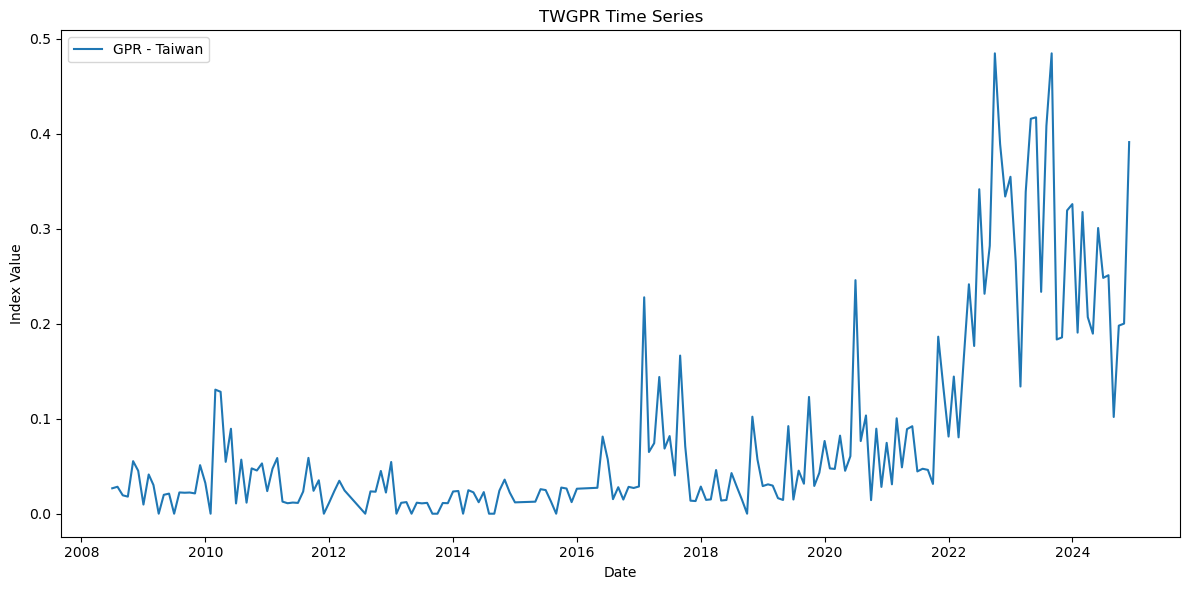

In [77]:
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

df_wins["Date"] = pd.to_datetime(df[["Year", "Month"]].assign(DAY=1))


plt.figure(figsize=(12,6))
sns.lineplot(data=df_wins, x='Date', y='GPRHC_TWN', label='GPR - Taiwan')
# sns.lineplot(data=df_wins, x='Date', y='GPRHC_USA', label='GPR - US')
# sns.lineplot(data=df_wins, x='Date', y='GEPU_current', label='EPU - Global')
# sns.lineplot(data=df_wins, x='Date', y='usepu', label='EPU - US')
# sns.lineplot(data=df_wins, x='Date', y='twwui', label='WUI - Taiwan')
plt.title("TWGPR Time Series")
plt.xlabel("Date")
plt.ylabel("Index Value")
plt.legend()
plt.tight_layout()
plt.show()

/var/folders/m3/4kw7w40s6p56xt563fshsjjh0000gn/T/ipykernel_52902/594456218.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_wins["Date"] = pd.to_datetime(df[["Year", "Month"]].assign(DAY=1))


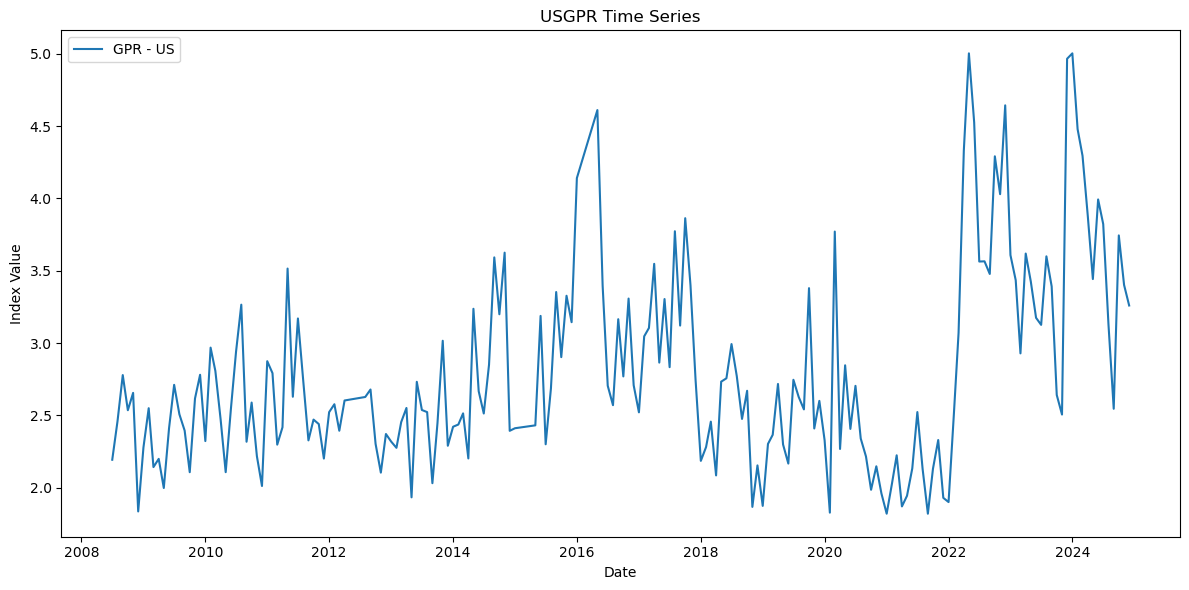

In [74]:
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

df_wins["Date"] = pd.to_datetime(df[["Year", "Month"]].assign(DAY=1))


plt.figure(figsize=(12,6))
# sns.lineplot(data=df_wins, x='Date', y='GPRHC_TWN', label='GPR - Taiwan')
sns.lineplot(data=df_wins, x='Date', y='GPRHC_USA', label='GPR - US')
# sns.lineplot(data=df_wins, x='Date', y='GEPU_current', label='EPU - Global')
# sns.lineplot(data=df_wins, x='Date', y='usepu', label='EPU - US')
# sns.lineplot(data=df_wins, x='Date', y='twwui', label='WUI - Taiwan')
plt.title("USGPR Time Series")
plt.xlabel("Date")
plt.ylabel("Index Value")
plt.legend()
plt.tight_layout()
plt.show()

/var/folders/m3/4kw7w40s6p56xt563fshsjjh0000gn/T/ipykernel_52902/371488467.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_wins["Date"] = pd.to_datetime(df[["Year", "Month"]].assign(DAY=1))


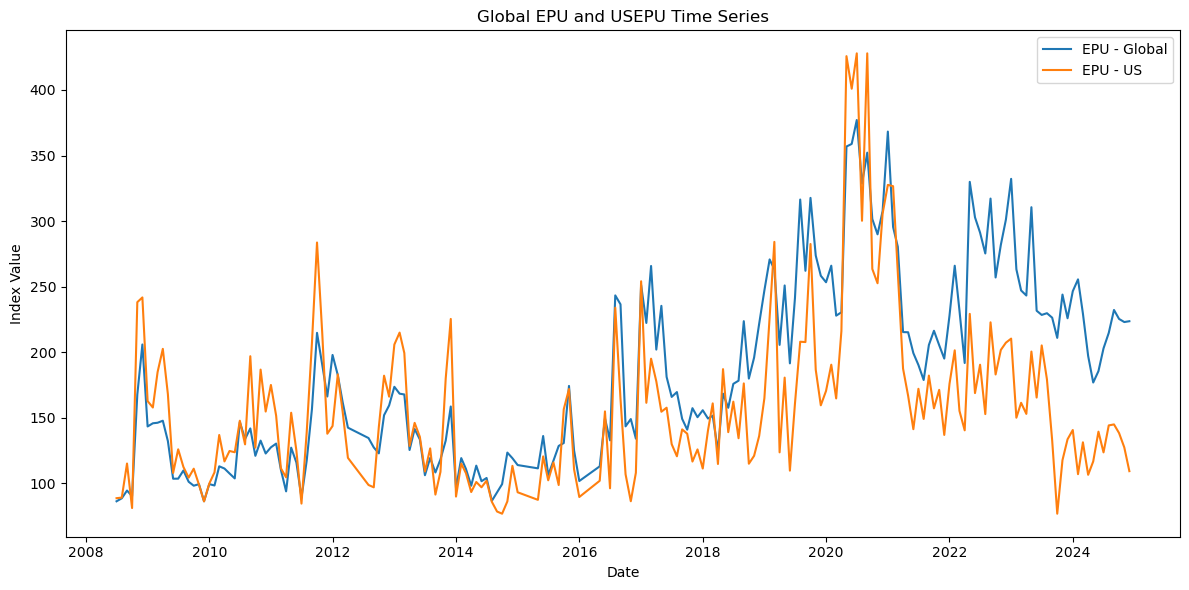

In [75]:
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

df_wins["Date"] = pd.to_datetime(df[["Year", "Month"]].assign(DAY=1))


plt.figure(figsize=(12,6))
# sns.lineplot(data=df_wins, x='Date', y='GPRHC_TWN', label='GPR - Taiwan')
# # sns.lineplot(data=df_wins, x='Date', y='GPRHC_USA', label='GPR - US')
sns.lineplot(data=df_wins, x='Date', y='GEPU_current', label='EPU - Global')
sns.lineplot(data=df_wins, x='Date', y='usepu', label='EPU - US')
# sns.lineplot(data=df_wins, x='Date', y='twwui', label='WUI - Taiwan')
plt.title("Global EPU and USEPU Time Series")
plt.xlabel("Date")
plt.ylabel("Index Value")
plt.legend()
plt.tight_layout()
plt.show()

/var/folders/m3/4kw7w40s6p56xt563fshsjjh0000gn/T/ipykernel_52902/2762284370.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_wins["Date"] = pd.to_datetime(df[["Year", "Month"]].assign(DAY=1))


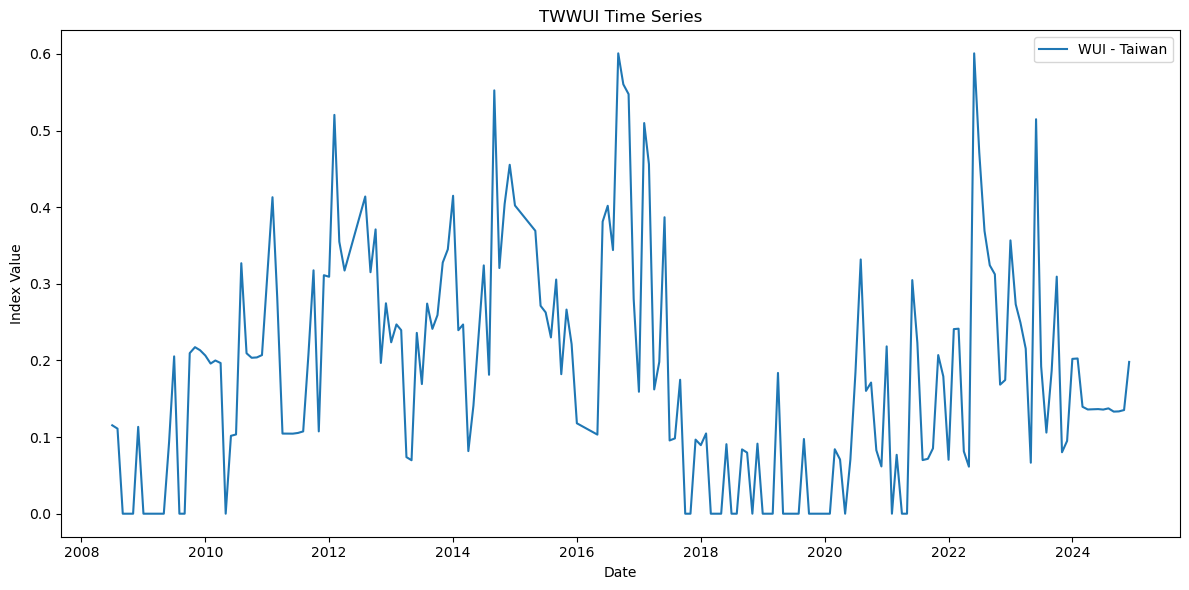

In [76]:
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

df_wins["Date"] = pd.to_datetime(df[["Year", "Month"]].assign(DAY=1))


plt.figure(figsize=(12,6))
# sns.lineplot(data=df_wins, x='Date', y='GPRHC_TWN', label='GPR - Taiwan')
# # sns.lineplot(data=df_wins, x='Date', y='GPRHC_USA', label='GPR - US')
# # sns.lineplot(data=df_wins, x='Date', y='GEPU_current', label='EPU - Global')
# # sns.lineplot(data=df_wins, x='Date', y='usepu', label='EPU - US')
sns.lineplot(data=df_wins, x='Date', y='twwui', label='WUI - Taiwan')
plt.title("TWWUI Time Series")
plt.xlabel("Date")
plt.ylabel("Index Value")
plt.legend()
plt.tight_layout()
plt.show()

### PCA

In [12]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

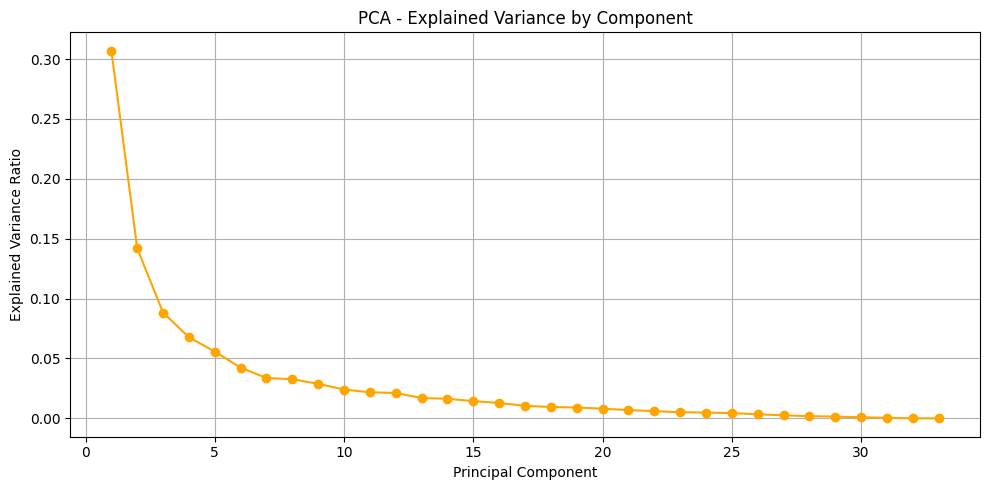

In [12]:
input_path = "/Users/susanlin/Desktop/Thesis/Data/final_0526_standardize_winsorize.csv"
df = pd.read_csv(input_path)

# X
features = [
    "GPRHC_TWN", "GEPU_current", "usepu", "GPRHC_USA", "twwui", "GPR_GEPU", 
    "GPRHC_TWN_lag1", "GEPU_current_lag1", "GPRHC_TWN_lag2", "GEPU_current_lag2",
    "GPRHC_USA_lag1", "usepu_lag1", "GPRHC_USA_lag2", "usepu_lag2",
    "twwui_lag1", "twwui_lag2", "LogReturn_lag1", "Volume_lag1", "VIX_Monthly_Max",
    "Business_Signal_pct_change", "sp500LogReturn", "hsiLogReturn", "nikkeiLogReturn",
    "USD_TWD_ExchangeRate_lag1", "Gold_Monthly_AvgPrice", "Interest_Rate_Spread",
    "Dealer_lag1", "Investment Trust_lag1", "Foreign Investors_lag1",
    "Dealer_lag2", "Investment Trust_lag2", "Foreign Investors_lag2", "log_CPI" 
]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[features])

pca = PCA()
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1),
         pca.explained_variance_ratio_, marker='o', color='orange')
plt.title("PCA - Explained Variance by Component")
plt.xlabel("Principal Component")
plt.ylabel("Explained Variance Ratio")
plt.grid(True)
plt.tight_layout()
plt.show()

各主成分代表性變數（代理變數）:
               Top1                   Top2             Top3
PC1         log_CPI               GPR_GEPU        GPRHC_TWN
PC2      usepu_lag1             usepu_lag2            usepu
PC3  sp500LogReturn        nikkeiLogReturn  VIX_Monthly_Max
PC4     Dealer_lag1  Investment Trust_lag1      Dealer_lag2
PC5  LogReturn_lag1        nikkeiLogReturn      Volume_lag1


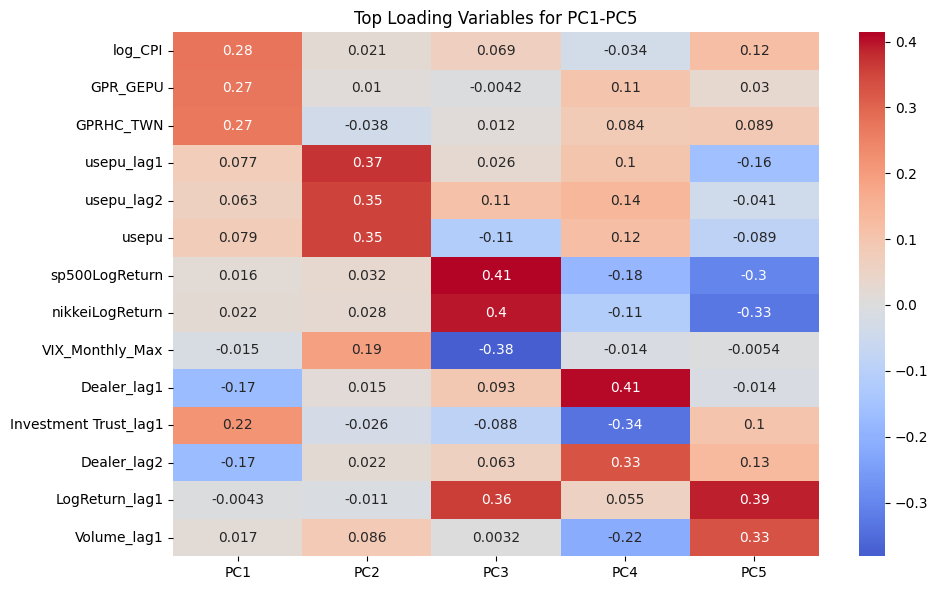

In [17]:
loadings = pd.DataFrame(pca.components_.T,
                        columns=[f'PC{i+1}' for i in range(len(features))],
                        index=features)
loadings

summary_factors = {}
for i in range(5):  # 前5主成分
    pc = f"PC{i+1}"
    top_vars = loadings[pc].abs().sort_values(ascending=False).head(3).index.tolist()
    summary_factors[pc] = top_vars

summary_df = pd.DataFrame.from_dict(summary_factors, orient='index', columns=["Top1", "Top2", "Top3"])
print("各主成分代表性變數（代理變數）:")
print(summary_df)


plt.figure(figsize=(10, 6))
top_loadings = loadings.loc[summary_df.values.flatten()].drop_duplicates()
sns.heatmap(top_loadings.iloc[:, :5], annot=True, cmap="coolwarm", center=0)
plt.title("Top Loading Variables for PC1-PC5")
plt.tight_layout()
plt.show()


In [18]:
import statsmodels.api as sm
import pandas as pd

X_pca_full = pca.fit_transform(X_scaled)
X_pca_df = pd.DataFrame(X_pca_full[:, :5], columns=[f'PC{i+1}' for i in range(5)])

X_pca = sm.add_constant(X_pca_df)
X_full = sm.add_constant(df[features])

output_path = "pca_vs_original_model_comparison.txt"

with open(output_path, "w", encoding="utf-8") as f:
    for target in ["Foreign Investors", "Investment Trust", "Dealer"]:
        y = df[target]

        model_pca = sm.OLS(y, X_pca).fit()
        model_full = sm.OLS(y, X_full).fit()

        comparison = pd.DataFrame({
            "Model": ["PCA (PC1–PC5)", "All original X"],
            "R-squared": [model_pca.rsquared, model_full.rsquared],
            "Adj. R-squared": [model_pca.rsquared_adj, model_full.rsquared_adj],
            "AIC": [model_pca.aic, model_full.aic],
            "BIC": [model_pca.bic, model_full.bic]
        })

        f.write("=" * 30 + f" {target} 模型比較 " + "=" * 30 + "\n")
        f.write(comparison.to_string(index=False))
        f.write("\n\n[PCA Model Summary]\n")
        f.write(model_pca.summary().as_text())
        f.write("\n\n[Full Model Summary]\n")
        f.write(model_full.summary().as_text())
        f.write("\n\n" + "=" * 80 + "\n\n")

print(f"out: {output_path}")

out: pca_vs_original_model_comparison.txt


In [ ]:
import statsmodels.api as sm
X_pca_full = pca.fit_transform(X_scaled)
X_pca_df = pd.DataFrame(X_pca_full[:, :5], columns=[f'PC{i+1}' for i in range(5)])

X_pca = sm.add_constant(X_pca_df)
X_full = sm.add_constant(df[features])
y = df["Foreign Investors"]

model_pca = sm.OLS(y, X_pca).fit()
model_full = sm.OLS(y, X_full).fit()

comparison = pd.DataFrame({
    "Model": ["PCA (PC1–PC5)", "All original X"],
    "R-squared": [model_pca.rsquared, model_full.rsquared],
    "Adj. R-squared": [model_pca.rsquared_adj, model_full.rsquared_adj],
    "AIC": [model_pca.aic, model_full.aic],
    "BIC": [model_pca.bic, model_full.bic]
})

print("外資模型比較：")
print(comparison)

print("==============================================================================")
print(model_pca.summary())
print(model_full.summary())


外資模型比較：
            Model  R-squared  Adj. R-squared           AIC           BIC
0   PCA (PC1–PC5)   0.299996        0.281077  10134.745826  10154.259466
1  All original X   0.547807        0.459643  10103.283359  10207.356109
                            OLS Regression Results                            
Dep. Variable:      Foreign Investors   R-squared:                       0.300
Model:                            OLS   Adj. R-squared:                  0.281
Method:                 Least Squares   F-statistic:                     15.86
Date:                Mon, 26 May 2025   Prob (F-statistic):           5.47e-13
Time:                        20:27:04   Log-Likelihood:                -5061.4
No. Observations:                 191   AIC:                         1.013e+04
Df Residuals:                     185   BIC:                         1.015e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                         

In [73]:
y = df["Investment Trust"]

model_pca = sm.OLS(y, X_pca).fit()
model_full = sm.OLS(y, X_full).fit()

comparison = pd.DataFrame({
    "Model": ["PCA (PC1–PC5)", "All original X"],
    "R-squared": [model_pca.rsquared, model_full.rsquared],
    "Adj. R-squared": [model_pca.rsquared_adj, model_full.rsquared_adj],
    "AIC": [model_pca.aic, model_full.aic],
    "BIC": [model_pca.bic, model_full.bic]
})

print("投信模型比較：")
print(comparison)

print("==============================================================================")
print(model_pca.summary())
print(model_full.summary())

投信模型比較：
            Model  R-squared  Adj. R-squared          AIC          BIC
0   PCA (PC1–PC5)   0.412403        0.396522  9592.124560  9611.638201
1  All original X   0.530333        0.438763  9601.337409  9705.410159
                            OLS Regression Results                            
Dep. Variable:       Investment Trust   R-squared:                       0.412
Model:                            OLS   Adj. R-squared:                  0.397
Method:                 Least Squares   F-statistic:                     25.97
Date:                Mon, 26 May 2025   Prob (F-statistic):           8.07e-20
Time:                        20:28:29   Log-Likelihood:                -4790.1
No. Observations:                 191   AIC:                             9592.
Df Residuals:                     185   BIC:                             9612.
Df Model:                           5                                         
Covariance Type:            nonrobust                               

In [74]:
y = df["Foreign Investors"]

model_pca = sm.OLS(y, X_pca).fit()
model_full = sm.OLS(y, X_full).fit()

comparison = pd.DataFrame({
    "Model": ["PCA (PC1–PC5)", "All original X"],
    "R-squared": [model_pca.rsquared, model_full.rsquared],
    "Adj. R-squared": [model_pca.rsquared_adj, model_full.rsquared_adj],
    "AIC": [model_pca.aic, model_full.aic],
    "BIC": [model_pca.bic, model_full.bic]
})

print("外資模型比較：")
print(comparison)

print("==============================================================================")
print(model_pca.summary())
print(model_full.summary())

外資模型比較：
            Model  R-squared  Adj. R-squared           AIC           BIC
0   PCA (PC1–PC5)   0.299996        0.281077  10134.745826  10154.259466
1  All original X   0.547807        0.459643  10103.283359  10207.356109
                            OLS Regression Results                            
Dep. Variable:      Foreign Investors   R-squared:                       0.300
Model:                            OLS   Adj. R-squared:                  0.281
Method:                 Least Squares   F-statistic:                     15.86
Date:                Mon, 26 May 2025   Prob (F-statistic):           5.47e-13
Time:                        20:37:36   Log-Likelihood:                -5061.4
No. Observations:                 191   AIC:                         1.013e+04
Df Residuals:                     185   BIC:                         1.015e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                         

### OLS

In [65]:
input_path = "/Users/susanlin/Desktop/Thesis/Data/final_0526_standardize_winsorize.csv"
df_standardized = pd.read_csv(input_path)

In [66]:
df = df_standardized
df

Year  Month        Dealer  Investment Trust  Foreign Investors  \
0    2008      5 -6.164625e+09      4.981936e+09       1.377714e+10   
1    2008      6 -1.059040e+10      2.477901e+08      -1.158804e+11   
2    2008      7  8.812878e+09      6.402823e+09      -1.096295e+11   
3    2008      8  4.689821e+09      1.081642e+10      -2.985458e+10   
4    2008      9 -2.423884e+09     -6.073563e+09      -9.049392e+10   
..    ...    ...           ...               ...                ...   
186  2024      8 -1.998826e+11      1.231823e+11      -1.347530e+11   
187  2024      9 -8.492955e+10      8.126110e+10      -9.506103e+10   
188  2024     10 -4.829849e+10      4.041347e+10       3.906549e+10   
189  2024     11 -1.167762e+11      8.501633e+10      -2.729447e+11   
190  2024     12 -3.253823e+10     -6.916221e+08       4.573943e+10   

     GPRHC_TWN  GEPU_current         Close       Volume    Return  ...  \
0     0.026743     86.315986   8619.040039  110158600.0 -0.033727  ...   
1     0.028374     88.590384   7523.505371   82064800.0 -0.127106  ...   
2     0.019361     94.517497   7024.028320   92596000.0 -0.066389  ...   
3     0.017981     90.215864   7046.078125   78415200.0  0.003139  ...   
4     0.055315    167.725195   5719.254395   80402400.0 -0.188307  ...   
..         ...           ...           ...          ...       ...  ...   
186   0.197922    225.378325  22268.089844   89434600.0  0.003096  ...   
187   0.200100    223.007104  22224.539062   68870900.0 -0.001956  ...   
188   0.391134    223.640869  22820.429688   61146000.0  0.026812  ...   
189   0.197694    365.206009  22262.500000   73073600.0 -0.024449  ...   
190   0.191471    377.073675  23035.099609   67916600.0  0.034704  ...   

     twwui_lag2   GPR_GEPU  GPR_lag1_GEPU_lag1  USD_TWD_ExchangeRate_lag1  \
0      2.318193   2.089155            0.000000                  30.475000   
1      2.292959   2.513678            2.089155                  30.400000   
2      2.192904   1.829961            2.513678                  30.337999   
3      2.459094   1.622150            1.829961                  30.645000   
4      2.778316   9.277692            1.622150                  31.590000   
..          ...        ...                 ...                        ...   
186    3.129183  44.607290           23.643205                  32.761501   
187    2.545393  44.623733           44.607290                  31.996000   
188    3.744021  87.473613           44.623733                  31.575001   
189    3.401701  72.198880           87.473613                  31.865499   
190    3.259452  72.198616           72.198880                  32.438999   

      Dealer_lag2  Investment Trust_lag2  Foreign Investors_lag2  \
0    4.242235e+09           4.941362e+09           -1.835972e+10   
1    1.839216e+10           1.537010e+10           -2.929911e+10   
2   -6.164625e+09           4.981936e+09            1.377714e+10   
3   -1.059040e+10           2.477901e+08           -1.158804e+11   
4    8.812878e+09           6.402823e+09           -1.096295e+11   
..            ...                    ...                     ...   
186 -4.861691e+10           6.010338e+10            3.554393e+09   
187 -1.656214e+11           1.191416e+11           -3.502553e+11   
188 -1.656214e+11           1.231823e+11           -1.347530e+11   
189 -8.492955e+10           8.126110e+10           -9.506103e+10   
190 -4.829849e+10           4.041347e+10            3.906549e+10   

     sp500LogReturn  hsiLogReturn  nikkeiLogReturn  
0          0.010618     -0.048618         0.034666  
1         -0.089884     -0.104355        -0.061642  
2         -0.009908      0.028065        -0.007787  
3          0.012117     -0.066818        -0.022983  
4         -0.095181     -0.165644        -0.149295  
..              ...           ...              ...  
186        0.022578      0.036483        -0.011680  
187        0.019996      0.161104        -0.019022  
188       -0.009946     -0.039394         0.

#### time split

In [18]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor


targets = ["Foreign Investors", "Investment Trust", "Dealer"]


model_sets = {
    "TW GPR + Global EPU": {
        "Current": [
            "GPRHC_TWN", "GEPU_current", "LogReturn_lag1", "Volume_lag1",
            "VIX_Monthly_Max", "Business_Signal_pct_change", "sp500LogReturn",
            "hsiLogReturn", "nikkeiLogReturn", "USD_TWD_ExchangeRate",
            "Gold_Monthly_AvgPrice", "Interest_Rate_Spread",
            "Dealer_lag1", "Investment Trust_lag1", "Foreign Investors_lag1",
            "log_CPI"
        ],
        "Lag": [
            "GPRHC_TWN_lag1", "GEPU_current_lag1", "GPRHC_TWN_lag2", "GEPU_current_lag2",
            "LogReturn_lag1", "Volume_lag1", "VIX_Monthly_Max", "Business_Signal_pct_change",
            "sp500LogReturn", "hsiLogReturn", "nikkeiLogReturn", "USD_TWD_ExchangeRate",
            "Gold_Monthly_AvgPrice", "Interest_Rate_Spread",
            "Dealer_lag1", "Investment Trust_lag1", "Foreign Investors_lag1",
            "log_CPI"
        ]
    },
    "TW GPR + US EPU": {
        "Current": [
            "GPRHC_TWN", "usepu", "LogReturn_lag1", "Volume_lag1",
            "VIX_Monthly_Max", "Business_Signal_pct_change", "sp500LogReturn",
            "hsiLogReturn", "nikkeiLogReturn", "USD_TWD_ExchangeRate",
            "Gold_Monthly_AvgPrice", "Interest_Rate_Spread",
            "Dealer_lag1", "Investment Trust_lag1", "Foreign Investors_lag1",
            "log_CPI"
        ],
        "Lag": [
            "GPRHC_TWN_lag1", "usepu_lag1", "GPRHC_TWN_lag2", "usepu_lag2",
            "LogReturn_lag1", "Volume_lag1", "VIX_Monthly_Max", "Business_Signal_pct_change",
            "sp500LogReturn", "hsiLogReturn", "nikkeiLogReturn", "USD_TWD_ExchangeRate",
            "Gold_Monthly_AvgPrice", "Interest_Rate_Spread",
            "Dealer_lag1", "Investment Trust_lag1", "Foreign Investors_lag1",
            "log_CPI"
        ]
    },
    "US GPR + US EPU": {
        "Current": [
            "GPRHC_USA", "usepu", "LogReturn_lag1", "Volume_lag1",
            "VIX_Monthly_Max", "Business_Signal_pct_change", "sp500LogReturn",
            "hsiLogReturn", "nikkeiLogReturn", "USD_TWD_ExchangeRate",
            "Gold_Monthly_AvgPrice", "Interest_Rate_Spread",
            "Dealer_lag1", "Investment Trust_lag1", "Foreign Investors_lag1",
            "log_CPI"
        ],
        "Lag": [
            "GPRHC_USA_lag1", "usepu_lag1", "GPRHC_USA_lag2", "usepu_lag2",
            "LogReturn_lag1", "Volume_lag1", "VIX_Monthly_Max", "Business_Signal_pct_change",
            "sp500LogReturn", "hsiLogReturn", "nikkeiLogReturn", "USD_TWD_ExchangeRate",
            "Gold_Monthly_AvgPrice", "Interest_Rate_Spread",
            "Dealer_lag1", "Investment Trust_lag1", "Foreign Investors_lag1",
            "log_CPI"
        ]
    },
    "TW GPR + TW WUI": {
        "Current": [
            "GPRHC_TWN", "twwui", "LogReturn_lag1", "Volume_lag1",
            "VIX_Monthly_Max", "Business_Signal_pct_change", "sp500LogReturn",
            "hsiLogReturn", "nikkeiLogReturn", "USD_TWD_ExchangeRate",
            "Gold_Monthly_AvgPrice", "Interest_Rate_Spread",
            "Dealer_lag1", "Investment Trust_lag1", "Foreign Investors_lag1",
            "log_CPI"
        ],
        "Lag": [
            "GPRHC_TWN_lag1", "twwui_lag1", "GPRHC_TWN_lag2", "twwui_lag2",
            "LogReturn_lag1", "Volume_lag1", "VIX_Monthly_Max", "Business_Signal_pct_change",
            "sp500LogReturn", "hsiLogReturn", "nikkeiLogReturn", "USD_TWD_ExchangeRate",
            "Gold_Monthly_AvgPrice", "Interest_Rate_Spread",
            "Dealer_lag1", "Investment Trust_lag1", "Foreign Investors_lag1",
            "log_CPI"
        ]
    }
}

with open("regression_vif_results_time_split.txt", "w", encoding="utf-8") as f:
    f.write("三大法人 OLS + 時間分割結果\n\n")

    for label, model_dict in model_sets.items():
        f.write(f"\n==============================\n")
        f.write(f"模型組合：{label}\n")
        f.write(f"==============================\n")

        for target in targets:
            f.write(f"\n-------- 目標變數：{target} --------\n")

            for model_name, var_list in model_dict.items():
                f.write(f"\n--- Model: {model_name} ---\n")

    
                data = df_standardized[var_list + [target, "Year"]].dropna()

                # 切時間
                median_year = data["Year"].median()
                data_first = data[data["Year"] <= median_year]
                data_second = data[data["Year"] > median_year]


                split_dfs = [("前半期", data_first), ("後半期", data_second)]

                for period_name, df_sub in split_dfs:
                    f.write(f"\n##### 子樣本：{period_name} #####\n")

                    try:
                        X = sm.add_constant(df_sub[var_list])
                        y = df_sub[target]
                        model = sm.OLS(y, X).fit()
                        f.write(model.summary().as_text())
                        f.write("\n")

                        vif_df = pd.DataFrame()
                        vif_df["feature"] = X.columns
                        vif_df["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

                        f.write("\nVIF:\n")
                        f.write(vif_df.to_string(index=False))
                        f.write("\n" + "-" * 60 + "\n")
                    except Exception as e:
                        f.write(f"錯誤：{str(e)}\n")

print("done! regression_vif_results_time_split.txt")

/Users/susanlin/anaconda3/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1781: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/Users/susanlin/anaconda3/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1781: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/Users/susanlin/anaconda3/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1781: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/Users/susanlin/anaconda3/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1781: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/Users/susanlin/anaconda3/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1781: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


done! regression_vif_results_time_split.txt


/Users/susanlin/anaconda3/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1781: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


#### single risk factor

In [19]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

targets = ["Foreign Investors", "Investment Trust", "Dealer"]

risk_factors = [
    "GPRHC_TWN",
    "GPRHC_TWN_lag1",
    "GPRHC_TWN_lag2",
    "GEPU_current",
    "GEPU_current_lag1",
    "GEPU_current_lag2",
    "usepu",
    "usepu_lag1",
    "usepu_lag2",
    "twwui",
    "twwui_lag1",
    "twwui_lag2",
    "GPRHC_USA",
    "GPRHC_USA_lag1",
    "GPRHC_USA_lag2"
]


control_vars = [
    "LogReturn_lag1", "Volume_lag1", "VIX_Monthly_Max", "Business_Signal_pct_change",
    "sp500LogReturn", "hsiLogReturn", "nikkeiLogReturn", "USD_TWD_ExchangeRate",
    "Gold_Monthly_AvgPrice", "Interest_Rate_Spread",
    "Dealer_lag1", "Investment Trust_lag1", "Foreign Investors_lag1", "log_CPI"
]

with open("regression_vif_results_single_riskfactor.txt", "w", encoding="utf-8") as f:
    f.write("三大法人 OLS + 單一 risk factor + 時間分割結果\n\n")

    for risk in risk_factors:
        f.write(f"\n==============================\n")
        f.write(f"Risk factor：{risk}\n")
        f.write(f"==============================\n")

        # 組合當前模型變數
        var_list = [risk] + control_vars

        for target in targets:
            f.write(f"\n-------- 目標變數：{target} --------\n")

            try:
                data = df_standardized[var_list + [target, "Year"]].dropna()

                # 切分時間
                median_year = data["Year"].median()
                data_first = data[data["Year"] <= median_year]
                data_second = data[data["Year"] > median_year]

                split_dfs = [("前半期", data_first), ("後半期", data_second)]

                for period_name, df_sub in split_dfs:
                    f.write(f"\n##### 子樣本：{period_name} #####\n")

                    try:
                        X = sm.add_constant(df_sub[var_list])
                        y = df_sub[target]
                        model = sm.OLS(y, X).fit()
                        f.write(model.summary().as_text())
                        f.write("\n")

                        vif_df = pd.DataFrame()
                        vif_df["feature"] = X.columns
                        vif_df["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

                        f.write("\nVIF:\n")
                        f.write(vif_df.to_string(index=False))
                        f.write("\n" + "-" * 60 + "\n")
                    except Exception as e:
                        f.write(f"錯誤（子樣本 {period_name}）：{str(e)}\n")

            except Exception as e:
                f.write(f"錯誤（整體）：{str(e)}\n")

print("done! regression_vif_results_single_riskfactor.txt")


/Users/susanlin/anaconda3/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1781: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/Users/susanlin/anaconda3/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1781: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/Users/susanlin/anaconda3/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1781: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/Users/susanlin/anaconda3/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1781: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/Users/susanlin/anaconda3/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1781: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


done! regression_vif_results_single_riskfactor.txt


/Users/susanlin/anaconda3/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1781: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/Users/susanlin/anaconda3/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1781: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/Users/susanlin/anaconda3/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1781: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


### GMM

In [15]:
from linearmodels.iv import IVGMM
import pandas as pd

# 定義不同的 exog_vars 組合（地緣政治 + 不同不確定性指標）
var_sets = {
    "GMM_TWGPR+GEPU": [
        "GPRHC_TWN", "GEPU_current",
        "GPRHC_TWN_lag1", "GEPU_current_lag1",
        "GPRHC_TWN_lag2", "GEPU_current_lag2",
    ],
    "GMM_TWGPR+USEPU": [
        "GPRHC_TWN", "usepu",
        "GPRHC_TWN_lag1", "usepu_lag1",
        "GPRHC_TWN_lag2", "usepu_lag2",
    ],
    "GMM_USGPR+USEPU": [
        "GPRHC_USA", "usepu",
        "GPRHC_USA_lag1", "usepu_lag1",
        "GPRHC_USA_lag2", "usepu_lag2",
    ],
    "GMM_TWGPR+WUI": [
        "GPRHC_TWN", "twwui",
        "GPRHC_TWN_lag1", "twwui_lag1",
        "GPRHC_TWN_lag2", "twwui_lag2",
    ]
}

# 共用控制變數
common_vars = [
    "LogReturn_lag1", "Volume_lag1",
    "VIX_Monthly_Max", "Business_Signal_pct_change",
    "sp500LogReturn", "hsiLogReturn", "nikkeiLogReturn",
    "USD_TWD_ExchangeRate_lag1", "Gold_Monthly_AvgPrice",
    "Interest_Rate_Spread", "log_CPI"
]

# 輸出統一文字檔
with open("GMM_all_results_0527v02.txt", "w", encoding="utf-8") as f_out:
    for label, varset in var_sets.items():
        exog_vars = varset + common_vars
        f_out.write(f"\n\n{'='*100}\n【{label}】\n{'='*100}\n")
        
        for target in ["Foreign Investors", "Investment Trust", "Dealer"]:
            f_out.write(f"\n---- {target} GMM Estimation ----\n\n")
            
            df_model = df[[target, f"{target}_lag1", f"{target}_lag2"] + exog_vars].dropna()
            dependent = df_model[target]
            endog = df_model[f"{target}_lag1"]
            instrument = df_model[f"{target}_lag2"]
            exog = df_model[exog_vars]
            
            model = IVGMM(dependent, exog=exog, endog=endog, instruments=instrument)
            results = model.fit()
            
            f_out.write(results.summary.as_text())
            f_out.write("\n" + "-"*80 + "\n")


In [16]:
from linearmodels.iv import IVGMM
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
import pandas as pd


var_sets = {
    "GMM_TWGPR+GEPU": [
        "GPRHC_TWN", "GEPU_current",
        "GPRHC_TWN_lag1", "GEPU_current_lag1",
        "GPRHC_TWN_lag2", "GEPU_current_lag2",
    ],
    "GMM_TWGPR+USEPU": [
        "GPRHC_TWN", "usepu",
        "GPRHC_TWN_lag1", "usepu_lag1",
        "GPRHC_TWN_lag2", "usepu_lag2",
    ],
    "GMM_USGPR+USEPU": [
        "GPRHC_USA", "usepu",
        "GPRHC_USA_lag1", "usepu_lag1",
        "GPRHC_USA_lag2", "usepu_lag2",
    ],
    "GMM_TWGPR+WUI": [
        "GPRHC_TWN", "twwui",
        "GPRHC_TWN_lag1", "twwui_lag1",
        "GPRHC_TWN_lag2", "twwui_lag2",
    ]
}

# 共用控制變數
common_vars = [
    "LogReturn_lag1", "Volume_lag1", "VIX_Monthly_Max",
    "Business_Signal_pct_change", "sp500LogReturn",
    "hsiLogReturn", "nikkeiLogReturn", "USD_TWD_ExchangeRate_lag1",
    "Gold_Monthly_AvgPrice", "Interest_Rate_Spread", "log_CPI"
]

with open("GMM_all_results_v02.txt", "w", encoding="utf-8") as f_out:
    for label, varset in var_sets.items():
        exog_vars = varset + common_vars
        f_out.write(f"\n\n{'='*100}\n【{label}】\n{'='*100}\n")

        for target in ["Foreign Investors", "Investment Trust", "Dealer"]:
            f_out.write(f"\n---- {target} GMM Estimation ----\n\n")

            df_model = df[[target, f"{target}_lag1", f"{target}_lag2"] + exog_vars].dropna()
            dependent = df_model[target]
            endog = df_model[f"{target}_lag1"]
            instrument = df_model[f"{target}_lag2"]
            exog = df_model[exog_vars]

            # GMM 
            model = IVGMM(dependent, exog=exog, endog=endog, instruments=instrument)
            results = model.fit()
            f_out.write(results.summary.as_text())

            # VIF 
            f_out.write(f"\n\n>> Variance Inflation Factor (VIF):\n")
            X_vif = sm.add_constant(exog)
            vif_df = pd.DataFrame()
            vif_df["Variable"] = X_vif.columns
            vif_df["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
            f_out.write(vif_df.to_string(index=False))

            f_out.write("\n" + "-"*80 + "\n")


#### time split

### Try

#### OLS_pairwise_current+lag_pre+post+all_retail included

In [ ]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import numpy as np

# ===== 1. 讀取資料（若尚未讀取） =====
# df = pd.read_csv("final_0704_winsorize.csv")

# ===== 2. 定義法人與散戶 =====
targets = ["Foreign Investors", "Investment Trust", "Dealer"]
df["Retail Investors"] = -(df["Foreign Investors"] + df["Investment Trust"] + df["Dealer"])
all_targets = targets + ["Retail Investors"]

df["Retail Investors_lag1"] = df["Retail Investors"].shift(1)
df["Retail Investors_lag2"] = df["Retail Investors"].shift(2)
df = df.dropna()

# ===== 3. 時間切割 =====
median_year = df["Year"].median()
df["Period"] = np.where(df["Year"] <= median_year, "Pre", "Post")
period_list = ["Pre", "Post", "All"]

# ===== 4. 定義模型組合（Current + Lag 一起放）=====
model_sets = {
    "TW GPR + Global EPU": [
        "GPRHC_TWN", "GEPU_current",
        "GPRHC_TWN_lag1", "GEPU_current_lag1",
        "GPRHC_TWN_lag2", "GEPU_current_lag2",
        "LogReturn_lag1", "Volume_lag1", "USD_TWD_ExchangeRate",
        "Interest_Rate_Spread",
        "Dealer_lag1", "Investment Trust_lag1", "Foreign Investors_lag1",
        "log_CPI"
    ],
    "TW GPR + US EPU": [
        "GPRHC_TWN", "usepu",
        "GPRHC_TWN_lag1", "usepu_lag1",
        "GPRHC_TWN_lag2", "usepu_lag2",
        "LogReturn_lag1", "Volume_lag1", "USD_TWD_ExchangeRate",
        "Interest_Rate_Spread",
        "Dealer_lag1", "Investment Trust_lag1", "Foreign Investors_lag1", 
        "log_CPI"
    ],
    "US GPR + US EPU": [
        "GPRHC_USA", "usepu",
        "GPRHC_USA_lag1", "usepu_lag1",
        "GPRHC_USA_lag2", "usepu_lag2",
        "LogReturn_lag1", "Volume_lag1", "USD_TWD_ExchangeRate",
        "Interest_Rate_Spread",
        "Dealer_lag1", "Investment Trust_lag1", "Foreign Investors_lag1", 
        "log_CPI"
    ],
    "TW GPR + TW WUI": [
        "GPRHC_TWN", "twwui",
        "GPRHC_TWN_lag1", "twwui_lag1",
        "GPRHC_TWN_lag2", "twwui_lag2",
        "LogReturn_lag1", "Volume_lag1", "USD_TWD_ExchangeRate",
        "Interest_Rate_Spread",
        "Dealer_lag1", "Investment Trust_lag1", "Foreign Investors_lag1", 
        "log_CPI"
    ]
}

# ===== 5. 定義 OLS 分析函式 =====
def run_ols(target, var_list, df_sub):
    X = sm.add_constant(df_sub[var_list])
    y = df_sub[target]
    model = sm.OLS(y, X).fit()
    summary_text = model.summary().as_text()
    vif_df = pd.DataFrame()
    vif_df["feature"] = X.columns
    vif_df["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return summary_text, vif_df, model

# ===== 6. 開始跑所有模型 =====
results_ols = {}

for period in period_list:
    df = df.dropna()
    if period == "All":
        df_sub = df
    else:
        df_sub = df[df["Period"] == period]
        
    for target in all_targets:
        results_ols[(target, period)] = []
        for label, var_list in model_sets.items():
            try:
                s_text, vif_table, m_obj = run_ols(target, var_list, df_sub)
                results_ols[(target, period)].append((label, s_text, vif_table, m_obj))
            except Exception as e:
                results_ols[(target, period)].append((label, f"Error: {e}", pd.DataFrame(), None))

# ===== 7. 輸出結果文字檔 =====
with open("final_results_OLS_pairwise_current+lag_retail included_X control.txt", "w", encoding="utf-8") as f:
    for key, val_list in results_ols.items():
        f.write(f"\n====== Target: {key[0]}, Period: {key[1]} ======\n")
        for result in val_list:
            f.write(f"\n--- Model: {result[0]} (Current + Lag) ---\n")
            f.write(result[1])
            if not result[2].empty:
                f.write("\nVIF:\n")
                f.write(result[2].to_string(index=False))
            f.write("\n" + "-" * 120 + "\n")

print("Done! final_results_OLS_pairwise_current+lag_retail included.txt")

/var/folders/m3/4kw7w40s6p56xt563fshsjjh0000gn/T/ipykernel_52902/1038100530.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Period"] = np.where(df["Year"] <= median_year, "Pre", "Post")
/Users/susanlin/anaconda3/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1781: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/Users/susanlin/anaconda3/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1781: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/Users/susanlin/anaconda3/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1781: RuntimeWarning: divide by zero encountered in scalar divide
 

Done! final_results_OLS_pairwise_current+lag_retail included.txt


In [56]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import numpy as np

# ===== 1. 讀取資料（若尚未讀取） =====
# df = pd.read_csv("final_0704_winsorize.csv")

# ===== 2. 定義法人與散戶 =====
targets = ["Foreign Investors", "Investment Trust", "Dealer"]
df["Retail Investors"] = -(df["Foreign Investors"] + df["Investment Trust"] + df["Dealer"])
all_targets = targets + ["Retail Investors"]

df["Retail Investors_lag1"] = df["Retail Investors"].shift(1)
df["Retail Investors_lag2"] = df["Retail Investors"].shift(2)
df = df.dropna()

# ===== 3. 時間切割 =====
median_year = df["Year"].median()
df["Period"] = np.where(df["Year"] <= median_year, "Pre", "Post")
period_list = ["Pre", "Post", "All"]

# ===== 4. 定義模型組合（Current + Lag 一起放）=====
model_sets = {
    "TW GPR + Global EPU": [
        "GPRHC_TWN", "GEPU_current",
        "GPRHC_TWN_lag1", "GEPU_current_lag1",
        "GPRHC_TWN_lag2", "GEPU_current_lag2",
        "LogReturn_lag1", "Volume_lag1", "VIX_Monthly_Max", "Business_Signal_pct_change",
        "sp500LogReturn", "hsiLogReturn", "nikkeiLogReturn", "USD_TWD_ExchangeRate",
        "Gold_Monthly_AvgPrice", "Interest_Rate_Spread",
        "Dealer_lag1", "Investment Trust_lag1", "Foreign Investors_lag1","Retail Investors_lag1",
        "log_CPI"
    ],
    "TW GPR + US EPU": [
        "GPRHC_TWN", "usepu",
        "GPRHC_TWN_lag1", "usepu_lag1",
        "GPRHC_TWN_lag2", "usepu_lag2",
        "LogReturn_lag1", "Volume_lag1", "VIX_Monthly_Max", "Business_Signal_pct_change",
        "sp500LogReturn", "hsiLogReturn", "nikkeiLogReturn", "USD_TWD_ExchangeRate",
        "Gold_Monthly_AvgPrice", "Interest_Rate_Spread",
        "Dealer_lag1", "Investment Trust_lag1", "Foreign Investors_lag1", "Retail Investors_lag1",
        "log_CPI"
    ],
    "US GPR + US EPU": [
        "GPRHC_USA", "usepu",
        "GPRHC_USA_lag1", "usepu_lag1",
        "GPRHC_USA_lag2", "usepu_lag2",
        "LogReturn_lag1", "Volume_lag1", "VIX_Monthly_Max", "Business_Signal_pct_change",
        "sp500LogReturn", "hsiLogReturn", "nikkeiLogReturn", "USD_TWD_ExchangeRate",
        "Gold_Monthly_AvgPrice", "Interest_Rate_Spread",
        "Dealer_lag1", "Investment Trust_lag1", "Foreign Investors_lag1", "Retail Investors_lag1",
        "log_CPI"
    ],
    "TW GPR + TW WUI": [
        "GPRHC_TWN", "twwui",
        "GPRHC_TWN_lag1", "twwui_lag1",
        "GPRHC_TWN_lag2", "twwui_lag2",
        "LogReturn_lag1", "Volume_lag1", "VIX_Monthly_Max", "Business_Signal_pct_change",
        "sp500LogReturn", "hsiLogReturn", "nikkeiLogReturn", "USD_TWD_ExchangeRate",
        "Gold_Monthly_AvgPrice", "Interest_Rate_Spread",
        "Dealer_lag1", "Investment Trust_lag1", "Foreign Investors_lag1", "Retail Investors_lag1",
        "log_CPI"
    ]
}

# ===== 5. 定義 OLS 分析函式 =====
def run_ols(target, var_list, df_sub):
    X = sm.add_constant(df_sub[var_list])
    y = df_sub[target]
    model = sm.OLS(y, X).fit()
    summary_text = model.summary().as_text()
    vif_df = pd.DataFrame()
    vif_df["feature"] = X.columns
    vif_df["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return summary_text, vif_df, model

# ===== 6. 開始跑所有模型 =====
results_ols = {}

for period in period_list:
    if period == "All":
        df_sub = df
    else:
        df_sub = df[df["Period"] == period]
        
    for target in all_targets:
        results_ols[(target, period)] = []
        for label, var_list in model_sets.items():
            try:
                s_text, vif_table, m_obj = run_ols(target, var_list, df_sub)
                results_ols[(target, period)].append((label, s_text, vif_table, m_obj))
            except Exception as e:
                results_ols[(target, period)].append((label, f"Error: {e}", pd.DataFrame(), None))

# ===== 7. 輸出結果文字檔 =====
with open("final_results_OLS_pairwise_current+lag_retail included.txt", "w", encoding="utf-8") as f:
    for key, val_list in results_ols.items():
        f.write(f"\n====== Target: {key[0]}, Period: {key[1]} ======\n")
        for result in val_list:
            f.write(f"\n--- Model: {result[0]} (Current + Lag) ---\n")
            f.write(result[1])
            if not result[2].empty:
                f.write("\nVIF:\n")
                f.write(result[2].to_string(index=False))
            f.write("\n" + "-" * 120 + "\n")

print("Done! final_results_OLS_pairwise_current+lag_retail included_外資retail共線.txt")

/var/folders/m3/4kw7w40s6p56xt563fshsjjh0000gn/T/ipykernel_52902/2558113686.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Retail Investors"] = -(df["Foreign Investors"] + df["Investment Trust"] + df["Dealer"])
/var/folders/m3/4kw7w40s6p56xt563fshsjjh0000gn/T/ipykernel_52902/2558113686.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Retail Investors_lag1"] = df["Retail Investors"].shift(1)
/var/folders/m3/4kw7w40s6p56xt563fshsjjh0000gn/T/ipykernel_52902/2558113686.py:15: SettingWithCopyWa

Done! final_results_OLS_pairwise_current+lag_retail included_外資retail共線.txt


/Users/susanlin/anaconda3/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1781: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/Users/susanlin/anaconda3/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1781: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/Users/susanlin/anaconda3/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1781: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


#### GMM_pairwise_current+lag_pre+post+all_retail included

In [69]:
from linearmodels.iv import IVGMM
import pandas as pd
import numpy as np


# ===== 2. 定義法人與散戶 =====
targets = ["Foreign Investors", "Investment Trust", "Dealer"]
df["Retail Investors"] = -(df["Foreign Investors"] + df["Investment Trust"] + df["Dealer"])
all_targets = targets + ["Retail Investors"]
df["Retail Investors_lag1"] = df["Retail Investors"].shift(1)
df["Retail Investors_lag2"] = df["Retail Investors"].shift(2)
# df = df.dropna

# ===== 3. 時間切割 =====
# median_year = df["Year"].median()
df["Period"] = np.where(df["Year"] <= median_year, "Pre", "Post")
period_list = ["Pre", "Post", "All"]

# ===== 4. 定義模型組合（Current + Lag 一起放）=====
model_sets = {
    "TW GPR + Global EPU": [
        "GPRHC_TWN", "GEPU_current",
        "GPRHC_TWN_lag1", "GEPU_current_lag1",
        "GPRHC_TWN_lag2", "GEPU_current_lag2",
        "LogReturn_lag1", "Volume_lag1", "VIX_Monthly_Max", "Business_Signal_pct_change",
        "sp500LogReturn", "hsiLogReturn", "nikkeiLogReturn", "USD_TWD_ExchangeRate",
        "Gold_Monthly_AvgPrice", "Interest_Rate_Spread",
        "log_CPI"
    ],
    "TW GPR + US EPU": [
        "GPRHC_TWN", "usepu",
        "GPRHC_TWN_lag1", "usepu_lag1",
        "GPRHC_TWN_lag2", "usepu_lag2",
        "LogReturn_lag1", "Volume_lag1", "VIX_Monthly_Max", "Business_Signal_pct_change",
        "sp500LogReturn", "hsiLogReturn", "nikkeiLogReturn", "USD_TWD_ExchangeRate",
        "Gold_Monthly_AvgPrice", "Interest_Rate_Spread",
        "log_CPI"
    ],
    "US GPR + US EPU": [
        "GPRHC_USA", "usepu",
        "GPRHC_USA_lag1", "usepu_lag1",
        "GPRHC_USA_lag2", "usepu_lag2",
        "LogReturn_lag1", "Volume_lag1", "VIX_Monthly_Max", "Business_Signal_pct_change",
        "sp500LogReturn", "hsiLogReturn", "nikkeiLogReturn", "USD_TWD_ExchangeRate",
        "Gold_Monthly_AvgPrice", "Interest_Rate_Spread",
        "log_CPI"
    ],
    "TW GPR + TW WUI": [
        "GPRHC_TWN", "twwui",
        "GPRHC_TWN_lag1", "twwui_lag1",
        "GPRHC_TWN_lag2", "twwui_lag2",
        "LogReturn_lag1", "Volume_lag1", "VIX_Monthly_Max", "Business_Signal_pct_change",
        "sp500LogReturn", "hsiLogReturn", "nikkeiLogReturn", "USD_TWD_ExchangeRate",
        "Gold_Monthly_AvgPrice", "Interest_Rate_Spread",
        "log_CPI"
    ]
}

# ===== 5. GMM 開始跑 =====
with open("final_results_GMM_CurrentLag_retail included.txt", "w", encoding="utf-8") as f_out:
    for period in period_list:
        if period == "All":
            df_sub = df
        else:
            df_sub = df[df["Period"] == period]
        
        for target in all_targets:
            f_out.write(f"\n====== Target: {target}, Period: {period} ======\n")
            for label, var_list in model_sets.items():
                try:    
                    df_model = df_sub[[target, f"{target}_lag1", f"{target}_lag2"] + var_list].dropna()
                    
                    if df_model.shape[0] < 30:
                        f_out.write(f"\n--- Model: {label} ---\nNot enough data.\n" + "-" * 100 + "\n")
                        continue

                    dependent = df_model[target]
                    endog = df_model[f"{target}_lag1"]
                    instrument = df_model[f"{target}_lag2"]
                    exog = df_model[var_list]

                    model = IVGMM(dependent, exog=exog, endog=endog, instruments=instrument)
                    results = model.fit(cov_type='robust')

                    f_out.write(f"\n--- Model: {label} ---\n")
                    f_out.write(results.summary.as_text())
                    f_out.write("\n" + "-" * 120 + "\n")

                except Exception as e:
                    f_out.write(f"\n--- Model: {label} ---\nError: {str(e)}\n" + "-" * 100 + "\n")

print("Done! final_results_GMM_CurrentLag_retail included.txt")

Done! final_results_GMM_CurrentLag_retail included.txt


In [ ]:
# Time Split

from linearmodels.iv import IVGMM
import pandas as pd
import numpy as np


median_year = df["Year"].median()
df["Period"] = np.where(df["Year"] <= median_year, "Pre", "Post")


var_sets = {
    "GMM_TWGPR+GEPU": [
        "GPRHC_TWN", "GEPU_current",
        "GPRHC_TWN_lag1", "GEPU_current_lag1",
        "GPRHC_TWN_lag2", "GEPU_current_lag2",
    ],
    "GMM_TWGPR+USEPU": [
        "GPRHC_TWN", "usepu",
        "GPRHC_TWN_lag1", "usepu_lag1",
        "GPRHC_TWN_lag2", "usepu_lag2",
    ],
    "GMM_USGPR+USEPU": [
        "GPRHC_USA", "usepu",
        "GPRHC_USA_lag1", "usepu_lag1",
        "GPRHC_USA_lag2", "usepu_lag2",
    ],
    "GMM_TWGPR+WUI": [
        "GPRHC_TWN", "twwui",
        "GPRHC_TWN_lag1", "twwui_lag1",
        "GPRHC_TWN_lag2", "twwui_lag2",
    ]
}


common_vars = [
    "LogReturn_lag1", "Volume_lag1",
    "VIX_Monthly_Max", "Business_Signal_pct_change",
    "sp500LogReturn", "hsiLogReturn", "nikkeiLogReturn",
    "USD_TWD_ExchangeRate_lag1", "Gold_Monthly_AvgPrice",
    "Interest_Rate_Spread", "log_CPI"
]

with open("GMM_all_results_split.txt", "w", encoding="utf-8") as f_out:
    for label, varset in var_sets.items():
        exog_vars = varset + common_vars
        f_out.write(f"\n\n{'='*120}\n【{label}】\n{'='*120}\n")
        
        for target in ["Foreign Investors", "Investment Trust", "Dealer"]:
            for period in ["Pre", "Post"]:
                f_out.write(f"\n---- {target} GMM Estimation ({period}) ----\n\n")
                
                df_sub = df[df["Period"] == period]
                df_model = df_sub[[target, f"{target}_lag1", f"{target}_lag2"] + exog_vars].dropna()
                
                if df_model.shape[0] < 10:
                    f_out.write("Not enough data after dropping NA.\n" + "-"*100 + "\n")
                    continue

                dependent = df_model[target]
                endog = df_model[f"{target}_lag1"]
                instrument = df_model[f"{target}_lag2"]
                exog = df_model[exog_vars]

                try:
                    model = IVGMM(dependent, exog=exog, endog=endog, instruments=instrument)
                    results = model.fit(cov_type='robust')
                    f_out.write(results.summary.as_text())
                except Exception as e:
                    f_out.write(f"Error: {str(e)}\n")
                
                f_out.write("\n" + "-"*100 + "\n")

print("GMM analysis with period split completed and saved to GMM_all_results_split.txt")


GMM analysis with period split completed and saved to GMM_all_results_split.txt


In [29]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# ===== 1. 讀資料 =====
# df = pd.read_csv("final_clean_winsorize.csv")
# 假設 df 已在你環境裡，並包含 Year 欄位、法人變數、控制變數

# ===== 2. 三大法人與散戶 =====
targets = ["Foreign Investors", "Investment Trust", "Dealer"]
df["Retail Investors"] = -(df["Foreign Investors"] + df["Investment Trust"] + df["Dealer"])
all_targets = targets + ["Retail Investors"]

# ===== 3. 控制變數 =====
control_vars = [
    "LogReturn_lag1", "Volume_lag1", "VIX_Monthly_Max", "Business_Signal_pct_change",
    "sp500LogReturn", "hsiLogReturn", "nikkeiLogReturn", "USD_TWD_ExchangeRate",
    "Gold_Monthly_AvgPrice", "Interest_Rate_Spread", "Dealer_lag1",
    "Investment Trust_lag1", "Foreign Investors_lag1", "log_CPI"
]

# ===== 4. risk factors =====
risk_factors = ["GPRHC_TWN", "GEPU_current", "usepu", "twwui", "GPRHC_USA"]

# ===== 5. 時間切割 =====
median_year = df["Year"].median()
df["Period"] = np.where(df["Year"] <= median_year, "Pre", "Post")

# ===== 6. OLS 分析函式 =====
def run_ols(target, risk_vars, df_sub):
    X = sm.add_constant(df_sub[risk_vars + control_vars])
    y = df_sub[target]
    model = sm.OLS(y, X).fit()
    summary_text = model.summary().as_text()
    
    vif_df = pd.DataFrame()
    vif_df["feature"] = X.columns
    vif_df["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    
    return summary_text, vif_df, model

# ===== 7. 所有情境 =====
results_ols = {}

for period in ["Pre", "Post"]:
    df_sub = df[df["Period"] == period]
    for target in all_targets:
        results_ols[(target, period)] = []
        for rf in risk_factors:
            vars_current = [rf]
            vars_lag = [f"{rf}_lag1", f"{rf}_lag2"]

            # Current only
            s1, v1, m1 = run_ols(target, vars_current, df_sub)
            results_ols[(target, period)].append(("Current", rf, s1, v1, m1))

            # Lag only
            s2, v2, m2 = run_ols(target, vars_lag, df_sub)
            results_ols[(target, period)].append(("Lag", rf, s2, v2, m2))

            # Current + Lag
            s3, v3, m3 = run_ols(target, vars_current + vars_lag, df_sub)
            results_ols[(target, period)].append(("Current+Lag", rf, s3, v3, m3))

# ===== 8. 儲存結果 =====
with open("final_results_OLS.txt", "w", encoding="utf-8") as f:
    for key, val_list in results_ols.items():
        f.write(f"\n====== Target: {key[0]}, Period: {key[1]} ======\n")
        for config in val_list:
            f.write(f"\n--- Config: {config[0]}, Risk: {config[1]} ---\n")
            f.write(config[2])
            f.write("\nVIF:\n")
            f.write(config[3].to_string(index=False))
            f.write("\n" + "-" * 120 + "\n")

print("done")


/Users/susanlin/anaconda3/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1781: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/Users/susanlin/anaconda3/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1781: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/Users/susanlin/anaconda3/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1781: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/Users/susanlin/anaconda3/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1781: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/Users/susanlin/anaconda3/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1781: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


done


In [ ]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import openpyxl


# ==== 讀資料 ====
# df = pd.read_csv("final_clean_winsorize.csv")
# 這裡先假設 df 已存在，包含 Year 欄位、法人變數、控制變數
# df["Retail Investors"] = -(df["Foreign Investors"] + df["Investment Trust"] + df["Dealer"])

targets = ["Foreign Investors", "Investment Trust", "Dealer"]
df["Retail Investors"] = -(df["Foreign Investors"] + df["Investment Trust"] + df["Dealer"])
all_targets = targets + ["Retail Investors"]

control_vars = [
    "LogReturn_lag1", "Volume_lag1", "VIX_Monthly_Max", "Business_Signal_pct_change",
    "sp500LogReturn", "hsiLogReturn", "nikkeiLogReturn", "USD_TWD_ExchangeRate",
    "Gold_Monthly_AvgPrice", "Interest_Rate_Spread", "Dealer_lag1",
    "Investment Trust_lag1", "Foreign Investors_lag1", "log_CPI"
]

risk_factors = ["GPRHC_TWN", "GEPU_current", "usepu", "twwui", "GPRHC_USA"]

median_year = df["Year"].median()
df["Period"] = np.where(df["Year"] <= median_year, "Pre", "Post")

def run_ols(target, risk_vars, df_sub):
    X = sm.add_constant(df_sub[risk_vars + control_vars])
    y = df_sub[target]
    model = sm.OLS(y, X).fit()
    summary_text = model.summary().as_text()
    vif_df = pd.DataFrame()
    vif_df["feature"] = X.columns
    vif_df["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return summary_text, vif_df, model


In [22]:
# ===== 自動跑所有情境 =====
results_ols = {}
summary_list = []

for period in ["Pre", "Post"]:
    df_sub = df[df["Period"] == period]
    for target in all_targets:
        results_ols[(target, period)] = []
        for rf in risk_factors:
            vars_current = [rf]
            vars_lag = [f"{rf}_lag1", f"{rf}_lag2"]

            # Current only
            s1, v1, m1 = run_ols(target, vars_current, df_sub)
            results_ols[(target, period)].append(("Current", rf, s1, v1, m1))
            summary_list.append([target, period, rf, "Current", m1.rsquared, m1.aic])

            # Lag only
            s2, v2, m2 = run_ols(target, vars_lag, df_sub)
            results_ols[(target, period)].append(("Lag", rf, s2, v2, m2))
            summary_list.append([target, period, rf, "Lag", m2.rsquared, m2.aic])

            # Current + Lag
            s3, v3, m3 = run_ols(target, vars_current + vars_lag, df_sub)
            results_ols[(target, period)].append(("Current+Lag", rf, s3, v3, m3))
            summary_list.append([target, period, rf, "Current+Lag", m3.rsquared, m3.aic])

# ===== 儲存結果 TXT =====
with open("final_results_OLS.txt", "w", encoding="utf-8") as f:
    for key, val_list in results_ols.items():
        f.write(f"\n====== Target: {key[0]}, Period: {key[1]} ======\n")
        for config in val_list:
            f.write(f"\n--- Config: {config[0]}, Risk: {config[1]} ---\n")
            f.write(config[2])
            f.write("\nVIF:\n")
            f.write(config[3].to_string(index=False))
            f.write("\n" + "-" * 120 + "\n")

# ===== 輸出 Excel 總表 =====
summary_df = pd.DataFrame(summary_list, columns=["Target", "Period", "Risk Factor", "Model", "R2", "AIC"])
summary_df.to_excel("Summary_Table.xlsx", index=False)


/Users/susanlin/anaconda3/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1781: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/Users/susanlin/anaconda3/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1781: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/Users/susanlin/anaconda3/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1781: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/Users/susanlin/anaconda3/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1781: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/Users/susanlin/anaconda3/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1781: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


In [24]:
# 只畫主要風險因子
target_to_plot = "Dealer"
period = "Post"

configs = results_ols[(target_to_plot, period)]
coef_data = []

for config in configs:
    model = config[4]
    rf = config[1]
    if model is not None:
        if rf in model.params.index:
            coef = model.params[rf]
            se = model.bse[rf]
            coef_data.append({
                "Risk Factor": rf,
                "Config": config[0],
                "Coef": coef,
                "SE": se
            })

plot_df = pd.DataFrame(coef_data)

plt.figure(figsize=(7, 5))
sns.pointplot(data=plot_df, x="Coef", y="Risk Factor", hue="Config", dodge=True, join=False, ci=None)
for i in range(len(plot_df)):
    plt.plot([plot_df["Coef"].iloc[i] - plot_df["SE"].iloc[i]*1.96,
              plot_df["Coef"].iloc[i] + plot_df["SE"].iloc[i]*1.96],
             [i, i], color='gray', linewidth=1)

plt.axvline(0, color="black", linestyle="--", linewidth=1)
plt.title(f"Dealer ({period}) — Main Risk Factor Coefficients")
plt.tight_layout()
plt.savefig(f"Dealer_{period}_Clean_Coefs.png")
plt.close()

/var/folders/m3/4kw7w40s6p56xt563fshsjjh0000gn/T/ipykernel_52902/2896385689.py:25: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.pointplot(data=plot_df, x="Coef", y="Risk Factor", hue="Config", dodge=True, join=False, ci=None)


# GMM

## 1. 台灣 GPR + Global EPU  , w/ 美國 VIX

In [ ]:
df = df_standardized

In [ ]:
# 刪掉有 NaN 的 rows
print(f"資料筆數：{df.shape[0]}")
df_cleaned = df.dropna()
print(f"剩餘資料筆數：{df_cleaned.shape[0]}")

df = df_cleaned

資料筆數：193
剩餘資料筆數：191


In [ ]:
from linearmodels.iv import IVGMM

In [7]:
exog_vars = [
        "GPRHC_TWN", "GEPU_current",
        "GPRHC_TWN_lag1", "GEPU_current_lag1",
        "GPRHC_TWN_lag2", "GEPU_current_lag2",
        "LogReturn_lag1", "Volume_lag1",
        "VIX_Monthly_Max",
        "Business_Signal_pct_change",
        "sp500LogReturn","hsiLogReturn","nikkeiLogReturn","USD_TWD_ExchangeRate_lag1", "Gold_Monthly_AvgPrice", "Interest_Rate_Spread",
        "log_CPI"
]


for target in ["Foreign Investors", "Investment Trust", "Dealer"]:
    print(f"\n====== {target} GMM Estimation ======")

    df_model = df[[target, f"{target}_lag1", f"{target}_lag2"] + exog_vars].dropna()
    dependent = df_model[target]
    endog = df_model[f"{target}_lag1"]
    instrument = df_model[f"{target}_lag2"]
    exog = df_model[exog_vars]

    model = IVGMM(dependent, exog=exog, endog=endog, instruments=instrument)
    results = model.fit()
    print(results.summary)

    with open("GMM_TWGPR+TWEPU.txt", "w", encoding="utf-8") as f_all:
        for target in ["Foreign Investors", "Investment Trust", "Dealer"]:
            f_all.write(f"\n====== {target} GMM Estimation ======\n\n")

            df_model = df[[target, f"{target}_lag1", f"{target}_lag2"] + exog_vars].dropna()
            dependent = df_model[target]
            endog = df_model[f"{target}_lag1"]
            instrument = df_model[f"{target}_lag2"]
            exog = df_model[exog_vars]

            model = IVGMM(dependent, exog=exog, endog=endog, instruments=instrument)
            results = model.fit()

            f_all.write(results.summary.as_text())
            f_all.write("\n\n" + "=" * 80 + "\n")



====== Foreign Investors GMM Estimation ======
                          IV-GMM Estimation Summary                           
Dep. Variable:      Foreign Investors   R-squared:                      0.4419
Estimator:                     IV-GMM   Adj. R-squared:                 0.3838
No. Observations:                 191   F-statistic:                    172.58
Date:                Tue, May 27 2025   P-value (F-stat)                0.0000
Time:                        22:12:03   Distribution:                 chi2(18)
Cov. Estimator:                robust                                         
                                                                              
                                     Parameter Estimates                                      
                            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
----------------------------------------------------------------------------------------------
GPRHC_TWN                  -6.965e+

In [39]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

X = df[[ 
        "GPRHC_TWN", "GEPU_current",
        "GPRHC_TWN_lag1", "GEPU_current_lag1",
        "GPRHC_TWN_lag2", "GEPU_current_lag2",
        "LogReturn_lag1", "Volume_lag1",
        "VIX_Monthly_Max",
        "Business_Signal_pct_change",
        "sp500LogReturn","hsiLogReturn","nikkeiLogReturn","USD_TWD_ExchangeRate_lag1", "Gold_Monthly_AvgPrice", "Interest_Rate_Spread",
        "log_CPI"
               ]
       ]
X = sm.add_constant(X)
vif = pd.DataFrame()
vif["feature"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif

feature       VIF
0                        const  1.105673
1                    GPRHC_TWN  3.389926
2                 GEPU_current  6.278933
3               GPRHC_TWN_lag1  3.913442
4            GEPU_current_lag1  7.695944
5               GPRHC_TWN_lag2  3.766984
6            GEPU_current_lag2  5.365452
7               LogReturn_lag1  1.677761
8                  Volume_lag1  1.424101
9              VIX_Monthly_Max  2.648427
10  Business_Signal_pct_change  1.222686
11              sp500LogReturn  2.601732
12                hsiLogReturn  1.646168
13             nikkeiLogReturn  2.206563
14   USD_TWD_ExchangeRate_lag1  2.305536
15       Gold_Monthly_AvgPrice  3.484224
16        Interest_Rate_Spread  6.118293
17                     log_CPI  7.455614

## 2. 台灣 GPR + US EPU  , w/ 美國 VIX

In [8]:
exog_vars = [
        "GPRHC_TWN", "usepu",
        "GPRHC_TWN_lag1", "usepu_lag1",
        "GPRHC_TWN_lag2", "usepu_lag2",
        "LogReturn_lag1", "Volume_lag1",
        "VIX_Monthly_Max",
        "Business_Signal_pct_change",
        "sp500LogReturn","hsiLogReturn","nikkeiLogReturn","USD_TWD_ExchangeRate_lag1", "Gold_Monthly_AvgPrice", "Interest_Rate_Spread",
        "log_CPI"
]


for target in ["Foreign Investors", "Investment Trust", "Dealer"]:
    print(f"\n====== {target} GMM Estimation ======")

    df_model = df[[target, f"{target}_lag1", f"{target}_lag2"] + exog_vars].dropna()
    dependent = df_model[target]
    endog = df_model[f"{target}_lag1"]
    instrument = df_model[f"{target}_lag2"]
    exog = df_model[exog_vars]

    model = IVGMM(dependent, exog=exog, endog=endog, instruments=instrument)
    results = model.fit()
    print(results.summary)

    with open("GMM_TWGPR+USEPU.txt", "w", encoding="utf-8") as f_all:
        for target in ["Foreign Investors", "Investment Trust", "Dealer"]:
            f_all.write(f"\n====== {target} GMM Estimation ======\n\n")

            df_model = df[[target, f"{target}_lag1", f"{target}_lag2"] + exog_vars].dropna()
            dependent = df_model[target]
            endog = df_model[f"{target}_lag1"]
            instrument = df_model[f"{target}_lag2"]
            exog = df_model[exog_vars]

            model = IVGMM(dependent, exog=exog, endog=endog, instruments=instrument)
            results = model.fit()

            f_all.write(results.summary.as_text())
            f_all.write("\n\n" + "=" * 80 + "\n")


====== Foreign Investors GMM Estimation ======
                          IV-GMM Estimation Summary                           
Dep. Variable:      Foreign Investors   R-squared:                      0.4259
Estimator:                     IV-GMM   Adj. R-squared:                 0.3661
No. Observations:                 191   F-statistic:                    174.85
Date:                Tue, May 27 2025   P-value (F-stat)                0.0000
Time:                        22:13:29   Distribution:                 chi2(18)
Cov. Estimator:                robust                                         
                                                                              
                                     Parameter Estimates                                      
                            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
----------------------------------------------------------------------------------------------
GPRHC_TWN                   4.737e+

In [40]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

X = df[[ 
        "GPRHC_TWN", "usepu",
        "GPRHC_TWN_lag1", "usepu_lag1",
        "GPRHC_TWN_lag2", "usepu_lag2",
        "LogReturn_lag1", "Volume_lag1",
        "VIX_Monthly_Max",
        "Business_Signal_pct_change",
        "sp500LogReturn","hsiLogReturn","nikkeiLogReturn","USD_TWD_ExchangeRate_lag1", "Gold_Monthly_AvgPrice", "Interest_Rate_Spread",
        "log_CPI"
               ]
       ]
X = sm.add_constant(X)
vif = pd.DataFrame()
vif["feature"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif

feature       VIF
0                        const  1.108623
1                    GPRHC_TWN  3.395840
2                        usepu  2.698830
3               GPRHC_TWN_lag1  3.964607
4                   usepu_lag1  2.996804
5               GPRHC_TWN_lag2  3.773338
6                   usepu_lag2  2.360041
7               LogReturn_lag1  1.671214
8                  Volume_lag1  1.420985
9              VIX_Monthly_Max  2.996014
10  Business_Signal_pct_change  1.218469
11              sp500LogReturn  2.546744
12                hsiLogReturn  1.593646
13             nikkeiLogReturn  2.210076
14   USD_TWD_ExchangeRate_lag1  2.310389
15       Gold_Monthly_AvgPrice  3.489452
16        Interest_Rate_Spread  6.151223
17                     log_CPI  6.300403

## 3. 美國 GPR + 美國 EPU  , w/ 美國 VIX

In [10]:
exog_vars = [
        "GPRHC_USA", "usepu",
        "GPRHC_USA_lag1", "usepu_lag1",
        "GPRHC_USA_lag2", "usepu_lag2",
        "LogReturn_lag1", "Volume_lag1",
        "VIX_Monthly_Max",
        "Business_Signal_pct_change",
        "sp500LogReturn","hsiLogReturn","nikkeiLogReturn","USD_TWD_ExchangeRate_lag1", "Gold_Monthly_AvgPrice", "Interest_Rate_Spread",
        "log_CPI"
]


for target in ["Foreign Investors", "Investment Trust", "Dealer"]:
    print(f"\n====== {target} GMM Estimation ======")

    df_model = df[[target, f"{target}_lag1", f"{target}_lag2"] + exog_vars].dropna()
    dependent = df_model[target]
    endog = df_model[f"{target}_lag1"]
    instrument = df_model[f"{target}_lag2"]
    exog = df_model[exog_vars]

    model = IVGMM(dependent, exog=exog, endog=endog, instruments=instrument)
    results = model.fit()
    print(results.summary)

    with open("GMM_USGPR+USEPU.txt", "w", encoding="utf-8") as f_all:
        for target in ["Foreign Investors", "Investment Trust", "Dealer"]:
            f_all.write(f"\n====== {target} GMM Estimation ======\n\n")

            df_model = df[[target, f"{target}_lag1", f"{target}_lag2"] + exog_vars].dropna()
            dependent = df_model[target]
            endog = df_model[f"{target}_lag1"]
            instrument = df_model[f"{target}_lag2"]
            exog = df_model[exog_vars]

            model = IVGMM(dependent, exog=exog, endog=endog, instruments=instrument)
            results = model.fit()

            f_all.write(results.summary.as_text())
            f_all.write("\n\n" + "=" * 80 + "\n")


====== Foreign Investors GMM Estimation ======
                          IV-GMM Estimation Summary                           
Dep. Variable:      Foreign Investors   R-squared:                      0.4260
Estimator:                     IV-GMM   Adj. R-squared:                 0.3662
No. Observations:                 191   F-statistic:                    169.49
Date:                Tue, May 27 2025   P-value (F-stat)                0.0000
Time:                        22:14:31   Distribution:                 chi2(18)
Cov. Estimator:                robust                                         
                                                                              
                                     Parameter Estimates                                      
                            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
----------------------------------------------------------------------------------------------
GPRHC_USA                  -7.112e+

In [41]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

X = df[[ 
        "GPRHC_USA", "usepu",
        "GPRHC_USA_lag1", "usepu_lag1",
        "GPRHC_USA_lag2", "usepu_lag2",
        "LogReturn_lag1", "Volume_lag1",
        "VIX_Monthly_Max",
        "Business_Signal_pct_change",
        "sp500LogReturn","hsiLogReturn","nikkeiLogReturn","USD_TWD_ExchangeRate_lag1", "Gold_Monthly_AvgPrice", "Interest_Rate_Spread",
        "log_CPI"
               ]
       ]
X = sm.add_constant(X)
vif = pd.DataFrame()
vif["feature"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif

feature       VIF
0                        const  1.109552
1                    GPRHC_USA  2.232755
2                        usepu  2.697734
3               GPRHC_USA_lag1  2.703941
4                   usepu_lag1  2.970319
5               GPRHC_USA_lag2  2.298826
6                   usepu_lag2  2.363941
7               LogReturn_lag1  1.661016
8                  Volume_lag1  1.451867
9              VIX_Monthly_Max  2.974938
10  Business_Signal_pct_change  1.230275
11              sp500LogReturn  2.617655
12                hsiLogReturn  1.565730
13             nikkeiLogReturn  2.187585
14   USD_TWD_ExchangeRate_lag1  2.469912
15       Gold_Monthly_AvgPrice  3.382225
16        Interest_Rate_Spread  5.334393
17                     log_CPI  6.689525

## 4. 台灣 GPR + 台灣 WUI  , w/ 美國 VIX

In [11]:
exog_vars = [
        "GPRHC_TWN", "twwui",
        "GPRHC_TWN_lag1", "twwui_lag1",
        "GPRHC_TWN_lag2", "twwui_lag2",
        "LogReturn_lag1", "Volume_lag1",
        "VIX_Monthly_Max",
        "Business_Signal_pct_change",
        "sp500LogReturn","hsiLogReturn","nikkeiLogReturn","USD_TWD_ExchangeRate_lag1", "Gold_Monthly_AvgPrice", "Interest_Rate_Spread",
        "log_CPI"
]


# 迴圈跑 GMM
for target in ["Foreign Investors", "Investment Trust", "Dealer"]:
    print(f"\n====== {target} GMM Estimation ======")

    df_model = df[[target, f"{target}_lag1", f"{target}_lag2"] + exog_vars].dropna()
    dependent = df_model[target]
    endog = df_model[f"{target}_lag1"]  # 內生變數
    instrument = df_model[f"{target}_lag2"] # 工具變數
    exog = df_model[exog_vars] # 外生變數

    model = IVGMM(dependent, exog=exog, endog=endog, instruments=instrument)
    results = model.fit()
    print(results.summary)



====== Foreign Investors GMM Estimation ======
                          IV-GMM Estimation Summary                           
Dep. Variable:      Foreign Investors   R-squared:                      0.4738
Estimator:                     IV-GMM   Adj. R-squared:                 0.4190
No. Observations:                 191   F-statistic:                    209.30
Date:                Tue, May 27 2025   P-value (F-stat)                0.0000
Time:                        22:15:19   Distribution:                 chi2(18)
Cov. Estimator:                robust                                         
                                                                              
                                     Parameter Estimates                                      
                            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
----------------------------------------------------------------------------------------------
GPRHC_TWN                  -6.853e+

In [42]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

X = df[[ 
        "GPRHC_TWN", "twwui",
        "GPRHC_TWN_lag1", "twwui_lag1",
        "GPRHC_TWN_lag2", "twwui_lag2",
        "LogReturn_lag1", "Volume_lag1",
        "VIX_Monthly_Max",
        "Business_Signal_pct_change",
        "sp500LogReturn","hsiLogReturn","nikkeiLogReturn","USD_TWD_ExchangeRate_lag1", "Gold_Monthly_AvgPrice", "Interest_Rate_Spread",
        "log_CPI"
               ]
       ]
X = sm.add_constant(X)
vif = pd.DataFrame()
vif["feature"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif

feature       VIF
0                        const  1.100801
1                    GPRHC_TWN  3.680097
2                        twwui  1.733545
3               GPRHC_TWN_lag1  4.257030
4                   twwui_lag1  2.397216
5               GPRHC_TWN_lag2  4.036027
6                   twwui_lag2  2.574598
7               LogReturn_lag1  1.486724
8                  Volume_lag1  1.372844
9              VIX_Monthly_Max  2.208831
10  Business_Signal_pct_change  1.220680
11              sp500LogReturn  2.483850
12                hsiLogReturn  1.611806
13             nikkeiLogReturn  2.102457
14   USD_TWD_ExchangeRate_lag1  2.523133
15       Gold_Monthly_AvgPrice  3.647997
16        Interest_Rate_Spread  8.782056
17                     log_CPI  6.470518

In [34]:
# from linearmodels.iv import IVGMM

# exog_vars = [
#     "GPRHC_TWN", "twwui",
#     "GPRHC_TWN_lag1", "twwui_lag1",
#     "GPRHC_TWN_lag2", "twwui_lag2",
#     "LogReturn_lag1", "Volume_lag1",
#     "VIX_Monthly_Max",
#     "Business_Signal_pct_change",
#     "sp500LogReturn", "hsiLogReturn", "nikkeiLogReturn",
#     "USD_TWD_ExchangeRate_lag1", "Gold_Monthly_AvgPrice",
#     "Interest_Rate_Spread", "log_CPI"
# ]

# for target in ["Foreign Investors", "Investment Trust", "Dealer"]:
#     print(f"\n====== {target} GMM Estimation ======")

#     df_model = df[[target, f"{target}_lag1", f"{target}_lag2"] + exog_vars].dropna()
#     dependent = df_model[target]
#     endog = df_model[f"{target}_lag1"]
#     instrument = df_model[f"{target}_lag2"]
#     exog = df_model[exog_vars]

#     model = IVGMM(dependent, exog=exog, endog=endog, instruments=instrument)
#     results = model.fit()
#     print(results.summary)

#     with open("GMM_TWGPR+TWWUI.txt", "w", encoding="utf-8") as f_all:
#         for target in ["Foreign Investors", "Investment Trust", "Dealer"]:
#             f_all.write(f"\n====== {target} GMM Estimation ======\n\n")

#             df_model = df[[target, f"{target}_lag1", f"{target}_lag2"] + exog_vars].dropna()
#             dependent = df_model[target]
#             endog = df_model[f"{target}_lag1"]
#             instrument = df_model[f"{target}_lag2"]
#             exog = df_model[exog_vars]

#             model = IVGMM(dependent, exog=exog, endog=endog, instruments=instrument)
#             results = model.fit()

#             f_all.write(results.summary.as_text())
#             f_all.write("\n\n" + "=" * 80 + "\n")


## 輸出全部結果

In [ ]:
from linearmodels.iv import IVGMM
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd
import statsmodels.api as sm


models_config = {
    "GMM_TWGPR+GEPU": [
        "GPRHC_TWN", "GEPU_current",
        "GPRHC_TWN_lag1", "GEPU_current_lag1",
        "GPRHC_TWN_lag2", "GEPU_current_lag2",
        "LogReturn_lag1", "Volume_lag1",
        "VIX_Monthly_Max", "Business_Signal_pct_change",
        "sp500LogReturn", "hsiLogReturn", "nikkeiLogReturn",
        "USD_TWD_ExchangeRate_lag1", "Gold_Monthly_AvgPrice",
        "Interest_Rate_Spread", "log_CPI"
    ],
    "GMM_TWGPR+USEPU": [
        "GPRHC_TWN", "usepu",
        "GPRHC_TWN_lag1", "usepu_lag1",
        "GPRHC_TWN_lag2", "usepu_lag2",
        "LogReturn_lag1", "Volume_lag1",
        "VIX_Monthly_Max", "Business_Signal_pct_change",
        "sp500LogReturn", "hsiLogReturn", "nikkeiLogReturn",
        "USD_TWD_ExchangeRate_lag1", "Gold_Monthly_AvgPrice",
        "Interest_Rate_Spread", "log_CPI"
    ],
    "GMM_USGPR+USEPU": [
        "GPRHC_USA", "usepu",
        "GPRHC_USA_lag1", "usepu_lag1",
        "GPRHC_USA_lag2", "usepu_lag2",
        "LogReturn_lag1", "Volume_lag1",
        "VIX_Monthly_Max", "Business_Signal_pct_change",
        "sp500LogReturn", "hsiLogReturn", "nikkeiLogReturn",
        "USD_TWD_ExchangeRate_lag1", "Gold_Monthly_AvgPrice",
        "Interest_Rate_Spread", "log_CPI"
    ],
    "GMM_TWGPR+TWWUI": [
        "GPRHC_TWN", "twwui",
        "GPRHC_TWN_lag1", "twwui_lag1",
        "GPRHC_TWN_lag2", "twwui_lag2",
        "LogReturn_lag1", "Volume_lag1",
        "VIX_Monthly_Max", "Business_Signal_pct_change",
        "sp500LogReturn", "hsiLogReturn", "nikkeiLogReturn",
        "USD_TWD_ExchangeRate_lag1", "Gold_Monthly_AvgPrice",
        "Interest_Rate_Spread", "log_CPI"
    ]
}


targets = ["Foreign Investors", "Investment Trust", "Dealer"]


with open("GMM_AllResults.txt", "w", encoding="utf-8") as f_all:
    for model_name, exog_vars in models_config.items():
        f_all.write(f"\n{'='*30}\n Model:{model_name}\n{'='*30}\n")
        
        for target in targets:
            f_all.write(f"\n------ Target:{target} ------\n")

            df_model = df[[target, f"{target}_lag1", f"{target}_lag2"] + exog_vars].dropna()
            dependent = df_model[target]
            endog = df_model[f"{target}_lag1"]
            instrument = df_model[f"{target}_lag2"]
            exog = df_model[exog_vars]

            try:
                model = IVGMM(dependent, exog=exog, endog=endog, instruments=instrument)
                results = model.fit()
                f_all.write(results.summary.as_text())
            except Exception as e:
                f_all.write(f"fail:{e}")

            f_all.write("\n" + "-"*80 + "\n")

with open("GMM_AllResults.txt", "a", encoding="utf-8") as f_all:
    f_all.write("\n\n" + "="*30 + "\nVIF check\n" + "="*30 + "\n")

    for model_name, exog_vars in models_config.items():
        X = df[exog_vars].dropna()
        X = sm.add_constant(X)
        vif = pd.DataFrame()
        vif["feature"] = X.columns
        vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

        f_all.write(f"\nModel:{model_name}\n")
        f_all.write(vif.to_string(index=False))
        f_all.write("\n" + "-"*60 + "\n")


# Event Study

In [5]:
path = "/Users/susanlin/Desktop/Thesis/Data/final_0526_standardize_winsorize.csv"
df = pd.read_csv(path, encoding="utf-8-sig")

## TW GPR

In [6]:
df

Year  Month        Dealer  Investment Trust  Foreign Investors  \
0    2008      5 -6.164625e+09      4.981936e+09       1.377714e+10   
1    2008      6 -1.059040e+10      2.477901e+08      -1.158804e+11   
2    2008      7  8.812878e+09      6.402823e+09      -1.096295e+11   
3    2008      8  4.689821e+09      1.081642e+10      -2.985458e+10   
4    2008      9 -2.423884e+09     -6.073563e+09      -9.049392e+10   
..    ...    ...           ...               ...                ...   
186  2024      8 -1.998826e+11      1.231823e+11      -1.347530e+11   
187  2024      9 -8.492955e+10      8.126110e+10      -9.506103e+10   
188  2024     10 -4.829849e+10      4.041347e+10       3.906549e+10   
189  2024     11 -1.167762e+11      8.501633e+10      -2.729447e+11   
190  2024     12 -3.253823e+10     -6.916221e+08       4.573943e+10   

     GPRHC_TWN  GEPU_current         Close       Volume    Return  ...  \
0    -0.514272     -1.345216   8619.040039  110158600.0 -0.033727  ...   
1    -0.500066     -1.314426   7523.505371   82064800.0 -0.127106  ...   
2    -0.578548     -1.234186   7024.028320   92596000.0 -0.066389  ...   
3    -0.590567     -1.292420   7046.078125   78415200.0  0.003139  ...   
4    -0.265478     -0.243120   5719.254395   80402400.0 -0.188307  ...   
..         ...           ...           ...          ...       ...  ...   
186   0.976282      0.537372  22268.089844   89434600.0  0.003096  ...   
187   0.995249      0.505272  22224.539062   68870900.0 -0.001956  ...   
188   2.658693      0.513851  22820.429688   61146000.0  0.026812  ...   
189   0.974294      2.430322  22262.500000   73073600.0 -0.024449  ...   
190   0.920110      2.590983  23035.099609   67916600.0  0.034704  ...   

     twwui_lag2  GPR_GEPU  GPR_lag1_GEPU_lag1  USD_TWD_ExchangeRate_lag1  \
0     -0.673824 -0.580179            0.000000                   0.052006   
1     -0.710707 -0.566475            2.089155                   0.021040   
2     -0.856950 -0.588546            2.513678                  -0.004559   
3     -0.467882 -0.595254            1.829961                   0.122197   
4     -0.001301 -0.348133            1.622150                   0.512373   
..          ...       ...                 ...                        ...   
186    0.511534  0.792306           23.643205                   0.996069   
187   -0.341745  0.792837           44.607290                   0.680005   
188    1.410193  2.176030           44.623733                   0.506180   
189    0.909851  1.682962           87.473613                   0.626123   
190    0.701938  1.682954           72.198880                   0.862912   

     Dealer_lag2  Investment Trust_lag2  Foreign Investors_lag2  \
0       0.463687              -0.044511               -0.098100   
1       0.970422               0.391332               -0.218013   
2       0.090997              -0.042815                0.254170   
3      -0.067498              -0.240667               -1.167078   
4       0.627370               0.016567               -1.098558   
..           ...                    ...                     ...   
186    -1.429300               2.260848                0.142113   
187    -5.619452               4.728202               -3.736190   
188    -5.619452               4.897076               -1.373951   
189    -2.729724               3.145082               -0.938865   
190    -1.417896               1.437957                0.531369   

     sp500LogReturn  hsiLogReturn  nikkeiLogReturn  
0          0.010618     -0.048618         0.034666  
1         -0.089884     -0.104355        -0.061642  
2         -0.009908      0.028065        -0.007787  
3          0.012117     -0.066818        -0.022983  
4         -0.095181     -0.165644        -0.149295  
..              ...           ...              ...  
186        0.022578      0.036483        -0.011680  
187        0.019996      0.161104        -0.019022  
188       -0.009946     -0.039394         0.030176  
189        0.05

In [82]:
df['Date'] = pd.to_datetime(df['Year'].astype(str) + '-' + df['Month'].astype(str).str.zfill(2))

df = df.sort_values('Date').reset_index(drop=True)

### GPR 驟升

In [80]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import argrelextrema
from scipy.stats import ttest_rel

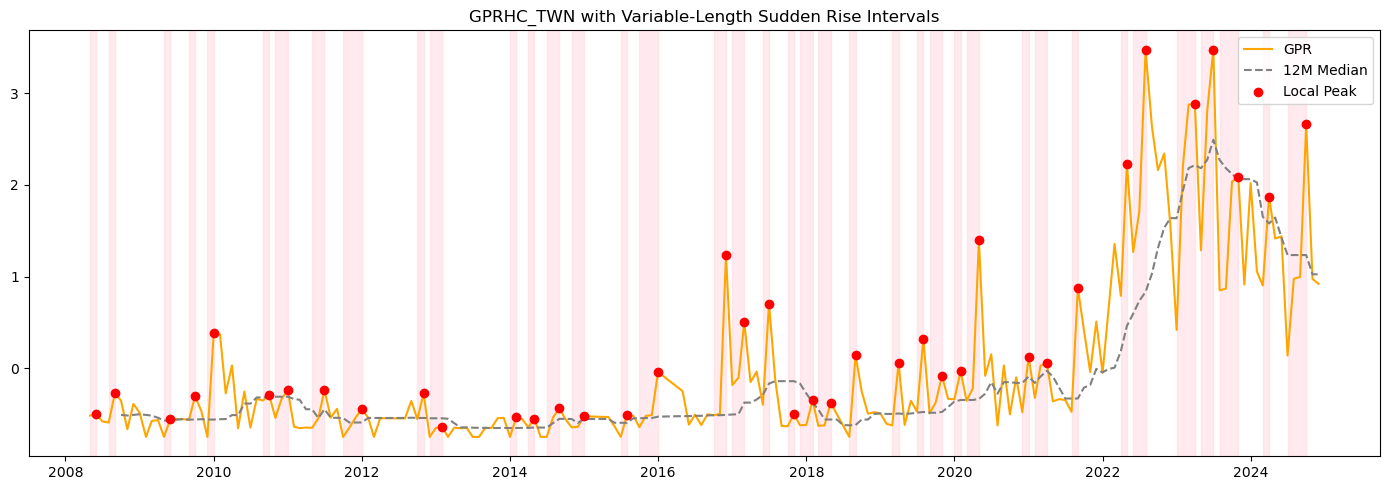

Start_Date   End_Date  Duration_Months
0  2008-05-01 2008-06-01                2
1  2008-08-01 2008-09-01                2
2  2009-05-01 2009-06-01                2
3  2009-09-01 2009-10-01                2
4  2009-12-01 2010-01-01                2
5  2010-09-01 2010-10-01                2
6  2010-11-01 2011-01-01                3
7  2011-05-01 2011-07-01                3
8  2011-10-01 2012-01-01                4
9  2012-10-01 2012-11-01                2
10 2012-12-01 2013-02-01                3
11 2014-01-01 2014-02-01                2
12 2014-04-01 2014-05-01                2
13 2014-07-01 2014-09-01                3
14 2014-11-01 2015-01-01                3
15 2015-07-01 2015-08-01                2
16 2015-10-01 2016-01-01                4
17 2016-10-01 2016-12-01                3
18 2017-01-01 2017-03-01                3
19 2017-06-01 2017-07-01                2
20 2017-10-01 2017-11-01                2
21 2017-12-01 2018-02-01                3
22 2018-03-01 2018-05-01                3
23 2018-08-01 2018-09-01                2
24 2019-03-01 2019-04-01                2
25 2019-07-01 2019-08-01                2
26 2019-09-01 2019-11-01                3
27 2020-01-01 2020-02-01                2
28 2020-03-01 2020-05-01                3
29 2020-12-01 2021-01-01                2
30 2021-02-01 2021-04-01                3
31 2021-08-01 2021-09-01                2
32 2022-04-01 2022-05-01                2
33 2022-06-01 2022-08-01                3
34 2023-01-01 2023-04-01                4
35 2023-05-01 2023-07-01                3
36 2023-08-01 2023-11-01                4
37 2024-03-01 2024-04-01                2
38 2024-07-01 2024-10-01                4

In [11]:
df["GPR_MA12"] = df["GPRHC_TWN"].rolling(window=12, min_periods=6).median()

# ======== 局部高點 ========
df["local_max"] = np.nan
peak_indices = argrelextrema(df["GPRHC_TWN"].values, np.greater, order=2)[0]
df.loc[peak_indices, "local_max"] = df.loc[peak_indices, "GPRHC_TWN"]

# ======== 驟升事件（1~4 個月遞增） ========
event_ranges = []
for idx in peak_indices:
    for window in range(4, 0, -1):  # 優先找最長連續上升（4→1）
        if idx >= window:
            trend = df.loc[idx - window:idx, "GPRHC_TWN"].values
            if np.all(np.diff(trend) > 0):  # 嚴格遞增
                start_date = df.loc[idx - window, "Date"]
                end_date = df.loc[idx, "Date"]
                event_ranges.append((start_date, end_date))
                break  # 找到就退出這個高點判斷

plt.figure(figsize=(14, 5))
plt.plot(df["Date"], df["GPRHC_TWN"], label="GPR", linewidth=1.5, color='orange')
plt.plot(df["Date"], df["GPR_MA12"], label="12M Median", linestyle="--", color="gray")

# 局部高點
plt.scatter(df.loc[peak_indices, "Date"], df.loc[peak_indices, "GPRHC_TWN"],
            color='red', label='Local Peak', zorder=5)

# 驟升區間
for start_date, end_date in event_ranges:
    plt.axvspan(start_date, end_date, color='pink', alpha=0.3)

plt.title("GPRHC_TWN with Variable-Length Sudden Rise Intervals")
plt.legend()
plt.tight_layout()
plt.show()

# ======== 事件df ========
event_df = pd.DataFrame(event_ranges, columns=["Start_Date", "End_Date"])
event_df["Duration_Months"] = (event_df["End_Date"].dt.to_period("M") - event_df["Start_Date"].dt.to_period("M")).apply(lambda x: x.n) + 1
event_df.to_csv("GPR_rise.csv", index=False)
event_df


#### Mean

In [14]:
if "YearMonth" not in df.columns:
    if "Year" in df.columns and "Month" in df.columns:
        df["YearMonth"] = df["Year"].astype(str) + "-" + df["Month"].astype(str).str.zfill(2)
    else:
        raise ValueError("df 中缺少 Year 或 Month 欄位，請確認資料格式")
    
summary_stats = []
for role in ["Foreign Investors", "Investment Trust", "Dealer"]:
    before_list = []
    during_list = []
    after_list = []

    for start, end in event_ranges:
        start_period = pd.Period(start, freq="M")
        end_period = pd.Period(end, freq="M")

        # 前２個月
        before_window = [(start_period + offset).strftime('%Y-%m') for offset in [-2, -1]]
        # 事件期間（多月）
        during_window = pd.period_range(start=start_period, end=end_period, freq='M').strftime('%Y-%m').tolist()
        # 後２個月
        after_window = [(end_period + offset).strftime('%Y-%m') for offset in [1, 2]]

        before_values = df[df["YearMonth"].isin(before_window)][role].dropna()
        during_values = df[df["YearMonth"].isin(during_window)][role].dropna()
        after_values = df[df["YearMonth"].isin(after_window)][role].dropna()

        if len(before_values) > 0 and len(during_values) > 0 and len(after_values) > 0:
            before_list.append(before_values.mean())
            during_list.append(during_values.mean())
            after_list.append(after_values.mean())

    if len(before_list) == len(during_list) == len(after_list) and len(before_list) > 1:
        t1, p1 = ttest_rel(before_list, during_list)
        t2, p2 = ttest_rel(during_list, after_list)
        before_mean = np.mean(before_list)
        during_mean = np.mean(during_list)
        after_mean = np.mean(after_list)
        summary_stats.append({
            "Role": role,
            "Before Avg": before_mean,
            "During Avg": during_mean,
            "After Avg": after_mean,
            "Before→During Δ": during_mean - before_mean,
            "During→After Δ": after_mean - during_mean,
            "Before→During p": p1,
            "During→After p": p2,
            "N Events": len(before_list)
        })

summary_df = pd.DataFrame(summary_stats)
summary_df.to_csv("institutional_GPR_event_window_summary.csv", index=False)
summary_df

Role    Before Avg    During Avg     After Avg  \
0  Foreign Investors -9.720342e+09 -1.275013e+10 -1.299487e+10   
1   Investment Trust  3.020931e+09  8.353560e+09  6.019068e+09   
2             Dealer -3.804881e+09 -9.797701e+09 -7.861367e+09   

   Before→During Δ  During→After Δ  Before→During p  During→After p  N Events  
0    -3.029791e+09   -2.447342e+08         0.809628        0.986039        36  
1     5.332629e+09   -2.334492e+09         0.184223        0.472299        36  
2    -5.992821e+09    1.936334e+09         0.207937        0.695661        36

/var/folders/m3/4kw7w40s6p56xt563fshsjjh0000gn/T/ipykernel_95964/1805041457.py:24: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=delta_df, x="Comparison", y="Delta", hue="Role", ci=None)


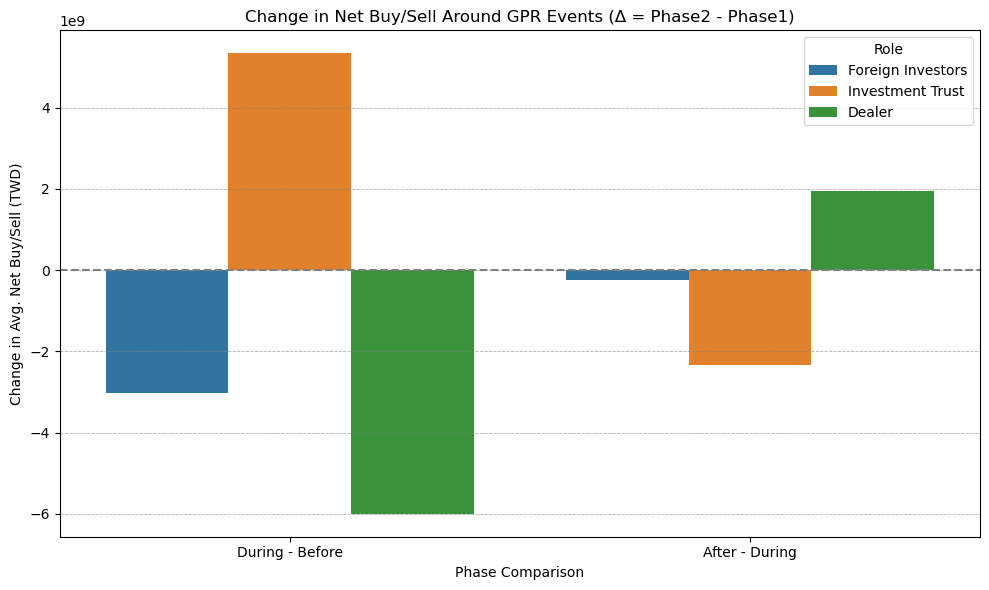

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

plot_delta = []
for _, row in summary_df.iterrows():
    plot_delta.append({
        "Role": row["Role"],
        "Comparison": "During - Before",
        "Delta": row["Before→During Δ"],
        "p-value": row.get("Before→During p", None)
    })
    plot_delta.append({
        "Role": row["Role"],
        "Comparison": "After - During",
        "Delta": row["During→After Δ"],
        "p-value": row.get("During→After p", None)
    })

delta_df = pd.DataFrame(plot_delta)

# 變化量分組柱狀圖
plt.figure(figsize=(10, 6))
sns.barplot(data=delta_df, x="Comparison", y="Delta", hue="Role", ci=None)
plt.axhline(0, color="gray", linestyle="--")
plt.title("Change in Net Buy/Sell Around GPR Events (Δ = Phase2 - Phase1)")
plt.ylabel("Change in Avg. Net Buy/Sell (TWD)")
plt.xlabel("Phase Comparison")

# 顯著性星號
for i, row in delta_df.iterrows():
    if row["p-value"] is not None and row["p-value"] < 0.05:
        x = i // 3 + [-0.25, 0, 0.25][i % 3]  # x 軸位置視角色偏移
        y = row["Delta"] + (2 if row["Delta"] > 0 else -2)
        plt.text(x, y, "*", color="red", ha="center", fontsize=16)

plt.grid(axis='y', linestyle='--', linewidth=0.6, color='gray', alpha=0.6)
# plt.gca().yaxis.grid(False)    
plt.gca().xaxis.grid(False)   

plt.tight_layout()
plt.show()


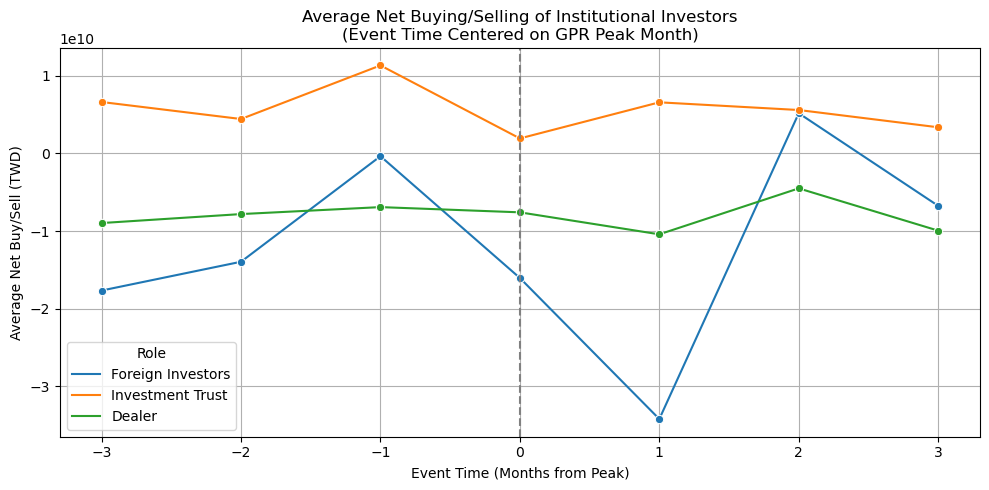

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

if "YearMonth" not in df.columns:
    if "Year" in df.columns and "Month" in df.columns:
        df["YearMonth"] = df["Year"].astype(str) + "-" + df["Month"].astype(str).str.zfill(2)
    else:
        raise ValueError("df 中缺少 Year 或 Month 欄位，請確認資料格式")

# 以事件 peak（End）為中心（t = -3 ~ +3）
event_expanded_peak = []
for start, end in event_ranges:
    event_center = pd.Period(end, freq="M")
    for offset in range(-3, 4):
        period = (event_center + offset).strftime('%Y-%m')
        event_expanded_peak.append({
            "EventTime": offset,
            "YearMonth": period
        })

event_df_peak = pd.DataFrame(event_expanded_peak)


merged_df_peak = pd.merge(event_df_peak, df, on="YearMonth", how="left")

# 平均法人行為
plot_data = []
for role in ["Foreign Investors", "Investment Trust", "Dealer"]:
    avg_behavior = merged_df_peak.groupby("EventTime")[role].mean()
    for t, val in avg_behavior.items():
        plot_data.append({"Role": role, "EventTime": t, "AvgNetBuySell": val})

plot_df_peak = pd.DataFrame(plot_data)

# 以 Peak 為 t=0
plt.figure(figsize=(10, 5))
sns.lineplot(data=plot_df_peak, x="EventTime", y="AvgNetBuySell", hue="Role", marker="o")
plt.axvline(0, linestyle="--", color="gray")
plt.title("Average Net Buying/Selling of Institutional Investors\n(Event Time Centered on GPR Peak Month)")
plt.xlabel("Event Time (Months from Peak)")
plt.ylabel("Average Net Buy/Sell (TWD)")
plt.grid(True)
plt.tight_layout()
plt.show()


#### Median

In [ ]:
summary_stats = []
for role in ["Foreign Investors", "Investment Trust", "Dealer"]:
    before_list = []
    during_list = []
    after_list = []

    for start, end in event_ranges:
        start_period = pd.Period(start, freq="M")
        end_period = pd.Period(end, freq="M")

        # 前２個月
        before_window = [(start_period + offset).strftime('%Y-%m') for offset in [-2, -1]]
        # 事件期間（多月）
        during_window = pd.period_range(start=start_period, end=end_period, freq='M').strftime('%Y-%m').tolist()
        # 後２個月
        after_window = [(end_period + offset).strftime('%Y-%m') for offset in [1, 2]]

        before_values = df[df["YearMonth"].isin(before_window)][role].dropna()
        during_values = df[df["YearMonth"].isin(during_window)][role].dropna()
        after_values = df[df["YearMonth"].isin(after_window)][role].dropna()

        if len(before_values) > 0 and len(during_values) > 0 and len(after_values) > 0:
            before_list.append(before_values.mean())
            during_list.append(during_values.mean())
            after_list.append(after_values.mean())

    if len(before_list) == len(during_list) == len(after_list) and len(before_list) > 1:
        t1, p1 = ttest_rel(before_list, during_list)
        t2, p2 = ttest_rel(during_list, after_list)
        before_median = np.median(before_list)
        during_median = np.median(during_list)
        after_median = np.median(after_list)
        summary_stats.append({
            "Role": role,
            "Before Median": before_median,
            "During Median": during_median,
            "After Median": after_median,
            "Before→During Δ": during_median - before_median,
            "During→After Δ": after_median - during_median,
            "Before→During p": p1,
            "During→After p": p2,
            "N Events": len(before_list)
        })

summary_df_median = pd.DataFrame(summary_stats)
summary_df_median.to_csv("institutional_GPR_event_window_summary_median.csv", index=False)
summary_df_median


Role  Before Median  During Median  After Median  \
0  Foreign Investors   5.991311e+09   4.867234e+09  8.403286e+09   
1   Investment Trust  -5.686987e+08   3.253992e+08  8.916949e+08   
2             Dealer   5.746317e+08  -2.241982e+09  2.980482e+08   

   Before→During Δ  During→After Δ  Before→During p  During→After p  N Events  
0    -1.124077e+09    3.536052e+09         0.809628        0.986039        36  
1     8.940978e+08    5.662957e+08         0.184223        0.472299        36  
2    -2.816613e+09    2.540030e+09         0.207937        0.695661        36

/var/folders/m3/4kw7w40s6p56xt563fshsjjh0000gn/T/ipykernel_95964/1056612698.py:24: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=delta_df, x="Comparison", y="Delta", hue="Role", ci=None)


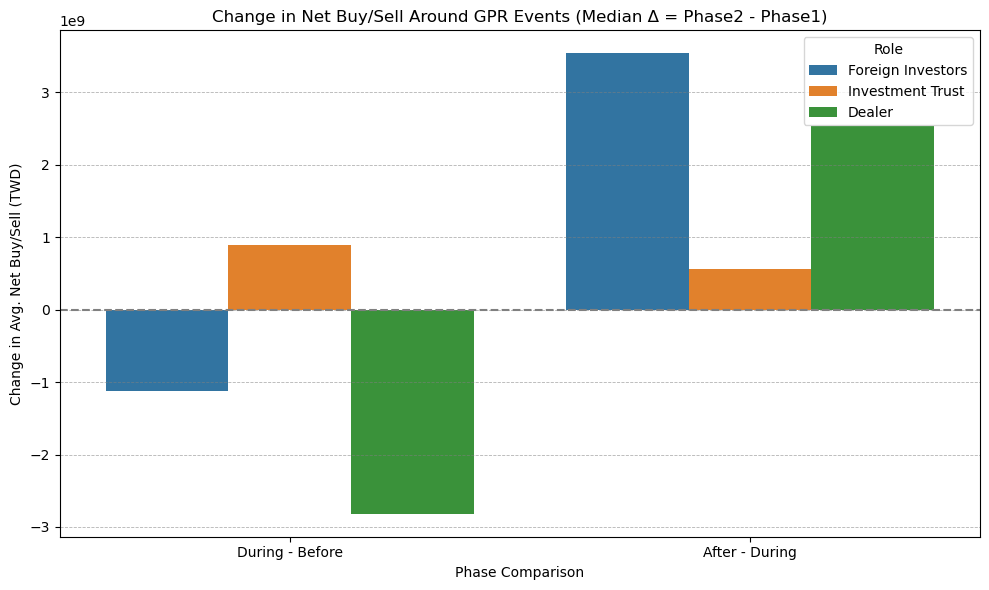

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

plot_delta = []
for _, row in summary_df_median.iterrows():
    plot_delta.append({
        "Role": row["Role"],
        "Comparison": "During - Before",
        "Delta": row["Before→During Δ"],
        "p-value": row.get("Before→During p", None)
    })
    plot_delta.append({
        "Role": row["Role"],
        "Comparison": "After - During",
        "Delta": row["During→After Δ"],
        "p-value": row.get("During→After p", None)
    })

delta_df = pd.DataFrame(plot_delta)

# 變化量分組柱狀圖
plt.figure(figsize=(10, 6))
sns.barplot(data=delta_df, x="Comparison", y="Delta", hue="Role", ci=None)
plt.axhline(0, color="gray", linestyle="--")
plt.title("Change in Net Buy/Sell Around GPR Events (Median Δ = Phase2 - Phase1)")
plt.ylabel("Change in Avg. Net Buy/Sell (TWD)")
plt.xlabel("Phase Comparison")

# 顯著性星號
for i, row in delta_df.iterrows():
    if row["p-value"] is not None and row["p-value"] < 0.05:
        x = i // 3 + [-0.25, 0, 0.25][i % 3]  # x 軸位置視角色偏移
        y = row["Delta"] + (2 if row["Delta"] > 0 else -2)
        plt.text(x, y, "*", color="red", ha="center", fontsize=16)

plt.grid(axis='y', linestyle='--', linewidth=0.6, color='gray', alpha=0.6)
# plt.gca().yaxis.grid(False)    
plt.gca().xaxis.grid(False)   

plt.tight_layout()
plt.show()


##### GPR Surge_New

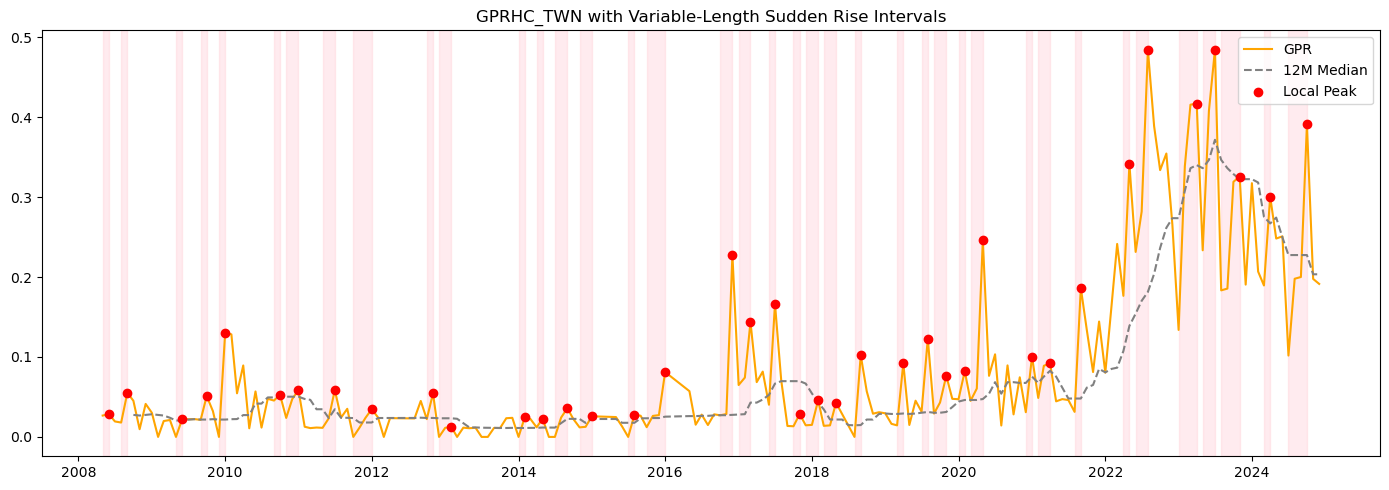

Start_Date   End_Date  Duration_Months
0  2008-05-01 2008-06-01                2
1  2008-08-01 2008-09-01                2
2  2009-05-01 2009-06-01                2
3  2009-09-01 2009-10-01                2
4  2009-12-01 2010-01-01                2
5  2010-09-01 2010-10-01                2
6  2010-11-01 2011-01-01                3
7  2011-05-01 2011-07-01                3
8  2011-10-01 2012-01-01                4
9  2012-10-01 2012-11-01                2
10 2012-12-01 2013-02-01                3
11 2014-01-01 2014-02-01                2
12 2014-04-01 2014-05-01                2
13 2014-07-01 2014-09-01                3
14 2014-11-01 2015-01-01                3
15 2015-07-01 2015-08-01                2
16 2015-10-01 2016-01-01                4
17 2016-10-01 2016-12-01                3
18 2017-01-01 2017-03-01                3
19 2017-06-01 2017-07-01                2
20 2017-10-01 2017-11-01                2
21 2017-12-01 2018-02-01                3
22 2018-03-01 2018-05-01                3
23 2018-08-01 2018-09-01                2
24 2019-03-01 2019-04-01                2
25 2019-07-01 2019-08-01                2
26 2019-09-01 2019-11-01                3
27 2020-01-01 2020-02-01                2
28 2020-03-01 2020-05-01                3
29 2020-12-01 2021-01-01                2
30 2021-02-01 2021-04-01                3
31 2021-08-01 2021-09-01                2
32 2022-04-01 2022-05-01                2
33 2022-06-01 2022-08-01                3
34 2023-01-01 2023-04-01                4
35 2023-05-01 2023-07-01                3
36 2023-08-01 2023-11-01                4
37 2024-03-01 2024-04-01                2
38 2024-07-01 2024-10-01                4

In [95]:

df["GPR_MA12"] = df["GPRHC_TWN"].rolling(window=12, min_periods=6).median()

# ======== 局部高點 ========
df["local_max"] = np.nan
peak_indices = argrelextrema(df["GPRHC_TWN"].values, np.greater, order=2)[0]
df.loc[peak_indices, "local_max"] = df.loc[peak_indices, "GPRHC_TWN"]

# ======== 驟升事件（1~4 個月遞增） ========
event_ranges = []
for idx in peak_indices:
    for window in range(4, 0, -1):  # 優先找最長連續上升（4→1）
        if idx >= window:
            trend = df.loc[idx - window:idx, "GPRHC_TWN"].values
            if np.all(np.diff(trend) > 0):  # 嚴格遞增
                start_date = df.loc[idx - window, "Date"]
                end_date = df.loc[idx, "Date"]
                event_ranges.append((start_date, end_date))
                break  # 找到就退出這個高點判斷

plt.figure(figsize=(14, 5))
plt.plot(df["Date"], df["GPRHC_TWN"], label="GPR", linewidth=1.5, color='orange')
plt.plot(df["Date"], df["GPR_MA12"], label="12M Median", linestyle="--", color="gray")

# 局部高點
plt.scatter(df.loc[peak_indices, "Date"], df.loc[peak_indices, "GPRHC_TWN"],
            color='red', label='Local Peak', zorder=5)

# 驟升區間
for start_date, end_date in event_ranges:
    plt.axvspan(start_date, end_date, color='pink', alpha=0.3)

plt.title("GPRHC_TWN with Variable-Length Sudden Rise Intervals")
plt.legend()
plt.tight_layout()
plt.show()

# ======== 事件df ========
event_df = pd.DataFrame(event_ranges, columns=["Start_Date", "End_Date"])
event_df["Duration_Months"] = (event_df["End_Date"].dt.to_period("M") - event_df["Start_Date"].dt.to_period("M")).apply(lambda x: x.n) + 1
event_df.to_csv("GPR_rise.csv", index=False)
event_df


In [96]:
summary_stats = []
for role in ["Foreign Investors", "Investment Trust", "Dealer"]:
    before_list = []
    during_list = []
    after_list = []

    for start, end in event_ranges:
        start_period = pd.Period(start, freq="M")
        end_period = pd.Period(end, freq="M")

        # 前２個月
        before_window = [(start_period + offset).strftime('%Y-%m') for offset in [-2, -1]]
        # 事件期間（多月）
        during_window = pd.period_range(start=start_period, end=end_period, freq='M').strftime('%Y-%m').tolist()
        # 後２個月
        after_window = [(end_period + offset).strftime('%Y-%m') for offset in [1, 2]]

        before_values = df[df["YearMonth"].isin(before_window)][role].dropna()
        during_values = df[df["YearMonth"].isin(during_window)][role].dropna()
        after_values = df[df["YearMonth"].isin(after_window)][role].dropna()

        if len(before_values) > 0 and len(during_values) > 0 and len(after_values) > 0:
            before_list.append(before_values.mean())
            during_list.append(during_values.mean())
            after_list.append(after_values.mean())

    if len(before_list) == len(during_list) == len(after_list) and len(before_list) > 1:
        t1, p1 = ttest_rel(before_list, during_list)
        t2, p2 = ttest_rel(during_list, after_list)
        before_median = np.median(before_list)
        during_median = np.median(during_list)
        after_median = np.median(after_list)
        summary_stats.append({
            "Role": role,
            "Before Median": before_median,
            "During Median": during_median,
            "After Median": after_median,
            "Before→During Δ": during_median - before_median,
            "During→After Δ": after_median - during_median,
            "Before→During p": p1,
            "During→After p": p2,
            "N Events": len(before_list)
        })

summary_df_median = pd.DataFrame(summary_stats)
summary_df_median.to_csv("institutional_GPR_event_window_summary_median.csv", index=False)
summary_df_median


Role  Before Median  During Median  After Median  \
0  Foreign Investors   5.991311e+09   4.867234e+09  8.403286e+09   
1   Investment Trust  -5.686987e+08   3.253992e+08  8.916949e+08   
2             Dealer   5.746317e+08  -2.241982e+09  2.980482e+08   

   Before→During Δ  During→After Δ  Before→During p  During→After p  N Events  
0    -1.124077e+09    3.536052e+09         0.809628        0.986039        36  
1     8.940978e+08    5.662957e+08         0.184223        0.472299        36  
2    -2.816613e+09    2.540030e+09         0.207937        0.695661        36

/var/folders/m3/4kw7w40s6p56xt563fshsjjh0000gn/T/ipykernel_52902/294274737.py:79: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=delta_df, x="Comparison", y="Delta", hue="Role", ci=None)


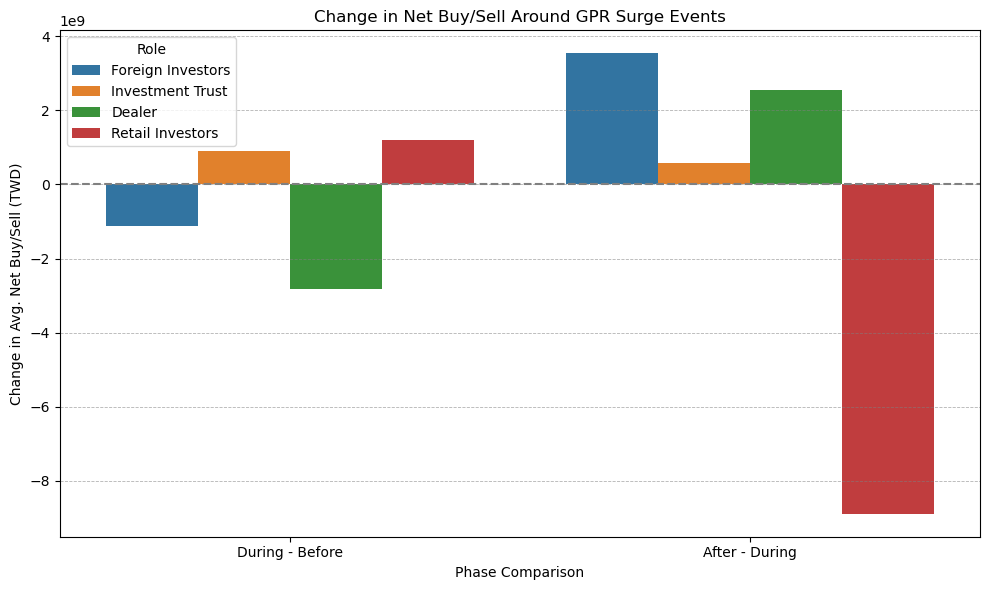

In [97]:
if "YearMonth" not in df.columns:
    if "Year" in df.columns and "Month" in df.columns:
        df["YearMonth"] = df["Year"].astype(str) + "-" + df["Month"].astype(str).str.zfill(2)
    else:
        raise ValueError("df 中缺少 Year 或 Month 欄位，請確認資料格式")


summary_stats = []
# 加上 "Retail Investors"
for role in ["Foreign Investors", "Investment Trust", "Dealer", "Retail Investors"]:
    before_list = []
    during_list = []
    after_list = []

    for start, end in event_ranges:
        start_period = pd.Period(start, freq="M")
        end_period = pd.Period(end, freq="M")

        # 前２個月
        before_window = [(start_period + offset).strftime('%Y-%m') for offset in [-2, -1]]
        # 事件期間（多月）
        during_window = pd.period_range(start=start_period, end=end_period, freq='M').strftime('%Y-%m').tolist()
        # 後２個月
        after_window = [(end_period + offset).strftime('%Y-%m') for offset in [1, 2]]

        before_values = df[df["YearMonth"].isin(before_window)][role].dropna()
        during_values = df[df["YearMonth"].isin(during_window)][role].dropna()
        after_values = df[df["YearMonth"].isin(after_window)][role].dropna()

        if len(before_values) > 0 and len(during_values) > 0 and len(after_values) > 0:
            before_list.append(before_values.mean())
            during_list.append(during_values.mean())
            after_list.append(after_values.mean())

    if len(before_list) == len(during_list) == len(after_list) and len(before_list) > 1:
        t1, p1 = ttest_rel(before_list, during_list)
        t2, p2 = ttest_rel(during_list, after_list)
        before_median = np.median(before_list)
        during_median = np.median(during_list)
        after_median = np.median(after_list)
        summary_stats.append({
            "Role": role,
            "Before Median": before_median,
            "During Median": during_median,
            "After Median": after_median,
            "Before→During Δ": during_median - before_median,
            "During→After Δ": after_median - during_median,
            "Before→During p": p1,
            "During→After p": p2,
            "N Events": len(before_list)
        })

summary_df_median = pd.DataFrame(summary_stats)
summary_df_median.to_csv("GPR_event_window_summary_median.csv", index=False)
summary_df_median

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

plot_delta = []
for _, row in summary_df_median.iterrows():
    plot_delta.append({
        "Role": row["Role"],
        "Comparison": "During - Before",
        "Delta": row["Before→During Δ"],
        "p-value": row.get("Before→During p", None)
    })
    plot_delta.append({
        "Role": row["Role"],
        "Comparison": "After - During",
        "Delta": row["During→After Δ"],
        "p-value": row.get("During→After p", None)
    })

delta_df = pd.DataFrame(plot_delta)

plt.figure(figsize=(10, 6))
sns.barplot(data=delta_df, x="Comparison", y="Delta", hue="Role", ci=None)
plt.axhline(0, color="gray", linestyle="--")
plt.title("Change in Net Buy/Sell Around GPR Surge Events")
plt.ylabel("Change in Avg. Net Buy/Sell (TWD)")
plt.xlabel("Phase Comparison")

# 顯著性星號
for i, row in delta_df.iterrows():
    if row["p-value"] is not None and row["p-value"] < 0.05:
        x = i // 4 + [-0.3, -0.1, 0.1, 0.3][i % 4]  # 根據角色數重新調整位置
        y = row["Delta"] + (2 if row["Delta"] > 0 else -2)
        plt.text(x, y, "*", color="red", ha="center", fontsize=16)

plt.grid(axis='y', linestyle='--', linewidth=0.6, color='gray', alpha=0.6)
plt.gca().xaxis.grid(False)   

plt.tight_layout()
plt.show()


### GPR 驟降

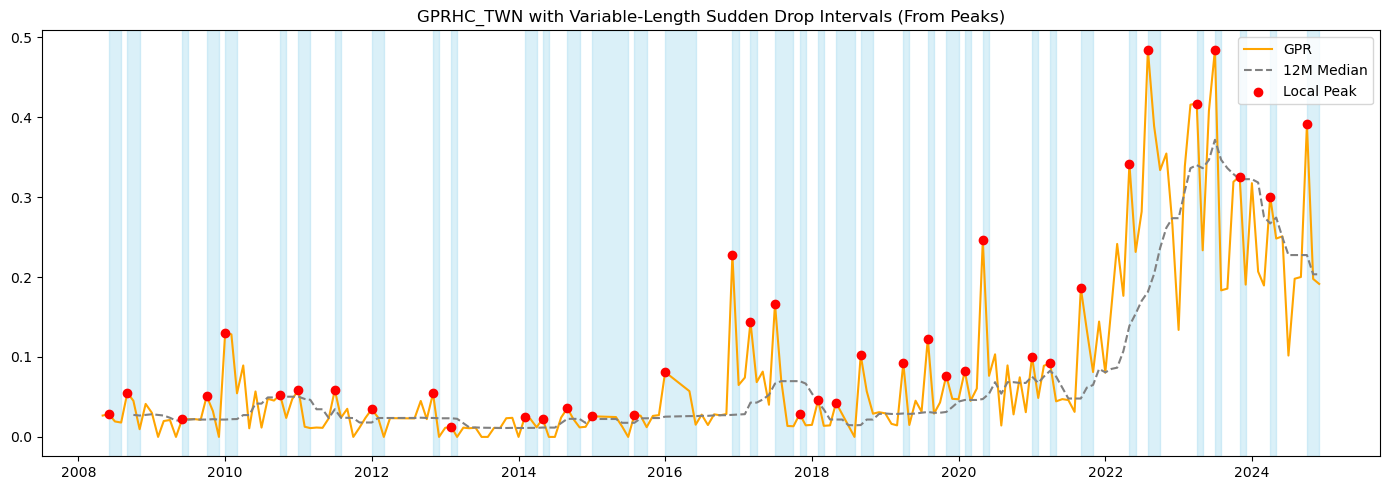

Start_Date   End_Date  Duration_Months
0  2008-06-01 2008-08-01                3
1  2008-09-01 2008-11-01                3
2  2009-06-01 2009-07-01                2
3  2009-10-01 2009-12-01                3
4  2010-01-01 2010-03-01                3
5  2010-10-01 2010-11-01                2
6  2011-01-01 2011-03-01                3
7  2011-07-01 2011-08-01                2
8  2012-01-01 2012-03-01                3
9  2012-11-01 2012-12-01                2
10 2013-02-01 2013-03-01                2
11 2014-02-01 2014-04-01                3
12 2014-05-01 2014-06-01                2
13 2014-09-01 2014-11-01                3
14 2015-01-01 2015-07-01                7
15 2015-08-01 2015-10-01                3
16 2016-01-01 2016-06-01                6
17 2016-12-01 2017-01-01                2
18 2017-03-01 2017-04-01                2
19 2017-07-01 2017-10-01                4
20 2017-11-01 2017-12-01                2
21 2018-02-01 2018-03-01                2
22 2018-05-01 2018-08-01                4
23 2018-09-01 2018-11-01                3
24 2019-04-01 2019-05-01                2
25 2019-08-01 2019-09-01                2
26 2019-11-01 2020-01-01                3
27 2020-02-01 2020-03-01                2
28 2020-05-01 2020-06-01                2
29 2021-01-01 2021-02-01                2
30 2021-04-01 2021-05-01                2
31 2021-09-01 2021-11-01                3
32 2022-05-01 2022-06-01                2
33 2022-08-01 2022-10-01                3
34 2023-04-01 2023-05-01                2
35 2023-07-01 2023-08-01                2
36 2023-11-01 2023-12-01                2
37 2024-04-01 2024-05-01                2
38 2024-10-01 2024-12-01                3

In [88]:
# ======== 移動中位數 ========
df["GPR_MA12"] = df["GPRHC_TWN"].rolling(window=12, min_periods=6).median()

# ======== 局部高點（驟降起點） ========
df["local_max"] = np.nan
peak_indices = argrelextrema(df["GPRHC_TWN"].values, np.greater, order=2)[0]
df.loc[peak_indices, "local_max"] = df.loc[peak_indices, "GPRHC_TWN"]

# ======== 驟降事件（從高點往後 1~4 月嚴格遞減） ========
drop_event_ranges = []
for idx in peak_indices:
    for window in range(4, 0, -1):  # 優先找最長連續下降（4→1）
        if idx + window < len(df):
            trend = df.loc[idx:idx + window, "GPRHC_TWN"].values
            if np.all(np.diff(trend) < 0):  # 嚴格遞減
                start_date = df.loc[idx, "Date"]
                end_date = df.loc[idx + window, "Date"]
                drop_event_ranges.append((start_date, end_date))
                break  # 找到就退出這個 peak 判斷


plt.figure(figsize=(14, 5))
plt.plot(df["Date"], df["GPRHC_TWN"], label="GPR", linewidth=1.5, color='orange')
plt.plot(df["Date"], df["GPR_MA12"], label="12M Median", linestyle="--", color="gray")

# 局部高點
plt.scatter(df.loc[peak_indices, "Date"], df.loc[peak_indices, "GPRHC_TWN"],
            color='red', label='Local Peak', zorder=5)

# 驟降區間
for start_date, end_date in drop_event_ranges:
    plt.axvspan(start_date, end_date, color='skyblue', alpha=0.3)

plt.title("GPRHC_TWN with Variable-Length Sudden Drop Intervals (From Peaks)")
plt.legend()
plt.tight_layout()
plt.show()


drop_event_df = pd.DataFrame(drop_event_ranges, columns=["Start_Date", "End_Date"])
drop_event_df["Start_Date"] = pd.to_datetime(drop_event_df["Start_Date"])
drop_event_df["End_Date"] = pd.to_datetime(drop_event_df["End_Date"])
drop_event_df["Duration_Months"] = (
    drop_event_df["End_Date"].dt.to_period("M") - drop_event_df["Start_Date"].dt.to_period("M")
).apply(lambda x: x.n) + 1
drop_event_df.to_csv("GPR_drop.csv", index=False)
drop_event_df

#### Mean

In [20]:
from scipy.stats import ttest_rel

summary_stats_drop = []

for role in ["Foreign Investors", "Investment Trust", "Dealer"]:
    before_list = []
    during_list = []
    after_list = []

    for start, end in drop_event_df[["Start_Date", "End_Date"]].values:
        start_period = pd.Period(start, freq="M")
        end_period = pd.Period(end, freq="M")

        # 前 2 個月
        before_window = [(start_period + offset).strftime('%Y-%m') for offset in [-2, -1]]
        # 驟降事件期間（多月）
        during_window = pd.period_range(start=start_period, end=end_period, freq='M').strftime('%Y-%m').tolist()
        # 後 2 個月
        after_window = [(end_period + offset).strftime('%Y-%m') for offset in [1, 2]]

        before_vals = df[df["YearMonth"].isin(before_window)][role].dropna()
        during_vals = df[df["YearMonth"].isin(during_window)][role].dropna()
        after_vals = df[df["YearMonth"].isin(after_window)][role].dropna()

        if len(before_vals) > 0 and len(during_vals) > 0 and len(after_vals) > 0:
            before_list.append(before_vals.mean())
            during_list.append(during_vals.mean())
            after_list.append(after_vals.mean())

    # 只在數量一致且充足時進行統計檢定
    if len(before_list) == len(during_list) == len(after_list) and len(before_list) > 1:
        t1, p1 = ttest_rel(before_list, during_list)
        t2, p2 = ttest_rel(during_list, after_list)
        before_avg = np.mean(before_list)
        during_avg = np.mean(during_list)
        after_avg = np.mean(after_list)

        summary_stats_drop.append({
            "Role": role,
            "Before Avg": before_avg,
            "During Avg": during_avg,
            "After Avg": after_avg,
            "Before→During Δ": during_avg - before_avg,
            "During→After Δ": after_avg - during_avg,
            "Before→During p": p1,
            "During→After p": p2,
            "N Events": len(before_list)
                })

# 結果輸出
summary_df_drop = pd.DataFrame(summary_stats_drop)
summary_df_drop.to_csv("institutional_GPR_drop_event_window_summary.csv", index=False)
summary_df_drop


Role    Before Avg    During Avg     After Avg  \
0  Foreign Investors -3.960990e+09 -1.673006e+10 -1.583083e+10   
1   Investment Trust  5.411960e+09  2.610263e+09  4.039858e+09   
2             Dealer -3.794355e+09 -6.485405e+09 -9.145622e+09   

   Before→During Δ  During→After Δ  Before→During p  During→After p  N Events  
0    -1.276907e+10    8.992359e+08         0.463296        0.948560        38  
1    -2.801697e+09    1.429595e+09         0.151052        0.438406        38  
2    -2.691051e+09   -2.660217e+09         0.505110        0.381486        38

/var/folders/m3/4kw7w40s6p56xt563fshsjjh0000gn/T/ipykernel_95964/906928883.py:20: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=delta_df, x="Comparison", y="Delta", hue="Role", ci=None)


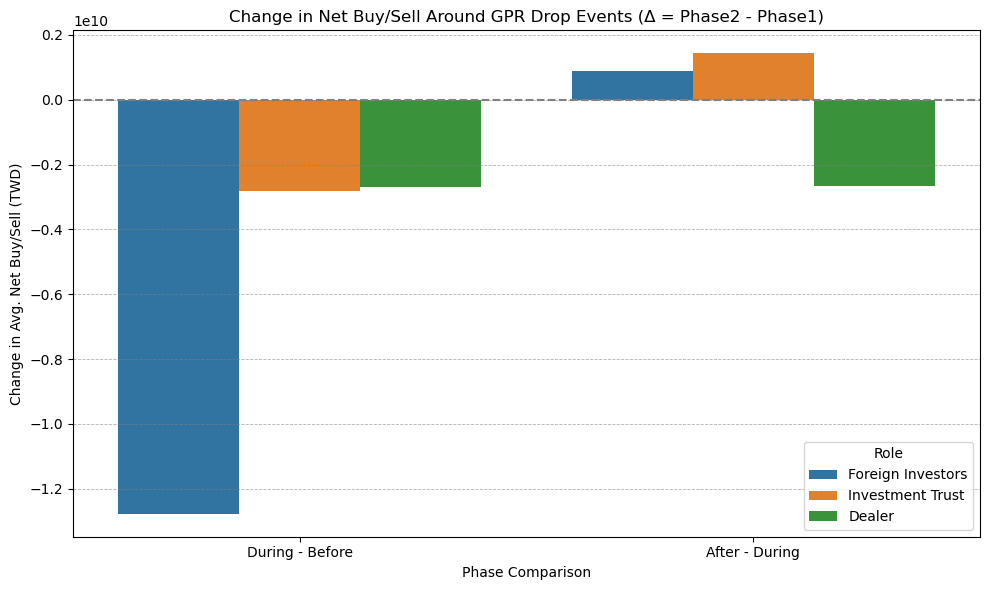

In [22]:
plot_delta = []
for _, row in summary_df_drop.iterrows():
    plot_delta.append({
        "Role": row["Role"],
        "Comparison": "During - Before",
        "Delta": row["Before→During Δ"],
        "p-value": row.get("Before→During p", None)
    })
    plot_delta.append({
        "Role": row["Role"],
        "Comparison": "After - During",
        "Delta": row["During→After Δ"],
        "p-value": row.get("During→After p", None)
    })

delta_df = pd.DataFrame(plot_delta)

# 分組柱狀圖
plt.figure(figsize=(10, 6))
sns.barplot(data=delta_df, x="Comparison", y="Delta", hue="Role", ci=None)
plt.axhline(0, color="gray", linestyle="--")
plt.title("Change in Net Buy/Sell Around GPR Drop Events (Δ = Phase2 - Phase1)")
plt.ylabel("Change in Avg. Net Buy/Sell (TWD)")
plt.xlabel("Phase Comparison")

# 顯著性標註
for i, row in delta_df.iterrows():
    if row["p-value"] is not None and row["p-value"] < 0.05:
        offset = [-0.25, 0, 0.25][i % 3]
        x = (i // 3) + offset
        y = row["Delta"] + (2 if row["Delta"] > 0 else -2)
        plt.text(x, y, "*", color="red", ha="center", fontsize=16)

plt.grid(axis='y', linestyle='--', linewidth=0.6, color='gray', alpha=0.6)
plt.gca().xaxis.grid(False)
plt.tight_layout()
plt.show()

#### Median

In [23]:
from scipy.stats import ttest_rel
import numpy as np
import pandas as pd

summary_stats_drop_median = []

for role in ["Foreign Investors", "Investment Trust", "Dealer"]:
    before_list = []
    during_list = []
    after_list = []

    for start, end in drop_event_df[["Start_Date", "End_Date"]].values:
        start_period = pd.Period(start, freq="M")
        end_period = pd.Period(end, freq="M")

        # 時間窗口
        before_window = [(start_period + offset).strftime('%Y-%m') for offset in [-2, -1]]
        during_window = pd.period_range(start=start_period, end=end_period, freq='M').strftime('%Y-%m').tolist()
        after_window = [(end_period + offset).strftime('%Y-%m') for offset in [1, 2]]

        # 法人資料
        before_vals = df[df["YearMonth"].isin(before_window)][role].dropna()
        during_vals = df[df["YearMonth"].isin(during_window)][role].dropna()
        after_vals = df[df["YearMonth"].isin(after_window)][role].dropna()

        if len(before_vals) > 0 and len(during_vals) > 0 and len(after_vals) > 0:
            before_list.append(before_vals.median())
            during_list.append(during_vals.median())
            after_list.append(after_vals.median())

    if len(before_list) == len(during_list) == len(after_list) and len(before_list) > 1:
        t1, p1 = ttest_rel(before_list, during_list)
        t2, p2 = ttest_rel(during_list, after_list)

        before_median = np.median(before_list)
        during_median = np.median(during_list)
        after_median = np.median(after_list)

        summary_stats_drop_median.append({
            "Role": role,
            "Before Median": before_median,
            "During Median": during_median,
            "After Median": after_median,
            "Before→During Δ": during_median - before_median,
            "During→After Δ": after_median - during_median,
            "Before→During p": p1,
            "During→After p": p2,
            "N Events": len(before_list)
})  

summary_df_drop_median = pd.DataFrame(summary_stats_drop_median)
summary_df_drop_median.to_csv("institutional_GPR_drop_event_window_median_summary.csv", index=False)
summary_df_drop_median


Role  Before Median  During Median  After Median  \
0  Foreign Investors   1.568819e+10  -7.988000e+09 -1.431897e+10   
1   Investment Trust   3.488137e+08  -7.474143e+08 -1.479035e+09   
2             Dealer   3.581723e+08  -4.234437e+09 -2.731974e+09   

   Before→During Δ  During→After Δ  Before→During p  During→After p  N Events  
0    -2.367619e+10   -6.330969e+09         0.419869        0.872914        38  
1    -1.096228e+09   -7.316207e+08         0.163579        0.463699        38  
2    -4.592609e+09    1.502462e+09         0.566487        0.324793        38

/var/folders/m3/4kw7w40s6p56xt563fshsjjh0000gn/T/ipykernel_95964/3287933256.py:20: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=delta_df, x="Comparison", y="Delta", hue="Role", ci=None)


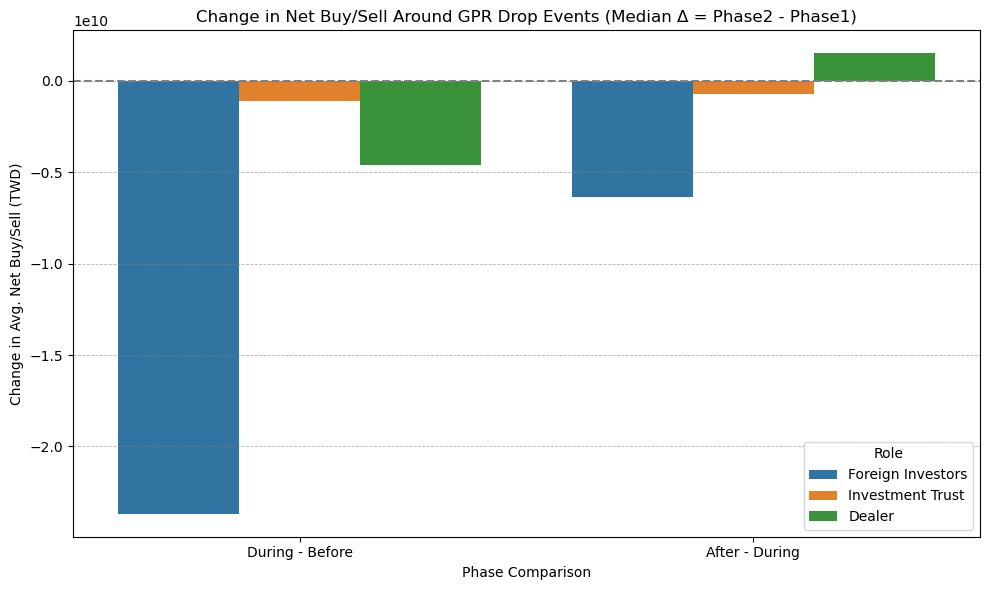

In [24]:
plot_delta = []
for _, row in summary_df_drop_median.iterrows():
    plot_delta.append({
        "Role": row["Role"],
        "Comparison": "During - Before",
        "Delta": row["Before→During Δ"],
        "p-value": row.get("Before→During p", None)
    })
    plot_delta.append({
        "Role": row["Role"],
        "Comparison": "After - During",
        "Delta": row["During→After Δ"],
        "p-value": row.get("During→After p", None)
    })

delta_df = pd.DataFrame(plot_delta)

# 分組柱狀圖
plt.figure(figsize=(10, 6))
sns.barplot(data=delta_df, x="Comparison", y="Delta", hue="Role", ci=None)
plt.axhline(0, color="gray", linestyle="--")
plt.title("Change in Net Buy/Sell Around GPR Drop Events (Median Δ = Phase2 - Phase1)")
plt.ylabel("Change in Avg. Net Buy/Sell (TWD)")
plt.xlabel("Phase Comparison")

# 顯著性標註
for i, row in delta_df.iterrows():
    if row["p-value"] is not None and row["p-value"] < 0.05:
        offset = [-0.25, 0, 0.25][i % 3]
        x = (i // 3) + offset
        y = row["Delta"] + (2 if row["Delta"] > 0 else -2)
        plt.text(x, y, "*", color="red", ha="center", fontsize=16)

plt.grid(axis='y', linestyle='--', linewidth=0.6, color='gray', alpha=0.6)
plt.gca().xaxis.grid(False)
plt.tight_layout()
plt.show()

##### GPR Drop_New

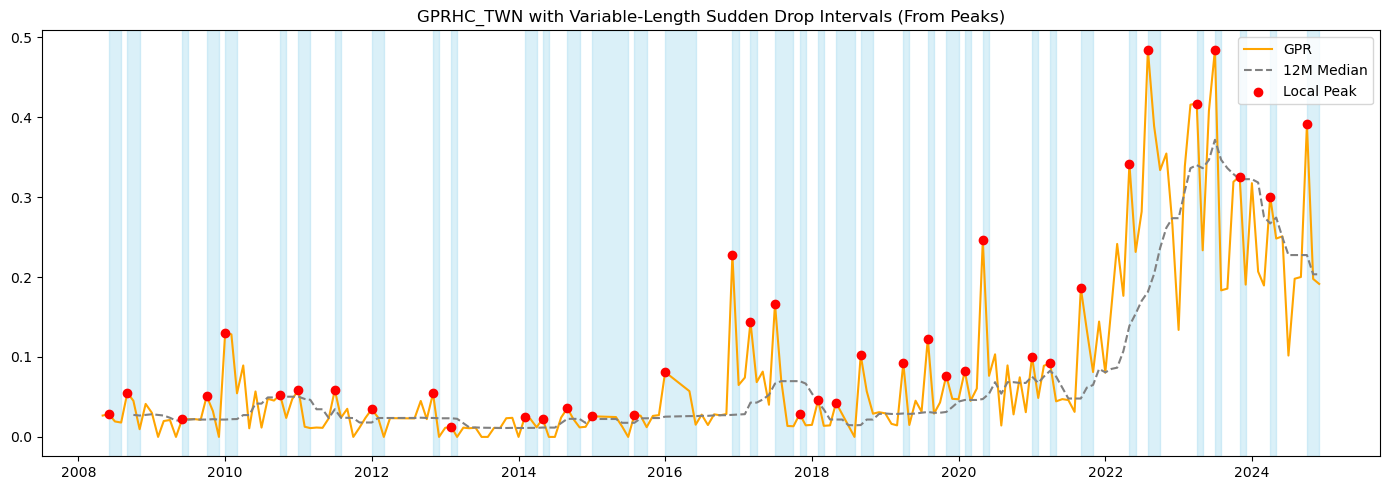

Start_Date   End_Date  Duration_Months
0  2008-06-01 2008-08-01                3
1  2008-09-01 2008-11-01                3
2  2009-06-01 2009-07-01                2
3  2009-10-01 2009-12-01                3
4  2010-01-01 2010-03-01                3
5  2010-10-01 2010-11-01                2
6  2011-01-01 2011-03-01                3
7  2011-07-01 2011-08-01                2
8  2012-01-01 2012-03-01                3
9  2012-11-01 2012-12-01                2
10 2013-02-01 2013-03-01                2
11 2014-02-01 2014-04-01                3
12 2014-05-01 2014-06-01                2
13 2014-09-01 2014-11-01                3
14 2015-01-01 2015-07-01                7
15 2015-08-01 2015-10-01                3
16 2016-01-01 2016-06-01                6
17 2016-12-01 2017-01-01                2
18 2017-03-01 2017-04-01                2
19 2017-07-01 2017-10-01                4
20 2017-11-01 2017-12-01                2
21 2018-02-01 2018-03-01                2
22 2018-05-01 2018-08-01                4
23 2018-09-01 2018-11-01                3
24 2019-04-01 2019-05-01                2
25 2019-08-01 2019-09-01                2
26 2019-11-01 2020-01-01                3
27 2020-02-01 2020-03-01                2
28 2020-05-01 2020-06-01                2
29 2021-01-01 2021-02-01                2
30 2021-04-01 2021-05-01                2
31 2021-09-01 2021-11-01                3
32 2022-05-01 2022-06-01                2
33 2022-08-01 2022-10-01                3
34 2023-04-01 2023-05-01                2
35 2023-07-01 2023-08-01                2
36 2023-11-01 2023-12-01                2
37 2024-04-01 2024-05-01                2
38 2024-10-01 2024-12-01                3

In [98]:
# ======== 移動中位數 ========
df["GPR_MA12"] = df["GPRHC_TWN"].rolling(window=12, min_periods=6).median()

# ======== 局部高點（驟降起點） ========
df["local_max"] = np.nan
peak_indices = argrelextrema(df["GPRHC_TWN"].values, np.greater, order=2)[0]
df.loc[peak_indices, "local_max"] = df.loc[peak_indices, "GPRHC_TWN"]

# ======== 驟降事件（從高點往後 1~4 月嚴格遞減） ========
drop_event_ranges = []
for idx in peak_indices:
    for window in range(4, 0, -1):  # 優先找最長連續下降（4→1）
        if idx + window < len(df):
            trend = df.loc[idx:idx + window, "GPRHC_TWN"].values
            if np.all(np.diff(trend) < 0):  # 嚴格遞減
                start_date = df.loc[idx, "Date"]
                end_date = df.loc[idx + window, "Date"]
                drop_event_ranges.append((start_date, end_date))
                break  # 找到就退出這個 peak 判斷


plt.figure(figsize=(14, 5))
plt.plot(df["Date"], df["GPRHC_TWN"], label="GPR", linewidth=1.5, color='orange')
plt.plot(df["Date"], df["GPR_MA12"], label="12M Median", linestyle="--", color="gray")

# 局部高點
plt.scatter(df.loc[peak_indices, "Date"], df.loc[peak_indices, "GPRHC_TWN"],
            color='red', label='Local Peak', zorder=5)

# 驟降區間
for start_date, end_date in drop_event_ranges:
    plt.axvspan(start_date, end_date, color='skyblue', alpha=0.3)

plt.title("GPRHC_TWN with Variable-Length Sudden Drop Intervals (From Peaks)")
plt.legend()
plt.tight_layout()
plt.show()


drop_event_df = pd.DataFrame(drop_event_ranges, columns=["Start_Date", "End_Date"])
drop_event_df["Start_Date"] = pd.to_datetime(drop_event_df["Start_Date"])
drop_event_df["End_Date"] = pd.to_datetime(drop_event_df["End_Date"])
drop_event_df["Duration_Months"] = (
    drop_event_df["End_Date"].dt.to_period("M") - drop_event_df["Start_Date"].dt.to_period("M")
).apply(lambda x: x.n) + 1
drop_event_df.to_csv("GPR_drop.csv", index=False)
drop_event_df

In [99]:
from scipy.stats import ttest_rel
import numpy as np
import pandas as pd

summary_stats_drop_median = []

for role in ["Foreign Investors", "Investment Trust", "Dealer"]:
    before_list = []
    during_list = []
    after_list = []

    for start, end in drop_event_df[["Start_Date", "End_Date"]].values:
        start_period = pd.Period(start, freq="M")
        end_period = pd.Period(end, freq="M")

        # 時間窗口
        before_window = [(start_period + offset).strftime('%Y-%m') for offset in [-2, -1]]
        during_window = pd.period_range(start=start_period, end=end_period, freq='M').strftime('%Y-%m').tolist()
        after_window = [(end_period + offset).strftime('%Y-%m') for offset in [1, 2]]

        # 法人資料
        before_vals = df[df["YearMonth"].isin(before_window)][role].dropna()
        during_vals = df[df["YearMonth"].isin(during_window)][role].dropna()
        after_vals = df[df["YearMonth"].isin(after_window)][role].dropna()

        if len(before_vals) > 0 and len(during_vals) > 0 and len(after_vals) > 0:
            before_list.append(before_vals.median())
            during_list.append(during_vals.median())
            after_list.append(after_vals.median())

    if len(before_list) == len(during_list) == len(after_list) and len(before_list) > 1:
        t1, p1 = ttest_rel(before_list, during_list)
        t2, p2 = ttest_rel(during_list, after_list)

        before_median = np.median(before_list)
        during_median = np.median(during_list)
        after_median = np.median(after_list)

        summary_stats_drop_median.append({
            "Role": role,
            "Before Median": before_median,
            "During Median": during_median,
            "After Median": after_median,
            "Before→During Δ": during_median - before_median,
            "During→After Δ": after_median - during_median,
            "Before→During p": p1,
            "During→After p": p2,
            "N Events": len(before_list)
})  

summary_df_drop_median = pd.DataFrame(summary_stats_drop_median)
summary_df_drop_median.to_csv("institutional_GPR_drop_event_window_median_summary.csv", index=False)
summary_df_drop_median


Role  Before Median  During Median  After Median  \
0  Foreign Investors   1.568819e+10  -7.988000e+09 -1.431897e+10   
1   Investment Trust   3.488137e+08  -7.474143e+08 -1.479035e+09   
2             Dealer   3.581723e+08  -4.234437e+09 -2.731974e+09   

   Before→During Δ  During→After Δ  Before→During p  During→After p  N Events  
0    -2.367619e+10   -6.330969e+09         0.419869        0.872914        38  
1    -1.096228e+09   -7.316207e+08         0.163579        0.463699        38  
2    -4.592609e+09    1.502462e+09         0.566487        0.324793        38

/var/folders/m3/4kw7w40s6p56xt563fshsjjh0000gn/T/ipykernel_52902/3863341281.py:79: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=delta_df, x="Comparison", y="Delta", hue="Role", ci=None)


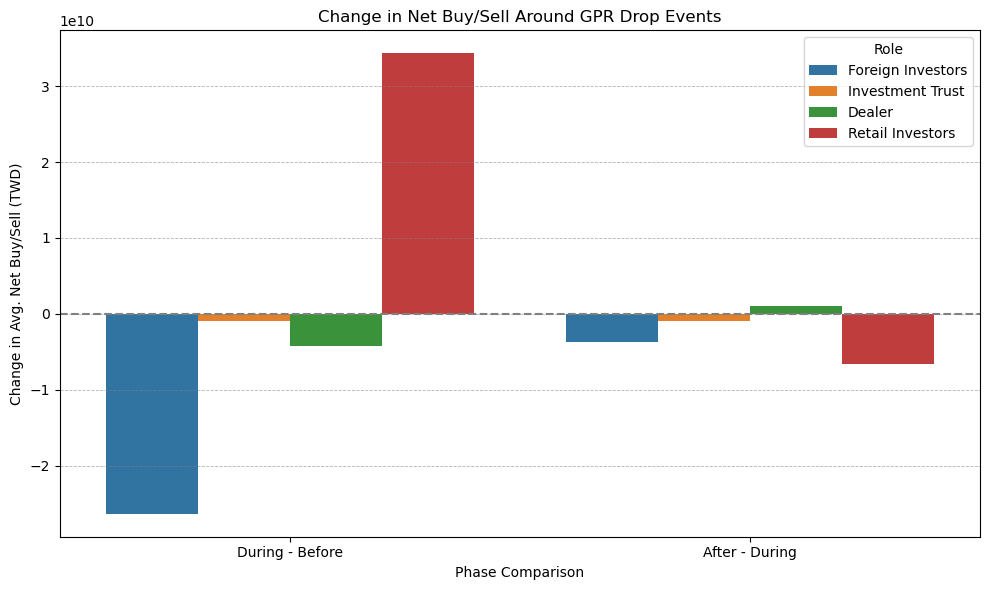

In [92]:
if "YearMonth" not in df.columns:
    if "Year" in df.columns and "Month" in df.columns:
        df["YearMonth"] = df["Year"].astype(str) + "-" + df["Month"].astype(str).str.zfill(2)
    else:
        raise ValueError("df 中缺少 Year 或 Month 欄位，請確認資料格式")


summary_stats = []
# 加上 "Retail Investors"
for role in ["Foreign Investors", "Investment Trust", "Dealer", "Retail Investors"]:
    before_list = []
    during_list = []
    after_list = []

    for start, end in drop_event_ranges:
        start_period = pd.Period(start, freq="M")
        end_period = pd.Period(end, freq="M")

        # 前２個月
        before_window = [(start_period + offset).strftime('%Y-%m') for offset in [-2, -1]]
        # 事件期間（多月）
        during_window = pd.period_range(start=start_period, end=end_period, freq='M').strftime('%Y-%m').tolist()
        # 後２個月
        after_window = [(end_period + offset).strftime('%Y-%m') for offset in [1, 2]]

        before_values = df[df["YearMonth"].isin(before_window)][role].dropna()
        during_values = df[df["YearMonth"].isin(during_window)][role].dropna()
        after_values = df[df["YearMonth"].isin(after_window)][role].dropna()

        if len(before_values) > 0 and len(during_values) > 0 and len(after_values) > 0:
            before_list.append(before_values.mean())
            during_list.append(during_values.mean())
            after_list.append(after_values.mean())

    if len(before_list) == len(during_list) == len(after_list) and len(before_list) > 1:
        t1, p1 = ttest_rel(before_list, during_list)
        t2, p2 = ttest_rel(during_list, after_list)
        before_median = np.median(before_list)
        during_median = np.median(during_list)
        after_median = np.median(after_list)
        summary_stats.append({
            "Role": role,
            "Before Median": before_median,
            "During Median": during_median,
            "After Median": after_median,
            "Before→During Δ": during_median - before_median,
            "During→After Δ": after_median - during_median,
            "Before→During p": p1,
            "During→After p": p2,
            "N Events": len(before_list)
        })

summary_df_median = pd.DataFrame(summary_stats)
summary_df_median.to_csv("GPR_event_window_summary_median.csv", index=False)
summary_df_median

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

plot_delta = []
for _, row in summary_df_median.iterrows():
    plot_delta.append({
        "Role": row["Role"],
        "Comparison": "During - Before",
        "Delta": row["Before→During Δ"],
        "p-value": row.get("Before→During p", None)
    })
    plot_delta.append({
        "Role": row["Role"],
        "Comparison": "After - During",
        "Delta": row["During→After Δ"],
        "p-value": row.get("During→After p", None)
    })

delta_df = pd.DataFrame(plot_delta)

plt.figure(figsize=(10, 6))
sns.barplot(data=delta_df, x="Comparison", y="Delta", hue="Role", ci=None)
plt.axhline(0, color="gray", linestyle="--")
plt.title("Change in Net Buy/Sell Around GPR Drop Events")
plt.ylabel("Change in Avg. Net Buy/Sell (TWD)")
plt.xlabel("Phase Comparison")

# 顯著性星號
for i, row in delta_df.iterrows():
    if row["p-value"] is not None and row["p-value"] < 0.05:
        x = i // 4 + [-0.3, -0.1, 0.1, 0.3][i % 4]  # 根據角色數重新調整位置
        y = row["Delta"] + (2 if row["Delta"] > 0 else -2)
        plt.text(x, y, "*", color="red", ha="center", fontsize=16)

plt.grid(axis='y', linestyle='--', linewidth=0.6, color='gray', alpha=0.6)
plt.gca().xaxis.grid(False)   

plt.tight_layout()
plt.show()


## Global EPU

### EPU 驟升

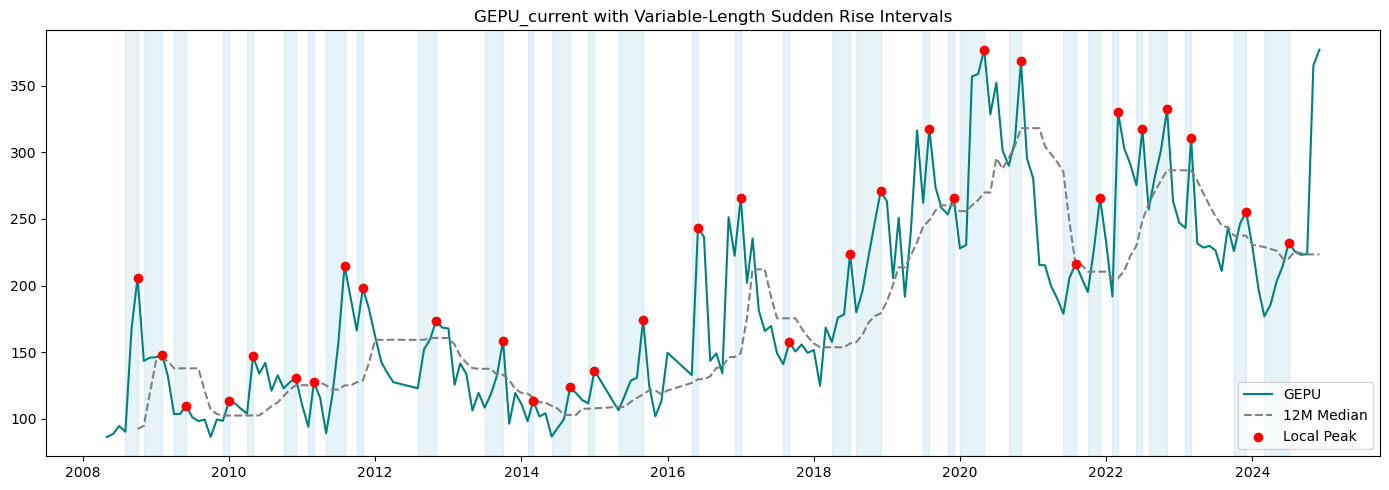

Start_Date   End_Date  Duration_Months
0  2008-08-01 2008-10-01                3
1  2008-11-01 2009-02-01                4
2  2009-04-01 2009-06-01                3
3  2009-12-01 2010-01-01                2
4  2010-04-01 2010-05-01                2
5  2010-10-01 2010-12-01                3
6  2011-02-01 2011-03-01                2
7  2011-05-01 2011-08-01                4
8  2011-10-01 2011-11-01                2
9  2012-08-01 2012-11-01                4
10 2013-07-01 2013-10-01                4
11 2014-02-01 2014-03-01                2
12 2014-06-01 2014-09-01                4
13 2014-12-01 2015-01-01                2
14 2015-05-01 2015-09-01                5
15 2016-05-01 2016-06-01                2
16 2016-12-01 2017-01-01                2
17 2017-08-01 2017-09-01                2
18 2018-04-01 2018-07-01                4
19 2018-08-01 2018-12-01                5
20 2019-07-01 2019-08-01                2
21 2019-11-01 2019-12-01                2
22 2020-01-01 2020-05-01                5
23 2020-09-01 2020-11-01                3
24 2021-06-01 2021-08-01                3
25 2021-10-01 2021-12-01                3
26 2022-02-01 2022-03-01                2
27 2022-06-01 2022-07-01                2
28 2022-08-01 2022-11-01                4
29 2023-02-01 2023-03-01                2
30 2023-10-01 2023-12-01                3
31 2024-03-01 2024-07-01                5

In [100]:
import numpy as np
from scipy.signal import argrelextrema
import matplotlib.pyplot as plt

# ======== 局部高點 ========
df["local_max_gepu"] = np.nan
peak_indices_gepu = argrelextrema(df["GEPU_current"].values, np.greater, order=2)[0]
df.loc[peak_indices_gepu, "local_max_gepu"] = df.loc[peak_indices_gepu, "GEPU_current"]

# ======== 驟升事件（GEPU 當月遞增） ========
event_ranges = []
for idx in peak_indices_gepu:
    for window in range(4, 0, -1):  # 優先找最長連續上升（4→1）
        if idx >= window:
            trend = df.loc[idx - window:idx, "GEPU_current"].values
            if np.all(np.diff(trend) > 0):  # 嚴格遞增
                start_date = df.loc[idx - window, "Date"]
                end_date = df.loc[idx, "Date"]
                event_ranges.append((start_date, end_date))
                break  # 找到就退出這個高點判斷

# ======== 畫出 GEPU 驟升事件 ========
plt.figure(figsize=(14, 5))
plt.plot(df["Date"], df["GEPU_current"], label="GEPU", linewidth=1.5, color='teal')
plt.plot(df["Date"], df["GEPU_current"].rolling(12, min_periods=6).median(), 
         label="12M Median", linestyle="--", color="gray")

# 局部高點標記
plt.scatter(df.loc[peak_indices_gepu, "Date"], df.loc[peak_indices_gepu, "GEPU_current"],
            color='red', label='Local Peak', zorder=5)

# 驟升區間標記
for start_date, end_date in event_ranges:
    plt.axvspan(start_date, end_date, color='lightblue', alpha=0.3)

plt.title("GEPU_current with Variable-Length Sudden Rise Intervals")
plt.legend()
plt.tight_layout()
plt.show()


event_df = pd.DataFrame(event_ranges, columns=["Start_Date", "End_Date"])
event_df["Duration_Months"] = (event_df["End_Date"].dt.to_period("M") - event_df["Start_Date"].dt.to_period("M")).apply(lambda x: x.n) + 1
event_df.to_csv("GEPU_rise.csv", index=False)
event_df

#### Mean

In [26]:
from scipy.stats import ttest_rel


summary_stats_gepu = []
for role in ["Foreign Investors", "Investment Trust", "Dealer"]:
    before_list = []
    during_list = []
    after_list = []

    for start, end in event_ranges:
        start_period = pd.Period(start, freq='M')
        end_period = pd.Period(end, freq='M')

        # 前2個月
        before_window = [(start_period + offset).strftime('%Y-%m') for offset in [-2, -1]]
        # 事件期間（多月）
        during_window = pd.period_range(start=start_period, end=end_period, freq='M').strftime('%Y-%m').tolist()
        # 後2個月
        after_window = [(end_period + offset).strftime('%Y-%m') for offset in [1, 2]]

        before_values = df[df["YearMonth"].isin(before_window)][role].dropna()
        during_values = df[df["YearMonth"].isin(during_window)][role].dropna()
        after_values = df[df["YearMonth"].isin(after_window)][role].dropna()

        if len(before_values) > 0 and len(during_values) > 0 and len(after_values) > 0:
            before_list.append(before_values.mean())
            during_list.append(during_values.mean())
            after_list.append(after_values.mean())

    if len(before_list) == len(during_list) == len(after_list) and len(before_list) > 1:
        t1, p1 = ttest_rel(before_list, during_list)
        t2, p2 = ttest_rel(during_list, after_list)
        before_avg = np.mean(before_list)
        during_avg = np.mean(during_list)
        after_avg = np.mean(after_list)

        summary_stats_gepu.append({
            "Role": role,
            "Before Avg": before_avg,
            "During Avg": during_avg,
            "After Avg": after_avg,
            "Before→During Δ": during_avg - before_avg,
            "During→After Δ": after_avg - during_avg,
            "Before→During p": p1,
            "During→After p": p2,
            "N Events": len(before_list)
})


summary_df_gepu = pd.DataFrame(summary_stats_gepu)
summary_df_gepu.to_csv("institutional_GEPU_event_window_summary.csv", index=False)
summary_df_gepu


Role    Before Avg    During Avg     After Avg  \
0  Foreign Investors -1.742567e+10 -2.026643e+10  4.795780e+09   
1   Investment Trust  4.020217e+09  6.922681e+09  8.062372e+09   
2             Dealer -7.763506e+09 -9.027713e+09 -1.030137e+10   

   Before→During Δ  During→After Δ  Before→During p  During→After p  N Events  
0    -2.840757e+09    2.506221e+10         0.880335        0.094100        28  
1     2.902464e+09    1.139692e+09         0.453426        0.549324        28  
2    -1.264208e+09   -1.273660e+09         0.758801        0.797655        28

/var/folders/m3/4kw7w40s6p56xt563fshsjjh0000gn/T/ipykernel_95964/3099574477.py:24: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=delta_df, x="Comparison", y="Delta", hue="Role", ci=None)


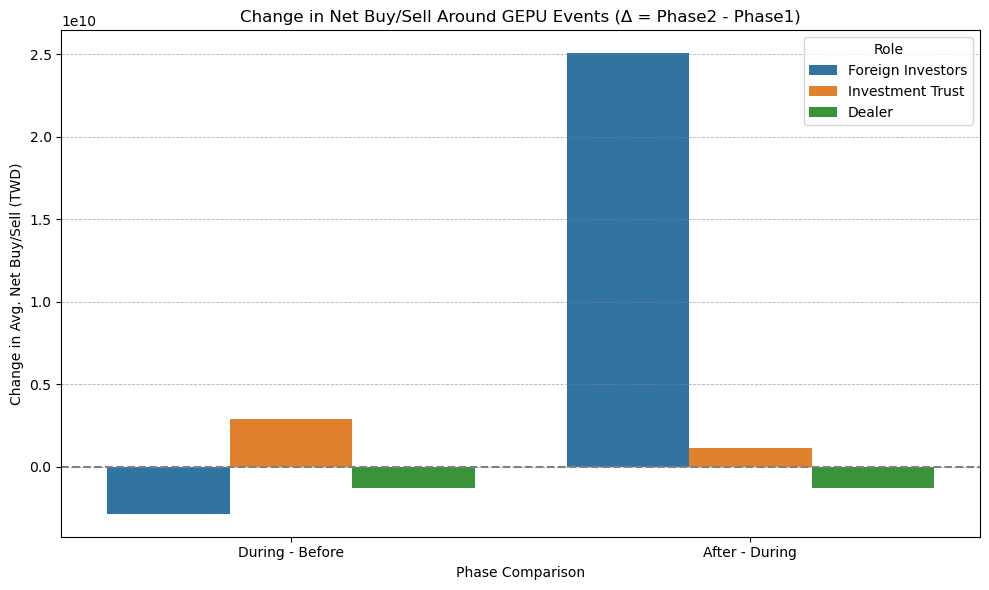

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

plot_delta = []
for _, row in summary_df_gepu.iterrows():
    plot_delta.append({
        "Role": row["Role"],
        "Comparison": "During - Before",
        "Delta": row["Before→During Δ"],
        "p-value": row.get("Before→During p", None)
    })
    plot_delta.append({
        "Role": row["Role"],
        "Comparison": "After - During",
        "Delta": row["During→After Δ"],
        "p-value": row.get("During→After p", None)
    })

delta_df = pd.DataFrame(plot_delta)

# 變化量分組柱狀圖
plt.figure(figsize=(10, 6))
sns.barplot(data=delta_df, x="Comparison", y="Delta", hue="Role", ci=None)
plt.axhline(0, color="gray", linestyle="--")
plt.title("Change in Net Buy/Sell Around GEPU Events (Δ = Phase2 - Phase1)")
plt.ylabel("Change in Avg. Net Buy/Sell (TWD)")
plt.xlabel("Phase Comparison")

# 顯著性星號
for i, row in delta_df.iterrows():
    if row["p-value"] is not None and row["p-value"] < 0.05:
        x = i // 3 + [-0.25, 0, 0.25][i % 3]
        y = row["Delta"] + (2 if row["Delta"] > 0 else -2)
        plt.text(x, y, "*", color="red", ha="center", fontsize=16)

plt.grid(axis='y', linestyle='--', linewidth=0.6, color='gray', alpha=0.6)
plt.gca().xaxis.grid(False)

plt.tight_layout()
plt.show()


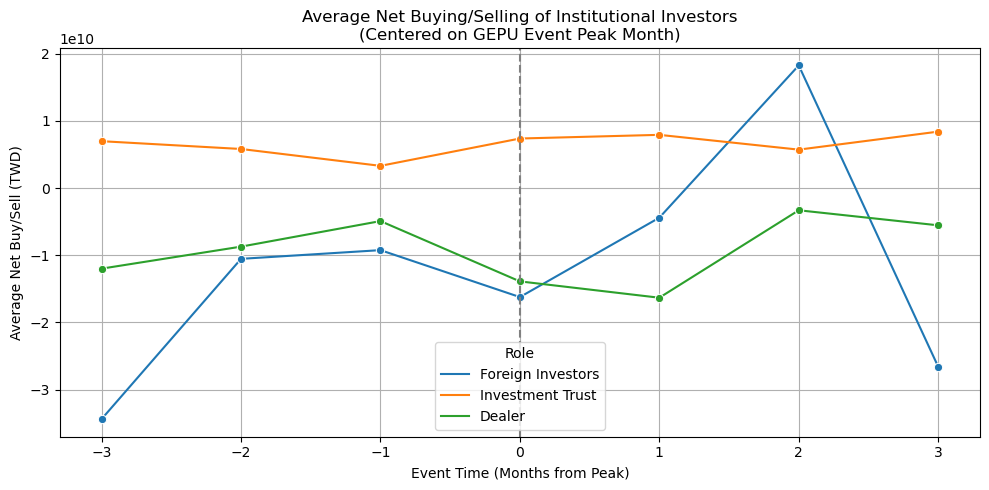

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd


if "YearMonth" not in df.columns:
    if "Year" in df.columns and "Month" in df.columns:
        df["YearMonth"] = df["Year"].astype(str) + "-" + df["Month"].astype(str).str.zfill(2)
    else:
        raise ValueError("df 中缺少 Year 或 Month 欄位，請確認資料格式")

# === GEPU 驟升事件 peak 對齊（以事件的 End_Date 為 t=0）===
event_expanded_peak = []
for start, end in event_ranges:  # GEPU 驟升的事件區間
    event_center = pd.Period(end, freq="M")
    for offset in range(-3, 4):
        period = (event_center + offset).strftime('%Y-%m')
        event_expanded_peak.append({
            "EventTime": offset,
            "YearMonth": period
        })

event_df_peak = pd.DataFrame(event_expanded_peak)


merged_df_peak = pd.merge(event_df_peak, df, on="YearMonth", how="left")

# 三大法人各自加總平均
plot_data = []
for role in ["Foreign Investors", "Investment Trust", "Dealer"]:
    avg_behavior = merged_df_peak.groupby("EventTime")[role].mean()
    for t, val in avg_behavior.items():
        plot_data.append({"Role": role, "EventTime": t, "AvgNetBuySell": val})

plot_df_peak = pd.DataFrame(plot_data)


plt.figure(figsize=(10, 5))
sns.lineplot(data=plot_df_peak, x="EventTime", y="AvgNetBuySell", hue="Role", marker="o")
plt.axvline(0, linestyle="--", color="gray")
plt.title("Average Net Buying/Selling of Institutional Investors\n(Centered on GEPU Event Peak Month)")
plt.xlabel("Event Time (Months from Peak)")
plt.ylabel("Average Net Buy/Sell (TWD)")
plt.grid(True)
plt.tight_layout()
plt.show()


#### Median

In [29]:
from scipy.stats import ttest_rel
import numpy as np
import pandas as pd

summary_stats_gepu_median = []

for role in ["Foreign Investors", "Investment Trust", "Dealer"]:
    before_list = []
    during_list = []
    after_list = []

    for start, end in event_ranges:  # GEPU 驟升事件區間
        start_period = pd.Period(start, freq='M')
        end_period = pd.Period(end, freq='M')

        before_window = [(start_period + offset).strftime('%Y-%m') for offset in [-2, -1]]
        during_window = pd.period_range(start=start_period, end=end_period, freq='M').strftime('%Y-%m').tolist()
        after_window = [(end_period + offset).strftime('%Y-%m') for offset in [1, 2]]


        before_values = df[df["YearMonth"].isin(before_window)][role].dropna()
        during_values = df[df["YearMonth"].isin(during_window)][role].dropna()
        after_values = df[df["YearMonth"].isin(after_window)][role].dropna()

        if len(before_values) > 0 and len(during_values) > 0 and len(after_values) > 0:
            before_list.append(before_values.median())
            during_list.append(during_values.median())
            after_list.append(after_values.median())

    if len(before_list) == len(during_list) == len(after_list) and len(before_list) > 1:
        t1, p1 = ttest_rel(before_list, during_list)
        t2, p2 = ttest_rel(during_list, after_list)
        before_median = np.median(before_list)
        during_median = np.median(during_list)
        after_median = np.median(after_list)

        summary_stats_gepu_median.append({
            "Role": role,
            "Before Median": before_median,
            "During Median": during_median,
            "After Median": after_median,
            "Before→During Δ": during_median - before_median,
            "During→After Δ": after_median - during_median,
            "Before→During p": p1,
            "During→After p": p2,
            "N Events": len(before_list)
})



summary_df_gepu_median = pd.DataFrame(summary_stats_gepu_median)
summary_df_gepu_median.to_csv("institutional_GEPU_event_window_median_summary.csv", index=False)
summary_df_gepu_median


Role  Before Median  During Median  After Median  \
0  Foreign Investors   2.071956e+09  -5.305325e+09  2.114700e+10   
1   Investment Trust   1.253086e+09  -5.875285e+08  2.026504e+09   
2             Dealer  -1.352192e+09  -5.142312e+09  4.950531e+08   

   Before→During Δ  During→After Δ  Before→During p  During→After p  N Events  
0    -7.377281e+09    2.645233e+10         0.886674        0.249483        28  
1    -1.840614e+09    2.614032e+09         0.665380        0.236549        28  
2    -3.790120e+09    5.637365e+09         0.799304        0.767263        28

/var/folders/m3/4kw7w40s6p56xt563fshsjjh0000gn/T/ipykernel_95964/1977192151.py:24: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=delta_df_median, x="Comparison", y="Delta", hue="Role", ci=None)


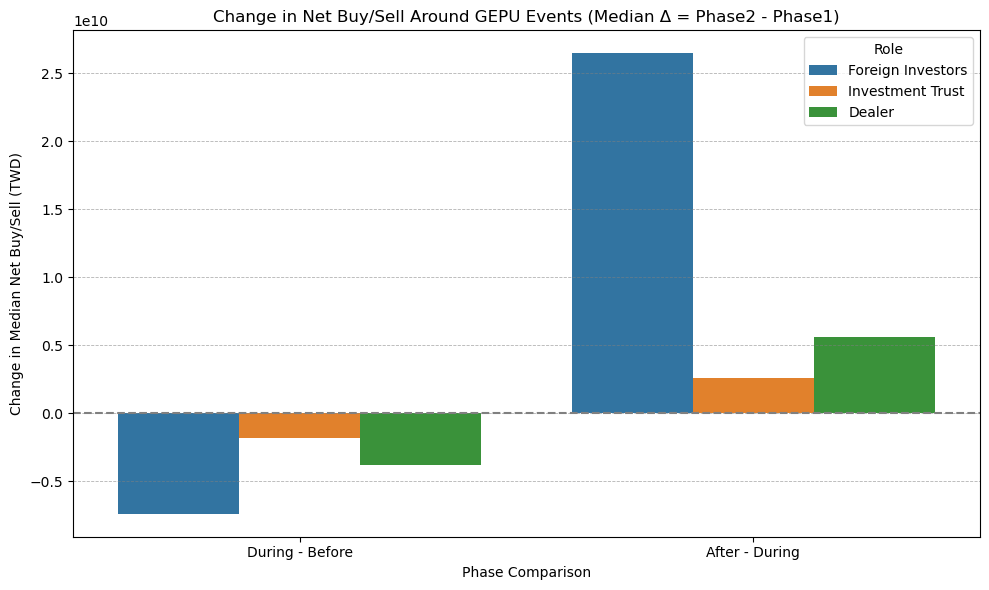

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

plot_delta = []
for _, row in summary_df_gepu_median.iterrows():
    plot_delta.append({
        "Role": row["Role"],
        "Comparison": "During - Before",
        "Delta": row["Before→During Δ"],
        "p-value": row.get("Before→During p", None)
    })
    plot_delta.append({
        "Role": row["Role"],
        "Comparison": "After - During",
        "Delta": row["During→After Δ"],
        "p-value": row.get("During→After p", None)
    })

delta_df_median = pd.DataFrame(plot_delta)


plt.figure(figsize=(10, 6))
sns.barplot(data=delta_df_median, x="Comparison", y="Delta", hue="Role", ci=None)
plt.axhline(0, color="gray", linestyle="--")
plt.title("Change in Net Buy/Sell Around GEPU Events (Median Δ = Phase2 - Phase1)")
plt.ylabel("Change in Median Net Buy/Sell (TWD)")
plt.xlabel("Phase Comparison")

# 顯著性星號
for i, row in delta_df_median.iterrows():
    if row["p-value"] is not None and row["p-value"] < 0.05:
        offset = [-0.25, 0, 0.25][i % 3]
        x = (i // 3) + offset
        y = row["Delta"] + (2 if row["Delta"] > 0 else -2)
        plt.text(x, y, "*", color="red", ha="center", fontsize=16)

plt.grid(axis='y', linestyle='--', linewidth=0.6, color='gray', alpha=0.6)
plt.gca().xaxis.grid(False)
plt.tight_layout()
plt.show()


##### GEPU Surge_New

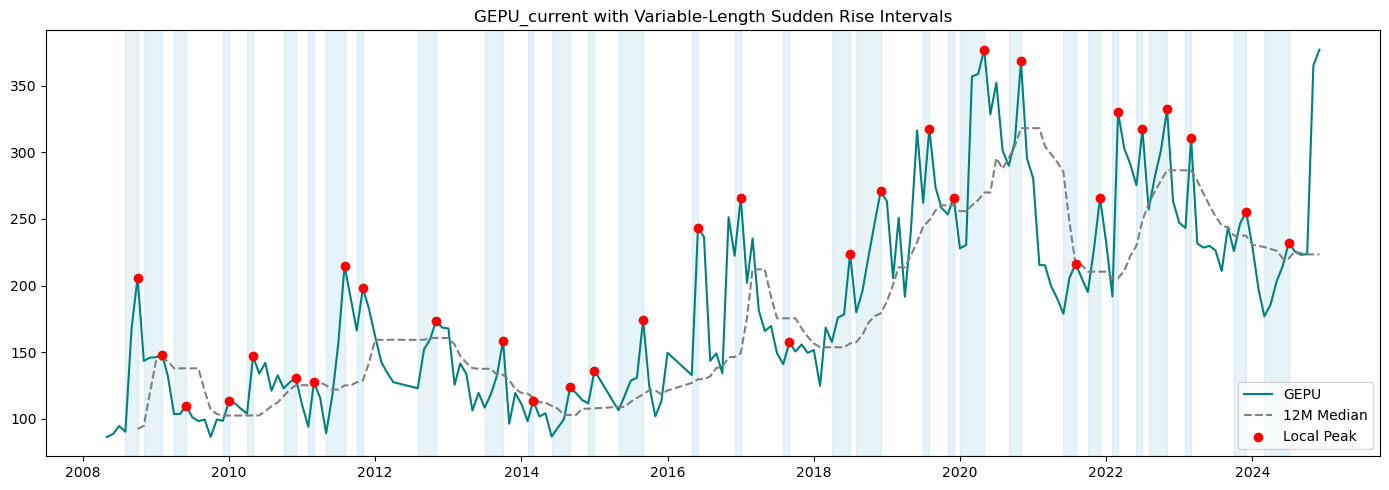

Start_Date   End_Date  Duration_Months
0  2008-08-01 2008-10-01                3
1  2008-11-01 2009-02-01                4
2  2009-04-01 2009-06-01                3
3  2009-12-01 2010-01-01                2
4  2010-04-01 2010-05-01                2
5  2010-10-01 2010-12-01                3
6  2011-02-01 2011-03-01                2
7  2011-05-01 2011-08-01                4
8  2011-10-01 2011-11-01                2
9  2012-08-01 2012-11-01                4
10 2013-07-01 2013-10-01                4
11 2014-02-01 2014-03-01                2
12 2014-06-01 2014-09-01                4
13 2014-12-01 2015-01-01                2
14 2015-05-01 2015-09-01                5
15 2016-05-01 2016-06-01                2
16 2016-12-01 2017-01-01                2
17 2017-08-01 2017-09-01                2
18 2018-04-01 2018-07-01                4
19 2018-08-01 2018-12-01                5
20 2019-07-01 2019-08-01                2
21 2019-11-01 2019-12-01                2
22 2020-01-01 2020-05-01                5
23 2020-09-01 2020-11-01                3
24 2021-06-01 2021-08-01                3
25 2021-10-01 2021-12-01                3
26 2022-02-01 2022-03-01                2
27 2022-06-01 2022-07-01                2
28 2022-08-01 2022-11-01                4
29 2023-02-01 2023-03-01                2
30 2023-10-01 2023-12-01                3
31 2024-03-01 2024-07-01                5

In [103]:
import numpy as np
from scipy.signal import argrelextrema
import matplotlib.pyplot as plt

# ======== 局部高點 ========
df["local_max_gepu"] = np.nan
peak_indices_gepu = argrelextrema(df["GEPU_current"].values, np.greater, order=2)[0]
df.loc[peak_indices_gepu, "local_max_gepu"] = df.loc[peak_indices_gepu, "GEPU_current"]

# ======== 驟升事件（GEPU 當月遞增） ========
event_ranges = []
for idx in peak_indices_gepu:
    for window in range(4, 0, -1):  # 優先找最長連續上升（4→1）
        if idx >= window:
            trend = df.loc[idx - window:idx, "GEPU_current"].values
            if np.all(np.diff(trend) > 0):  # 嚴格遞增
                start_date = df.loc[idx - window, "Date"]
                end_date = df.loc[idx, "Date"]
                event_ranges.append((start_date, end_date))
                break  # 找到就退出這個高點判斷

# ======== 畫出 GEPU 驟升事件 ========
plt.figure(figsize=(14, 5))
plt.plot(df["Date"], df["GEPU_current"], label="GEPU", linewidth=1.5, color='teal')
plt.plot(df["Date"], df["GEPU_current"].rolling(12, min_periods=6).median(), 
         label="12M Median", linestyle="--", color="gray")

# 局部高點標記
plt.scatter(df.loc[peak_indices_gepu, "Date"], df.loc[peak_indices_gepu, "GEPU_current"],
            color='red', label='Local Peak', zorder=5)

# 驟升區間標記
for start_date, end_date in event_ranges:
    plt.axvspan(start_date, end_date, color='lightblue', alpha=0.3)

plt.title("GEPU_current with Variable-Length Sudden Rise Intervals")
plt.legend()
plt.tight_layout()
plt.show()


event_df = pd.DataFrame(event_ranges, columns=["Start_Date", "End_Date"])
event_df["Duration_Months"] = (event_df["End_Date"].dt.to_period("M") - event_df["Start_Date"].dt.to_period("M")).apply(lambda x: x.n) + 1
event_df.to_csv("GEPU_rise.csv", index=False)
event_df

In [ ]:
from scipy.stats import ttest_rel
import numpy as np
import pandas as pd

summary_stats_gepu_median = []

for role in ["Foreign Investors", "Investment Trust", "Dealer"]:
    before_list = []
    during_list = []
    after_list = []

    for start, end in event_ranges:  # GEPU 驟升事件區間
        start_period = pd.Period(start, freq='M')
        end_period = pd.Period(end, freq='M')

        before_window = [(start_period + offset).strftime('%Y-%m') for offset in [-2, -1]]
        during_window = pd.period_range(start=start_period, end=end_period, freq='M').strftime('%Y-%m').tolist()
        after_window = [(end_period + offset).strftime('%Y-%m') for offset in [1, 2]]


        before_values = df[df["YearMonth"].isin(before_window)][role].dropna()
        during_values = df[df["YearMonth"].isin(during_window)][role].dropna()
        after_values = df[df["YearMonth"].isin(after_window)][role].dropna()

        if len(before_values) > 0 and len(during_values) > 0 and len(after_values) > 0:
            before_list.append(before_values.median())
            during_list.append(during_values.median())
            after_list.append(after_values.median())

    if len(before_list) == len(during_list) == len(after_list) and len(before_list) > 1:
        t1, p1 = ttest_rel(before_list, during_list)
        t2, p2 = ttest_rel(during_list, after_list)
        before_median = np.median(before_list)
        during_median = np.median(during_list)
        after_median = np.median(after_list)

        summary_stats_gepu_median.append({
            "Role": role,
            "Before Median": before_median,
            "During Median": during_median,
            "After Median": after_median,
            "Before→During Δ": during_median - before_median,
            "During→After Δ": after_median - during_median,
            "Before→During p": p1,
            "During→After p": p2,
            "N Events": len(before_list)
})



summary_df_gepu_median = pd.DataFrame(summary_stats_gepu_median)
summary_df_gepu_median.to_csv("institutional_GEPU_event_window_median_summary.csv", index=False)
summary_df_gepu_median


Role  Before Median  During Median  After Median  \
0  Foreign Investors   2.071956e+09  -5.305325e+09  2.114700e+10   
1   Investment Trust   1.253086e+09  -5.875285e+08  2.026504e+09   
2             Dealer  -1.352192e+09  -5.142312e+09  4.950531e+08   

   Before→During Δ  During→After Δ  Before→During p  During→After p  N Events  
0    -7.377281e+09    2.645233e+10         0.886674        0.249483        28  
1    -1.840614e+09    2.614032e+09         0.665380        0.236549        28  
2    -3.790120e+09    5.637365e+09         0.799304        0.767263        28

/var/folders/m3/4kw7w40s6p56xt563fshsjjh0000gn/T/ipykernel_52902/3600783797.py:79: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=delta_df, x="Comparison", y="Delta", hue="Role", ci=None)


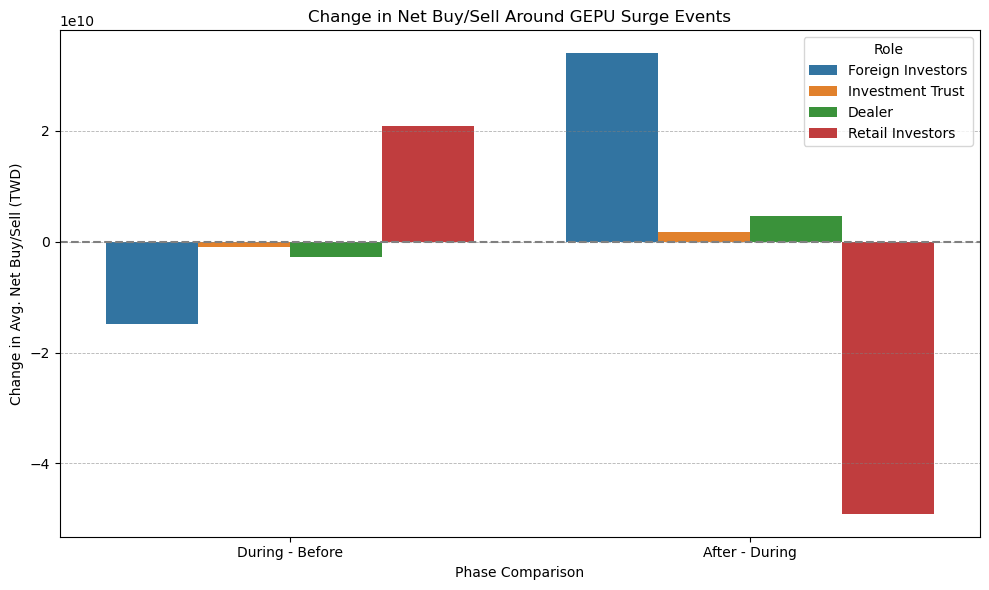

In [104]:
if "YearMonth" not in df.columns:
    if "Year" in df.columns and "Month" in df.columns:
        df["YearMonth"] = df["Year"].astype(str) + "-" + df["Month"].astype(str).str.zfill(2)
    else:
        raise ValueError("df 中缺少 Year 或 Month 欄位，請確認資料格式")


summary_stats = []
# 加上 "Retail Investors"
for role in ["Foreign Investors", "Investment Trust", "Dealer", "Retail Investors"]:
    before_list = []
    during_list = []
    after_list = []

    for start, end in event_ranges:
        start_period = pd.Period(start, freq="M")
        end_period = pd.Period(end, freq="M")

        # 前２個月
        before_window = [(start_period + offset).strftime('%Y-%m') for offset in [-2, -1]]
        # 事件期間（多月）
        during_window = pd.period_range(start=start_period, end=end_period, freq='M').strftime('%Y-%m').tolist()
        # 後２個月
        after_window = [(end_period + offset).strftime('%Y-%m') for offset in [1, 2]]

        before_values = df[df["YearMonth"].isin(before_window)][role].dropna()
        during_values = df[df["YearMonth"].isin(during_window)][role].dropna()
        after_values = df[df["YearMonth"].isin(after_window)][role].dropna()

        if len(before_values) > 0 and len(during_values) > 0 and len(after_values) > 0:
            before_list.append(before_values.mean())
            during_list.append(during_values.mean())
            after_list.append(after_values.mean())

    if len(before_list) == len(during_list) == len(after_list) and len(before_list) > 1:
        t1, p1 = ttest_rel(before_list, during_list)
        t2, p2 = ttest_rel(during_list, after_list)
        before_median = np.median(before_list)
        during_median = np.median(during_list)
        after_median = np.median(after_list)
        summary_stats.append({
            "Role": role,
            "Before Median": before_median,
            "During Median": during_median,
            "After Median": after_median,
            "Before→During Δ": during_median - before_median,
            "During→After Δ": after_median - during_median,
            "Before→During p": p1,
            "During→After p": p2,
            "N Events": len(before_list)
        })

summary_df_median = pd.DataFrame(summary_stats)
summary_df_median.to_csv("GPR_event_window_summary_median.csv", index=False)
summary_df_median

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

plot_delta = []
for _, row in summary_df_median.iterrows():
    plot_delta.append({
        "Role": row["Role"],
        "Comparison": "During - Before",
        "Delta": row["Before→During Δ"],
        "p-value": row.get("Before→During p", None)
    })
    plot_delta.append({
        "Role": row["Role"],
        "Comparison": "After - During",
        "Delta": row["During→After Δ"],
        "p-value": row.get("During→After p", None)
    })

delta_df = pd.DataFrame(plot_delta)

plt.figure(figsize=(10, 6))
sns.barplot(data=delta_df, x="Comparison", y="Delta", hue="Role", ci=None)
plt.axhline(0, color="gray", linestyle="--")
plt.title("Change in Net Buy/Sell Around GEPU Surge Events")
plt.ylabel("Change in Avg. Net Buy/Sell (TWD)")
plt.xlabel("Phase Comparison")

# 顯著性星號
for i, row in delta_df.iterrows():
    if row["p-value"] is not None and row["p-value"] < 0.05:
        x = i // 4 + [-0.3, -0.1, 0.1, 0.3][i % 4]  # 根據角色數重新調整位置
        y = row["Delta"] + (2 if row["Delta"] > 0 else -2)
        plt.text(x, y, "*", color="red", ha="center", fontsize=16)

plt.grid(axis='y', linestyle='--', linewidth=0.6, color='gray', alpha=0.6)
plt.gca().xaxis.grid(False)   

plt.tight_layout()
plt.show()


### EPU 驟降

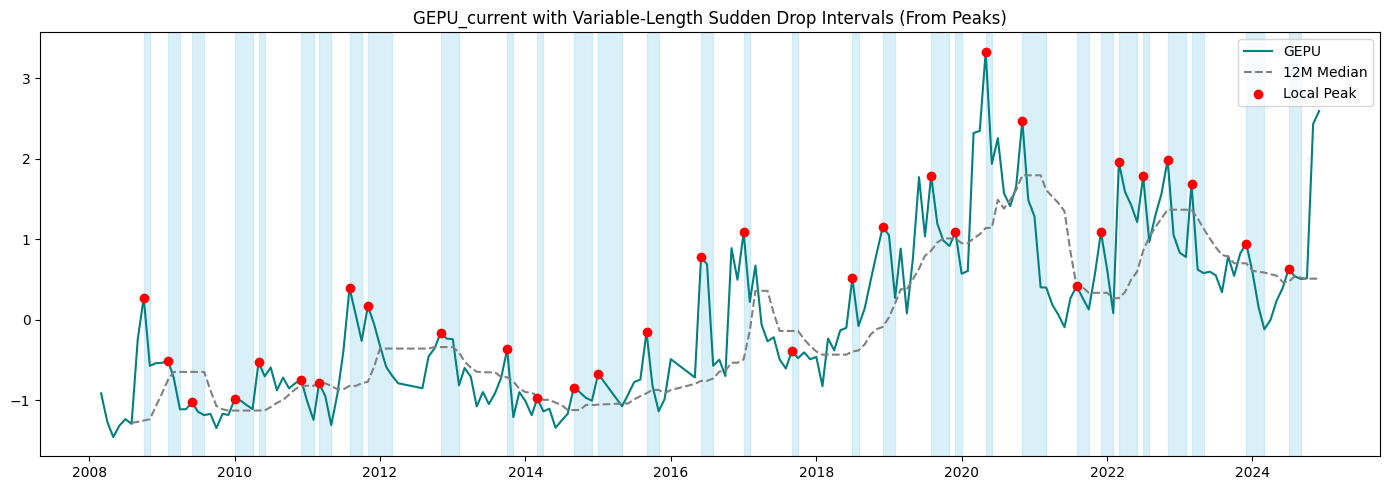

Start_Date   End_Date  Duration_Months
0  2008-10-01 2008-11-01                2
1  2009-02-01 2009-04-01                3
2  2009-06-01 2009-08-01                3
3  2010-01-01 2010-04-01                4
4  2010-05-01 2010-06-01                2
5  2010-12-01 2011-02-01                3
6  2011-03-01 2011-05-01                3
7  2011-08-01 2011-10-01                3
8  2011-11-01 2012-03-01                5
9  2012-11-01 2013-02-01                4
10 2013-10-01 2013-11-01                2
11 2014-03-01 2014-04-01                2
12 2014-09-01 2014-12-01                4
13 2015-01-01 2015-05-01                5
14 2015-09-01 2015-11-01                3
15 2016-06-01 2016-08-01                3
16 2017-01-01 2017-02-01                2
17 2017-09-01 2017-10-01                2
18 2018-07-01 2018-08-01                2
19 2018-12-01 2019-02-01                3
20 2019-08-01 2019-11-01                4
21 2019-12-01 2020-01-01                2
22 2020-05-01 2020-06-01                2
23 2020-11-01 2021-03-01                5
24 2021-08-01 2021-10-01                3
25 2021-12-01 2022-02-01                3
26 2022-03-01 2022-06-01                4
27 2022-07-01 2022-08-01                2
28 2022-11-01 2023-02-01                4
29 2023-03-01 2023-05-01                3
30 2023-12-01 2024-03-01                4
31 2024-07-01 2024-09-01                3

In [495]:
import numpy as np
from scipy.signal import argrelextrema
import matplotlib.pyplot as plt
import pandas as pd

# ======== GEPU 12期移動中位數 ========
df["GEPU_MA12"] = df["GEPU_current"].rolling(window=12, min_periods=6).median()

# ======== 局部高點（驟降起點） ========
df["local_max_gepu"] = np.nan
peak_indices_gepu = argrelextrema(df["GEPU_current"].values, np.greater, order=2)[0]
df.loc[peak_indices_gepu, "local_max_gepu"] = df.loc[peak_indices_gepu, "GEPU_current"]

# ======== 驟降事件：高點往後連續 1~4 月嚴格遞減 ========
gepu_drop_event_ranges = []
for idx in peak_indices_gepu:
    for window in range(4, 0, -1):  # 先試 4 個月再縮短
        if idx + window < len(df):
            trend = df.loc[idx:idx + window, "GEPU_current"].values
            if np.all(np.diff(trend) < 0):  # 嚴格遞減
                start_date = df.loc[idx, "Date"]
                end_date = df.loc[idx + window, "Date"]
                gepu_drop_event_ranges.append((start_date, end_date))
                break  # 找到就退出這個 peak 判斷

# ========  GEPU 驟降區間 ========
plt.figure(figsize=(14, 5))
plt.plot(df["Date"], df["GEPU_current"], label="GEPU", linewidth=1.5, color='teal')
plt.plot(df["Date"], df["GEPU_MA12"], label="12M Median", linestyle="--", color="gray")

# 局部高點
plt.scatter(df.loc[peak_indices_gepu, "Date"], df.loc[peak_indices_gepu, "GEPU_current"],
            color='red', label='Local Peak', zorder=5)

# 驟降區間
for start_date, end_date in gepu_drop_event_ranges:
    plt.axvspan(start_date, end_date, color='skyblue', alpha=0.3)

plt.title("GEPU_current with Variable-Length Sudden Drop Intervals (From Peaks)")
plt.legend()
plt.tight_layout()
plt.show()

gepu_drop_event_df = pd.DataFrame(gepu_drop_event_ranges, columns=["Start_Date", "End_Date"])
gepu_drop_event_df["Start_Date"] = pd.to_datetime(gepu_drop_event_df["Start_Date"])
gepu_drop_event_df["End_Date"] = pd.to_datetime(gepu_drop_event_df["End_Date"])
gepu_drop_event_df["Duration_Months"] = (
    gepu_drop_event_df["End_Date"].dt.to_period("M") - gepu_drop_event_df["Start_Date"].dt.to_period("M")
).apply(lambda x: x.n) + 1
gepu_drop_event_df.to_csv("GEPU_drop.csv", index=False)
gepu_drop_event_df

#### Mean

In [ ]:
from scipy.stats import ttest_rel
import numpy as np
import pandas as pd

summary_stats_gepu_drop = []


for role in ["Foreign Investors", "Investment Trust", "Dealer"]:
    before_list = []
    during_list = []
    after_list = []

    # GEPU 驟降事件區間
    for start, end in gepu_drop_event_df[["Start_Date", "End_Date"]].values:
        start_period = pd.Period(start, freq="M")
        end_period = pd.Period(end, freq="M")

        # 前 2 個月
        before_window = [(start_period + offset).strftime('%Y-%m') for offset in [-2, -1]]
        # 驟降事件
        during_window = pd.period_range(start=start_period, end=end_period, freq='M').strftime('%Y-%m').tolist()
        # 後 2 個月
        after_window = [(end_period + offset).strftime('%Y-%m') for offset in [1, 2]]

        # 三階段法人資料
        before_vals = df[df["YearMonth"].isin(before_window)][role].dropna()
        during_vals = df[df["YearMonth"].isin(during_window)][role].dropna()
        after_vals = df[df["YearMonth"].isin(after_window)][role].dropna()

        if len(before_vals) > 0 and len(during_vals) > 0 and len(after_vals) > 0:
            before_list.append(before_vals.mean())
            during_list.append(during_vals.mean())
            after_list.append(after_vals.mean())

    # 條件符合再做 t 檢定
    if len(before_list) == len(during_list) == len(after_list) and len(before_list) > 1:
        t1, p1 = ttest_rel(before_list, during_list)
        t2, p2 = ttest_rel(during_list, after_list)

        summary_stats_gepu_drop.append({
            "Role": role,
            "Before Avg": np.mean(before_list),
            "During Avg": np.mean(during_list),
            "After Avg": np.mean(after_list),
            "Before→During Δ": np.mean(np.array(during_list) - np.array(before_list)),
            "During→After Δ": np.mean(np.array(after_list) - np.array(during_list)),
            "Before→During p": p1,
            "During→After p": p2,
            "N Events": len(before_list)
        })


summary_df_gepu_drop = pd.DataFrame(summary_stats_gepu_drop)
summary_df_gepu_drop.to_csv("institutional_GEPU_drop_event_window_summary.csv", index=False)
summary_df_gepu_drop


Role    Before Avg    During Avg     After Avg  \
0  Foreign Investors -1.088021e+10 -3.396135e+09 -2.694371e+10   
1   Investment Trust  4.490599e+09  7.870176e+09  5.858843e+09   
2             Dealer -6.482317e+09 -9.893847e+09 -8.818541e+09   

   Before→During Δ  During→After Δ  Before→During p  During→After p  N Events  
0     7.484071e+09   -2.354757e+10         0.630041        0.122213        32  
1     3.379576e+09   -2.011332e+09         0.167631        0.292376        32  
2    -3.411530e+09    1.075306e+09         0.468272        0.704971        32

/var/folders/m3/4kw7w40s6p56xt563fshsjjh0000gn/T/ipykernel_10684/3537498969.py:25: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=delta_df, x="Comparison", y="Delta", hue="Role", ci=None)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Library/Frameworks/Python.framework/Versions/3.12/lib/

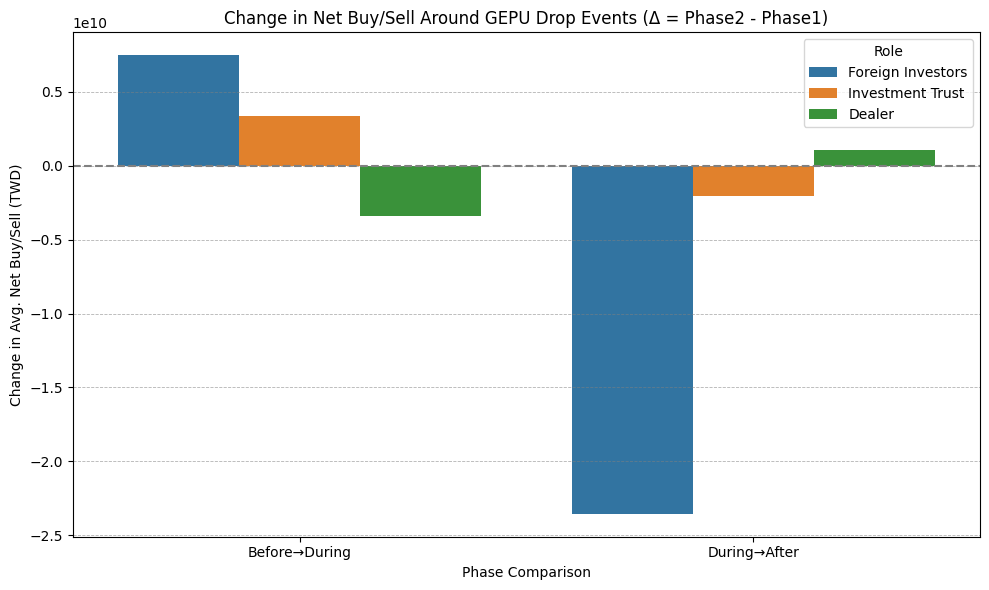

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


plot_delta = []
for _, row in summary_df_gepu_drop.iterrows():
    plot_delta.append({
        "Role": row["Role"],
        "Comparison": "Before→During",
        "Delta": row["Before→During Δ"],
        "p-value": row.get("Before→During p", None)
    })
    plot_delta.append({
        "Role": row["Role"],
        "Comparison": "During→After",
        "Delta": row["During→After Δ"],
        "p-value": row.get("During→After p", None)
    })

delta_df = pd.DataFrame(plot_delta)

plt.figure(figsize=(10, 6))
sns.barplot(data=delta_df, x="Comparison", y="Delta", hue="Role", ci=None)
plt.axhline(0, color="gray", linestyle="--")
plt.title("Change in Net Buy/Sell Around GEPU Drop Events (Δ = Phase2 - Phase1)")
plt.ylabel("Change in Avg. Net Buy/Sell (TWD)")
plt.xlabel("Phase Comparison")


for i, row in delta_df.iterrows():
    if row["p-value"] is not None and row["p-value"] < 0.05:
        offset = [-0.25, 0, 0.25][i % 3]
        x = (i // 3) + offset
        y = row["Delta"] + (2 if row["Delta"] > 0 else -2)
        plt.text(x, y, "*", color="red", ha="center", fontsize=16)

plt.grid(axis='y', linestyle='--', linewidth=0.6, color='gray', alpha=0.6)
plt.gca().xaxis.grid(False)
plt.tight_layout()
plt.show()


#### Median

In [496]:
from scipy.stats import ttest_rel
import numpy as np
import pandas as pd

summary_stats_gepu_drop_median = []


for role in ["Foreign Investors", "Investment Trust", "Dealer"]:
    before_list = []
    during_list = []
    after_list = []

    for start, end in gepu_drop_event_df[["Start_Date", "End_Date"]].values:
        start_period = pd.Period(start, freq="M")
        end_period = pd.Period(end, freq="M")

        before_window = [(start_period + offset).strftime('%Y-%m') for offset in [-2, -1]]
        during_window = pd.period_range(start=start_period, end=end_period, freq='M').strftime('%Y-%m').tolist()
        after_window = [(end_period + offset).strftime('%Y-%m') for offset in [1, 2]]

        before_vals = df[df["YearMonth"].isin(before_window)][role].dropna()
        during_vals = df[df["YearMonth"].isin(during_window)][role].dropna()
        after_vals = df[df["YearMonth"].isin(after_window)][role].dropna()

        if len(before_vals) > 0 and len(during_vals) > 0 and len(after_vals) > 0:
            before_list.append(before_vals.median())  
            during_list.append(during_vals.median())   
            after_list.append(after_vals.median())     

    if len(before_list) == len(during_list) == len(after_list) and len(before_list) > 1:
        t1, p1 = ttest_rel(before_list, during_list)
        t2, p2 = ttest_rel(during_list, after_list)

        before_median = np.median(before_list)
        during_median = np.median(during_list)
        after_median = np.median(after_list)

        summary_stats_gepu_drop_median.append({
            "Role": role,
            "Before Median": before_median,
            "During Median": during_median,
            "After Median": after_median,
            "Before→During Δ": during_median - before_median,
            "During→After Δ": after_median - during_median,
            "Before→During p": p1,
            "During→After p": p2,
            "N Events": len(before_list)
        })



summary_df_gepu_drop_median = pd.DataFrame(summary_stats_gepu_drop_median)
summary_df_gepu_drop_median.to_csv("institutional_GEPU_drop_event_median_summary.csv", index=False)
summary_df_gepu_drop_median


Role  Before Median  During Median  After Median  \
0  Foreign Investors  -9.752029e+09   9.558316e+09 -2.276702e+10   
1   Investment Trust   1.644768e+09  -6.786709e+06 -1.317348e+09   
2             Dealer  -1.840214e+09  -4.269157e+09 -3.768587e+09   

   Before→During Δ  During→After Δ  Before→During p  During→After p  N Events  
0     1.931035e+10   -3.232534e+10         0.620521        0.134978        32  
1    -1.651555e+09   -1.310561e+09         0.354890        0.704611        32  
2    -2.428944e+09    5.005702e+08         0.328019        0.435011        32

/var/folders/m3/4kw7w40s6p56xt563fshsjjh0000gn/T/ipykernel_10684/1735731916.py:25: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=delta_df_median, x="Comparison", y="Delta", hue="Role", ci=None)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Library/Frameworks/Python.framework/Versions/3.

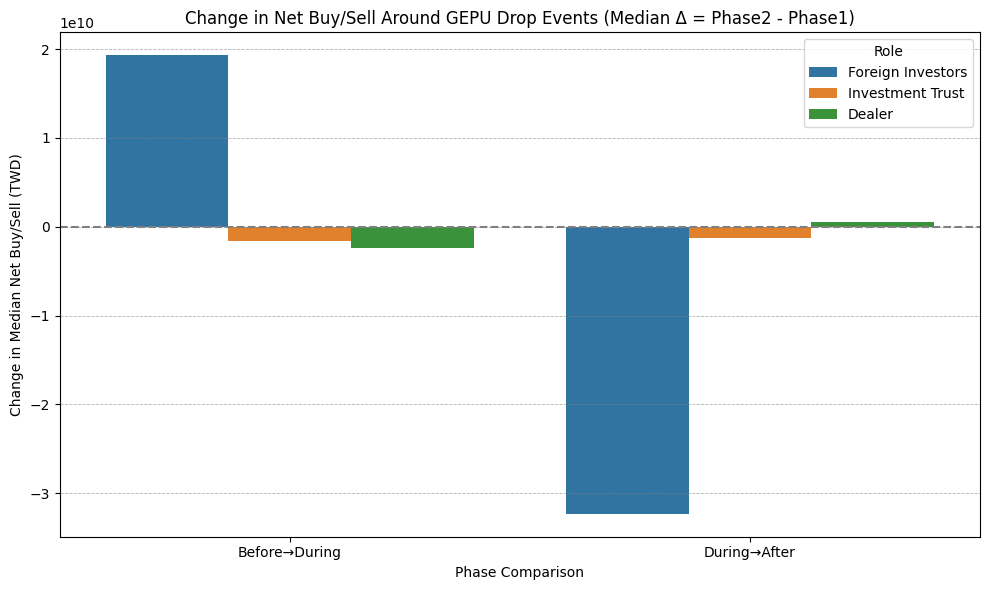

In [497]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


plot_delta = []
for _, row in summary_df_gepu_drop_median.iterrows():
    plot_delta.append({
        "Role": row["Role"],
        "Comparison": "Before→During",
        "Delta": row["Before→During Δ"],
        "p-value": row.get("Before→During p", None)
    })
    plot_delta.append({
        "Role": row["Role"],
        "Comparison": "During→After",
        "Delta": row["During→After Δ"],
        "p-value": row.get("During→After p", None)
    })

delta_df_median = pd.DataFrame(plot_delta)


plt.figure(figsize=(10, 6))
sns.barplot(data=delta_df_median, x="Comparison", y="Delta", hue="Role", ci=None)
plt.axhline(0, color="gray", linestyle="--")
plt.title("Change in Net Buy/Sell Around GEPU Drop Events (Median Δ = Phase2 - Phase1)")
plt.ylabel("Change in Median Net Buy/Sell (TWD)")
plt.xlabel("Phase Comparison")

# 顯著性星號
for i, row in delta_df_median.iterrows():
    if row["p-value"] is not None and row["p-value"] < 0.05:
        offset = [-0.25, 0, 0.25][i % 3]
        x = (i // 3) + offset
        y = row["Delta"] + (2 if row["Delta"] > 0 else -2)
        plt.text(x, y, "*", color="red", ha="center", fontsize=16)

plt.grid(axis='y', linestyle='--', linewidth=0.6, color='gray', alpha=0.6)
plt.gca().xaxis.grid(False)
plt.tight_layout()
plt.show()


##### GEPU Drop_new

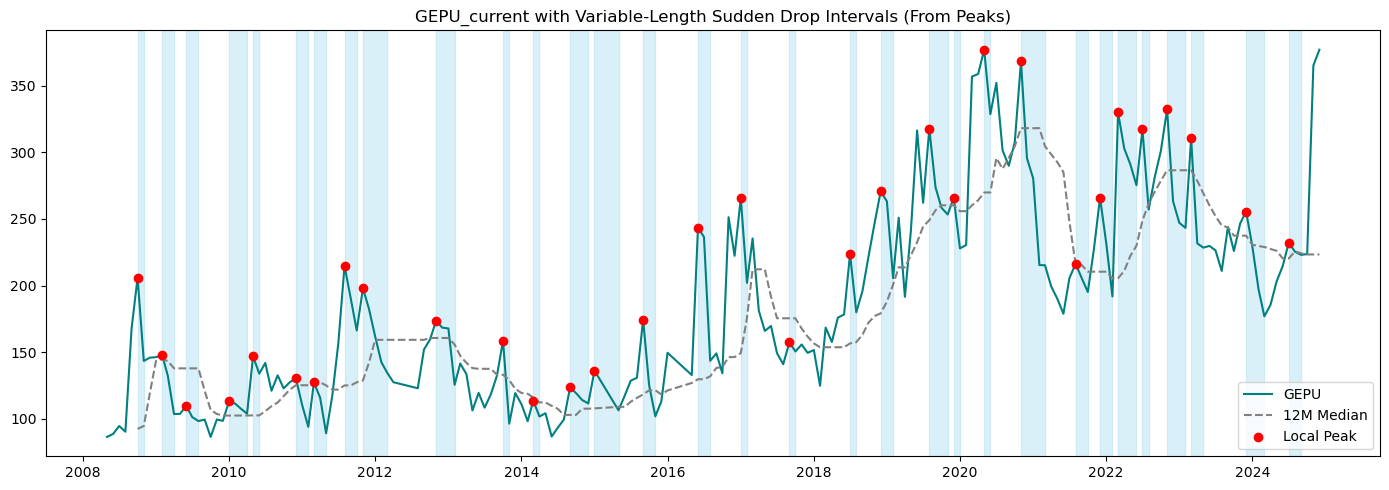

Start_Date   End_Date  Duration_Months
0  2008-10-01 2008-11-01                2
1  2009-02-01 2009-04-01                3
2  2009-06-01 2009-08-01                3
3  2010-01-01 2010-04-01                4
4  2010-05-01 2010-06-01                2
5  2010-12-01 2011-02-01                3
6  2011-03-01 2011-05-01                3
7  2011-08-01 2011-10-01                3
8  2011-11-01 2012-03-01                5
9  2012-11-01 2013-02-01                4
10 2013-10-01 2013-11-01                2
11 2014-03-01 2014-04-01                2
12 2014-09-01 2014-12-01                4
13 2015-01-01 2015-05-01                5
14 2015-09-01 2015-11-01                3
15 2016-06-01 2016-08-01                3
16 2017-01-01 2017-02-01                2
17 2017-09-01 2017-10-01                2
18 2018-07-01 2018-08-01                2
19 2018-12-01 2019-02-01                3
20 2019-08-01 2019-11-01                4
21 2019-12-01 2020-01-01                2
22 2020-05-01 2020-06-01                2
23 2020-11-01 2021-03-01                5
24 2021-08-01 2021-10-01                3
25 2021-12-01 2022-02-01                3
26 2022-03-01 2022-06-01                4
27 2022-07-01 2022-08-01                2
28 2022-11-01 2023-02-01                4
29 2023-03-01 2023-05-01                3
30 2023-12-01 2024-03-01                4
31 2024-07-01 2024-09-01                3

In [105]:
import numpy as np
from scipy.signal import argrelextrema
import matplotlib.pyplot as plt
import pandas as pd

# ======== GEPU 12期移動中位數 ========
df["GEPU_MA12"] = df["GEPU_current"].rolling(window=12, min_periods=6).median()

# ======== 局部高點（驟降起點） ========
df["local_max_gepu"] = np.nan
peak_indices_gepu = argrelextrema(df["GEPU_current"].values, np.greater, order=2)[0]
df.loc[peak_indices_gepu, "local_max_gepu"] = df.loc[peak_indices_gepu, "GEPU_current"]

# ======== 驟降事件：高點往後連續 1~4 月嚴格遞減 ========
gepu_drop_event_ranges = []
for idx in peak_indices_gepu:
    for window in range(4, 0, -1):  # 先試 4 個月再縮短
        if idx + window < len(df):
            trend = df.loc[idx:idx + window, "GEPU_current"].values
            if np.all(np.diff(trend) < 0):  # 嚴格遞減
                start_date = df.loc[idx, "Date"]
                end_date = df.loc[idx + window, "Date"]
                gepu_drop_event_ranges.append((start_date, end_date))
                break  # 找到就退出這個 peak 判斷

# ========  GEPU 驟降區間 ========
plt.figure(figsize=(14, 5))
plt.plot(df["Date"], df["GEPU_current"], label="GEPU", linewidth=1.5, color='teal')
plt.plot(df["Date"], df["GEPU_MA12"], label="12M Median", linestyle="--", color="gray")

# 局部高點
plt.scatter(df.loc[peak_indices_gepu, "Date"], df.loc[peak_indices_gepu, "GEPU_current"],
            color='red', label='Local Peak', zorder=5)

# 驟降區間
for start_date, end_date in gepu_drop_event_ranges:
    plt.axvspan(start_date, end_date, color='skyblue', alpha=0.3)

plt.title("GEPU_current with Variable-Length Sudden Drop Intervals (From Peaks)")
plt.legend()
plt.tight_layout()
plt.show()

gepu_drop_event_df = pd.DataFrame(gepu_drop_event_ranges, columns=["Start_Date", "End_Date"])
gepu_drop_event_df["Start_Date"] = pd.to_datetime(gepu_drop_event_df["Start_Date"])
gepu_drop_event_df["End_Date"] = pd.to_datetime(gepu_drop_event_df["End_Date"])
gepu_drop_event_df["Duration_Months"] = (
    gepu_drop_event_df["End_Date"].dt.to_period("M") - gepu_drop_event_df["Start_Date"].dt.to_period("M")
).apply(lambda x: x.n) + 1
gepu_drop_event_df.to_csv("GEPU_drop.csv", index=False)
gepu_drop_event_df

In [106]:
from scipy.stats import ttest_rel
import numpy as np
import pandas as pd

summary_stats_gepu_drop_median = []


for role in ["Foreign Investors", "Investment Trust", "Dealer"]:
    before_list = []
    during_list = []
    after_list = []

    for start, end in gepu_drop_event_df[["Start_Date", "End_Date"]].values:
        start_period = pd.Period(start, freq="M")
        end_period = pd.Period(end, freq="M")

        before_window = [(start_period + offset).strftime('%Y-%m') for offset in [-2, -1]]
        during_window = pd.period_range(start=start_period, end=end_period, freq='M').strftime('%Y-%m').tolist()
        after_window = [(end_period + offset).strftime('%Y-%m') for offset in [1, 2]]

        before_vals = df[df["YearMonth"].isin(before_window)][role].dropna()
        during_vals = df[df["YearMonth"].isin(during_window)][role].dropna()
        after_vals = df[df["YearMonth"].isin(after_window)][role].dropna()

        if len(before_vals) > 0 and len(during_vals) > 0 and len(after_vals) > 0:
            before_list.append(before_vals.median())  
            during_list.append(during_vals.median())   
            after_list.append(after_vals.median())     

    if len(before_list) == len(during_list) == len(after_list) and len(before_list) > 1:
        t1, p1 = ttest_rel(before_list, during_list)
        t2, p2 = ttest_rel(during_list, after_list)

        before_median = np.median(before_list)
        during_median = np.median(during_list)
        after_median = np.median(after_list)

        summary_stats_gepu_drop_median.append({
            "Role": role,
            "Before Median": before_median,
            "During Median": during_median,
            "After Median": after_median,
            "Before→During Δ": during_median - before_median,
            "During→After Δ": after_median - during_median,
            "Before→During p": p1,
            "During→After p": p2,
            "N Events": len(before_list)
        })



summary_df_gepu_drop_median = pd.DataFrame(summary_stats_gepu_drop_median)
summary_df_gepu_drop_median.to_csv("institutional_GEPU_drop_event_median_summary.csv", index=False)
summary_df_gepu_drop_median


Role  Before Median  During Median  After Median  \
0  Foreign Investors  -9.752029e+09   9.558316e+09 -2.276702e+10   
1   Investment Trust   1.644768e+09  -6.786709e+06 -1.317348e+09   
2             Dealer  -1.840214e+09  -4.269157e+09 -3.768587e+09   

   Before→During Δ  During→After Δ  Before→During p  During→After p  N Events  
0     1.931035e+10   -3.232534e+10         0.620521        0.134978        32  
1    -1.651555e+09   -1.310561e+09         0.354890        0.704611        32  
2    -2.428944e+09    5.005702e+08         0.328019        0.435011        32

/var/folders/m3/4kw7w40s6p56xt563fshsjjh0000gn/T/ipykernel_52902/1095007167.py:79: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=delta_df, x="Comparison", y="Delta", hue="Role", ci=None)


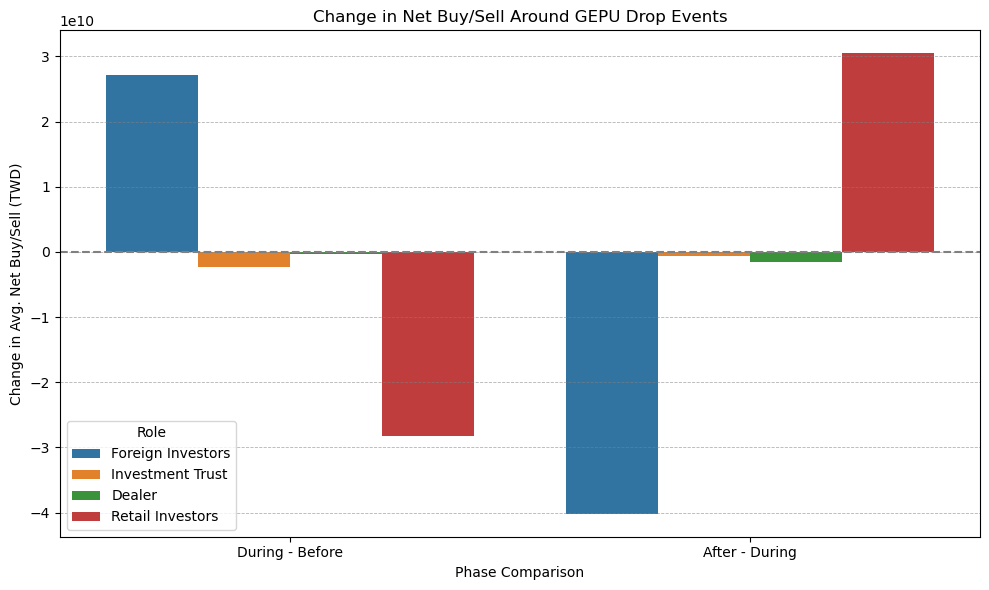

In [107]:
if "YearMonth" not in df.columns:
    if "Year" in df.columns and "Month" in df.columns:
        df["YearMonth"] = df["Year"].astype(str) + "-" + df["Month"].astype(str).str.zfill(2)
    else:
        raise ValueError("df 中缺少 Year 或 Month 欄位，請確認資料格式")


summary_stats = []
# 加上 "Retail Investors"
for role in ["Foreign Investors", "Investment Trust", "Dealer", "Retail Investors"]:
    before_list = []
    during_list = []
    after_list = []

    for start, end in gepu_drop_event_ranges:
        start_period = pd.Period(start, freq="M")
        end_period = pd.Period(end, freq="M")

        # 前２個月
        before_window = [(start_period + offset).strftime('%Y-%m') for offset in [-2, -1]]
        # 事件期間（多月）
        during_window = pd.period_range(start=start_period, end=end_period, freq='M').strftime('%Y-%m').tolist()
        # 後２個月
        after_window = [(end_period + offset).strftime('%Y-%m') for offset in [1, 2]]

        before_values = df[df["YearMonth"].isin(before_window)][role].dropna()
        during_values = df[df["YearMonth"].isin(during_window)][role].dropna()
        after_values = df[df["YearMonth"].isin(after_window)][role].dropna()

        if len(before_values) > 0 and len(during_values) > 0 and len(after_values) > 0:
            before_list.append(before_values.mean())
            during_list.append(during_values.mean())
            after_list.append(after_values.mean())

    if len(before_list) == len(during_list) == len(after_list) and len(before_list) > 1:
        t1, p1 = ttest_rel(before_list, during_list)
        t2, p2 = ttest_rel(during_list, after_list)
        before_median = np.median(before_list)
        during_median = np.median(during_list)
        after_median = np.median(after_list)
        summary_stats.append({
            "Role": role,
            "Before Median": before_median,
            "During Median": during_median,
            "After Median": after_median,
            "Before→During Δ": during_median - before_median,
            "During→After Δ": after_median - during_median,
            "Before→During p": p1,
            "During→After p": p2,
            "N Events": len(before_list)
        })

summary_df_median = pd.DataFrame(summary_stats)
summary_df_median.to_csv("GPR_event_window_summary_median.csv", index=False)
summary_df_median

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

plot_delta = []
for _, row in summary_df_median.iterrows():
    plot_delta.append({
        "Role": row["Role"],
        "Comparison": "During - Before",
        "Delta": row["Before→During Δ"],
        "p-value": row.get("Before→During p", None)
    })
    plot_delta.append({
        "Role": row["Role"],
        "Comparison": "After - During",
        "Delta": row["During→After Δ"],
        "p-value": row.get("During→After p", None)
    })

delta_df = pd.DataFrame(plot_delta)

plt.figure(figsize=(10, 6))
sns.barplot(data=delta_df, x="Comparison", y="Delta", hue="Role", ci=None)
plt.axhline(0, color="gray", linestyle="--")
plt.title("Change in Net Buy/Sell Around GEPU Drop Events")
plt.ylabel("Change in Avg. Net Buy/Sell (TWD)")
plt.xlabel("Phase Comparison")

# 顯著性星號
for i, row in delta_df.iterrows():
    if row["p-value"] is not None and row["p-value"] < 0.05:
        x = i // 4 + [-0.3, -0.1, 0.1, 0.3][i % 4]  # 根據角色數重新調整位置
        y = row["Delta"] + (2 if row["Delta"] > 0 else -2)
        plt.text(x, y, "*", color="red", ha="center", fontsize=16)

plt.grid(axis='y', linestyle='--', linewidth=0.6, color='gray', alpha=0.6)
plt.gca().xaxis.grid(False)   

plt.tight_layout()
plt.show()
